# Set up

In [ ]:
!sudo apt install libcairo2-dev pkg-config python3-dev
!pip install -r ./requirements.txt

In [1]:
!unzip deepsvg-master.zip
!unzip DiT-main.zip

Archive:  deepsvg-master.zip
186d604ddc7b6ddf382fca1742dec27a41b8eb9f
   creating: deepsvg-master/
 extracting: deepsvg-master/.gitignore  
  inflating: deepsvg-master/LICENCE  
  inflating: deepsvg-master/README.md  
   creating: deepsvg-master/configs/
   creating: deepsvg-master/configs/deepsvg/
 extracting: deepsvg-master/configs/deepsvg/.gitignore  
  inflating: deepsvg-master/configs/deepsvg/default_icons.py  
  inflating: deepsvg-master/configs/deepsvg/defaults_fonts.py  
  inflating: deepsvg-master/configs/deepsvg/hierarchical_ordered.py  
  inflating: deepsvg-master/configs/deepsvg/hierarchical_ordered_fonts.py  
   creating: deepsvg-master/dataset/
  inflating: deepsvg-master/dataset/.gitignore  
  inflating: deepsvg-master/dataset/download.sh  
  inflating: deepsvg-master/dataset/download_fonts.sh  
  inflating: deepsvg-master/dataset/preprocess.py  
   creating: deepsvg-master/deepsvg/
 extracting: deepsvg-master/deepsvg/__init__.py  
  inflating: deepsvg-master/deepsvg/con

Archive:  DiT-main.zip
796c29e532f47bba17c5b9c5eb39b9354b8b7c64
   creating: DiT-main/
  inflating: DiT-main/CODE_OF_CONDUCT.md  
  inflating: DiT-main/CONTRIBUTING.md  
  inflating: DiT-main/LICENSE.txt    
  inflating: DiT-main/README.md      
   creating: DiT-main/diffusion/
  inflating: DiT-main/diffusion/__init__.py  
  inflating: DiT-main/diffusion/diffusion_utils.py  
  inflating: DiT-main/diffusion/gaussian_diffusion.py  
  inflating: DiT-main/diffusion/respace.py  
  inflating: DiT-main/diffusion/timestep_sampler.py  
  inflating: DiT-main/download.py    
  inflating: DiT-main/environment.yml  
  inflating: DiT-main/models.py      
  inflating: DiT-main/run_DiT.ipynb  
  inflating: DiT-main/sample.py      
  inflating: DiT-main/sample_ddp.py  
  inflating: DiT-main/train.py       
   creating: DiT-main/visuals/
 extracting: DiT-main/visuals/sample_grid_0.png  
 extracting: DiT-main/visuals/sample_grid_1.png  


In [1]:
import sys

from deepsvg.svglib.svg_path import SVGPath
from deepsvg.svglib.svg import SVG
from deepsvg import utils
from deepsvg.difflib.tensor import SVGTensor
from deepsvg.svglib.utils import to_gif
from deepsvg.svglib.geom import Bbox
from deepsvg.svgtensor_dataset import SVGTensorDataset, load_dataset
from deepsvg.utils.utils import batchify, linear
from deepsvg.difflib.utils import plot_points

import torch
import numpy as np

## util functions

In [ ]:
from matplotlib.figure import Figure
import io
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt


def plot_svg(svg_tensor1: torch.Tensor, svg_tensor2: torch.Tensor):
  """takes two tensors describing an svg and plots them on one graph and returns it"""
  x1 = [xy[0].item() for xy in svg_tensor1]
  y1 = [xy[1].item() for xy in svg_tensor1]

  x2 = [xy[0].item() for xy in svg_tensor2]
  y2 = [xy[1].item() for xy in svg_tensor2]

  plt.figure()
  plt.scatter(x1, y1, c="b")
  plt.scatter(x2, y2, c="b")

  return plt

def fig2img(fig: Figure):
    """convert a Matplotlib figure to a PIL Image and return it"""
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    plt.close(fig.gcf())
    return img

def remove_negatives(svg_tensor: torch.Tensor):
  """removes negative components from tensors"""
  pass

def show_tensor_image(image):
    """ takes a tensor and displays an image"""
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

def square_svg_latent(svg_latent: torch.Tensor):
    return torch.reshape(svg_latent.clone().squeeze(), (16, 16)).unsqueeze(dim=0)

def unsquare_svg_latent_square(svg_latent_square: torch.Tensor):
    return torch.reshape(svg_latent_square.clone(), (1, 256)).unsqueeze(dim=0)

# Loading Dataset

## Loading the DeepSVG Dataset

In [4]:
!chmod u+x ./pretrained/download.sh
!./pretrained/download.sh

--2023-07-11 20:27:43--  https://docs.google.com/uc?export=download&confirm=&id=1tsVx_cnFunSf5vvPWPVTjZ84IQC2pIDm
Resolving docs.google.com (docs.google.com)... 142.250.185.206, 2a00:1450:4001:812::200e
Connecting to docs.google.com (docs.google.com)|142.250.185.206|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o7rjrcgs12o6db4jufj63s2e44adnr7i/1689100050000/08368616264467194409/*/1tsVx_cnFunSf5vvPWPVTjZ84IQC2pIDm?e=download&uuid=bfdf2173-3693-4373-b9fb-f7c9061e092d [following]
--2023-07-11 20:27:44--  https://doc-14-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o7rjrcgs12o6db4jufj63s2e44adnr7i/1689100050000/08368616264467194409/*/1tsVx_cnFunSf5vvPWPVTjZ84IQC2pIDm?e=download&uuid=bfdf2173-3693-4373-b9fb-f7c9061e092d
Resolving doc-14-6g-docs.googleusercontent.com (doc-14-6g-docs.googleusercontent.com)... 142.250.186.33, 2a00:1450:

In [30]:
!chmod u+x ./dataset/download.sh
!./dataset/download.sh

--2023-07-11 20:34:47--  https://docs.google.com/uc?export=download&confirm=&id=10Zx4TB1-BEdWv1GbwcSUl2-uRFiqgUP1
Resolving docs.google.com (docs.google.com)... 142.250.185.206, 2a00:1450:4001:812::200e
Connecting to docs.google.com (docs.google.com)|142.250.185.206|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/d6oqbg0vkapnrg964q3mpub4bgh9hrcf/1689100425000/08368616264467194409/*/10Zx4TB1-BEdWv1GbwcSUl2-uRFiqgUP1?e=download&uuid=a322a6c1-8482-4aa5-a825-9d176db0180f [following]
--2023-07-11 20:34:48--  https://doc-08-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/d6oqbg0vkapnrg964q3mpub4bgh9hrcf/1689100425000/08368616264467194409/*/10Zx4TB1-BEdWv1GbwcSUl2-uRFiqgUP1?e=download&uuid=a322a6c1-8482-4aa5-a825-9d176db0180f
Resolving doc-08-6g-docs.googleusercontent.com (doc-08-6g-docs.googleusercontent.com)... 142.250.186.33, 2a00:1450:

  inflating: icons_tensor/61294.pkl  
  inflating: icons_tensor/41144.pkl  
  inflating: icons_tensor/21868.pkl  
  inflating: icons_tensor/95473.pkl  
  inflating: icons_tensor/11773.pkl  
  inflating: icons_tensor/83211.pkl  
  inflating: icons_tensor/69810.pkl  
  inflating: icons_tensor/57726.pkl  
  inflating: icons_tensor/58415.pkl  
  inflating: icons_tensor/3234.pkl   
  inflating: icons_tensor/47535.pkl  
  inflating: icons_tensor/93002.pkl  
  inflating: icons_tensor/70399.pkl  
  inflating: icons_tensor/50049.pkl  
  inflating: icons_tensor/30965.pkl  
  inflating: icons_tensor/48606.pkl  
  inflating: icons_tensor/76930.pkl  
  inflating: icons_tensor/8361.pkl   
  inflating: icons_tensor/15515.pkl  
  inflating: icons_tensor/87077.pkl  
  inflating: icons_tensor/53540.pkl  
  inflating: icons_tensor/62945.pkl  
  inflating: icons_tensor/88344.pkl  
  inflating: icons_tensor/73690.pkl  
  inflating: icons_tensor/24910.pkl  
  inflating: icons_tensor/7052.pkl   
  inflating:

  inflating: icons_tensor/59737.pkl  
  inflating: icons_tensor/67801.pkl  
  inflating: icons_tensor/56404.pkl  
  inflating: icons_tensor/82133.pkl  
  inflating: icons_tensor/10451.pkl  
  inflating: icons_tensor/58429.pkl  
  inflating: icons_tensor/94751.pkl  
  inflating: icons_tensor/3208.pkl   
  inflating: icons_tensor/40266.pkl  
  inflating: icons_tensor/85884.pkl  
  inflating: icons_tensor/50075.pkl  
  inflating: icons_tensor/84542.pkl  
  inflating: icons_tensor/30959.pkl  
  inflating: icons_tensor/16020.pkl  
  inflating: icons_tensor/4567.pkl   
  inflating: icons_tensor/47509.pkl  
  inflating: icons_tensor/19313.pkl  
  inflating: icons_tensor/26108.pkl  
  inflating: icons_tensor/78712.pkl  
  inflating: icons_tensor/46824.pkl  
  inflating: icons_tensor/77421.pkl  
  inflating: icons_tensor/31474.pkl  
  inflating: icons_tensor/68501.pkl  
  inflating: icons_tensor/21667.pkl  
  inflating: icons_tensor/59904.pkl  
  inflating: icons_tensor/67632.pkl  
  inflating:

  inflating: icons_tensor/48835.pkl  
  inflating: icons_tensor/28119.pkl  
  inflating: icons_tensor/76703.pkl  
  inflating: icons_tensor/79430.pkl  
  inflating: icons_tensor/10486.pkl  
  inflating: icons_tensor/30030.pkl  
  inflating: icons_tensor/59086.pkl  
  inflating: icons_tensor/76065.pkl  
  inflating: icons_tensor/16949.pkl  
  inflating: icons_tensor/79356.pkl  
  inflating: icons_tensor/93957.pkl  
  inflating: icons_tensor/82682.pkl  
  inflating: icons_tensor/61519.pkl  
  inflating: icons_tensor/49295.pkl  
  inflating: icons_tensor/66276.pkl  
  inflating: icons_tensor/20223.pkl  
  inflating: icons_tensor/92491.pkl  
  inflating: icons_tensor/69145.pkl  
  inflating: icons_tensor/41811.pkl  
  inflating: icons_tensor/16791.pkl  
  inflating: icons_tensor/67168.pkl  
  inflating: icons_tensor/39772.pkl  
  inflating: icons_tensor/36441.pkl  
  inflating: icons_tensor/70414.pkl  
  inflating: icons_tensor/58398.pkl  
  inflating: icons_tensor/29561.pkl  
  inflating:

  inflating: icons_tensor/43545.pkl  
  inflating: icons_tensor/97072.pkl  
  inflating: icons_tensor/88152.pkl  
  inflating: icons_tensor/73486.pkl  
  inflating: icons_tensor/7244.pkl   
  inflating: icons_tensor/15703.pkl  
  inflating: icons_tensor/8177.pkl   
  inflating: icons_tensor/42883.pkl  
  inflating: icons_tensor/87261.pkl  
  inflating: icons_tensor/53756.pkl  
  inflating: icons_tensor/89258.pkl  
  inflating: icons_tensor/63859.pkl  
  inflating: icons_tensor/91417.pkl  
  inflating: icons_tensor/45120.pkl  
  inflating: icons_tensor/14409.pkl  
  inflating: icons_tensor/55333.pkl  
  inflating: icons_tensor/81604.pkl  
  inflating: icons_tensor/13366.pkl  
  inflating: icons_tensor/1621.pkl   
  inflating: icons_tensor/96378.pkl  
  inflating: icons_tensor/72954.pkl  
  inflating: icons_tensor/98355.pkl  
  inflating: icons_tensor/12078.pkl  
  inflating: icons_tensor/63681.pkl  
  inflating: icons_tensor/34901.pkl  
  inflating: icons_tensor/97066.pkl  
  inflating:

  inflating: icons_tensor/49726.pkl  
  inflating: icons_tensor/77810.pkl  
  inflating: icons_tensor/14435.pkl  
  inflating: icons_tensor/9241.pkl   
  inflating: icons_tensor/86157.pkl  
  inflating: icons_tensor/52460.pkl  
  inflating: icons_tensor/23299.pkl  
  inflating: icons_tensor/89264.pkl  
  inflating: icons_tensor/63865.pkl  
  inflating: icons_tensor/25830.pkl  
  inflating: icons_tensor/6172.pkl   
  inflating: icons_tensor/42673.pkl  
  inflating: icons_tensor/96344.pkl  
  inflating: icons_tensor/389.pkl    
  inflating: icons_tensor/81638.pkl  
  inflating: icons_tensor/99077.pkl  
  inflating: icons_tensor/32394.pkl  
  inflating: icons_tensor/72968.pkl  
  inflating: icons_tensor/98369.pkl  
  inflating: icons_tensor/12044.pkl  
  inflating: icons_tensor/80526.pkl  
  inflating: icons_tensor/54011.pkl  
  inflating: icons_tensor/22187.pkl  
  inflating: icons_tensor/87249.pkl  
  inflating: icons_tensor/44202.pkl  
  inflating: icons_tensor/90735.pkl  
  inflating:

  inflating: icons_tensor/22636.pkl  
  inflating: icons_tensor/64663.pkl  
  inflating: icons_tensor/90084.pkl  
  inflating: icons_tensor/74470.pkl  
  inflating: icons_tensor/32425.pkl  
  inflating: icons_tensor/80297.pkl  
  inflating: icons_tensor/45875.pkl  
  inflating: icons_tensor/25159.pkl  
  inflating: icons_tensor/26450.pkl  
  inflating: icons_tensor/60405.pkl  
  inflating: icons_tensor/51800.pkl  
  inflating: icons_tensor/77179.pkl  
  inflating: icons_tensor/29763.pkl  
  inflating: icons_tensor/17855.pkl  
  inflating: icons_tensor/70616.pkl  
  inflating: icons_tensor/27996.pkl  
  inflating: icons_tensor/36643.pkl  
  inflating: icons_tensor/68059.pkl  
  inflating: icons_tensor/16593.pkl  
  inflating: icons_tensor/39570.pkl  
  inflating: icons_tensor/48389.pkl  
  inflating: icons_tensor/69347.pkl  
  inflating: icons_tensor/83946.pkl  
  inflating: icons_tensor/92693.pkl  
  inflating: icons_tensor/71508.pkl  
  inflating: icons_tensor/20021.pkl  
  inflating:

  inflating: icons_tensor/5241.pkl   
  inflating: icons_tensor/71483.pkl  
  inflating: icons_tensor/51035.pkl  
  inflating: icons_tensor/85502.pkl  
  inflating: icons_tensor/31919.pkl  
  inflating: icons_tensor/38083.pkl  
  inflating: icons_tensor/17060.pkl  
  inflating: icons_tensor/66699.pkl  
  inflating: icons_tensor/18353.pkl  
  inflating: icons_tensor/46549.pkl  
  inflating: icons_tensor/5527.pkl   
  inflating: icons_tensor/59469.pkl  
  inflating: icons_tensor/28290.pkl  
  inflating: icons_tensor/95711.pkl  
  inflating: icons_tensor/2248.pkl   
  inflating: icons_tensor/41226.pkl  
  inflating: icons_tensor/3156.pkl   
  inflating: icons_tensor/40138.pkl  
  inflating: icons_tensor/20814.pkl  
  inflating: icons_tensor/77794.pkl  
  inflating: icons_tensor/58777.pkl  
  inflating: icons_tensor/66841.pkl  
  inflating: icons_tensor/57444.pkl  
  inflating: icons_tensor/83173.pkl  
  inflating: icons_tensor/11411.pkl  
  inflating: icons_tensor/67587.pkl  
  inflating:

  inflating: icons_tensor/19071.pkl  
  inflating: icons_tensor/68688.pkl  
  inflating: icons_tensor/16342.pkl  
  inflating: icons_tensor/48558.pkl  
  inflating: icons_tensor/84620.pkl  
  inflating: icons_tensor/50317.pkl  
  inflating: icons_tensor/92056.pkl  
  inflating: icons_tensor/37398.pkl  
  inflating: icons_tensor/46561.pkl  
  inflating: icons_tensor/69582.pkl  
  inflating: icons_tensor/77964.pkl  
  inflating: icons_tensor/58987.pkl  
  inflating: icons_tensor/17048.pkl  
  inflating: icons_tensor/49652.pkl  
  inflating: icons_tensor/31931.pkl  
  inflating: icons_tensor/56772.pkl  
  inflating: icons_tensor/79791.pkl  
  inflating: icons_tensor/82245.pkl  
  inflating: icons_tensor/68844.pkl  
  inflating: icons_tensor/10727.pkl  
  inflating: icons_tensor/2260.pkl   
  inflating: icons_tensor/95739.pkl  
  inflating: icons_tensor/59441.pkl  
  inflating: icons_tensor/11439.pkl  
  inflating: icons_tensor/26295.pkl  
  inflating: icons_tensor/66869.pkl  
  inflating:

  inflating: icons_tensor/12871.pkl  
  inflating: icons_tensor/54824.pkl  
  inflating: icons_tensor/34108.pkl  
  inflating: icons_tensor/65421.pkl  
  inflating: icons_tensor/23474.pkl  
  inflating: icons_tensor/33667.pkl  
  inflating: icons_tensor/564.pkl    
  inflating: icons_tensor/75632.pkl  
  inflating: icons_tensor/28521.pkl  
  inflating: icons_tensor/41597.pkl  
  inflating: icons_tensor/70992.pkl  
  inflating: icons_tensor/61647.pkl  
  inflating: icons_tensor/19924.pkl  
  inflating: icons_tensor/79008.pkl  
  inflating: icons_tensor/27612.pkl  
  inflating: icons_tensor/51784.pkl  
  inflating: icons_tensor/40851.pkl  
  inflating: icons_tensor/38732.pkl  
  inflating: icons_tensor/66128.pkl  
  inflating: icons_tensor/37401.pkl  
  inflating: icons_tensor/5296.pkl   
  inflating: icons_tensor/71454.pkl  
  inflating: icons_tensor/67236.pkl  
  inflating: icons_tensor/21263.pkl  
  inflating: icons_tensor/4188.pkl   
  inflating: icons_tensor/68105.pkl  
  inflating:

  inflating: icons_tensor/51237.pkl  
  inflating: icons_tensor/71681.pkl  
  inflating: icons_tensor/60954.pkl  
  inflating: icons_tensor/18637.pkl  
  inflating: icons_tensor/5043.pkl   
  inflating: icons_tensor/26901.pkl  
  inflating: icons_tensor/17504.pkl  
  inflating: icons_tensor/51551.pkl  
  inflating: icons_tensor/85066.pkl  
  inflating: icons_tensor/82709.pkl  
  inflating: icons_tensor/61492.pkl  
  inflating: icons_tensor/50897.pkl  
  inflating: icons_tensor/95275.pkl  
  inflating: icons_tensor/41742.pkl  
  inflating: icons_tensor/39821.pkl  
  inflating: icons_tensor/11175.pkl  
  inflating: icons_tensor/71859.pkl  
  inflating: icons_tensor/57120.pkl  
  inflating: icons_tensor/83417.pkl  
  inflating: icons_tensor/58213.pkl  
  inflating: icons_tensor/3432.pkl   
  inflating: icons_tensor/93604.pkl  
  inflating: icons_tensor/47333.pkl  
  inflating: icons_tensor/19529.pkl  
  inflating: icons_tensor/84378.pkl  
  inflating: icons_tensor/48000.pkl  
  inflating:

  inflating: icons_tensor/89660.pkl  
  inflating: icons_tensor/86553.pkl  
  inflating: icons_tensor/32948.pkl  
  inflating: icons_tensor/52064.pkl  
  inflating: icons_tensor/14031.pkl  
  inflating: icons_tensor/9645.pkl   
  inflating: icons_tensor/49322.pkl  
  inflating: icons_tensor/17538.pkl  
  inflating: icons_tensor/20394.pkl  
  inflating: icons_tensor/60968.pkl  
  inflating: icons_tensor/46011.pkl  
  inflating: icons_tensor/92526.pkl  
  inflating: icons_tensor/95249.pkl  
  inflating: icons_tensor/2710.pkl   
  inflating: icons_tensor/30187.pkl  
  inflating: icons_tensor/59131.pkl  
  inflating: icons_tensor/82735.pkl  
  inflating: icons_tensor/56202.pkl  
  inflating: icons_tensor/10257.pkl  
  inflating: icons_tensor/31299.pkl  
  inflating: icons_tensor/40460.pkl  
  inflating: icons_tensor/94157.pkl  
  inflating: icons_tensor/11149.pkl  
  inflating: icons_tensor/71865.pkl  
  inflating: icons_tensor/37830.pkl  
  inflating: icons_tensor/84344.pkl  
  inflating:

  inflating: icons_tensor/61445.pkl  
  inflating: icons_tensor/41795.pkl  
  inflating: icons_tensor/50840.pkl  
  inflating: icons_tensor/28723.pkl  
  inflating: icons_tensor/76139.pkl  
  inflating: icons_tensor/16815.pkl  
  inflating: icons_tensor/75430.pkl  
  inflating: icons_tensor/766.pkl    
  inflating: icons_tensor/33465.pkl  
  inflating: icons_tensor/99498.pkl  
  inflating: icons_tensor/44835.pkl  
  inflating: icons_tensor/24119.pkl  
  inflating: icons_tensor/23676.pkl  
  inflating: icons_tensor/65623.pkl  
  inflating: icons_tensor/96973.pkl  
  inflating: icons_tensor/53391.pkl  
  inflating: icons_tensor/22568.pkl  
  inflating: icons_tensor/88595.pkl  
  inflating: icons_tensor/73041.pkl  
  inflating: icons_tensor/55938.pkl  
  inflating: icons_tensor/35014.pkl  
  inflating: icons_tensor/7683.pkl   
  inflating: icons_tensor/43182.pkl  
  inflating: icons_tensor/9876.pkl   
  inflating: icons_tensor/25207.pkl  
  inflating: icons_tensor/63252.pkl  
  inflating:

  inflating: icons_tensor/14780.pkl  
  inflating: icons_tensor/65179.pkl  
  inflating: icons_tensor/62616.pkl  
  inflating: icons_tensor/24643.pkl  
  inflating: icons_tensor/35996.pkl  
  inflating: icons_tensor/93836.pkl  
  inflating: icons_tensor/79237.pkl  
  inflating: icons_tensor/10281.pkl  
  inflating: icons_tensor/61478.pkl  
  inflating: icons_tensor/30151.pkl  
  inflating: icons_tensor/16828.pkl  
  inflating: icons_tensor/76104.pkl  
  inflating: icons_tensor/69024.pkl  
  inflating: icons_tensor/66317.pkl  
  inflating: icons_tensor/20342.pkl  
  inflating: icons_tensor/36520.pkl  
  inflating: icons_tensor/70575.pkl  
  inflating: icons_tensor/84392.pkl  
  inflating: icons_tensor/41970.pkl  
  inflating: icons_tensor/39613.pkl  
  inflating: icons_tensor/67009.pkl  
  inflating: icons_tensor/60766.pkl  
  inflating: icons_tensor/78129.pkl  
  inflating: icons_tensor/26733.pkl  
  inflating: icons_tensor/18805.pkl  
  inflating: icons_tensor/29400.pkl  
  inflating:

  inflating: icons_tensor/67753.pkl  
  inflating: icons_tensor/59865.pkl  
  inflating: icons_tensor/76886.pkl  
  inflating: icons_tensor/19299.pkl  
  inflating: icons_tensor/68460.pkl  
  inflating: icons_tensor/47483.pkl  
  inflating: icons_tensor/38257.pkl  
  inflating: icons_tensor/20418.pkl  
  inflating: icons_tensor/94803.pkl  
  inflating: icons_tensor/71131.pkl  
  inflating: icons_tensor/57848.pkl  
  inflating: icons_tensor/37164.pkl  
  inflating: icons_tensor/18187.pkl  
  inflating: icons_tensor/28044.pkl  
  inflating: icons_tensor/48968.pkl  
  inflating: icons_tensor/27377.pkl  
  inflating: icons_tensor/61322.pkl  
  inflating: icons_tensor/55087.pkl  
  inflating: icons_tensor/75357.pkl  
  inflating: icons_tensor/33302.pkl  
  inflating: icons_tensor/1595.pkl   
  inflating: icons_tensor/45294.pkl  
  inflating: icons_tensor/80876.pkl  
  inflating: icons_tensor/72438.pkl  
  inflating: icons_tensor/23111.pkl  
  inflating: icons_tensor/65144.pkl  
  inflating:

  inflating: icons_tensor/80889.pkl  
  inflating: icons_tensor/6205.pkl   
  inflating: icons_tensor/15448.pkl  
  inflating: icons_tensor/88219.pkl  
  inflating: icons_tensor/62818.pkl  
  inflating: icons_tensor/35798.pkl  
  inflating: icons_tensor/44161.pkl  
  inflating: icons_tensor/90456.pkl  
  inflating: icons_tensor/97339.pkl  
  inflating: icons_tensor/80645.pkl  
  inflating: icons_tensor/91990.pkl  
  inflating: icons_tensor/54372.pkl  
  inflating: icons_tensor/12327.pkl  
  inflating: icons_tensor/42510.pkl  
  inflating: icons_tensor/96027.pkl  
  inflating: icons_tensor/13039.pkl  
  inflating: icons_tensor/73915.pkl  
  inflating: icons_tensor/99314.pkl  
  inflating: icons_tensor/24695.pkl  
  inflating: icons_tensor/35940.pkl  
  inflating: icons_tensor/86234.pkl  
  inflating: icons_tensor/52703.pkl  
  inflating: icons_tensor/9122.pkl   
  inflating: icons_tensor/14756.pkl  
  inflating: icons_tensor/91748.pkl  
  inflating: icons_tensor/6211.pkl   
  inflating:

  inflating: icons_tensor/47454.pkl  
  inflating: icons_tensor/88225.pkl  
  inflating: icons_tensor/62824.pkl  
  inflating: icons_tensor/7133.pkl   
  inflating: icons_tensor/24871.pkl  
  inflating: icons_tensor/15474.pkl  
  inflating: icons_tensor/8200.pkl   
  inflating: icons_tensor/53421.pkl  
  inflating: icons_tensor/87116.pkl  
  inflating: icons_tensor/80679.pkl  
  inflating: icons_tensor/98036.pkl  
  inflating: icons_tensor/97305.pkl  
  inflating: icons_tensor/43632.pkl  
  inflating: icons_tensor/13005.pkl  
  inflating: icons_tensor/73929.pkl  
  inflating: icons_tensor/99328.pkl  
  inflating: icons_tensor/55050.pkl  
  inflating: icons_tensor/81567.pkl  
  inflating: icons_tensor/75380.pkl  
  inflating: icons_tensor/1542.pkl   
  inflating: icons_tensor/91774.pkl  
  inflating: icons_tensor/45243.pkl  
  inflating: icons_tensor/86208.pkl  
  inflating: icons_tensor/65193.pkl  
  inflating: icons_tensor/45525.pkl  
  inflating: icons_tensor/91012.pkl  
  inflating:

  inflating: icons_tensor/39363.pkl  
  inflating: icons_tensor/36050.pkl  
  inflating: icons_tensor/70005.pkl  
  inflating: icons_tensor/10929.pkl  
  inflating: icons_tensor/58789.pkl  
  inflating: icons_tensor/29170.pkl  
  inflating: icons_tensor/60216.pkl  
  inflating: icons_tensor/26243.pkl  
  inflating: icons_tensor/78459.pkl  
  inflating: icons_tensor/63737.pkl  
  inflating: icons_tensor/25762.pkl  
  inflating: icons_tensor/42921.pkl  
  inflating: icons_tensor/64058.pkl  
  inflating: icons_tensor/44388.pkl  
  inflating: icons_tensor/35571.pkl  
  inflating: icons_tensor/73524.pkl  
  inflating: icons_tensor/65346.pkl  
  inflating: icons_tensor/23313.pkl  
  inflating: icons_tensor/45096.pkl  
  inflating: icons_tensor/33100.pkl  
  inflating: icons_tensor/1797.pkl   
  inflating: icons_tensor/203.pkl    
  inflating: icons_tensor/75155.pkl  
  inflating: icons_tensor/15879.pkl  
  inflating: icons_tensor/90867.pkl  
  inflating: icons_tensor/55285.pkl  
  inflating:

  inflating: icons_tensor/92057.pkl  
  inflating: icons_tensor/29819.pkl  
  inflating: icons_tensor/49135.pkl  
  inflating: icons_tensor/20183.pkl  
  inflating: icons_tensor/92731.pkl  
  inflating: icons_tensor/46206.pkl  
  inflating: icons_tensor/5268.pkl   
  inflating: icons_tensor/2507.pkl   
  inflating: icons_tensor/41569.pkl  
  inflating: icons_tensor/30390.pkl  
  inflating: icons_tensor/59326.pkl  
  inflating: icons_tensor/56015.pkl  
  inflating: icons_tensor/36939.pkl  
  inflating: icons_tensor/82522.pkl  
  inflating: icons_tensor/10040.pkl  
  inflating: icons_tensor/38914.pkl  
  inflating: icons_tensor/58038.pkl  
  inflating: icons_tensor/94340.pkl  
  inflating: icons_tensor/3619.pkl   
  inflating: icons_tensor/40677.pkl  
  inflating: icons_tensor/50464.pkl  
  inflating: icons_tensor/84153.pkl  
  inflating: icons_tensor/16431.pkl  
  inflating: icons_tensor/4176.pkl   
  inflating: icons_tensor/47118.pkl  
  inflating: icons_tensor/19702.pkl  
  inflating:

  inflating: icons_tensor/95062.pkl  
  inflating: icons_tensor/11362.pkl  
  inflating: icons_tensor/83600.pkl  
  inflating: icons_tensor/57337.pkl  
  inflating: icons_tensor/38928.pkl  
  inflating: icons_tensor/58004.pkl  
  inflating: icons_tensor/3625.pkl   
  inflating: icons_tensor/47124.pkl  
  inflating: icons_tensor/93413.pkl  
  inflating: icons_tensor/27808.pkl  
  inflating: icons_tensor/70788.pkl  
  inflating: icons_tensor/50458.pkl  
  inflating: icons_tensor/48217.pkl  
  inflating: icons_tensor/5240.pkl   
  inflating: icons_tensor/18434.pkl  
  inflating: icons_tensor/92719.pkl  
  inflating: icons_tensor/71482.pkl  
  inflating: icons_tensor/51752.pkl  
  inflating: icons_tensor/85265.pkl  
  inflating: icons_tensor/40887.pkl  
  inflating: icons_tensor/17707.pkl  
  inflating: icons_tensor/29831.pkl  
  inflating: icons_tensor/70944.pkl  
  inflating: icons_tensor/61691.pkl  
  inflating: icons_tensor/10068.pkl  
  inflating: icons_tensor/36911.pkl  
  inflating:

  inflating: icons_tensor/8837.pkl   
  inflating: icons_tensor/24520.pkl  
  inflating: icons_tensor/62575.pkl  
  inflating: icons_tensor/53970.pkl  
  inflating: icons_tensor/96392.pkl  
  inflating: icons_tensor/75009.pkl  
  inflating: icons_tensor/15925.pkl  
  inflating: icons_tensor/72766.pkl  
  inflating: icons_tensor/34733.pkl  
  inflating: icons_tensor/9297.pkl   
  inflating: icons_tensor/86181.pkl  
  inflating: icons_tensor/81836.pkl  
  inflating: icons_tensor/73478.pkl  
  inflating: icons_tensor/22151.pkl  
  inflating: icons_tensor/1813.pkl   
  inflating: icons_tensor/64104.pkl  
  inflating: icons_tensor/8189.pkl   
  inflating: icons_tensor/12092.pkl  
  inflating: icons_tensor/74317.pkl  
  inflating: icons_tensor/32342.pkl  
  inflating: icons_tensor/94585.pkl  
  inflating: icons_tensor/29004.pkl  
  inflating: icons_tensor/49928.pkl  
  inflating: icons_tensor/26337.pkl  
  inflating: icons_tensor/60362.pkl  
  inflating: icons_tensor/39217.pkl  
  inflating:

  inflating: icons_tensor/96345.pkl  
  inflating: icons_tensor/388.pkl    
  inflating: icons_tensor/42672.pkl  
  inflating: icons_tensor/63864.pkl  
  inflating: icons_tensor/89265.pkl  
  inflating: icons_tensor/6173.pkl   
  inflating: icons_tensor/25831.pkl  
  inflating: icons_tensor/9240.pkl   
  inflating: icons_tensor/14434.pkl  
  inflating: icons_tensor/23298.pkl  
  inflating: icons_tensor/52461.pkl  
  inflating: icons_tensor/86156.pkl  
  inflating: icons_tensor/31844.pkl  
  inflating: icons_tensor/51168.pkl  
  inflating: icons_tensor/20791.pkl  
  inflating: icons_tensor/77811.pkl  
  inflating: icons_tensor/49727.pkl  
  inflating: icons_tensor/92123.pkl  
  inflating: icons_tensor/46414.pkl  
  inflating: icons_tensor/59534.pkl  
  inflating: icons_tensor/30582.pkl  
  inflating: icons_tensor/2315.pkl   
  inflating: icons_tensor/84999.pkl  
  inflating: icons_tensor/10652.pkl  
  inflating: icons_tensor/56607.pkl  
  inflating: icons_tensor/82330.pkl  
  inflating:

  inflating: icons_tensor/63680.pkl  
  inflating: icons_tensor/12079.pkl  
  inflating: icons_tensor/98354.pkl  
  inflating: icons_tensor/72955.pkl  
  inflating: icons_tensor/34900.pkl  
  inflating: icons_tensor/96379.pkl  
  inflating: icons_tensor/1620.pkl   
  inflating: icons_tensor/81605.pkl  
  inflating: icons_tensor/55332.pkl  
  inflating: icons_tensor/13367.pkl  
  inflating: icons_tensor/14408.pkl  
  inflating: icons_tensor/63858.pkl  
  inflating: icons_tensor/89259.pkl  
  inflating: icons_tensor/45121.pkl  
  inflating: icons_tensor/91416.pkl  
  inflating: icons_tensor/65597.pkl  
  inflating: icons_tensor/54992.pkl  
  inflating: icons_tensor/91370.pkl  
  inflating: icons_tensor/45647.pkl  
  inflating: icons_tensor/6629.pkl   
  inflating: icons_tensor/1146.pkl   
  inflating: icons_tensor/42128.pkl  
  inflating: icons_tensor/22804.pkl  
  inflating: icons_tensor/75784.pkl  
  inflating: icons_tensor/64851.pkl  
  inflating: icons_tensor/55454.pkl  
  inflating:

  inflating: icons_tensor/94793.pkl  
  inflating: icons_tensor/77408.pkl  
  inflating: icons_tensor/29212.pkl  
  inflating: icons_tensor/79431.pkl  
  inflating: icons_tensor/10487.pkl  
  inflating: icons_tensor/30757.pkl  
  inflating: icons_tensor/21882.pkl  
  inflating: icons_tensor/95499.pkl  
  inflating: icons_tensor/76702.pkl  
  inflating: icons_tensor/28118.pkl  
  inflating: icons_tensor/48834.pkl  
  inflating: icons_tensor/11941.pkl  
  inflating: icons_tensor/57914.pkl  
  inflating: icons_tensor/37038.pkl  
  inflating: icons_tensor/69622.pkl  
  inflating: icons_tensor/66511.pkl  
  inflating: icons_tensor/20544.pkl  
  inflating: icons_tensor/36326.pkl  
  inflating: icons_tensor/70373.pkl  
  inflating: icons_tensor/84594.pkl  
  inflating: icons_tensor/39015.pkl  
  inflating: icons_tensor/59939.pkl  
  inflating: icons_tensor/60160.pkl  
  inflating: icons_tensor/11799.pkl  
  inflating: icons_tensor/46819.pkl  
  inflating: icons_tensor/5877.pkl   
  inflating:

  inflating: icons_tensor/26109.pkl  
  inflating: icons_tensor/77346.pkl  
  inflating: icons_tensor/31313.pkl  
  inflating: icons_tensor/3584.pkl   
  inflating: icons_tensor/78075.pkl  
  inflating: icons_tensor/57096.pkl  
  inflating: icons_tensor/18959.pkl  
  inflating: icons_tensor/2842.pkl   
  inflating: icons_tensor/21100.pkl  
  inflating: icons_tensor/67155.pkl  
  inflating: icons_tensor/68266.pkl  
  inflating: icons_tensor/47285.pkl  
  inflating: icons_tensor/82867.pkl  
  inflating: icons_tensor/70429.pkl  
  inflating: icons_tensor/38451.pkl  
  inflating: icons_tensor/71737.pkl  
  inflating: icons_tensor/37762.pkl  
  inflating: icons_tensor/69178.pkl  
  inflating: icons_tensor/18781.pkl  
  inflating: icons_tensor/50921.pkl  
  inflating: icons_tensor/16974.pkl  
  inflating: icons_tensor/39997.pkl  
  inflating: icons_tensor/76058.pkl  
  inflating: icons_tensor/28642.pkl  
  inflating: icons_tensor/27571.pkl  
  inflating: icons_tensor/56388.pkl  
  inflating:

  inflating: icons_tensor/85107.pkl  
  inflating: icons_tensor/51430.pkl  
  inflating: icons_tensor/60835.pkl  
  inflating: icons_tensor/26860.pkl  
  inflating: icons_tensor/5122.pkl   
  inflating: icons_tensor/18756.pkl  
  inflating: icons_tensor/41623.pkl  
  inflating: icons_tensor/95314.pkl  
  inflating: icons_tensor/28695.pkl  
  inflating: icons_tensor/39940.pkl  
  inflating: icons_tensor/82668.pkl  
  inflating: icons_tensor/58372.pkl  
  inflating: icons_tensor/77391.pkl  
  inflating: icons_tensor/3553.pkl   
  inflating: icons_tensor/71938.pkl  
  inflating: icons_tensor/11014.pkl  
  inflating: icons_tensor/83576.pkl  
  inflating: icons_tensor/57041.pkl  
  inflating: icons_tensor/2895.pkl   
  inflating: icons_tensor/84219.pkl  
  inflating: icons_tensor/39798.pkl  
  inflating: icons_tensor/48161.pkl  
  inflating: icons_tensor/67182.pkl  
  inflating: icons_tensor/19448.pkl  
  inflating: icons_tensor/47252.pkl  
  inflating: icons_tensor/93765.pkl  
  inflating:

  inflating: icons_tensor/59708.pkl  
  inflating: icons_tensor/2129.pkl   
  inflating: icons_tensor/41147.pkl  
  inflating: icons_tensor/95470.pkl  
  inflating: icons_tensor/61297.pkl  
  inflating: icons_tensor/3237.pkl   
  inflating: icons_tensor/40259.pkl  
  inflating: icons_tensor/58416.pkl  
  inflating: icons_tensor/83212.pkl  
  inflating: icons_tensor/69813.pkl  
  inflating: icons_tensor/57725.pkl  
  inflating: icons_tensor/60189.pkl  
  inflating: icons_tensor/11770.pkl  
  inflating: icons_tensor/48605.pkl  
  inflating: icons_tensor/76933.pkl  
  inflating: icons_tensor/30966.pkl  
  inflating: icons_tensor/4558.pkl   
  inflating: icons_tensor/47536.pkl  
  inflating: icons_tensor/93001.pkl  
  inflating: icons_tensor/24913.pkl  
  inflating: icons_tensor/90508.pkl  
  inflating: icons_tensor/7051.pkl   
  inflating: icons_tensor/62946.pkl  
  inflating: icons_tensor/88347.pkl  
  inflating: icons_tensor/73693.pkl  
  inflating: icons_tensor/87074.pkl  
  inflating:

  inflating: icons_tensor/48639.pkl  
  inflating: icons_tensor/50076.pkl  
  inflating: icons_tensor/84541.pkl  
  inflating: icons_tensor/36495.pkl  
  inflating: icons_tensor/4202.pkl   
  inflating: icons_tensor/19476.pkl  
  inflating: icons_tensor/28873.pkl  
  inflating: icons_tensor/16745.pkl  
  inflating: icons_tensor/84227.pkl  
  inflating: icons_tensor/50710.pkl  
  inflating: icons_tensor/26686.pkl  
  inflating: icons_tensor/83548.pkl  
  inflating: icons_tensor/37953.pkl  
  inflating: icons_tensor/71906.pkl  
  inflating: icons_tensor/40503.pkl  
  inflating: icons_tensor/94034.pkl  
  inflating: icons_tensor/10334.pkl  
  inflating: icons_tensor/82656.pkl  
  inflating: icons_tensor/79382.pkl  
  inflating: icons_tensor/27598.pkl  
  inflating: icons_tensor/56361.pkl  
  inflating: icons_tensor/93983.pkl  
  inflating: icons_tensor/59052.pkl  
  inflating: icons_tensor/2673.pkl   
  inflating: icons_tensor/69191.pkl  
  inflating: icons_tensor/18768.pkl  
  inflating:

  inflating: icons_tensor/89930.pkl  
  inflating: icons_tensor/25364.pkl  
  inflating: icons_tensor/9915.pkl   
  inflating: icons_tensor/65998.pkl  
  inflating: icons_tensor/32618.pkl  
  inflating: icons_tensor/35177.pkl  
  inflating: icons_tensor/73122.pkl  
  inflating: icons_tensor/96810.pkl  
  inflating: icons_tensor/45490.pkl  
  inflating: icons_tensor/34269.pkl  
  inflating: icons_tensor/65740.pkl  
  inflating: icons_tensor/74895.pkl  
  inflating: icons_tensor/23715.pkl  
  inflating: icons_tensor/44956.pkl  
  inflating: icons_tensor/7938.pkl   
  inflating: icons_tensor/55683.pkl  
  inflating: icons_tensor/605.pkl    
  inflating: icons_tensor/1391.pkl   
  inflating: icons_tensor/33506.pkl  
  inflating: icons_tensor/75553.pkl  
  inflating: icons_tensor/28640.pkl  
  inflating: icons_tensor/39995.pkl  
  inflating: icons_tensor/16976.pkl  
  inflating: icons_tensor/2698.pkl   
  inflating: icons_tensor/50923.pkl  
  inflating: icons_tensor/61526.pkl  
  inflating:

  inflating: icons_tensor/64304.pkl  
  inflating: icons_tensor/73678.pkl  
  inflating: icons_tensor/74117.pkl  
  inflating: icons_tensor/32142.pkl  
  inflating: icons_tensor/12292.pkl  
  inflating: icons_tensor/91825.pkl  
  inflating: icons_tensor/26137.pkl  
  inflating: icons_tensor/5875.pkl   
  inflating: icons_tensor/60162.pkl  
  inflating: icons_tensor/85850.pkl  
  inflating: icons_tensor/94785.pkl  
  inflating: icons_tensor/29204.pkl  
  inflating: icons_tensor/70371.pkl  
  inflating: icons_tensor/36324.pkl  
  inflating: icons_tensor/39017.pkl  
  inflating: icons_tensor/84596.pkl  
  inflating: icons_tensor/21658.pkl  
  inflating: icons_tensor/69620.pkl  
  inflating: icons_tensor/57916.pkl  
  inflating: icons_tensor/11943.pkl  
  inflating: icons_tensor/20546.pkl  
  inflating: icons_tensor/85688.pkl  
  inflating: icons_tensor/38309.pkl  
  inflating: icons_tensor/66513.pkl  
  inflating: icons_tensor/10485.pkl  
  inflating: icons_tensor/79433.pkl  
  inflating:

  inflating: icons_tensor/69393.pkl  
  inflating: icons_tensor/83992.pkl  
  inflating: icons_tensor/46370.pkl  
  inflating: icons_tensor/37589.pkl  
  inflating: icons_tensor/2471.pkl   
  inflating: icons_tensor/95128.pkl  
  inflating: icons_tensor/59250.pkl  
  inflating: icons_tensor/79180.pkl  
  inflating: icons_tensor/56163.pkl  
  inflating: icons_tensor/82454.pkl  
  inflating: icons_tensor/10136.pkl  
  inflating: icons_tensor/17881.pkl  
  inflating: icons_tensor/38862.pkl  
  inflating: icons_tensor/94236.pkl  
  inflating: icons_tensor/40701.pkl  
  inflating: icons_tensor/11228.pkl  
  inflating: icons_tensor/26484.pkl  
  inflating: icons_tensor/50512.pkl  
  inflating: icons_tensor/84025.pkl  
  inflating: icons_tensor/16547.pkl  
  inflating: icons_tensor/36697.pkl  
  inflating: icons_tensor/4000.pkl   
  inflating: icons_tensor/19674.pkl  
  inflating: icons_tensor/27942.pkl  
  inflating: icons_tensor/93559.pkl  
  inflating: icons_tensor/61917.pkl  
  inflating:

  inflating: icons_tensor/21472.pkl  
  inflating: icons_tensor/78507.pkl  
  inflating: icons_tensor/60348.pkl  
  inflating: icons_tensor/31661.pkl  
  inflating: icons_tensor/40098.pkl  
  inflating: icons_tensor/77634.pkl  
  inflating: icons_tensor/49902.pkl  
  inflating: icons_tensor/43591.pkl  
  inflating: icons_tensor/32368.pkl  
  inflating: icons_tensor/98395.pkl  
  inflating: icons_tensor/72994.pkl  
  inflating: icons_tensor/63641.pkl  
  inflating: icons_tensor/25614.pkl  
  inflating: icons_tensor/53782.pkl  
  inflating: icons_tensor/1839.pkl   
  inflating: icons_tensor/42857.pkl  
  inflating: icons_tensor/7290.pkl   
  inflating: icons_tensor/35407.pkl  
  inflating: icons_tensor/73452.pkl  
  inflating: icons_tensor/88186.pkl  
  inflating: icons_tensor/65230.pkl  
  inflating: icons_tensor/23265.pkl  
  inflating: icons_tensor/63899.pkl  
  inflating: icons_tensor/89298.pkl  
  inflating: icons_tensor/34719.pkl  
  inflating: icons_tensor/33076.pkl  
  inflating:

  inflating: icons_tensor/63669.pkl  
  inflating: icons_tensor/12090.pkl  
  inflating: icons_tensor/32340.pkl  
  inflating: icons_tensor/74315.pkl  
  inflating: icons_tensor/81834.pkl  
  inflating: icons_tensor/64106.pkl  
  inflating: icons_tensor/1811.pkl   
  inflating: icons_tensor/22153.pkl  
  inflating: icons_tensor/34731.pkl  
  inflating: icons_tensor/72764.pkl  
  inflating: icons_tensor/86183.pkl  
  inflating: icons_tensor/65218.pkl  
  inflating: icons_tensor/9295.pkl   
  inflating: icons_tensor/62577.pkl  
  inflating: icons_tensor/90939.pkl  
  inflating: icons_tensor/24522.pkl  
  inflating: icons_tensor/15927.pkl  
  inflating: icons_tensor/96390.pkl  
  inflating: icons_tensor/53972.pkl  
  inflating: icons_tensor/88810.pkl  
  inflating: icons_tensor/62211.pkl  
  inflating: icons_tensor/24244.pkl  
  inflating: icons_tensor/8835.pkl   
  inflating: icons_tensor/33738.pkl  
  inflating: icons_tensor/91399.pkl  
  inflating: icons_tensor/34057.pkl  
  inflating:

  inflating: icons_tensor/84179.pkl  
  inflating: icons_tensor/48201.pkl  
  inflating: icons_tensor/11374.pkl  
  inflating: icons_tensor/83616.pkl  
  inflating: icons_tensor/57321.pkl  
  inflating: icons_tensor/58012.pkl  
  inflating: icons_tensor/51988.pkl  
  inflating: icons_tensor/3633.pkl   
  inflating: icons_tensor/82508.pkl  
  inflating: icons_tensor/36913.pkl  
  inflating: icons_tensor/61693.pkl  
  inflating: icons_tensor/70946.pkl  
  inflating: icons_tensor/41543.pkl  
  inflating: icons_tensor/95074.pkl  
  inflating: icons_tensor/71480.pkl  
  inflating: icons_tensor/18436.pkl  
  inflating: icons_tensor/5242.pkl   
  inflating: icons_tensor/29833.pkl  
  inflating: icons_tensor/17705.pkl  
  inflating: icons_tensor/40885.pkl  
  inflating: icons_tensor/85267.pkl  
  inflating: icons_tensor/51750.pkl  
  inflating: icons_tensor/89475.pkl  
  inflating: icons_tensor/6763.pkl   
  inflating: icons_tensor/9450.pkl   
  inflating: icons_tensor/14224.pkl  
  inflating:

  inflating: icons_tensor/75631.pkl  
  inflating: icons_tensor/8969.pkl   
  inflating: icons_tensor/33664.pkl  
  inflating: icons_tensor/567.pkl    
  inflating: icons_tensor/24318.pkl  
  inflating: icons_tensor/19927.pkl  
  inflating: icons_tensor/27611.pkl  
  inflating: icons_tensor/70991.pkl  
  inflating: icons_tensor/61644.pkl  
  inflating: icons_tensor/41594.pkl  
  inflating: icons_tensor/28522.pkl  
  inflating: icons_tensor/76338.pkl  
  inflating: icons_tensor/71457.pkl  
  inflating: icons_tensor/69218.pkl  
  inflating: icons_tensor/37402.pkl  
  inflating: icons_tensor/5295.pkl   
  inflating: icons_tensor/83819.pkl  
  inflating: icons_tensor/38731.pkl  
  inflating: icons_tensor/51787.pkl  
  inflating: icons_tensor/40852.pkl  
  inflating: icons_tensor/68106.pkl  
  inflating: icons_tensor/70749.pkl  
  inflating: icons_tensor/21260.pkl  
  inflating: icons_tensor/50499.pkl  
  inflating: icons_tensor/67235.pkl  
  inflating: icons_tensor/92914.pkl  
  inflating:

  inflating: icons_tensor/58947.pkl  
  inflating: icons_tensor/49692.pkl  
  inflating: icons_tensor/66671.pkl  
  inflating: icons_tensor/17088.pkl  
  inflating: icons_tensor/20624.pkl  
  inflating: icons_tensor/92096.pkl  
  inflating: icons_tensor/69542.pkl  
  inflating: icons_tensor/37358.pkl  
  inflating: icons_tensor/30437.pkl  
  inflating: icons_tensor/28278.pkl  
  inflating: icons_tensor/59481.pkl  
  inflating: icons_tensor/76462.pkl  
  inflating: icons_tensor/79751.pkl  
  inflating: icons_tensor/68884.pkl  
  inflating: icons_tensor/47867.pkl  
  inflating: icons_tensor/4809.pkl   
  inflating: icons_tensor/82285.pkl  
  inflating: icons_tensor/29172.pkl  
  inflating: icons_tensor/77768.pkl  
  inflating: icons_tensor/26241.pkl  
  inflating: icons_tensor/60214.pkl  
  inflating: icons_tensor/48598.pkl  
  inflating: icons_tensor/39361.pkl  
  inflating: icons_tensor/16382.pkl  
  inflating: icons_tensor/95935.pkl  
  inflating: icons_tensor/70007.pkl  
  inflating:

  inflating: icons_tensor/45241.pkl  
  inflating: icons_tensor/91776.pkl  
  inflating: icons_tensor/65191.pkl  
  inflating: icons_tensor/14768.pkl  
  inflating: icons_tensor/81565.pkl  
  inflating: icons_tensor/55052.pkl  
  inflating: icons_tensor/13007.pkl  
  inflating: icons_tensor/96019.pkl  
  inflating: icons_tensor/1540.pkl   
  inflating: icons_tensor/75382.pkl  
  inflating: icons_tensor/12319.pkl  
  inflating: icons_tensor/98034.pkl  
  inflating: icons_tensor/43630.pkl  
  inflating: icons_tensor/97307.pkl  
  inflating: icons_tensor/24873.pkl  
  inflating: icons_tensor/90468.pkl  
  inflating: icons_tensor/7131.pkl   
  inflating: icons_tensor/62826.pkl  
  inflating: icons_tensor/88227.pkl  
  inflating: icons_tensor/87114.pkl  
  inflating: icons_tensor/53423.pkl  
  inflating: icons_tensor/8202.pkl   
  inflating: icons_tensor/15476.pkl  
  inflating: icons_tensor/67786.pkl  
  inflating: icons_tensor/48765.pkl  
  inflating: icons_tensor/76853.pkl  
  inflating:

  inflating: icons_tensor/21937.pkl  
  inflating: icons_tensor/78842.pkl  
  inflating: icons_tensor/92243.pkl  
  inflating: icons_tensor/69797.pkl  
  inflating: icons_tensor/46774.pkl  
  inflating: icons_tensor/51208.pkl  
  inflating: icons_tensor/49447.pkl  
  inflating: icons_tensor/14754.pkl  
  inflating: icons_tensor/9120.pkl   
  inflating: icons_tensor/52701.pkl  
  inflating: icons_tensor/86236.pkl  
  inflating: icons_tensor/89105.pkl  
  inflating: icons_tensor/34484.pkl  
  inflating: icons_tensor/6213.pkl   
  inflating: icons_tensor/96025.pkl  
  inflating: icons_tensor/42512.pkl  
  inflating: icons_tensor/81559.pkl  
  inflating: icons_tensor/35942.pkl  
  inflating: icons_tensor/24697.pkl  
  inflating: icons_tensor/99316.pkl  
  inflating: icons_tensor/73917.pkl  
  inflating: icons_tensor/12325.pkl  
  inflating: icons_tensor/98008.pkl  
  inflating: icons_tensor/25589.pkl  
  inflating: icons_tensor/54370.pkl  
  inflating: icons_tensor/91992.pkl  
  inflating:

  inflating: icons_tensor/96794.pkl  
  inflating: icons_tensor/87841.pkl  
  inflating: icons_tensor/7864.pkl   
  inflating: icons_tensor/24126.pkl  
  inflating: icons_tensor/62173.pkl  
  inflating: icons_tensor/9691.pkl   
  inflating: icons_tensor/23649.pkl  
  inflating: icons_tensor/86587.pkl  
  inflating: icons_tensor/98961.pkl  
  inflating: icons_tensor/72360.pkl  
  inflating: icons_tensor/34335.pkl  
  inflating: icons_tensor/87699.pkl  
  inflating: icons_tensor/22557.pkl  
  inflating: icons_tensor/981.pkl    
  inflating: icons_tensor/64502.pkl  
  inflating: icons_tensor/55907.pkl  
  inflating: icons_tensor/13952.pkl  
  inflating: icons_tensor/74711.pkl  
  inflating: icons_tensor/9849.pkl   
  inflating: icons_tensor/32744.pkl  
  inflating: icons_tensor/23891.pkl  
  inflating: icons_tensor/12494.pkl  
  inflating: icons_tensor/25238.pkl  
  inflating: icons_tensor/18807.pkl  
  inflating: icons_tensor/26731.pkl  
  inflating: icons_tensor/60764.pkl  
  inflating:

  inflating: icons_tensor/91944.pkl  
  inflating: icons_tensor/80691.pkl  
  inflating: icons_tensor/74076.pkl  
  inflating: icons_tensor/32023.pkl  
  inflating: icons_tensor/85931.pkl  
  inflating: icons_tensor/29365.pkl  
  inflating: icons_tensor/69999.pkl  
  inflating: icons_tensor/5914.pkl   
  inflating: icons_tensor/83398.pkl  
  inflating: icons_tensor/26056.pkl  
  inflating: icons_tensor/60003.pkl  
  inflating: icons_tensor/39176.pkl  
  inflating: icons_tensor/16195.pkl  
  inflating: icons_tensor/21739.pkl  
  inflating: icons_tensor/70210.pkl  
  inflating: icons_tensor/36245.pkl  
  inflating: icons_tensor/20427.pkl  
  inflating: icons_tensor/66472.pkl  
  inflating: icons_tensor/38268.pkl  
  inflating: icons_tensor/49491.pkl  
  inflating: icons_tensor/92295.pkl  
  inflating: icons_tensor/57877.pkl  
  inflating: icons_tensor/78894.pkl  
  inflating: icons_tensor/69741.pkl  
  inflating: icons_tensor/11822.pkl  
  inflating: icons_tensor/76661.pkl  
  inflating:

  inflating: icons_tensor/50671.pkl  
  inflating: icons_tensor/84346.pkl  
  inflating: icons_tensor/19517.pkl  
  inflating: icons_tensor/4363.pkl   
  inflating: icons_tensor/94155.pkl  
  inflating: icons_tensor/40462.pkl  
  inflating: icons_tensor/37832.pkl  
  inflating: icons_tensor/83429.pkl  
  inflating: icons_tensor/71867.pkl  
  inflating: icons_tensor/59133.pkl  
  inflating: icons_tensor/30185.pkl  
  inflating: icons_tensor/2712.pkl   
  inflating: icons_tensor/10255.pkl  
  inflating: icons_tensor/56200.pkl  
  inflating: icons_tensor/82737.pkl  
  inflating: icons_tensor/85058.pkl  
  inflating: icons_tensor/20396.pkl  
  inflating: icons_tensor/49320.pkl  
  inflating: icons_tensor/92524.pkl  
  inflating: icons_tensor/46013.pkl  
  inflating: icons_tensor/18609.pkl  
  inflating: icons_tensor/89662.pkl  
  inflating: icons_tensor/6574.pkl   
  inflating: icons_tensor/9647.pkl   
  inflating: icons_tensor/14033.pkl  
  inflating: icons_tensor/52066.pkl  
  inflating:

  inflating: icons_tensor/85064.pkl  
  inflating: icons_tensor/51553.pkl  
  inflating: icons_tensor/17506.pkl  
  inflating: icons_tensor/46749.pkl  
  inflating: icons_tensor/5727.pkl   
  inflating: icons_tensor/18153.pkl  
  inflating: icons_tensor/51235.pkl  
  inflating: icons_tensor/85702.pkl  
  inflating: icons_tensor/66499.pkl  
  inflating: icons_tensor/17260.pkl  
  inflating: icons_tensor/38283.pkl  
  inflating: icons_tensor/28090.pkl  
  inflating: icons_tensor/59669.pkl  
  inflating: icons_tensor/95511.pkl  
  inflating: icons_tensor/2048.pkl   
  inflating: icons_tensor/41026.pkl  
  inflating: icons_tensor/57644.pkl  
  inflating: icons_tensor/69972.pkl  
  inflating: icons_tensor/46991.pkl  
  inflating: icons_tensor/83373.pkl  
  inflating: icons_tensor/11611.pkl  
  inflating: icons_tensor/3356.pkl   
  inflating: icons_tensor/40338.pkl  
  inflating: icons_tensor/58577.pkl  
  inflating: icons_tensor/77594.pkl  
  inflating: icons_tensor/93160.pkl  
  inflating:

  inflating: icons_tensor/33659.pkl  
  inflating: icons_tensor/62370.pkl  
  inflating: icons_tensor/13589.pkl  
  inflating: icons_tensor/88971.pkl  
  inflating: icons_tensor/24325.pkl  
  inflating: icons_tensor/97851.pkl  
  inflating: icons_tensor/86784.pkl  
  inflating: icons_tensor/9492.pkl   
  inflating: icons_tensor/34136.pkl  
  inflating: icons_tensor/72163.pkl  
  inflating: icons_tensor/64701.pkl  
  inflating: icons_tensor/33881.pkl  
  inflating: icons_tensor/22754.pkl  
  inflating: icons_tensor/35228.pkl  
  inflating: icons_tensor/32547.pkl  
  inflating: icons_tensor/97689.pkl  
  inflating: icons_tensor/74512.pkl  
  inflating: icons_tensor/45917.pkl  
  inflating: icons_tensor/6979.pkl   
  inflating: icons_tensor/12697.pkl  
  inflating: icons_tensor/60567.pkl  
  inflating: icons_tensor/78328.pkl  
  inflating: icons_tensor/26532.pkl  
  inflating: icons_tensor/92929.pkl  
  inflating: icons_tensor/17937.pkl  
  inflating: icons_tensor/29601.pkl  
  inflating:

  inflating: icons_tensor/74248.pkl  
  inflating: icons_tensor/73527.pkl  
  inflating: icons_tensor/81969.pkl  
  inflating: icons_tensor/35572.pkl  
  inflating: icons_tensor/42922.pkl  
  inflating: icons_tensor/45095.pkl  
  inflating: icons_tensor/72639.pkl  
  inflating: icons_tensor/23310.pkl  
  inflating: icons_tensor/65345.pkl  
  inflating: icons_tensor/55286.pkl  
  inflating: icons_tensor/90864.pkl  
  inflating: icons_tensor/75156.pkl  
  inflating: icons_tensor/33103.pkl  
  inflating: icons_tensor/1794.pkl   
  inflating: icons_tensor/200.pkl    
  inflating: icons_tensor/84811.pkl  
  inflating: icons_tensor/28245.pkl  
  inflating: icons_tensor/4834.pkl   
  inflating: icons_tensor/27176.pkl  
  inflating: icons_tensor/61123.pkl  
  inflating: icons_tensor/38056.pkl  
  inflating: icons_tensor/77999.pkl  
  inflating: icons_tensor/20619.pkl  
  inflating: icons_tensor/71330.pkl  
  inflating: icons_tensor/37365.pkl  
  inflating: icons_tensor/18386.pkl  
  inflating:

  inflating: icons_tensor/64098.pkl  
  inflating: icons_tensor/15926.pkl  
  inflating: icons_tensor/96391.pkl  
  inflating: icons_tensor/53973.pkl  
  inflating: icons_tensor/62576.pkl  
  inflating: icons_tensor/24523.pkl  
  inflating: icons_tensor/90938.pkl  
  inflating: icons_tensor/86182.pkl  
  inflating: icons_tensor/9294.pkl   
  inflating: icons_tensor/65219.pkl  
  inflating: icons_tensor/34730.pkl  
  inflating: icons_tensor/72765.pkl  
  inflating: icons_tensor/64107.pkl  
  inflating: icons_tensor/22152.pkl  
  inflating: icons_tensor/1810.pkl   
  inflating: icons_tensor/81835.pkl  
  inflating: icons_tensor/32341.pkl  
  inflating: icons_tensor/74314.pkl  
  inflating: icons_tensor/12091.pkl  
  inflating: icons_tensor/63668.pkl  
  inflating: icons_tensor/60361.pkl  
  inflating: icons_tensor/11598.pkl  
  inflating: icons_tensor/26334.pkl  
  inflating: icons_tensor/29007.pkl  
  inflating: icons_tensor/31648.pkl  
  inflating: icons_tensor/94586.pkl  
  inflating:

  inflating: icons_tensor/77147.pkl  
  inflating: icons_tensor/31112.pkl  
  inflating: icons_tensor/3785.pkl   
  inflating: icons_tensor/78274.pkl  
  inflating: icons_tensor/57297.pkl  
  inflating: icons_tensor/92875.pkl  
  inflating: icons_tensor/28457.pkl  
  inflating: icons_tensor/30218.pkl  
  inflating: icons_tensor/61731.pkl  
  inflating: icons_tensor/19852.pkl  
  inflating: icons_tensor/27764.pkl  
  inflating: icons_tensor/3949.pkl   
  inflating: icons_tensor/40927.pkl  
  inflating: icons_tensor/38644.pkl  
  inflating: icons_tensor/29991.pkl  
  inflating: icons_tensor/18594.pkl  
  inflating: icons_tensor/37577.pkl  
  inflating: icons_tensor/71522.pkl  
  inflating: icons_tensor/67340.pkl  
  inflating: icons_tensor/21315.pkl  
  inflating: icons_tensor/47090.pkl  
  inflating: icons_tensor/36669.pkl  
  inflating: icons_tensor/68073.pkl  
  inflating: icons_tensor/3791.pkl   
  inflating: icons_tensor/31106.pkl  
  inflating: icons_tensor/77153.pkl  
  inflating:

  inflating: icons_tensor/22185.pkl  
  inflating: icons_tensor/88178.pkl  
  inflating: icons_tensor/90737.pkl  
  inflating: icons_tensor/44200.pkl  
  inflating: icons_tensor/32396.pkl  
  inflating: icons_tensor/97058.pkl  
  inflating: icons_tensor/54013.pkl  
  inflating: icons_tensor/80524.pkl  
  inflating: icons_tensor/12046.pkl  
  inflating: icons_tensor/96346.pkl  
  inflating: icons_tensor/42671.pkl  
  inflating: icons_tensor/33088.pkl  
  inflating: icons_tensor/99075.pkl  
  inflating: icons_tensor/13358.pkl  
  inflating: icons_tensor/52462.pkl  
  inflating: icons_tensor/86155.pkl  
  inflating: icons_tensor/9243.pkl   
  inflating: icons_tensor/14437.pkl  
  inflating: icons_tensor/6170.pkl   
  inflating: icons_tensor/91429.pkl  
  inflating: icons_tensor/25832.pkl  
  inflating: icons_tensor/63867.pkl  
  inflating: icons_tensor/89266.pkl  
  inflating: icons_tensor/92120.pkl  
  inflating: icons_tensor/46417.pkl  
  inflating: icons_tensor/5479.pkl   
  inflating:

  inflating: icons_tensor/97064.pkl  
  inflating: icons_tensor/99049.pkl  
  inflating: icons_tensor/13364.pkl  
  inflating: icons_tensor/81606.pkl  
  inflating: icons_tensor/55331.pkl  
  inflating: icons_tensor/53998.pkl  
  inflating: icons_tensor/1623.pkl   
  inflating: icons_tensor/45122.pkl  
  inflating: icons_tensor/91415.pkl  
  inflating: icons_tensor/86169.pkl  
  inflating: icons_tensor/24047.pkl  
  inflating: icons_tensor/7905.pkl   
  inflating: icons_tensor/81389.pkl  
  inflating: icons_tensor/62012.pkl  
  inflating: icons_tensor/87920.pkl  
  inflating: icons_tensor/638.pkl    
  inflating: icons_tensor/72201.pkl  
  inflating: icons_tensor/98800.pkl  
  inflating: icons_tensor/34254.pkl  
  inflating: icons_tensor/14184.pkl  
  inflating: icons_tensor/23728.pkl  
  inflating: icons_tensor/90284.pkl  
  inflating: icons_tensor/55866.pkl  
  inflating: icons_tensor/13833.pkl  
  inflating: icons_tensor/22436.pkl  
  inflating: icons_tensor/64463.pkl  
  inflating:

  inflating: icons_tensor/89931.pkl  
  inflating: icons_tensor/63330.pkl  
  inflating: icons_tensor/25365.pkl  
  inflating: icons_tensor/14806.pkl  
  inflating: icons_tensor/43786.pkl  
  inflating: icons_tensor/52853.pkl  
  inflating: icons_tensor/63456.pkl  
  inflating: icons_tensor/98182.pkl  
  inflating: icons_tensor/25403.pkl  
  inflating: icons_tensor/91818.pkl  
  inflating: icons_tensor/53595.pkl  
  inflating: icons_tensor/64339.pkl  
  inflating: icons_tensor/7087.pkl   
  inflating: icons_tensor/35610.pkl  
  inflating: icons_tensor/88391.pkl  
  inflating: icons_tensor/62990.pkl  
  inflating: icons_tensor/73645.pkl  
  inflating: icons_tensor/65027.pkl  
  inflating: icons_tensor/23072.pkl  
  inflating: icons_tensor/6399.pkl   
  inflating: icons_tensor/80915.pkl  
  inflating: icons_tensor/162.pkl    
  inflating: icons_tensor/33261.pkl  
  inflating: icons_tensor/42498.pkl  
  inflating: icons_tensor/75234.pkl  
  inflating: icons_tensor/62748.pkl  
  inflating:

  inflating: icons_tensor/48638.pkl  
  inflating: icons_tensor/16022.pkl  
  inflating: icons_tensor/84540.pkl  
  inflating: icons_tensor/50077.pkl  
  inflating: icons_tensor/19311.pkl  
  inflating: icons_tensor/4565.pkl   
  inflating: icons_tensor/85886.pkl  
  inflating: icons_tensor/40264.pkl  
  inflating: icons_tensor/94753.pkl  
  inflating: icons_tensor/57718.pkl  
  inflating: icons_tensor/67803.pkl  
  inflating: icons_tensor/59735.pkl  
  inflating: icons_tensor/21856.pkl  
  inflating: icons_tensor/30783.pkl  
  inflating: icons_tensor/2114.pkl   
  inflating: icons_tensor/10453.pkl  
  inflating: icons_tensor/82131.pkl  
  inflating: icons_tensor/56406.pkl  
  inflating: icons_tensor/51369.pkl  
  inflating: icons_tensor/20590.pkl  
  inflating: icons_tensor/49526.pkl  
  inflating: icons_tensor/46615.pkl  
  inflating: icons_tensor/92322.pkl  
  inflating: icons_tensor/78923.pkl  
  inflating: icons_tensor/11995.pkl  
  inflating: icons_tensor/89064.pkl  
  inflating:

  inflating: icons_tensor/73692.pkl  
  inflating: icons_tensor/88346.pkl  
  inflating: icons_tensor/62947.pkl  
  inflating: icons_tensor/93000.pkl  
  inflating: icons_tensor/4559.pkl   
  inflating: icons_tensor/47537.pkl  
  inflating: icons_tensor/76932.pkl  
  inflating: icons_tensor/48604.pkl  
  inflating: icons_tensor/30967.pkl  
  inflating: icons_tensor/57724.pkl  
  inflating: icons_tensor/69812.pkl  
  inflating: icons_tensor/83213.pkl  
  inflating: icons_tensor/11771.pkl  
  inflating: icons_tensor/60188.pkl  
  inflating: icons_tensor/3236.pkl   
  inflating: icons_tensor/40258.pkl  
  inflating: icons_tensor/58417.pkl  
  inflating: icons_tensor/61296.pkl  
  inflating: icons_tensor/59709.pkl  
  inflating: icons_tensor/95471.pkl  
  inflating: icons_tensor/2128.pkl   
  inflating: icons_tensor/41146.pkl  
  inflating: icons_tensor/46629.pkl  
  inflating: icons_tensor/5647.pkl   
  inflating: icons_tensor/18033.pkl  
  inflating: icons_tensor/71085.pkl  
  inflating:

  inflating: icons_tensor/44774.pkl  
  inflating: icons_tensor/65962.pkl  
  inflating: icons_tensor/23937.pkl  
  inflating: icons_tensor/12532.pkl  
  inflating: icons_tensor/54567.pkl  
  inflating: icons_tensor/80050.pkl  
  inflating: icons_tensor/83559.pkl  
  inflating: icons_tensor/37942.pkl  
  inflating: icons_tensor/26697.pkl  
  inflating: icons_tensor/71917.pkl  
  inflating: icons_tensor/94025.pkl  
  inflating: icons_tensor/40512.pkl  
  inflating: icons_tensor/19467.pkl  
  inflating: icons_tensor/36484.pkl  
  inflating: icons_tensor/4213.pkl   
  inflating: icons_tensor/16754.pkl  
  inflating: icons_tensor/28862.pkl  
  inflating: icons_tensor/50701.pkl  
  inflating: icons_tensor/84236.pkl  
  inflating: icons_tensor/92454.pkl  
  inflating: icons_tensor/46163.pkl  
  inflating: icons_tensor/69180.pkl  
  inflating: icons_tensor/18779.pkl  
  inflating: icons_tensor/85128.pkl  
  inflating: icons_tensor/49250.pkl  
  inflating: icons_tensor/10325.pkl  
  inflating:

  inflating: icons_tensor/55876.pkl  
  inflating: icons_tensor/90294.pkl  
  inflating: icons_tensor/13823.pkl  
  inflating: icons_tensor/9938.pkl   
  inflating: icons_tensor/74660.pkl  
  inflating: icons_tensor/32635.pkl  
  inflating: icons_tensor/80087.pkl  
  inflating: icons_tensor/25349.pkl  
  inflating: icons_tensor/87930.pkl  
  inflating: icons_tensor/628.pkl    
  inflating: icons_tensor/24057.pkl  
  inflating: icons_tensor/81399.pkl  
  inflating: icons_tensor/7915.pkl   
  inflating: icons_tensor/62002.pkl  
  inflating: icons_tensor/14194.pkl  
  inflating: icons_tensor/23738.pkl  
  inflating: icons_tensor/72211.pkl  
  inflating: icons_tensor/98810.pkl  
  inflating: icons_tensor/34244.pkl  
  inflating: icons_tensor/69157.pkl  
  inflating: icons_tensor/92483.pkl  
  inflating: icons_tensor/26898.pkl  
  inflating: icons_tensor/71718.pkl  
  inflating: icons_tensor/20231.pkl  
  inflating: icons_tensor/66264.pkl  
  inflating: icons_tensor/49287.pkl  
  inflating:

  inflating: icons_tensor/91808.pkl  
  inflating: icons_tensor/25413.pkl  
  inflating: icons_tensor/14816.pkl  
  inflating: icons_tensor/43796.pkl  
  inflating: icons_tensor/52843.pkl  
  inflating: icons_tensor/35600.pkl  
  inflating: icons_tensor/7097.pkl   
  inflating: icons_tensor/88381.pkl  
  inflating: icons_tensor/62980.pkl  
  inflating: icons_tensor/73655.pkl  
  inflating: icons_tensor/53585.pkl  
  inflating: icons_tensor/64329.pkl  
  inflating: icons_tensor/67620.pkl  
  inflating: icons_tensor/59916.pkl  
  inflating: icons_tensor/21675.pkl  
  inflating: icons_tensor/68513.pkl  
  inflating: icons_tensor/36309.pkl  
  inflating: icons_tensor/31466.pkl  
  inflating: icons_tensor/29229.pkl  
  inflating: icons_tensor/77433.pkl  
  inflating: icons_tensor/46836.pkl  
  inflating: icons_tensor/5858.pkl   
  inflating: icons_tensor/78700.pkl  
  inflating: icons_tensor/28137.pkl  
  inflating: icons_tensor/30778.pkl  
  inflating: icons_tensor/41181.pkl  
  inflating:

  inflating: icons_tensor/82445.pkl  
  inflating: icons_tensor/56172.pkl  
  inflating: icons_tensor/79191.pkl  
  inflating: icons_tensor/10127.pkl  
  inflating: icons_tensor/17648.pkl  
  inflating: icons_tensor/49052.pkl  
  inflating: icons_tensor/46361.pkl  
  inflating: icons_tensor/83983.pkl  
  inflating: icons_tensor/37598.pkl  
  inflating: icons_tensor/69382.pkl  
  inflating: icons_tensor/92656.pkl  
  inflating: icons_tensor/84034.pkl  
  inflating: icons_tensor/50503.pkl  
  inflating: icons_tensor/16556.pkl  
  inflating: icons_tensor/27953.pkl  
  inflating: icons_tensor/93548.pkl  
  inflating: icons_tensor/19665.pkl  
  inflating: icons_tensor/36686.pkl  
  inflating: icons_tensor/4011.pkl   
  inflating: icons_tensor/61906.pkl  
  inflating: icons_tensor/38873.pkl  
  inflating: icons_tensor/17890.pkl  
  inflating: icons_tensor/40710.pkl  
  inflating: icons_tensor/94227.pkl  
  inflating: icons_tensor/11239.pkl  
  inflating: icons_tensor/26495.pkl  
  inflating:

  inflating: icons_tensor/11563.pkl  
  inflating: icons_tensor/83001.pkl  
  inflating: icons_tensor/57536.pkl  
  inflating: icons_tensor/66933.pkl  
  inflating: icons_tensor/58605.pkl  
  inflating: icons_tensor/20966.pkl  
  inflating: icons_tensor/3024.pkl   
  inflating: icons_tensor/47725.pkl  
  inflating: icons_tensor/79813.pkl  
  inflating: icons_tensor/93212.pkl  
  inflating: icons_tensor/70189.pkl  
  inflating: icons_tensor/50259.pkl  
  inflating: icons_tensor/48416.pkl  
  inflating: icons_tensor/71297.pkl  
  inflating: icons_tensor/5455.pkl   
  inflating: icons_tensor/18221.pkl  
  inflating: icons_tensor/17112.pkl  
  inflating: icons_tensor/49708.pkl  
  inflating: icons_tensor/85470.pkl  
  inflating: icons_tensor/51147.pkl  
  inflating: icons_tensor/56628.pkl  
  inflating: icons_tensor/4993.pkl   
  inflating: icons_tensor/61084.pkl  
  inflating: icons_tensor/41354.pkl  
  inflating: icons_tensor/95663.pkl  
  inflating: icons_tensor/53988.pkl  
  inflating:

  inflating: icons_tensor/88183.pkl  
  inflating: icons_tensor/35402.pkl  
  inflating: icons_tensor/81819.pkl  
  inflating: icons_tensor/7295.pkl   
  inflating: icons_tensor/43594.pkl  
  inflating: icons_tensor/74338.pkl  
  inflating: icons_tensor/25611.pkl  
  inflating: icons_tensor/98390.pkl  
  inflating: icons_tensor/72991.pkl  
  inflating: icons_tensor/63644.pkl  
  inflating: icons_tensor/75026.pkl  
  inflating: icons_tensor/33073.pkl  
  inflating: icons_tensor/370.pkl    
  inflating: icons_tensor/90914.pkl  
  inflating: icons_tensor/23260.pkl  
  inflating: icons_tensor/52499.pkl  
  inflating: icons_tensor/65235.pkl  
  inflating: icons_tensor/72749.pkl  
  inflating: icons_tensor/23506.pkl  
  inflating: icons_tensor/65553.pkl  
  inflating: icons_tensor/45683.pkl  
  inflating: icons_tensor/54956.pkl  
  inflating: icons_tensor/12903.pkl  
  inflating: icons_tensor/8818.pkl   
  inflating: icons_tensor/64895.pkl  
  inflating: icons_tensor/75740.pkl  
  inflating:

  inflating: icons_tensor/89470.pkl  
  inflating: icons_tensor/86743.pkl  
  inflating: icons_tensor/97896.pkl  
  inflating: icons_tensor/52274.pkl  
  inflating: icons_tensor/9455.pkl   
  inflating: icons_tensor/14221.pkl  
  inflating: icons_tensor/44416.pkl  
  inflating: icons_tensor/7478.pkl   
  inflating: icons_tensor/90121.pkl  
  inflating: icons_tensor/75813.pkl  
  inflating: icons_tensor/22793.pkl  
  inflating: icons_tensor/33846.pkl  
  inflating: icons_tensor/80332.pkl  
  inflating: icons_tensor/54605.pkl  
  inflating: icons_tensor/12650.pkl  
  inflating: icons_tensor/43379.pkl  
  inflating: icons_tensor/32580.pkl  
  inflating: icons_tensor/38913.pkl  
  inflating: icons_tensor/31089.pkl  
  inflating: icons_tensor/40670.pkl  
  inflating: icons_tensor/94347.pkl  
  inflating: icons_tensor/11359.pkl  
  inflating: icons_tensor/84154.pkl  
  inflating: icons_tensor/50463.pkl  
  inflating: icons_tensor/16436.pkl  
  inflating: icons_tensor/27833.pkl  
  inflating:

  inflating: icons_tensor/91217.pkl  
  inflating: icons_tensor/87475.pkl  
  inflating: icons_tensor/53142.pkl  
  inflating: icons_tensor/8763.pkl   
  inflating: icons_tensor/15117.pkl  
  inflating: icons_tensor/90109.pkl  
  inflating: icons_tensor/7450.pkl   
  inflating: icons_tensor/88746.pkl  
  inflating: icons_tensor/73292.pkl  
  inflating: icons_tensor/43351.pkl  
  inflating: icons_tensor/97666.pkl  
  inflating: icons_tensor/63081.pkl  
  inflating: icons_tensor/12678.pkl  
  inflating: icons_tensor/98555.pkl  
  inflating: icons_tensor/6996.pkl   
  inflating: icons_tensor/83613.pkl  
  inflating: icons_tensor/57324.pkl  
  inflating: icons_tensor/11371.pkl  
  inflating: icons_tensor/60588.pkl  
  inflating: icons_tensor/3636.pkl   
  inflating: icons_tensor/40658.pkl  
  inflating: icons_tensor/58017.pkl  
  inflating: icons_tensor/4159.pkl   
  inflating: icons_tensor/47137.pkl  
  inflating: icons_tensor/93400.pkl  
  inflating: icons_tensor/48204.pkl  
  inflating:

  inflating: icons_tensor/49683.pkl  
  inflating: icons_tensor/58956.pkl  
  inflating: icons_tensor/20635.pkl  
  inflating: icons_tensor/37349.pkl  
  inflating: icons_tensor/69553.pkl  
  inflating: icons_tensor/92087.pkl  
  inflating: icons_tensor/25995.pkl  
  inflating: icons_tensor/34640.pkl  
  inflating: icons_tensor/72615.pkl  
  inflating: icons_tensor/14590.pkl  
  inflating: icons_tensor/65369.pkl  
  inflating: icons_tensor/62406.pkl  
  inflating: icons_tensor/90848.pkl  
  inflating: icons_tensor/24453.pkl  
  inflating: icons_tensor/15856.pkl  
  inflating: icons_tensor/53803.pkl  
  inflating: icons_tensor/34898.pkl  
  inflating: icons_tensor/80483.pkl  
  inflating: icons_tensor/63718.pkl  
  inflating: icons_tensor/32231.pkl  
  inflating: icons_tensor/74264.pkl  
  inflating: icons_tensor/81945.pkl  
  inflating: icons_tensor/90690.pkl  
  inflating: icons_tensor/64077.pkl  
  inflating: icons_tensor/22022.pkl  
  inflating: icons_tensor/1960.pkl   
  inflating:

  inflating: icons_tensor/65802.pkl  
  inflating: icons_tensor/32782.pkl  
  inflating: icons_tensor/23857.pkl  
  inflating: icons_tensor/12452.pkl  
  inflating: icons_tensor/54407.pkl  
  inflating: icons_tensor/80130.pkl  
  inflating: icons_tensor/22591.pkl  
  inflating: icons_tensor/53368.pkl  
  inflating: icons_tensor/947.pkl    
  inflating: icons_tensor/8549.pkl   
  inflating: icons_tensor/90323.pkl  
  inflating: icons_tensor/44614.pkl  
  inflating: icons_tensor/13994.pkl  
  inflating: icons_tensor/9657.pkl   
  inflating: icons_tensor/14023.pkl  
  inflating: icons_tensor/52076.pkl  
  inflating: icons_tensor/86541.pkl  
  inflating: icons_tensor/89672.pkl  
  inflating: icons_tensor/6564.pkl   
  inflating: icons_tensor/96752.pkl  
  inflating: icons_tensor/42265.pkl  
  inflating: icons_tensor/87887.pkl  
  inflating: icons_tensor/55719.pkl  
  inflating: icons_tensor/99461.pkl  
  inflating: icons_tensor/42503.pkl  
  inflating: icons_tensor/96034.pkl  
  inflating:

  inflating: icons_tensor/46759.pkl  
  inflating: icons_tensor/5737.pkl   
  inflating: icons_tensor/18143.pkl  
  inflating: icons_tensor/59679.pkl  
  inflating: icons_tensor/28080.pkl  
  inflating: icons_tensor/95501.pkl  
  inflating: icons_tensor/2058.pkl   
  inflating: icons_tensor/41036.pkl  
  inflating: icons_tensor/55043.pkl  
  inflating: icons_tensor/81574.pkl  
  inflating: icons_tensor/13016.pkl  
  inflating: icons_tensor/1551.pkl   
  inflating: icons_tensor/96008.pkl  
  inflating: icons_tensor/75393.pkl  
  inflating: icons_tensor/89128.pkl  
  inflating: icons_tensor/91767.pkl  
  inflating: icons_tensor/45250.pkl  
  inflating: icons_tensor/65180.pkl  
  inflating: icons_tensor/14779.pkl  
  inflating: icons_tensor/7120.pkl   
  inflating: icons_tensor/24862.pkl  
  inflating: icons_tensor/90479.pkl  
  inflating: icons_tensor/88236.pkl  
  inflating: icons_tensor/62837.pkl  
  inflating: icons_tensor/53432.pkl  
  inflating: icons_tensor/87105.pkl  
  inflating:

  inflating: icons_tensor/59692.pkl  
  inflating: icons_tensor/48947.pkl  
  inflating: icons_tensor/30624.pkl  
  inflating: icons_tensor/69989.pkl  
  inflating: icons_tensor/83388.pkl  
  inflating: icons_tensor/5904.pkl   
  inflating: icons_tensor/26046.pkl  
  inflating: icons_tensor/60013.pkl  
  inflating: icons_tensor/85921.pkl  
  inflating: icons_tensor/29375.pkl  
  inflating: icons_tensor/70200.pkl  
  inflating: icons_tensor/36255.pkl  
  inflating: icons_tensor/39166.pkl  
  inflating: icons_tensor/16185.pkl  
  inflating: icons_tensor/21729.pkl  
  inflating: icons_tensor/70566.pkl  
  inflating: icons_tensor/68329.pkl  
  inflating: icons_tensor/36533.pkl  
  inflating: icons_tensor/82928.pkl  
  inflating: icons_tensor/39600.pkl  
  inflating: icons_tensor/84381.pkl  
  inflating: icons_tensor/41963.pkl  
  inflating: icons_tensor/26720.pkl  
  inflating: icons_tensor/18816.pkl  
  inflating: icons_tensor/60775.pkl  
  inflating: icons_tensor/94192.pkl  
  inflating:

  inflating: icons_tensor/64248.pkl  
  inflating: icons_tensor/44198.pkl  
  inflating: icons_tensor/35761.pkl  
  inflating: icons_tensor/73734.pkl  
  inflating: icons_tensor/36268.pkl  
  inflating: icons_tensor/47491.pkl  
  inflating: icons_tensor/68472.pkl  
  inflating: icons_tensor/76894.pkl  
  inflating: icons_tensor/59877.pkl  
  inflating: icons_tensor/67741.pkl  
  inflating: icons_tensor/21714.pkl  
  inflating: icons_tensor/57682.pkl  
  inflating: icons_tensor/78661.pkl  
  inflating: icons_tensor/46957.pkl  
  inflating: icons_tensor/5939.pkl   
  inflating: icons_tensor/31507.pkl  
  inflating: icons_tensor/3390.pkl   
  inflating: icons_tensor/77552.pkl  
  inflating: icons_tensor/29348.pkl  
  inflating: icons_tensor/61330.pkl  
  inflating: icons_tensor/27365.pkl  
  inflating: icons_tensor/67999.pkl  
  inflating: icons_tensor/28056.pkl  
  inflating: icons_tensor/30619.pkl  
  inflating: icons_tensor/18195.pkl  
  inflating: icons_tensor/37176.pkl  
  inflating:

  inflating: icons_tensor/84380.pkl  
  inflating: icons_tensor/41962.pkl  
  inflating: icons_tensor/70567.pkl  
  inflating: icons_tensor/82929.pkl  
  inflating: icons_tensor/36532.pkl  
  inflating: icons_tensor/68328.pkl  
  inflating: icons_tensor/66311.pkl  
  inflating: icons_tensor/20344.pkl  
  inflating: icons_tensor/37638.pkl  
  inflating: icons_tensor/69022.pkl  
  inflating: icons_tensor/95299.pkl  
  inflating: icons_tensor/30157.pkl  
  inflating: icons_tensor/76102.pkl  
  inflating: icons_tensor/28718.pkl  
  inflating: icons_tensor/93830.pkl  
  inflating: icons_tensor/79231.pkl  
  inflating: icons_tensor/10287.pkl  
  inflating: icons_tensor/29406.pkl  
  inflating: icons_tensor/31249.pkl  
  inflating: icons_tensor/94187.pkl  
  inflating: icons_tensor/11199.pkl  
  inflating: icons_tensor/60760.pkl  
  inflating: icons_tensor/26735.pkl  
  inflating: icons_tensor/18803.pkl  
  inflating: icons_tensor/2918.pkl   
  inflating: icons_tensor/41976.pkl  
  inflating:

  inflating: icons_tensor/13771.pkl  
  inflating: icons_tensor/62188.pkl  
  inflating: icons_tensor/74932.pkl  
  inflating: icons_tensor/32967.pkl  
  inflating: icons_tensor/91000.pkl  
  inflating: icons_tensor/45537.pkl  
  inflating: icons_tensor/6559.pkl   
  inflating: icons_tensor/53355.pkl  
  inflating: icons_tensor/87662.pkl  
  inflating: icons_tensor/8574.pkl   
  inflating: icons_tensor/15300.pkl  
  inflating: icons_tensor/44629.pkl  
  inflating: icons_tensor/7647.pkl   
  inflating: icons_tensor/73085.pkl  
  inflating: icons_tensor/88551.pkl  
  inflating: icons_tensor/97471.pkl  
  inflating: icons_tensor/43146.pkl  
  inflating: icons_tensor/98742.pkl  
  inflating: icons_tensor/63296.pkl  
  inflating: icons_tensor/89897.pkl  
  inflating: icons_tensor/43620.pkl  
  inflating: icons_tensor/97317.pkl  
  inflating: icons_tensor/12309.pkl  
  inflating: icons_tensor/98024.pkl  
  inflating: icons_tensor/87104.pkl  
  inflating: icons_tensor/53433.pkl  
  inflating:

  inflating: icons_tensor/7486.pkl   
  inflating: icons_tensor/88790.pkl  
  inflating: icons_tensor/73244.pkl  
  inflating: icons_tensor/53194.pkl  
  inflating: icons_tensor/64738.pkl  
  inflating: icons_tensor/36730.pkl  
  inflating: icons_tensor/70765.pkl  
  inflating: icons_tensor/84182.pkl  
  inflating: icons_tensor/67219.pkl  
  inflating: icons_tensor/39403.pkl  
  inflating: icons_tensor/60576.pkl  
  inflating: icons_tensor/26523.pkl  
  inflating: icons_tensor/92938.pkl  
  inflating: icons_tensor/78339.pkl  
  inflating: icons_tensor/29610.pkl  
  inflating: icons_tensor/17926.pkl  
  inflating: icons_tensor/51973.pkl  
  inflating: icons_tensor/94391.pkl  
  inflating: icons_tensor/79027.pkl  
  inflating: icons_tensor/10091.pkl  
  inflating: icons_tensor/61668.pkl  
  inflating: icons_tensor/30341.pkl  
  inflating: icons_tensor/76314.pkl  
  inflating: icons_tensor/69234.pkl  
  inflating: icons_tensor/83835.pkl  
  inflating: icons_tensor/66107.pkl  
  inflating:

  inflating: icons_tensor/45047.pkl  
  inflating: icons_tensor/6029.pkl   
  inflating: icons_tensor/91570.pkl  
  inflating: icons_tensor/65397.pkl  
  inflating: icons_tensor/44359.pkl  
  inflating: icons_tensor/7337.pkl   
  inflating: icons_tensor/88021.pkl  
  inflating: icons_tensor/87312.pkl  
  inflating: icons_tensor/53625.pkl  
  inflating: icons_tensor/15670.pkl  
  inflating: icons_tensor/64089.pkl  
  inflating: icons_tensor/8004.pkl   
  inflating: icons_tensor/98232.pkl  
  inflating: icons_tensor/72833.pkl  
  inflating: icons_tensor/34866.pkl  
  inflating: icons_tensor/43436.pkl  
  inflating: icons_tensor/97101.pkl  
  inflating: icons_tensor/94408.pkl  
  inflating: icons_tensor/20813.pkl  
  inflating: icons_tensor/3151.pkl   
  inflating: icons_tensor/66846.pkl  
  inflating: icons_tensor/29189.pkl  
  inflating: icons_tensor/58770.pkl  
  inflating: icons_tensor/77793.pkl  
  inflating: icons_tensor/83174.pkl  
  inflating: icons_tensor/57443.pkl  
  inflating:

  inflating: icons_tensor/89317.pkl  
  inflating: icons_tensor/63916.pkl  
  inflating: icons_tensor/15658.pkl  
  inflating: icons_tensor/88009.pkl  
  inflating: icons_tensor/35588.pkl  
  inflating: icons_tensor/44371.pkl  
  inflating: icons_tensor/81993.pkl  
  inflating: icons_tensor/90646.pkl  
  inflating: icons_tensor/97129.pkl  
  inflating: icons_tensor/80455.pkl  
  inflating: icons_tensor/54162.pkl  
  inflating: icons_tensor/12137.pkl  
  inflating: icons_tensor/26292.pkl  
  inflating: icons_tensor/78488.pkl  
  inflating: icons_tensor/58758.pkl  
  inflating: icons_tensor/3179.pkl   
  inflating: icons_tensor/40117.pkl  
  inflating: icons_tensor/94420.pkl  
  inflating: icons_tensor/4616.pkl   
  inflating: icons_tensor/47678.pkl  
  inflating: icons_tensor/36081.pkl  
  inflating: icons_tensor/19062.pkl  
  inflating: icons_tensor/84633.pkl  
  inflating: icons_tensor/50304.pkl  
  inflating: icons_tensor/16351.pkl  
  inflating: icons_tensor/69585.pkl  
  inflating:

  inflating: icons_tensor/92864.pkl  
  inflating: icons_tensor/57286.pkl  
  inflating: icons_tensor/78265.pkl  
  inflating: icons_tensor/21310.pkl  
  inflating: icons_tensor/67345.pkl  
  inflating: icons_tensor/47095.pkl  
  inflating: icons_tensor/68076.pkl  
  inflating: icons_tensor/70639.pkl  
  inflating: icons_tensor/73330.pkl  
  inflating: icons_tensor/35365.pkl  
  inflating: icons_tensor/75999.pkl  
  inflating: icons_tensor/22619.pkl  
  inflating: icons_tensor/6834.pkl   
  inflating: icons_tensor/25176.pkl  
  inflating: icons_tensor/63123.pkl  
  inflating: icons_tensor/86811.pkl  
  inflating: icons_tensor/55491.pkl  
  inflating: icons_tensor/24268.pkl  
  inflating: icons_tensor/75741.pkl  
  inflating: icons_tensor/64894.pkl  
  inflating: icons_tensor/8819.pkl   
  inflating: icons_tensor/33714.pkl  
  inflating: icons_tensor/1183.pkl   
  inflating: icons_tensor/417.pkl    
  inflating: icons_tensor/54957.pkl  
  inflating: icons_tensor/45682.pkl  
  inflating:

  inflating: icons_tensor/85317.pkl  
  inflating: icons_tensor/51620.pkl  
  inflating: icons_tensor/18546.pkl  
  inflating: icons_tensor/5332.pkl   
  inflating: icons_tensor/41433.pkl  
  inflating: icons_tensor/95104.pkl  
  inflating: icons_tensor/28485.pkl  
  inflating: icons_tensor/19880.pkl  
  inflating: icons_tensor/36863.pkl  
  inflating: icons_tensor/82478.pkl  
  inflating: icons_tensor/70836.pkl  
  inflating: icons_tensor/13413.pkl  
  inflating: icons_tensor/81171.pkl  
  inflating: icons_tensor/55446.pkl  
  inflating: icons_tensor/64843.pkl  
  inflating: icons_tensor/75796.pkl  
  inflating: icons_tensor/22816.pkl  
  inflating: icons_tensor/1154.pkl   
  inflating: icons_tensor/45655.pkl  
  inflating: icons_tensor/54980.pkl  
  inflating: icons_tensor/91362.pkl  
  inflating: icons_tensor/52329.pkl  
  inflating: icons_tensor/65585.pkl  
  inflating: icons_tensor/9508.pkl   
  inflating: icons_tensor/88633.pkl  
  inflating: icons_tensor/7525.pkl   
  inflating:

  inflating: icons_tensor/84035.pkl  
  inflating: icons_tensor/16557.pkl  
  inflating: icons_tensor/92657.pkl  
  inflating: icons_tensor/69383.pkl  
  inflating: icons_tensor/37599.pkl  
  inflating: icons_tensor/46360.pkl  
  inflating: icons_tensor/83982.pkl  
  inflating: icons_tensor/49053.pkl  
  inflating: icons_tensor/17649.pkl  
  inflating: icons_tensor/79190.pkl  
  inflating: icons_tensor/56173.pkl  
  inflating: icons_tensor/82444.pkl  
  inflating: icons_tensor/10126.pkl  
  inflating: icons_tensor/2461.pkl   
  inflating: icons_tensor/95138.pkl  
  inflating: icons_tensor/59240.pkl  
  inflating: icons_tensor/68923.pkl  
  inflating: icons_tensor/82322.pkl  
  inflating: icons_tensor/56615.pkl  
  inflating: icons_tensor/10640.pkl  
  inflating: icons_tensor/30590.pkl  
  inflating: icons_tensor/2307.pkl   
  inflating: icons_tensor/41369.pkl  
  inflating: icons_tensor/59526.pkl  
  inflating: icons_tensor/46406.pkl  
  inflating: icons_tensor/5468.pkl   
  inflating:

  inflating: icons_tensor/89920.pkl  
  inflating: icons_tensor/25374.pkl  
  inflating: icons_tensor/96800.pkl  
  inflating: icons_tensor/35167.pkl  
  inflating: icons_tensor/73132.pkl  
  inflating: icons_tensor/47297.pkl  
  inflating: icons_tensor/82875.pkl  
  inflating: icons_tensor/68274.pkl  
  inflating: icons_tensor/67147.pkl  
  inflating: icons_tensor/28888.pkl  
  inflating: icons_tensor/21112.pkl  
  inflating: icons_tensor/2850.pkl   
  inflating: icons_tensor/57084.pkl  
  inflating: icons_tensor/78067.pkl  
  inflating: icons_tensor/60628.pkl  
  inflating: icons_tensor/31301.pkl  
  inflating: icons_tensor/3596.pkl   
  inflating: icons_tensor/77354.pkl  
  inflating: icons_tensor/61536.pkl  
  inflating: icons_tensor/79379.pkl  
  inflating: icons_tensor/27563.pkl  
  inflating: icons_tensor/93978.pkl  
  inflating: icons_tensor/28650.pkl  
  inflating: icons_tensor/39985.pkl  
  inflating: icons_tensor/16966.pkl  
  inflating: icons_tensor/2688.pkl   
  inflating:

  inflating: icons_tensor/72576.pkl  
  inflating: icons_tensor/80938.pkl  
  inflating: icons_tensor/34523.pkl  
  inflating: icons_tensor/9087.pkl   
  inflating: icons_tensor/86391.pkl  
  inflating: icons_tensor/43973.pkl  
  inflating: icons_tensor/20556.pkl  
  inflating: icons_tensor/85698.pkl  
  inflating: icons_tensor/38319.pkl  
  inflating: icons_tensor/66503.pkl  
  inflating: icons_tensor/69630.pkl  
  inflating: icons_tensor/57906.pkl  
  inflating: icons_tensor/11953.pkl  
  inflating: icons_tensor/48826.pkl  
  inflating: icons_tensor/76710.pkl  
  inflating: icons_tensor/21890.pkl  
  inflating: icons_tensor/30745.pkl  
  inflating: icons_tensor/10495.pkl  
  inflating: icons_tensor/79423.pkl  
  inflating: icons_tensor/27239.pkl  
  inflating: icons_tensor/85840.pkl  
  inflating: icons_tensor/94795.pkl  
  inflating: icons_tensor/29214.pkl  
  inflating: icons_tensor/26127.pkl  
  inflating: icons_tensor/5865.pkl   
  inflating: icons_tensor/60172.pkl  
  inflating:

  inflating: icons_tensor/73867.pkl  
  inflating: icons_tensor/198.pkl    
  inflating: icons_tensor/96155.pkl  
  inflating: icons_tensor/42462.pkl  
  inflating: icons_tensor/89075.pkl  
  inflating: icons_tensor/6363.pkl   
  inflating: icons_tensor/14624.pkl  
  inflating: icons_tensor/9050.pkl   
  inflating: icons_tensor/23088.pkl  
  inflating: icons_tensor/52671.pkl  
  inflating: icons_tensor/86346.pkl  
  inflating: icons_tensor/90524.pkl  
  inflating: icons_tensor/44013.pkl  
  inflating: icons_tensor/87058.pkl  
  inflating: icons_tensor/22396.pkl  
  inflating: icons_tensor/12255.pkl  
  inflating: icons_tensor/98178.pkl  
  inflating: icons_tensor/54200.pkl  
  inflating: icons_tensor/80737.pkl  
  inflating: icons_tensor/32185.pkl  
  inflating: icons_tensor/94742.pkl  
  inflating: icons_tensor/40275.pkl  
  inflating: icons_tensor/85897.pkl  
  inflating: icons_tensor/57709.pkl  
  inflating: icons_tensor/16033.pkl  
  inflating: icons_tensor/48629.pkl  
  inflating:

  inflating: icons_tensor/56373.pkl  
  inflating: icons_tensor/93991.pkl  
  inflating: icons_tensor/79390.pkl  
  inflating: icons_tensor/82644.pkl  
  inflating: icons_tensor/10326.pkl  
  inflating: icons_tensor/21845.pkl  
  inflating: icons_tensor/2107.pkl   
  inflating: icons_tensor/41169.pkl  
  inflating: icons_tensor/30790.pkl  
  inflating: icons_tensor/67810.pkl  
  inflating: icons_tensor/59726.pkl  
  inflating: icons_tensor/82122.pkl  
  inflating: icons_tensor/56415.pkl  
  inflating: icons_tensor/10440.pkl  
  inflating: icons_tensor/49535.pkl  
  inflating: icons_tensor/20583.pkl  
  inflating: icons_tensor/94998.pkl  
  inflating: icons_tensor/11986.pkl  
  inflating: icons_tensor/46606.pkl  
  inflating: icons_tensor/5668.pkl   
  inflating: icons_tensor/92331.pkl  
  inflating: icons_tensor/78930.pkl  
  inflating: icons_tensor/84553.pkl  
  inflating: icons_tensor/30948.pkl  
  inflating: icons_tensor/50064.pkl  
  inflating: icons_tensor/16031.pkl  
  inflating:

  inflating: icons_tensor/63492.pkl  
  inflating: icons_tensor/15504.pkl  
  inflating: icons_tensor/8370.pkl   
  inflating: icons_tensor/53551.pkl  
  inflating: icons_tensor/87066.pkl  
  inflating: icons_tensor/73681.pkl  
  inflating: icons_tensor/88355.pkl  
  inflating: icons_tensor/62954.pkl  
  inflating: icons_tensor/7043.pkl   
  inflating: icons_tensor/24901.pkl  
  inflating: icons_tensor/86378.pkl  
  inflating: icons_tensor/91604.pkl  
  inflating: icons_tensor/45333.pkl  
  inflating: icons_tensor/1432.pkl   
  inflating: icons_tensor/13175.pkl  
  inflating: icons_tensor/73859.pkl  
  inflating: icons_tensor/99258.pkl  
  inflating: icons_tensor/55120.pkl  
  inflating: icons_tensor/81417.pkl  
  inflating: icons_tensor/56429.pkl  
  inflating: icons_tensor/61285.pkl  
  inflating: icons_tensor/21879.pkl  
  inflating: icons_tensor/95462.pkl  
  inflating: icons_tensor/41155.pkl  
  inflating: icons_tensor/71096.pkl  
  inflating: icons_tensor/5654.pkl   
  inflating:

  inflating: icons_tensor/84590.pkl  
  inflating: icons_tensor/70377.pkl  
  inflating: icons_tensor/36322.pkl  
  inflating: icons_tensor/68538.pkl  
  inflating: icons_tensor/85856.pkl  
  inflating: icons_tensor/94783.pkl  
  inflating: icons_tensor/77418.pkl  
  inflating: icons_tensor/29202.pkl  
  inflating: icons_tensor/26131.pkl  
  inflating: icons_tensor/5873.pkl   
  inflating: icons_tensor/60164.pkl  
  inflating: icons_tensor/48830.pkl  
  inflating: icons_tensor/76706.pkl  
  inflating: icons_tensor/21886.pkl  
  inflating: icons_tensor/30753.pkl  
  inflating: icons_tensor/10483.pkl  
  inflating: icons_tensor/79435.pkl  
  inflating: icons_tensor/20540.pkl  
  inflating: icons_tensor/66515.pkl  
  inflating: icons_tensor/69626.pkl  
  inflating: icons_tensor/57910.pkl  
  inflating: icons_tensor/71069.pkl  
  inflating: icons_tensor/11945.pkl  
  inflating: icons_tensor/84584.pkl  
  inflating: icons_tensor/39005.pkl  
  inflating: icons_tensor/59929.pkl  
  inflating:

  inflating: icons_tensor/94973.pkl  
  inflating: icons_tensor/20568.pkl  
  inflating: icons_tensor/71727.pkl  
  inflating: icons_tensor/37772.pkl  
  inflating: icons_tensor/18791.pkl  
  inflating: icons_tensor/69168.pkl  
  inflating: icons_tensor/38441.pkl  
  inflating: icons_tensor/56398.pkl  
  inflating: icons_tensor/27561.pkl  
  inflating: icons_tensor/61534.pkl  
  inflating: icons_tensor/50931.pkl  
  inflating: icons_tensor/16964.pkl  
  inflating: icons_tensor/39987.pkl  
  inflating: icons_tensor/76048.pkl  
  inflating: icons_tensor/28652.pkl  
  inflating: icons_tensor/78065.pkl  
  inflating: icons_tensor/57086.pkl  
  inflating: icons_tensor/18949.pkl  
  inflating: icons_tensor/77356.pkl  
  inflating: icons_tensor/3594.pkl   
  inflating: icons_tensor/31303.pkl  
  inflating: icons_tensor/68276.pkl  
  inflating: icons_tensor/82877.pkl  
  inflating: icons_tensor/47295.pkl  
  inflating: icons_tensor/70439.pkl  
  inflating: icons_tensor/2852.pkl   
  inflating:

  inflating: icons_tensor/89261.pkl  
  inflating: icons_tensor/63860.pkl  
  inflating: icons_tensor/22182.pkl  
  inflating: icons_tensor/44207.pkl  
  inflating: icons_tensor/7269.pkl   
  inflating: icons_tensor/90730.pkl  
  inflating: icons_tensor/32391.pkl  
  inflating: icons_tensor/43568.pkl  
  inflating: icons_tensor/80523.pkl  
  inflating: icons_tensor/34938.pkl  
  inflating: icons_tensor/54014.pkl  
  inflating: icons_tensor/12041.pkl  
  inflating: icons_tensor/20965.pkl  
  inflating: icons_tensor/3027.pkl   
  inflating: icons_tensor/40049.pkl  
  inflating: icons_tensor/66930.pkl  
  inflating: icons_tensor/58606.pkl  
  inflating: icons_tensor/83002.pkl  
  inflating: icons_tensor/57535.pkl  
  inflating: icons_tensor/60399.pkl  
  inflating: icons_tensor/11560.pkl  
  inflating: icons_tensor/48415.pkl  
  inflating: icons_tensor/4748.pkl   
  inflating: icons_tensor/47726.pkl  
  inflating: icons_tensor/79810.pkl  
  inflating: icons_tensor/93211.pkl  
  inflating:

  inflating: icons_tensor/84792.pkl  
  inflating: icons_tensor/67409.pkl  
  inflating: icons_tensor/39213.pkl  
  inflating: icons_tensor/64100.pkl  
  inflating: icons_tensor/1817.pkl   
  inflating: icons_tensor/42879.pkl  
  inflating: icons_tensor/22155.pkl  
  inflating: icons_tensor/35429.pkl  
  inflating: icons_tensor/81832.pkl  
  inflating: icons_tensor/32346.pkl  
  inflating: icons_tensor/97088.pkl  
  inflating: icons_tensor/74313.pkl  
  inflating: icons_tensor/12096.pkl  
  inflating: icons_tensor/15921.pkl  
  inflating: icons_tensor/53974.pkl  
  inflating: icons_tensor/96396.pkl  
  inflating: icons_tensor/33058.pkl  
  inflating: icons_tensor/62571.pkl  
  inflating: icons_tensor/13388.pkl  
  inflating: icons_tensor/24524.pkl  
  inflating: icons_tensor/86185.pkl  
  inflating: icons_tensor/9293.pkl   
  inflating: icons_tensor/34737.pkl  
  inflating: icons_tensor/72762.pkl  
  inflating: icons_tensor/97936.pkl  
  inflating: icons_tensor/65578.pkl  
  inflating:

  inflating: icons_tensor/55487.pkl  
  inflating: icons_tensor/75757.pkl  
  inflating: icons_tensor/64882.pkl  
  inflating: icons_tensor/33702.pkl  
  inflating: icons_tensor/1195.pkl   
  inflating: icons_tensor/401.pkl    
  inflating: icons_tensor/6822.pkl   
  inflating: icons_tensor/25160.pkl  
  inflating: icons_tensor/54799.pkl  
  inflating: icons_tensor/63135.pkl  
  inflating: icons_tensor/86807.pkl  
  inflating: icons_tensor/74449.pkl  
  inflating: icons_tensor/73326.pkl  
  inflating: icons_tensor/35373.pkl  
  inflating: icons_tensor/12900.pkl  
  inflating: icons_tensor/45680.pkl  
  inflating: icons_tensor/34079.pkl  
  inflating: icons_tensor/54955.pkl  
  inflating: icons_tensor/65550.pkl  
  inflating: icons_tensor/23505.pkl  
  inflating: icons_tensor/55493.pkl  
  inflating: icons_tensor/415.pkl    
  inflating: icons_tensor/1181.pkl   
  inflating: icons_tensor/33716.pkl  
  inflating: icons_tensor/64896.pkl  
  inflating: icons_tensor/75743.pkl  
  inflating:

  inflating: icons_tensor/85249.pkl  
  inflating: icons_tensor/49131.pkl  
  inflating: icons_tensor/70968.pkl  
  inflating: icons_tensor/10044.pkl  
  inflating: icons_tensor/82526.pkl  
  inflating: icons_tensor/56011.pkl  
  inflating: icons_tensor/59322.pkl  
  inflating: icons_tensor/2503.pkl   
  inflating: icons_tensor/30394.pkl  
  inflating: icons_tensor/10722.pkl  
  inflating: icons_tensor/56777.pkl  
  inflating: icons_tensor/79794.pkl  
  inflating: icons_tensor/82240.pkl  
  inflating: icons_tensor/68841.pkl  
  inflating: icons_tensor/59444.pkl  
  inflating: icons_tensor/2265.pkl   
  inflating: icons_tensor/92053.pkl  
  inflating: icons_tensor/46564.pkl  
  inflating: icons_tensor/69587.pkl  
  inflating: icons_tensor/31934.pkl  
  inflating: icons_tensor/51018.pkl  
  inflating: icons_tensor/77961.pkl  
  inflating: icons_tensor/58982.pkl  
  inflating: icons_tensor/49657.pkl  
  inflating: icons_tensor/19060.pkl  
  inflating: icons_tensor/68699.pkl  
  inflating:

  inflating: icons_tensor/85513.pkl  
  inflating: icons_tensor/31908.pkl  
  inflating: icons_tensor/51024.pkl  
  inflating: icons_tensor/17071.pkl  
  inflating: icons_tensor/66688.pkl  
  inflating: icons_tensor/38092.pkl  
  inflating: icons_tensor/46558.pkl  
  inflating: icons_tensor/5536.pkl   
  inflating: icons_tensor/18342.pkl  
  inflating: icons_tensor/48575.pkl  
  inflating: icons_tensor/67596.pkl  
  inflating: icons_tensor/4628.pkl   
  inflating: icons_tensor/47646.pkl  
  inflating: icons_tensor/79970.pkl  
  inflating: icons_tensor/93371.pkl  
  inflating: icons_tensor/56993.pkl  
  inflating: icons_tensor/20805.pkl  
  inflating: icons_tensor/3147.pkl   
  inflating: icons_tensor/40129.pkl  
  inflating: icons_tensor/66850.pkl  
  inflating: icons_tensor/58766.pkl  
  inflating: icons_tensor/77785.pkl  
  inflating: icons_tensor/83162.pkl  
  inflating: icons_tensor/57455.pkl  
  inflating: icons_tensor/11400.pkl  
  inflating: icons_tensor/70001.pkl  
  inflating:

  inflating: icons_tensor/47691.pkl  
  inflating: icons_tensor/36068.pkl  
  inflating: icons_tensor/3190.pkl   
  inflating: icons_tensor/31707.pkl  
  inflating: icons_tensor/29148.pkl  
  inflating: icons_tensor/77752.pkl  
  inflating: icons_tensor/49864.pkl  
  inflating: icons_tensor/66887.pkl  
  inflating: icons_tensor/78461.pkl  
  inflating: icons_tensor/57482.pkl  
  inflating: icons_tensor/28256.pkl  
  inflating: icons_tensor/30419.pkl  
  inflating: icons_tensor/84802.pkl  
  inflating: icons_tensor/61130.pkl  
  inflating: icons_tensor/47849.pkl  
  inflating: icons_tensor/4827.pkl   
  inflating: icons_tensor/27165.pkl  
  inflating: icons_tensor/38045.pkl  
  inflating: icons_tensor/58969.pkl  
  inflating: icons_tensor/37376.pkl  
  inflating: icons_tensor/18395.pkl  
  inflating: icons_tensor/71323.pkl  
  inflating: icons_tensor/40840.pkl  
  inflating: icons_tensor/51795.pkl  
  inflating: icons_tensor/66139.pkl  
  inflating: icons_tensor/38723.pkl  
  inflating:

  inflating: icons_tensor/73911.pkl  
  inflating: icons_tensor/96023.pkl  
  inflating: icons_tensor/42514.pkl  
  inflating: icons_tensor/89103.pkl  
  inflating: icons_tensor/6215.pkl   
  inflating: icons_tensor/80899.pkl  
  inflating: icons_tensor/34482.pkl  
  inflating: icons_tensor/14752.pkl  
  inflating: icons_tensor/9126.pkl   
  inflating: icons_tensor/52707.pkl  
  inflating: icons_tensor/86230.pkl  
  inflating: icons_tensor/24849.pkl  
  inflating: icons_tensor/90452.pkl  
  inflating: icons_tensor/44165.pkl  
  inflating: icons_tensor/53419.pkl  
  inflating: icons_tensor/8238.pkl   
  inflating: icons_tensor/12323.pkl  
  inflating: icons_tensor/91994.pkl  
  inflating: icons_tensor/54376.pkl  
  inflating: icons_tensor/80641.pkl  
  inflating: icons_tensor/13029.pkl  
  inflating: icons_tensor/73905.pkl  
  inflating: icons_tensor/99304.pkl  
  inflating: icons_tensor/24685.pkl  
  inflating: icons_tensor/35950.pkl  
  inflating: icons_tensor/42500.pkl  
  inflating:

  inflating: icons_tensor/67794.pkl  
  inflating: icons_tensor/5734.pkl   
  inflating: icons_tensor/18140.pkl  
  inflating: icons_tensor/17273.pkl  
  inflating: icons_tensor/38290.pkl  
  inflating: icons_tensor/49469.pkl  
  inflating: icons_tensor/51226.pkl  
  inflating: icons_tensor/85711.pkl  
  inflating: icons_tensor/56549.pkl  
  inflating: icons_tensor/21919.pkl  
  inflating: icons_tensor/95502.pkl  
  inflating: icons_tensor/41035.pkl  
  inflating: icons_tensor/76699.pkl  
  inflating: icons_tensor/28083.pkl  
  inflating: icons_tensor/75390.pkl  
  inflating: icons_tensor/1552.pkl   
  inflating: icons_tensor/13015.pkl  
  inflating: icons_tensor/73939.pkl  
  inflating: icons_tensor/99338.pkl  
  inflating: icons_tensor/55040.pkl  
  inflating: icons_tensor/81577.pkl  
  inflating: icons_tensor/86218.pkl  
  inflating: icons_tensor/65183.pkl  
  inflating: icons_tensor/91764.pkl  
  inflating: icons_tensor/45253.pkl  
  inflating: icons_tensor/15464.pkl  
  inflating:

  inflating: icons_tensor/73078.pkl  
  inflating: icons_tensor/987.pkl    
  inflating: icons_tensor/22551.pkl  
  inflating: icons_tensor/8589.pkl   
  inflating: icons_tensor/64504.pkl  
  inflating: icons_tensor/39617.pkl  
  inflating: icons_tensor/21058.pkl  
  inflating: icons_tensor/84396.pkl  
  inflating: icons_tensor/41974.pkl  
  inflating: icons_tensor/70571.pkl  
  inflating: icons_tensor/36524.pkl  
  inflating: icons_tensor/94185.pkl  
  inflating: icons_tensor/29404.pkl  
  inflating: icons_tensor/18801.pkl  
  inflating: icons_tensor/26737.pkl  
  inflating: icons_tensor/60762.pkl  
  inflating: icons_tensor/76100.pkl  
  inflating: icons_tensor/30155.pkl  
  inflating: icons_tensor/50879.pkl  
  inflating: icons_tensor/10285.pkl  
  inflating: icons_tensor/79233.pkl  
  inflating: icons_tensor/93832.pkl  
  inflating: icons_tensor/27429.pkl  
  inflating: icons_tensor/85088.pkl  
  inflating: icons_tensor/20346.pkl  
  inflating: icons_tensor/38509.pkl  
  inflating:

  inflating: icons_tensor/89857.pkl  
  inflating: icons_tensor/63256.pkl  
  inflating: icons_tensor/25203.pkl  
  inflating: icons_tensor/9872.pkl   
  inflating: icons_tensor/43186.pkl  
  inflating: icons_tensor/44831.pkl  
  inflating: icons_tensor/62148.pkl  
  inflating: icons_tensor/42298.pkl  
  inflating: icons_tensor/33461.pkl  
  inflating: icons_tensor/762.pkl    
  inflating: icons_tensor/75434.pkl  
  inflating: icons_tensor/6599.pkl   
  inflating: icons_tensor/65627.pkl  
  inflating: icons_tensor/23672.pkl  
  inflating: icons_tensor/51582.pkl  
  inflating: icons_tensor/38534.pkl  
  inflating: icons_tensor/37607.pkl  
  inflating: icons_tensor/5090.pkl   
  inflating: icons_tensor/71652.pkl  
  inflating: icons_tensor/60987.pkl  
  inflating: icons_tensor/16811.pkl  
  inflating: icons_tensor/28727.pkl  
  inflating: icons_tensor/50844.pkl  
  inflating: icons_tensor/30168.pkl  
  inflating: icons_tensor/41791.pkl  
  inflating: icons_tensor/61441.pkl  
  inflating:

  inflating: icons_tensor/20353.pkl  
  inflating: icons_tensor/79226.pkl  
  inflating: icons_tensor/93827.pkl  
  inflating: icons_tensor/10290.pkl  
  inflating: icons_tensor/61469.pkl  
  inflating: icons_tensor/30140.pkl  
  inflating: icons_tensor/76115.pkl  
  inflating: icons_tensor/16839.pkl  
  inflating: icons_tensor/60777.pkl  
  inflating: icons_tensor/18814.pkl  
  inflating: icons_tensor/26722.pkl  
  inflating: icons_tensor/78138.pkl  
  inflating: icons_tensor/29411.pkl  
  inflating: icons_tensor/94190.pkl  
  inflating: icons_tensor/36531.pkl  
  inflating: icons_tensor/70564.pkl  
  inflating: icons_tensor/41961.pkl  
  inflating: icons_tensor/84383.pkl  
  inflating: icons_tensor/67018.pkl  
  inflating: icons_tensor/39602.pkl  
  inflating: icons_tensor/93199.pkl  
  inflating: icons_tensor/36257.pkl  
  inflating: icons_tensor/70202.pkl  
  inflating: icons_tensor/59848.pkl  
  inflating: icons_tensor/16187.pkl  
  inflating: icons_tensor/39164.pkl  
  inflating:

  inflating: icons_tensor/43637.pkl  
  inflating: icons_tensor/44158.pkl  
  inflating: icons_tensor/7136.pkl   
  inflating: icons_tensor/24874.pkl  
  inflating: icons_tensor/88220.pkl  
  inflating: icons_tensor/62821.pkl  
  inflating: icons_tensor/53424.pkl  
  inflating: icons_tensor/87113.pkl  
  inflating: icons_tensor/15471.pkl  
  inflating: icons_tensor/64288.pkl  
  inflating: icons_tensor/8205.pkl   
  inflating: icons_tensor/91771.pkl  
  inflating: icons_tensor/45246.pkl  
  inflating: icons_tensor/6228.pkl   
  inflating: icons_tensor/65196.pkl  
  inflating: icons_tensor/55055.pkl  
  inflating: icons_tensor/35979.pkl  
  inflating: icons_tensor/81562.pkl  
  inflating: icons_tensor/13000.pkl  
  inflating: icons_tensor/1547.pkl   
  inflating: icons_tensor/42529.pkl  
  inflating: icons_tensor/75385.pkl  
  inflating: icons_tensor/79597.pkl  
  inflating: icons_tensor/56574.pkl  
  inflating: icons_tensor/82043.pkl  
  inflating: icons_tensor/10521.pkl  
  inflating:

  inflating: icons_tensor/78845.pkl  
  inflating: icons_tensor/85738.pkl  
  inflating: icons_tensor/49440.pkl  
  inflating: icons_tensor/19277.pkl  
  inflating: icons_tensor/36294.pkl  
  inflating: icons_tensor/4403.pkl   
  inflating: icons_tensor/76868.pkl  
  inflating: icons_tensor/16144.pkl  
  inflating: icons_tensor/84426.pkl  
  inflating: icons_tensor/50111.pkl  
  inflating: icons_tensor/26087.pkl  
  inflating: icons_tensor/69948.pkl  
  inflating: icons_tensor/83349.pkl  
  inflating: icons_tensor/40302.pkl  
  inflating: icons_tensor/94635.pkl  
  inflating: icons_tensor/68101.pkl  
  inflating: icons_tensor/21267.pkl  
  inflating: icons_tensor/39428.pkl  
  inflating: icons_tensor/67232.pkl  
  inflating: icons_tensor/78312.pkl  
  inflating: icons_tensor/26508.pkl  
  inflating: icons_tensor/92913.pkl  
  inflating: icons_tensor/77021.pkl  
  inflating: icons_tensor/51958.pkl  
  inflating: icons_tensor/31074.pkl  
  inflating: icons_tensor/27616.pkl  
  inflating:

  inflating: icons_tensor/39372.pkl  
  inflating: icons_tensor/16391.pkl  
  inflating: icons_tensor/67568.pkl  
  inflating: icons_tensor/36041.pkl  
  inflating: icons_tensor/10938.pkl  
  inflating: icons_tensor/70014.pkl  
  inflating: icons_tensor/81953.pkl  
  inflating: icons_tensor/35548.pkl  
  inflating: icons_tensor/90686.pkl  
  inflating: icons_tensor/64061.pkl  
  inflating: icons_tensor/15698.pkl  
  inflating: icons_tensor/22034.pkl  
  inflating: icons_tensor/1976.pkl   
  inflating: icons_tensor/42918.pkl  
  inflating: icons_tensor/80495.pkl  
  inflating: icons_tensor/32227.pkl  
  inflating: icons_tensor/74272.pkl  
  inflating: icons_tensor/62410.pkl  
  inflating: icons_tensor/24445.pkl  
  inflating: icons_tensor/15840.pkl  
  inflating: icons_tensor/33139.pkl  
  inflating: icons_tensor/53815.pkl  
  inflating: icons_tensor/25983.pkl  
  inflating: icons_tensor/91598.pkl  
  inflating: icons_tensor/34656.pkl  
  inflating: icons_tensor/72603.pkl  
  inflating:

  inflating: icons_tensor/52538.pkl  
  inflating: icons_tensor/9319.pkl   
  inflating: icons_tensor/65394.pkl  
  inflating: icons_tensor/45044.pkl  
  inflating: icons_tensor/91573.pkl  
  inflating: icons_tensor/25968.pkl  
  inflating: icons_tensor/15673.pkl  
  inflating: icons_tensor/8007.pkl   
  inflating: icons_tensor/87311.pkl  
  inflating: icons_tensor/53626.pkl  
  inflating: icons_tensor/88022.pkl  
  inflating: icons_tensor/7334.pkl   
  inflating: icons_tensor/43435.pkl  
  inflating: icons_tensor/97102.pkl  
  inflating: icons_tensor/74299.pkl  
  inflating: icons_tensor/54149.pkl  
  inflating: icons_tensor/34865.pkl  
  inflating: icons_tensor/98231.pkl  
  inflating: icons_tensor/72830.pkl  
  inflating: icons_tensor/11415.pkl  
  inflating: icons_tensor/83177.pkl  
  inflating: icons_tensor/57440.pkl  
  inflating: icons_tensor/66845.pkl  
  inflating: icons_tensor/58773.pkl  
  inflating: icons_tensor/77790.pkl  
  inflating: icons_tensor/20810.pkl  
  inflating:

  inflating: icons_tensor/90889.pkl  
  inflating: icons_tensor/24492.pkl  
  inflating: icons_tensor/15897.pkl  
  inflating: icons_tensor/96220.pkl  
  inflating: icons_tensor/1779.pkl   
  inflating: icons_tensor/42717.pkl  
  inflating: icons_tensor/34681.pkl  
  inflating: icons_tensor/45078.pkl  
  inflating: icons_tensor/6016.pkl   
  inflating: icons_tensor/25954.pkl  
  inflating: icons_tensor/63901.pkl  
  inflating: icons_tensor/89300.pkl  
  inflating: icons_tensor/52504.pkl  
  inflating: icons_tensor/86033.pkl  
  inflating: icons_tensor/9325.pkl   
  inflating: icons_tensor/14551.pkl  
  inflating: icons_tensor/90651.pkl  
  inflating: icons_tensor/44366.pkl  
  inflating: icons_tensor/7308.pkl   
  inflating: icons_tensor/81984.pkl  
  inflating: icons_tensor/54175.pkl  
  inflating: icons_tensor/34859.pkl  
  inflating: icons_tensor/80442.pkl  
  inflating: icons_tensor/12120.pkl  
  inflating: icons_tensor/43409.pkl  
  inflating: icons_tensor/80324.pkl  
  inflating:

  inflating: icons_tensor/33703.pkl  
  inflating: icons_tensor/55486.pkl  
  inflating: icons_tensor/23510.pkl  
  inflating: icons_tensor/65545.pkl  
  inflating: icons_tensor/45695.pkl  
  inflating: icons_tensor/54940.pkl  
  inflating: icons_tensor/72039.pkl  
  inflating: icons_tensor/12915.pkl  
  inflating: icons_tensor/71530.pkl  
  inflating: icons_tensor/37565.pkl  
  inflating: icons_tensor/18586.pkl  
  inflating: icons_tensor/29983.pkl  
  inflating: icons_tensor/38656.pkl  
  inflating: icons_tensor/40935.pkl  
  inflating: icons_tensor/20019.pkl  
  inflating: icons_tensor/27776.pkl  
  inflating: icons_tensor/19840.pkl  
  inflating: icons_tensor/61723.pkl  
  inflating: icons_tensor/28445.pkl  
  inflating: icons_tensor/78272.pkl  
  inflating: icons_tensor/26468.pkl  
  inflating: icons_tensor/92873.pkl  
  inflating: icons_tensor/57291.pkl  
  inflating: icons_tensor/77141.pkl  
  inflating: icons_tensor/51838.pkl  
  inflating: icons_tensor/3783.pkl   
  inflating:

  inflating: icons_tensor/45642.pkl  
  inflating: icons_tensor/15075.pkl  
  inflating: icons_tensor/8601.pkl   
  inflating: icons_tensor/75959.pkl  
  inflating: icons_tensor/53020.pkl  
  inflating: icons_tensor/87517.pkl  
  inflating: icons_tensor/88624.pkl  
  inflating: icons_tensor/7532.pkl   
  inflating: icons_tensor/97704.pkl  
  inflating: icons_tensor/43233.pkl  
  inflating: icons_tensor/80278.pkl  
  inflating: icons_tensor/98437.pkl  
  inflating: icons_tensor/11213.pkl  
  inflating: icons_tensor/57246.pkl  
  inflating: icons_tensor/83771.pkl  
  inflating: icons_tensor/58175.pkl  
  inflating: icons_tensor/77196.pkl  
  inflating: icons_tensor/38859.pkl  
  inflating: icons_tensor/3754.pkl   
  inflating: icons_tensor/93562.pkl  
  inflating: icons_tensor/27979.pkl  
  inflating: icons_tensor/47055.pkl  
  inflating: icons_tensor/50529.pkl  
  inflating: icons_tensor/48366.pkl  
  inflating: icons_tensor/67385.pkl  
  inflating: icons_tensor/5325.pkl   
  inflating:

  inflating: icons_tensor/64868.pkl  
  inflating: icons_tensor/42111.pkl  
  inflating: icons_tensor/96426.pkl  
  inflating: icons_tensor/91349.pkl  
  inflating: icons_tensor/34087.pkl  
  inflating: icons_tensor/6610.pkl   
  inflating: icons_tensor/89506.pkl  
  inflating: icons_tensor/86635.pkl  
  inflating: icons_tensor/52302.pkl  
  inflating: icons_tensor/9523.pkl   
  inflating: icons_tensor/14357.pkl  
  inflating: icons_tensor/88618.pkl  
  inflating: icons_tensor/44560.pkl  
  inflating: icons_tensor/35399.pkl  
  inflating: icons_tensor/90057.pkl  
  inflating: icons_tensor/15049.pkl  
  inflating: icons_tensor/75965.pkl  
  inflating: icons_tensor/33930.pkl  
  inflating: icons_tensor/80244.pkl  
  inflating: icons_tensor/54773.pkl  
  inflating: icons_tensor/12726.pkl  
  inflating: icons_tensor/97738.pkl  
  inflating: icons_tensor/54015.pkl  
  inflating: icons_tensor/34939.pkl  
  inflating: icons_tensor/80522.pkl  
  inflating: icons_tensor/12040.pkl  
  inflating:

  inflating: icons_tensor/50930.pkl  
  inflating: icons_tensor/28653.pkl  
  inflating: icons_tensor/76049.pkl  
  inflating: icons_tensor/39986.pkl  
  inflating: icons_tensor/16965.pkl  
  inflating: icons_tensor/27560.pkl  
  inflating: icons_tensor/56399.pkl  
  inflating: icons_tensor/61535.pkl  
  inflating: icons_tensor/38440.pkl  
  inflating: icons_tensor/71726.pkl  
  inflating: icons_tensor/69169.pkl  
  inflating: icons_tensor/18790.pkl  
  inflating: icons_tensor/37773.pkl  
  inflating: icons_tensor/67150.pkl  
  inflating: icons_tensor/2847.pkl   
  inflating: icons_tensor/41829.pkl  
  inflating: icons_tensor/21105.pkl  
  inflating: icons_tensor/68263.pkl  
  inflating: icons_tensor/47280.pkl  
  inflating: icons_tensor/82862.pkl  
  inflating: icons_tensor/36479.pkl  
  inflating: icons_tensor/3581.pkl   
  inflating: icons_tensor/31316.pkl  
  inflating: icons_tensor/29559.pkl  
  inflating: icons_tensor/77343.pkl  
  inflating: icons_tensor/78070.pkl  
  inflating:

  inflating: icons_tensor/10482.pkl  
  inflating: icons_tensor/79434.pkl  
  inflating: icons_tensor/76707.pkl  
  inflating: icons_tensor/48831.pkl  
  inflating: icons_tensor/30752.pkl  
  inflating: icons_tensor/21887.pkl  
  inflating: icons_tensor/5872.pkl   
  inflating: icons_tensor/26130.pkl  
  inflating: icons_tensor/60165.pkl  
  inflating: icons_tensor/94782.pkl  
  inflating: icons_tensor/85857.pkl  
  inflating: icons_tensor/29203.pkl  
  inflating: icons_tensor/77419.pkl  
  inflating: icons_tensor/70376.pkl  
  inflating: icons_tensor/68539.pkl  
  inflating: icons_tensor/36323.pkl  
  inflating: icons_tensor/39010.pkl  
  inflating: icons_tensor/84591.pkl  
  inflating: icons_tensor/87098.pkl  
  inflating: icons_tensor/22356.pkl  
  inflating: icons_tensor/64303.pkl  
  inflating: icons_tensor/74110.pkl  
  inflating: icons_tensor/32145.pkl  
  inflating: icons_tensor/52869.pkl  
  inflating: icons_tensor/12295.pkl  
  inflating: icons_tensor/25439.pkl  
  inflating:

  inflating: icons_tensor/21878.pkl  
  inflating: icons_tensor/56428.pkl  
  inflating: icons_tensor/61284.pkl  
  inflating: icons_tensor/99259.pkl  
  inflating: icons_tensor/73858.pkl  
  inflating: icons_tensor/13174.pkl  
  inflating: icons_tensor/81416.pkl  
  inflating: icons_tensor/55121.pkl  
  inflating: icons_tensor/1433.pkl   
  inflating: icons_tensor/45332.pkl  
  inflating: icons_tensor/91605.pkl  
  inflating: icons_tensor/86379.pkl  
  inflating: icons_tensor/62955.pkl  
  inflating: icons_tensor/88354.pkl  
  inflating: icons_tensor/73680.pkl  
  inflating: icons_tensor/24900.pkl  
  inflating: icons_tensor/7042.pkl   
  inflating: icons_tensor/8371.pkl   
  inflating: icons_tensor/15505.pkl  
  inflating: icons_tensor/87067.pkl  
  inflating: icons_tensor/53550.pkl  
  inflating: icons_tensor/80708.pkl  
  inflating: icons_tensor/63493.pkl  
  inflating: icons_tensor/98147.pkl  
  inflating: icons_tensor/43743.pkl  
  inflating: icons_tensor/97274.pkl  
  inflating:

  inflating: icons_tensor/2106.pkl   
  inflating: icons_tensor/41168.pkl  
  inflating: icons_tensor/21844.pkl  
  inflating: icons_tensor/59727.pkl  
  inflating: icons_tensor/67811.pkl  
  inflating: icons_tensor/91104.pkl  
  inflating: icons_tensor/45433.pkl  
  inflating: icons_tensor/86478.pkl  
  inflating: icons_tensor/32863.pkl  
  inflating: icons_tensor/74836.pkl  
  inflating: icons_tensor/13675.pkl  
  inflating: icons_tensor/55620.pkl  
  inflating: icons_tensor/81317.pkl  
  inflating: icons_tensor/1332.pkl   
  inflating: icons_tensor/80009.pkl  
  inflating: icons_tensor/98646.pkl  
  inflating: icons_tensor/63392.pkl  
  inflating: icons_tensor/89993.pkl  
  inflating: icons_tensor/97575.pkl  
  inflating: icons_tensor/43042.pkl  
  inflating: icons_tensor/73181.pkl  
  inflating: icons_tensor/88455.pkl  
  inflating: icons_tensor/7743.pkl   
  inflating: icons_tensor/8470.pkl   
  inflating: icons_tensor/15204.pkl  
  inflating: icons_tensor/53251.pkl  
  inflating:

  inflating: icons_tensor/46106.pkl  
  inflating: icons_tensor/5168.pkl   
  inflating: icons_tensor/92431.pkl  
  inflating: icons_tensor/49235.pkl  
  inflating: icons_tensor/20283.pkl  
  inflating: icons_tensor/86444.pkl  
  inflating: icons_tensor/52173.pkl  
  inflating: icons_tensor/14126.pkl  
  inflating: icons_tensor/9752.pkl   
  inflating: icons_tensor/91138.pkl  
  inflating: icons_tensor/6461.pkl   
  inflating: icons_tensor/89777.pkl  
  inflating: icons_tensor/42360.pkl  
  inflating: icons_tensor/87982.pkl  
  inflating: icons_tensor/33599.pkl  
  inflating: icons_tensor/96657.pkl  
  inflating: icons_tensor/13649.pkl  
  inflating: icons_tensor/23952.pkl  
  inflating: icons_tensor/97549.pkl  
  inflating: icons_tensor/32687.pkl  
  inflating: icons_tensor/65907.pkl  
  inflating: icons_tensor/80035.pkl  
  inflating: icons_tensor/54502.pkl  
  inflating: icons_tensor/12557.pkl  
  inflating: icons_tensor/15238.pkl  
  inflating: icons_tensor/842.pkl    
  inflating:

  inflating: icons_tensor/73142.pkl  
  inflating: icons_tensor/88496.pkl  
  inflating: icons_tensor/53292.pkl  
  inflating: icons_tensor/96870.pkl  
  inflating: icons_tensor/89788.pkl  
  inflating: icons_tensor/34209.pkl  
  inflating: icons_tensor/65720.pkl  
  inflating: icons_tensor/23775.pkl  
  inflating: icons_tensor/44936.pkl  
  inflating: icons_tensor/7958.pkl   
  inflating: icons_tensor/33566.pkl  
  inflating: icons_tensor/665.pkl    
  inflating: icons_tensor/75533.pkl  
  inflating: icons_tensor/55185.pkl  
  inflating: icons_tensor/62729.pkl  
  inflating: icons_tensor/103.pkl    
  inflating: icons_tensor/1497.pkl   
  inflating: icons_tensor/33200.pkl  
  inflating: icons_tensor/75255.pkl  
  inflating: icons_tensor/80974.pkl  
  inflating: icons_tensor/45396.pkl  
  inflating: icons_tensor/65046.pkl  
  inflating: icons_tensor/23013.pkl  
  inflating: icons_tensor/35671.pkl  
  inflating: icons_tensor/44088.pkl  
  inflating: icons_tensor/73624.pkl  
  inflating:

  inflating: icons_tensor/34547.pkl  
  inflating: icons_tensor/72512.pkl  
  inflating: icons_tensor/15589.pkl  
  inflating: icons_tensor/64370.pkl  
  inflating: icons_tensor/22325.pkl  
  inflating: icons_tensor/35659.pkl  
  inflating: icons_tensor/90597.pkl  
  inflating: icons_tensor/32136.pkl  
  inflating: icons_tensor/74163.pkl  
  inflating: icons_tensor/80784.pkl  
  inflating: icons_tensor/91851.pkl  
  inflating: icons_tensor/60116.pkl  
  inflating: icons_tensor/26143.pkl  
  inflating: icons_tensor/78759.pkl  
  inflating: icons_tensor/5801.pkl   
  inflating: icons_tensor/29270.pkl  
  inflating: icons_tensor/58489.pkl  
  inflating: icons_tensor/85824.pkl  
  inflating: icons_tensor/36350.pkl  
  inflating: icons_tensor/70305.pkl  
  inflating: icons_tensor/67679.pkl  
  inflating: icons_tensor/16080.pkl  
  inflating: icons_tensor/39063.pkl  
  inflating: icons_tensor/11937.pkl  
  inflating: icons_tensor/69654.pkl  
  inflating: icons_tensor/78981.pkl  
  inflating:

  inflating: icons_tensor/51650.pkl  
  inflating: icons_tensor/40985.pkl  
  inflating: icons_tensor/85367.pkl  
  inflating: icons_tensor/82408.pkl  
  inflating: icons_tensor/36813.pkl  
  inflating: icons_tensor/70846.pkl  
  inflating: icons_tensor/61793.pkl  
  inflating: icons_tensor/95174.pkl  
  inflating: icons_tensor/41443.pkl  
  inflating: icons_tensor/11274.pkl  
  inflating: icons_tensor/57221.pkl  
  inflating: icons_tensor/83716.pkl  
  inflating: icons_tensor/58112.pkl  
  inflating: icons_tensor/3733.pkl   
  inflating: icons_tensor/51888.pkl  
  inflating: icons_tensor/93505.pkl  
  inflating: icons_tensor/19628.pkl  
  inflating: icons_tensor/47032.pkl  
  inflating: icons_tensor/84079.pkl  
  inflating: icons_tensor/48301.pkl  
  inflating: icons_tensor/47754.pkl  
  inflating: icons_tensor/79862.pkl  
  inflating: icons_tensor/93263.pkl  
  inflating: icons_tensor/56881.pkl  
  inflating: icons_tensor/50228.pkl  
  inflating: icons_tensor/48467.pkl  
  inflating:

  inflating: icons_tensor/91448.pkl  
  inflating: icons_tensor/63806.pkl  
  inflating: icons_tensor/89207.pkl  
  inflating: icons_tensor/52403.pkl  
  inflating: icons_tensor/86134.pkl  
  inflating: icons_tensor/9222.pkl   
  inflating: icons_tensor/14456.pkl  
  inflating: icons_tensor/99014.pkl  
  inflating: icons_tensor/13339.pkl  
  inflating: icons_tensor/24595.pkl  
  inflating: icons_tensor/15990.pkl  
  inflating: icons_tensor/96327.pkl  
  inflating: icons_tensor/42610.pkl  
  inflating: icons_tensor/54072.pkl  
  inflating: icons_tensor/80545.pkl  
  inflating: icons_tensor/12027.pkl  
  inflating: icons_tensor/97039.pkl  
  inflating: icons_tensor/88119.pkl  
  inflating: icons_tensor/90756.pkl  
  inflating: icons_tensor/81883.pkl  
  inflating: icons_tensor/44261.pkl  
  inflating: icons_tensor/35498.pkl  
  inflating: icons_tensor/15748.pkl  
  inflating: icons_tensor/50214.pkl  
  inflating: icons_tensor/84723.pkl  
  inflating: icons_tensor/16241.pkl  
  inflating:

  inflating: icons_tensor/90781.pkl  
  inflating: icons_tensor/64166.pkl  
  inflating: icons_tensor/22133.pkl  
  inflating: icons_tensor/1871.pkl   
  inflating: icons_tensor/25884.pkl  
  inflating: icons_tensor/34751.pkl  
  inflating: icons_tensor/72704.pkl  
  inflating: icons_tensor/14481.pkl  
  inflating: icons_tensor/65278.pkl  
  inflating: icons_tensor/62517.pkl  
  inflating: icons_tensor/90959.pkl  
  inflating: icons_tensor/24542.pkl  
  inflating: icons_tensor/15947.pkl  
  inflating: icons_tensor/53912.pkl  
  inflating: icons_tensor/30537.pkl  
  inflating: icons_tensor/76562.pkl  
  inflating: icons_tensor/28378.pkl  
  inflating: icons_tensor/59581.pkl  
  inflating: icons_tensor/47967.pkl  
  inflating: icons_tensor/4909.pkl   
  inflating: icons_tensor/82385.pkl  
  inflating: icons_tensor/68984.pkl  
  inflating: icons_tensor/79651.pkl  
  inflating: icons_tensor/66771.pkl  
  inflating: icons_tensor/17188.pkl  
  inflating: icons_tensor/49792.pkl  
  inflating:

  inflating: icons_tensor/51730.pkl  
  inflating: icons_tensor/85207.pkl  
  inflating: icons_tensor/52239.pkl  
  inflating: icons_tensor/9418.pkl   
  inflating: icons_tensor/65495.pkl  
  inflating: icons_tensor/91272.pkl  
  inflating: icons_tensor/54890.pkl  
  inflating: icons_tensor/45745.pkl  
  inflating: icons_tensor/75686.pkl  
  inflating: icons_tensor/64953.pkl  
  inflating: icons_tensor/1044.pkl   
  inflating: icons_tensor/22906.pkl  
  inflating: icons_tensor/13503.pkl  
  inflating: icons_tensor/55556.pkl  
  inflating: icons_tensor/81061.pkl  
  inflating: icons_tensor/97603.pkl  
  inflating: icons_tensor/43334.pkl  
  inflating: icons_tensor/74598.pkl  
  inflating: icons_tensor/54648.pkl  
  inflating: icons_tensor/98530.pkl  
  inflating: icons_tensor/15172.pkl  
  inflating: icons_tensor/8706.pkl   
  inflating: icons_tensor/53127.pkl  
  inflating: icons_tensor/87410.pkl  
  inflating: icons_tensor/88723.pkl  
  inflating: icons_tensor/7435.pkl   
  inflating:

  inflating: icons_tensor/4114.pkl   
  inflating: icons_tensor/36783.pkl  
  inflating: icons_tensor/68199.pkl  
  inflating: icons_tensor/19760.pkl  
  inflating: icons_tensor/27856.pkl  
  inflating: icons_tensor/94322.pkl  
  inflating: icons_tensor/40615.pkl  
  inflating: icons_tensor/17995.pkl  
  inflating: icons_tensor/38976.pkl  
  inflating: icons_tensor/26590.pkl  
  inflating: icons_tensor/57369.pkl  
  inflating: icons_tensor/59344.pkl  
  inflating: icons_tensor/2565.pkl   
  inflating: icons_tensor/10022.pkl  
  inflating: icons_tensor/79094.pkl  
  inflating: icons_tensor/56077.pkl  
  inflating: icons_tensor/82540.pkl  
  inflating: icons_tensor/51718.pkl  
  inflating: icons_tensor/49157.pkl  
  inflating: icons_tensor/92753.pkl  
  inflating: icons_tensor/69287.pkl  
  inflating: icons_tensor/46264.pkl  
  inflating: icons_tensor/83886.pkl  
  inflating: icons_tensor/89415.pkl  
  inflating: icons_tensor/6703.pkl   
  inflating: icons_tensor/34194.pkl  
  inflating:

  inflating: icons_tensor/52588.pkl  
  inflating: icons_tensor/65324.pkl  
  inflating: icons_tensor/72658.pkl  
  inflating: icons_tensor/53696.pkl  
  inflating: icons_tensor/42943.pkl  
  inflating: icons_tensor/73546.pkl  
  inflating: icons_tensor/88092.pkl  
  inflating: icons_tensor/35513.pkl  
  inflating: icons_tensor/7384.pkl   
  inflating: icons_tensor/81908.pkl  
  inflating: icons_tensor/43485.pkl  
  inflating: icons_tensor/74229.pkl  
  inflating: icons_tensor/25700.pkl  
  inflating: icons_tensor/98281.pkl  
  inflating: icons_tensor/72880.pkl  
  inflating: icons_tensor/63755.pkl  
  inflating: icons_tensor/78413.pkl  
  inflating: icons_tensor/26209.pkl  
  inflating: icons_tensor/77720.pkl  
  inflating: icons_tensor/49816.pkl  
  inflating: icons_tensor/31775.pkl  
  inflating: icons_tensor/56936.pkl  
  inflating: icons_tensor/68600.pkl  
  inflating: icons_tensor/10963.pkl  
  inflating: icons_tensor/21566.pkl  
  inflating: icons_tensor/39329.pkl  
  inflating:

  inflating: icons_tensor/85005.pkl  
  inflating: icons_tensor/51532.pkl  
  inflating: icons_tensor/17567.pkl  
  inflating: icons_tensor/38584.pkl  
  inflating: icons_tensor/26962.pkl  
  inflating: icons_tensor/92579.pkl  
  inflating: icons_tensor/5020.pkl   
  inflating: icons_tensor/18654.pkl  
  inflating: icons_tensor/60937.pkl  
  inflating: icons_tensor/28797.pkl  
  inflating: icons_tensor/39842.pkl  
  inflating: icons_tensor/41721.pkl  
  inflating: icons_tensor/95216.pkl  
  inflating: icons_tensor/10208.pkl  
  inflating: icons_tensor/94108.pkl  
  inflating: icons_tensor/3451.pkl   
  inflating: icons_tensor/29489.pkl  
  inflating: icons_tensor/58270.pkl  
  inflating: icons_tensor/77293.pkl  
  inflating: icons_tensor/83474.pkl  
  inflating: icons_tensor/57143.pkl  
  inflating: icons_tensor/11116.pkl  
  inflating: icons_tensor/48063.pkl  
  inflating: icons_tensor/67080.pkl  
  inflating: icons_tensor/16679.pkl  
  inflating: icons_tensor/2997.pkl   
  inflating:

  inflating: icons_tensor/34382.pkl  
  inflating: icons_tensor/6515.pkl   
  inflating: icons_tensor/9140.pkl   
  inflating: icons_tensor/14734.pkl  
  inflating: icons_tensor/86256.pkl  
  inflating: icons_tensor/52761.pkl  
  inflating: icons_tensor/23198.pkl  
  inflating: icons_tensor/89165.pkl  
  inflating: icons_tensor/6273.pkl   
  inflating: icons_tensor/42572.pkl  
  inflating: icons_tensor/96045.pkl  
  inflating: icons_tensor/81539.pkl  
  inflating: icons_tensor/35922.pkl  
  inflating: icons_tensor/73977.pkl  
  inflating: icons_tensor/99376.pkl  
  inflating: icons_tensor/32095.pkl  
  inflating: icons_tensor/98068.pkl  
  inflating: icons_tensor/12345.pkl  
  inflating: icons_tensor/80627.pkl  
  inflating: icons_tensor/54310.pkl  
  inflating: icons_tensor/22286.pkl  
  inflating: icons_tensor/87148.pkl  
  inflating: icons_tensor/44103.pkl  
  inflating: icons_tensor/90434.pkl  
  inflating: icons_tensor/19210.pkl  
  inflating: icons_tensor/4464.pkl   
  inflating:

  inflating: icons_tensor/70259.pkl  
  inflating: icons_tensor/77536.pkl  
  inflating: icons_tensor/31563.pkl  
  inflating: icons_tensor/85978.pkl  
  inflating: icons_tensor/78605.pkl  
  inflating: icons_tensor/46933.pkl  
  inflating: icons_tensor/28026.pkl  
  inflating: icons_tensor/30669.pkl  
  inflating: icons_tensor/41090.pkl  
  inflating: icons_tensor/61340.pkl  
  inflating: icons_tensor/27315.pkl  
  inflating: icons_tensor/51283.pkl  
  inflating: icons_tensor/94861.pkl  
  inflating: icons_tensor/38235.pkl  
  inflating: icons_tensor/37106.pkl  
  inflating: icons_tensor/5791.pkl   
  inflating: icons_tensor/71153.pkl  
  inflating: icons_tensor/67731.pkl  
  inflating: icons_tensor/59807.pkl  
  inflating: icons_tensor/21764.pkl  
  inflating: icons_tensor/68402.pkl  
  inflating: icons_tensor/36218.pkl  
  inflating: icons_tensor/31577.pkl  
  inflating: icons_tensor/29338.pkl  
  inflating: icons_tensor/77522.pkl  
  inflating: icons_tensor/46927.pkl  
  inflating:

  inflating: icons_tensor/60704.pkl  
  inflating: icons_tensor/29462.pkl  
  inflating: icons_tensor/77278.pkl  
  inflating: icons_tensor/70517.pkl  
  inflating: icons_tensor/68358.pkl  
  inflating: icons_tensor/36542.pkl  
  inflating: icons_tensor/82959.pkl  
  inflating: icons_tensor/39671.pkl  
  inflating: icons_tensor/48088.pkl  
  inflating: icons_tensor/16692.pkl  
  inflating: icons_tensor/41912.pkl  
  inflating: icons_tensor/69046.pkl  
  inflating: icons_tensor/92592.pkl  
  inflating: icons_tensor/26989.pkl  
  inflating: icons_tensor/71609.pkl  
  inflating: icons_tensor/20320.pkl  
  inflating: icons_tensor/66375.pkl  
  inflating: icons_tensor/49396.pkl  
  inflating: icons_tensor/82781.pkl  
  inflating: icons_tensor/93854.pkl  
  inflating: icons_tensor/79255.pkl  
  inflating: icons_tensor/76166.pkl  
  inflating: icons_tensor/59185.pkl  
  inflating: icons_tensor/30133.pkl  
  inflating: icons_tensor/87821.pkl  
  inflating: icons_tensor/739.pkl    
  inflating:

  inflating: icons_tensor/48923.pkl  
  inflating: icons_tensor/79526.pkl  
  inflating: icons_tensor/61369.pkl  
  inflating: icons_tensor/10590.pkl  
  inflating: icons_tensor/33361.pkl  
  inflating: icons_tensor/42598.pkl  
  inflating: icons_tensor/75334.pkl  
  inflating: icons_tensor/62648.pkl  
  inflating: icons_tensor/65127.pkl  
  inflating: icons_tensor/23172.pkl  
  inflating: icons_tensor/6299.pkl   
  inflating: icons_tensor/80815.pkl  
  inflating: icons_tensor/53495.pkl  
  inflating: icons_tensor/64239.pkl  
  inflating: icons_tensor/7187.pkl   
  inflating: icons_tensor/35710.pkl  
  inflating: icons_tensor/73745.pkl  
  inflating: icons_tensor/62890.pkl  
  inflating: icons_tensor/88291.pkl  
  inflating: icons_tensor/14906.pkl  
  inflating: icons_tensor/52953.pkl  
  inflating: icons_tensor/43686.pkl  
  inflating: icons_tensor/98082.pkl  
  inflating: icons_tensor/63556.pkl  
  inflating: icons_tensor/25503.pkl  
  inflating: icons_tensor/91918.pkl  
  inflating:

  inflating: icons_tensor/78837.pkl  
  inflating: icons_tensor/95559.pkl  
  inflating: icons_tensor/21942.pkl  
  inflating: icons_tensor/2000.pkl   
  inflating: icons_tensor/30697.pkl  
  inflating: icons_tensor/67917.pkl  
  inflating: icons_tensor/59621.pkl  
  inflating: icons_tensor/82025.pkl  
  inflating: icons_tensor/56512.pkl  
  inflating: icons_tensor/10547.pkl  
  inflating: icons_tensor/31589.pkl  
  inflating: icons_tensor/40370.pkl  
  inflating: icons_tensor/85992.pkl  
  inflating: icons_tensor/94647.pkl  
  inflating: icons_tensor/11659.pkl  
  inflating: icons_tensor/84454.pkl  
  inflating: icons_tensor/50163.pkl  
  inflating: icons_tensor/16136.pkl  
  inflating: icons_tensor/93128.pkl  
  inflating: icons_tensor/19205.pkl  
  inflating: icons_tensor/4471.pkl   
  inflating: icons_tensor/50605.pkl  
  inflating: icons_tensor/84332.pkl  
  inflating: icons_tensor/16650.pkl  
  inflating: icons_tensor/28966.pkl  
  inflating: icons_tensor/19563.pkl  
  inflating:

  inflating: icons_tensor/50639.pkl  
  inflating: icons_tensor/2982.pkl   
  inflating: icons_tensor/48076.pkl  
  inflating: icons_tensor/67095.pkl  
  inflating: icons_tensor/11103.pkl  
  inflating: icons_tensor/18899.pkl  
  inflating: icons_tensor/83461.pkl  
  inflating: icons_tensor/57156.pkl  
  inflating: icons_tensor/58265.pkl  
  inflating: icons_tensor/77286.pkl  
  inflating: icons_tensor/3444.pkl   
  inflating: icons_tensor/56248.pkl  
  inflating: icons_tensor/41734.pkl  
  inflating: icons_tensor/95203.pkl  
  inflating: icons_tensor/76198.pkl  
  inflating: icons_tensor/28782.pkl  
  inflating: icons_tensor/39857.pkl  
  inflating: icons_tensor/60922.pkl  
  inflating: icons_tensor/26977.pkl  
  inflating: icons_tensor/5035.pkl   
  inflating: icons_tensor/18641.pkl  
  inflating: icons_tensor/17572.pkl  
  inflating: icons_tensor/38591.pkl  
  inflating: icons_tensor/49368.pkl  
  inflating: icons_tensor/85010.pkl  
  inflating: icons_tensor/51527.pkl  
  inflating:

  inflating: icons_tensor/79724.pkl  
  inflating: icons_tensor/76417.pkl  
  inflating: icons_tensor/84859.pkl  
  inflating: icons_tensor/30442.pkl  
  inflating: icons_tensor/69537.pkl  
  inflating: icons_tensor/71378.pkl  
  inflating: icons_tensor/20651.pkl  
  inflating: icons_tensor/31984.pkl  
  inflating: icons_tensor/66604.pkl  
  inflating: icons_tensor/58932.pkl  
  inflating: icons_tensor/70066.pkl  
  inflating: icons_tensor/68629.pkl  
  inflating: icons_tensor/36033.pkl  
  inflating: icons_tensor/39300.pkl  
  inflating: icons_tensor/84681.pkl  
  inflating: icons_tensor/95954.pkl  
  inflating: icons_tensor/26220.pkl  
  inflating: icons_tensor/60275.pkl  
  inflating: icons_tensor/20889.pkl  
  inflating: icons_tensor/94492.pkl  
  inflating: icons_tensor/29113.pkl  
  inflating: icons_tensor/77709.pkl  
  inflating: icons_tensor/74200.pkl  
  inflating: icons_tensor/32255.pkl  
  inflating: icons_tensor/12185.pkl  
  inflating: icons_tensor/25729.pkl  
  inflating:

  inflating: icons_tensor/61631.pkl  
  inflating: icons_tensor/27664.pkl  
  inflating: icons_tensor/19952.pkl  
  inflating: icons_tensor/55594.pkl  
  inflating: icons_tensor/62338.pkl  
  inflating: icons_tensor/88939.pkl  
  inflating: icons_tensor/512.pkl    
  inflating: icons_tensor/1086.pkl   
  inflating: icons_tensor/33611.pkl  
  inflating: icons_tensor/64991.pkl  
  inflating: icons_tensor/75644.pkl  
  inflating: icons_tensor/12807.pkl  
  inflating: icons_tensor/45787.pkl  
  inflating: icons_tensor/54852.pkl  
  inflating: icons_tensor/65457.pkl  
  inflating: icons_tensor/23402.pkl  
  inflating: icons_tensor/97819.pkl  
  inflating: icons_tensor/35260.pkl  
  inflating: icons_tensor/44499.pkl  
  inflating: icons_tensor/73235.pkl  
  inflating: icons_tensor/64749.pkl  
  inflating: icons_tensor/63026.pkl  
  inflating: icons_tensor/25073.pkl  
  inflating: icons_tensor/6931.pkl   
  inflating: icons_tensor/86914.pkl  
  inflating: icons_tensor/33822.pkl  
  inflating:

  inflating: icons_tensor/36966.pkl  
  inflating: icons_tensor/19985.pkl  
  inflating: icons_tensor/3646.pkl   
  inflating: icons_tensor/40628.pkl  
  inflating: icons_tensor/58067.pkl  
  inflating: icons_tensor/77084.pkl  
  inflating: icons_tensor/57354.pkl  
  inflating: icons_tensor/83663.pkl  
  inflating: icons_tensor/11301.pkl  
  inflating: icons_tensor/48274.pkl  
  inflating: icons_tensor/67297.pkl  
  inflating: icons_tensor/93470.pkl  
  inflating: icons_tensor/4129.pkl   
  inflating: icons_tensor/47147.pkl  
  inflating: icons_tensor/7420.pkl   
  inflating: icons_tensor/90179.pkl  
  inflating: icons_tensor/88736.pkl  
  inflating: icons_tensor/53132.pkl  
  inflating: icons_tensor/87405.pkl  
  inflating: icons_tensor/15167.pkl  
  inflating: icons_tensor/8713.pkl   
  inflating: icons_tensor/98525.pkl  
  inflating: icons_tensor/12608.pkl  
  inflating: icons_tensor/45988.pkl  
  inflating: icons_tensor/97616.pkl  
  inflating: icons_tensor/43321.pkl  
  inflating:

  inflating: icons_tensor/90794.pkl  
  inflating: icons_tensor/74360.pkl  
  inflating: icons_tensor/32335.pkl  
  inflating: icons_tensor/80587.pkl  
  inflating: icons_tensor/25649.pkl  
  inflating: icons_tensor/26340.pkl  
  inflating: icons_tensor/60315.pkl  
  inflating: icons_tensor/29073.pkl  
  inflating: icons_tensor/77669.pkl  
  inflating: icons_tensor/70106.pkl  
  inflating: icons_tensor/68749.pkl  
  inflating: icons_tensor/36153.pkl  
  inflating: icons_tensor/39260.pkl  
  inflating: icons_tensor/48499.pkl  
  inflating: icons_tensor/16283.pkl  
  inflating: icons_tensor/95834.pkl  
  inflating: icons_tensor/69457.pkl  
  inflating: icons_tensor/92183.pkl  
  inflating: icons_tensor/71218.pkl  
  inflating: icons_tensor/20731.pkl  
  inflating: icons_tensor/66764.pkl  
  inflating: icons_tensor/49787.pkl  
  inflating: icons_tensor/58852.pkl  
  inflating: icons_tensor/82390.pkl  
  inflating: icons_tensor/47972.pkl  
  inflating: icons_tensor/68991.pkl  
  inflating:

  inflating: icons_tensor/61023.pkl  
  inflating: icons_tensor/41495.pkl  
  inflating: icons_tensor/28423.pkl  
  inflating: icons_tensor/76239.pkl  
  inflating: icons_tensor/19826.pkl  
  inflating: icons_tensor/27710.pkl  
  inflating: icons_tensor/70890.pkl  
  inflating: icons_tensor/61745.pkl  
  inflating: icons_tensor/38630.pkl  
  inflating: icons_tensor/51686.pkl  
  inflating: icons_tensor/40953.pkl  
  inflating: icons_tensor/71556.pkl  
  inflating: icons_tensor/69319.pkl  
  inflating: icons_tensor/5394.pkl   
  inflating: icons_tensor/83918.pkl  
  inflating: icons_tensor/37503.pkl  
  inflating: icons_tensor/50598.pkl  
  inflating: icons_tensor/21361.pkl  
  inflating: icons_tensor/67334.pkl  
  inflating: icons_tensor/68007.pkl  
  inflating: icons_tensor/70648.pkl  
  inflating: icons_tensor/77127.pkl  
  inflating: icons_tensor/31172.pkl  
  inflating: icons_tensor/92815.pkl  
  inflating: icons_tensor/78214.pkl  
  inflating: icons_tensor/6845.pkl   
  inflating:

  inflating: icons_tensor/12754.pkl  
  inflating: icons_tensor/80236.pkl  
  inflating: icons_tensor/54701.pkl  
  inflating: icons_tensor/22697.pkl  
  inflating: icons_tensor/33942.pkl  
  inflating: icons_tensor/87559.pkl  
  inflating: icons_tensor/75917.pkl  
  inflating: icons_tensor/44512.pkl  
  inflating: icons_tensor/90025.pkl  
  inflating: icons_tensor/84078.pkl  
  inflating: icons_tensor/48300.pkl  
  inflating: icons_tensor/47033.pkl  
  inflating: icons_tensor/19629.pkl  
  inflating: icons_tensor/93504.pkl  
  inflating: icons_tensor/58113.pkl  
  inflating: icons_tensor/51889.pkl  
  inflating: icons_tensor/3732.pkl   
  inflating: icons_tensor/11275.pkl  
  inflating: icons_tensor/83717.pkl  
  inflating: icons_tensor/57220.pkl  
  inflating: icons_tensor/41442.pkl  
  inflating: icons_tensor/95175.pkl  
  inflating: icons_tensor/36812.pkl  
  inflating: icons_tensor/82409.pkl  
  inflating: icons_tensor/61792.pkl  
  inflating: icons_tensor/70847.pkl  
  inflating:

  inflating: icons_tensor/49585.pkl  
  inflating: icons_tensor/20533.pkl  
  inflating: icons_tensor/94928.pkl  
  inflating: icons_tensor/11936.pkl  
  inflating: icons_tensor/57963.pkl  
  inflating: icons_tensor/92381.pkl  
  inflating: icons_tensor/78980.pkl  
  inflating: icons_tensor/69655.pkl  
  inflating: icons_tensor/39062.pkl  
  inflating: icons_tensor/16081.pkl  
  inflating: icons_tensor/67678.pkl  
  inflating: icons_tensor/36351.pkl  
  inflating: icons_tensor/70304.pkl  
  inflating: icons_tensor/58488.pkl  
  inflating: icons_tensor/29271.pkl  
  inflating: icons_tensor/85825.pkl  
  inflating: icons_tensor/60117.pkl  
  inflating: icons_tensor/5800.pkl   
  inflating: icons_tensor/78758.pkl  
  inflating: icons_tensor/26142.pkl  
  inflating: icons_tensor/91850.pkl  
  inflating: icons_tensor/80785.pkl  
  inflating: icons_tensor/32137.pkl  
  inflating: icons_tensor/74162.pkl  
  inflating: icons_tensor/90596.pkl  
  inflating: icons_tensor/35658.pkl  
  inflating:

  inflating: icons_tensor/23760.pkl  
  inflating: icons_tensor/52199.pkl  
  inflating: icons_tensor/65735.pkl  
  inflating: icons_tensor/72249.pkl  
  inflating: icons_tensor/98848.pkl  
  inflating: icons_tensor/96865.pkl  
  inflating: icons_tensor/53287.pkl  
  inflating: icons_tensor/73157.pkl  
  inflating: icons_tensor/88483.pkl  
  inflating: icons_tensor/35102.pkl  
  inflating: icons_tensor/7795.pkl   
  inflating: icons_tensor/43094.pkl  
  inflating: icons_tensor/9960.pkl   
  inflating: icons_tensor/74638.pkl  
  inflating: icons_tensor/25311.pkl  
  inflating: icons_tensor/98690.pkl  
  inflating: icons_tensor/89945.pkl  
  inflating: icons_tensor/63344.pkl  
  inflating: icons_tensor/664.pkl    
  inflating: icons_tensor/33567.pkl  
  inflating: icons_tensor/75532.pkl  
  inflating: icons_tensor/44937.pkl  
  inflating: icons_tensor/7959.pkl   
  inflating: icons_tensor/65721.pkl  
  inflating: icons_tensor/23774.pkl  
  inflating: icons_tensor/89789.pkl  
  inflating:

  inflating: icons_tensor/46107.pkl  
  inflating: icons_tensor/5169.pkl   
  inflating: icons_tensor/2606.pkl   
  inflating: icons_tensor/41668.pkl  
  inflating: icons_tensor/30091.pkl  
  inflating: icons_tensor/59027.pkl  
  inflating: icons_tensor/56314.pkl  
  inflating: icons_tensor/82623.pkl  
  inflating: icons_tensor/10341.pkl  
  inflating: icons_tensor/58339.pkl  
  inflating: icons_tensor/94041.pkl  
  inflating: icons_tensor/3518.pkl   
  inflating: icons_tensor/40576.pkl  
  inflating: icons_tensor/71973.pkl  
  inflating: icons_tensor/37926.pkl  
  inflating: icons_tensor/50765.pkl  
  inflating: icons_tensor/84252.pkl  
  inflating: icons_tensor/16730.pkl  
  inflating: icons_tensor/28806.pkl  
  inflating: icons_tensor/19403.pkl  
  inflating: icons_tensor/4277.pkl   
  inflating: icons_tensor/47219.pkl  
  inflating: icons_tensor/84534.pkl  
  inflating: icons_tensor/50003.pkl  
  inflating: icons_tensor/59999.pkl  
  inflating: icons_tensor/16056.pkl  
  inflating:

  inflating: icons_tensor/54259.pkl  
  inflating: icons_tensor/98121.pkl  
  inflating: icons_tensor/15563.pkl  
  inflating: icons_tensor/8317.pkl   
  inflating: icons_tensor/53536.pkl  
  inflating: icons_tensor/87001.pkl  
  inflating: icons_tensor/88332.pkl  
  inflating: icons_tensor/62933.pkl  
  inflating: icons_tensor/7024.pkl   
  inflating: icons_tensor/24966.pkl  
  inflating: icons_tensor/93074.pkl  
  inflating: icons_tensor/19359.pkl  
  inflating: icons_tensor/47543.pkl  
  inflating: icons_tensor/30913.pkl  
  inflating: icons_tensor/84508.pkl  
  inflating: icons_tensor/76946.pkl  
  inflating: icons_tensor/48670.pkl  
  inflating: icons_tensor/39089.pkl  
  inflating: icons_tensor/67693.pkl  
  inflating: icons_tensor/11705.pkl  
  inflating: icons_tensor/57750.pkl  
  inflating: icons_tensor/69866.pkl  
  inflating: icons_tensor/83267.pkl  
  inflating: icons_tensor/46885.pkl  
  inflating: icons_tensor/58463.pkl  
  inflating: icons_tensor/77480.pkl  
  inflating:

  inflating: icons_tensor/93710.pkl  
  inflating: icons_tensor/4249.pkl   
  inflating: icons_tensor/47227.pkl  
  inflating: icons_tensor/28838.pkl  
  inflating: icons_tensor/48114.pkl  
  inflating: icons_tensor/57034.pkl  
  inflating: icons_tensor/83503.pkl  
  inflating: icons_tensor/37918.pkl  
  inflating: icons_tensor/11061.pkl  
  inflating: icons_tensor/60698.pkl  
  inflating: icons_tensor/3526.pkl   
  inflating: icons_tensor/40548.pkl  
  inflating: icons_tensor/58307.pkl  
  inflating: icons_tensor/61586.pkl  
  inflating: icons_tensor/39935.pkl  
  inflating: icons_tensor/59019.pkl  
  inflating: icons_tensor/95361.pkl  
  inflating: icons_tensor/50983.pkl  
  inflating: icons_tensor/2638.pkl   
  inflating: icons_tensor/41656.pkl  
  inflating: icons_tensor/18723.pkl  
  inflating: icons_tensor/46139.pkl  
  inflating: icons_tensor/5157.pkl   
  inflating: icons_tensor/26815.pkl  
  inflating: icons_tensor/71795.pkl  
  inflating: icons_tensor/60840.pkl  
  inflating:

  inflating: icons_tensor/7797.pkl   
  inflating: icons_tensor/35100.pkl  
  inflating: icons_tensor/13879.pkl  
  inflating: icons_tensor/88481.pkl  
  inflating: icons_tensor/73155.pkl  
  inflating: icons_tensor/65737.pkl  
  inflating: icons_tensor/23762.pkl  
  inflating: icons_tensor/6489.pkl   
  inflating: icons_tensor/672.pkl    
  inflating: icons_tensor/33571.pkl  
  inflating: icons_tensor/42388.pkl  
  inflating: icons_tensor/75524.pkl  
  inflating: icons_tensor/44921.pkl  
  inflating: icons_tensor/62058.pkl  
  inflating: icons_tensor/61551.pkl  
  inflating: icons_tensor/27504.pkl  
  inflating: icons_tensor/28637.pkl  
  inflating: icons_tensor/16901.pkl  
  inflating: icons_tensor/41681.pkl  
  inflating: icons_tensor/30078.pkl  
  inflating: icons_tensor/50954.pkl  
  inflating: icons_tensor/5180.pkl   
  inflating: icons_tensor/37717.pkl  
  inflating: icons_tensor/60897.pkl  
  inflating: icons_tensor/71742.pkl  
  inflating: icons_tensor/51492.pkl  
  inflating:

  inflating: icons_tensor/62702.pkl  
  inflating: icons_tensor/128.pkl    
  inflating: icons_tensor/72511.pkl  
  inflating: icons_tensor/34544.pkl  
  inflating: icons_tensor/14694.pkl  
  inflating: icons_tensor/43914.pkl  
  inflating: icons_tensor/23038.pkl  
  inflating: icons_tensor/90594.pkl  
  inflating: icons_tensor/22326.pkl  
  inflating: icons_tensor/64373.pkl  
  inflating: icons_tensor/80787.pkl  
  inflating: icons_tensor/91852.pkl  
  inflating: icons_tensor/25449.pkl  
  inflating: icons_tensor/74160.pkl  
  inflating: icons_tensor/52819.pkl  
  inflating: icons_tensor/32135.pkl  
  inflating: icons_tensor/85827.pkl  
  inflating: icons_tensor/77469.pkl  
  inflating: icons_tensor/29273.pkl  
  inflating: icons_tensor/26140.pkl  
  inflating: icons_tensor/5802.pkl   
  inflating: icons_tensor/60115.pkl  
  inflating: icons_tensor/16083.pkl  
  inflating: icons_tensor/48699.pkl  
  inflating: icons_tensor/39060.pkl  
  inflating: icons_tensor/70306.pkl  
  inflating:

  inflating: icons_tensor/5341.pkl   
  inflating: icons_tensor/18535.pkl  
  inflating: icons_tensor/92618.pkl  
  inflating: icons_tensor/71583.pkl  
  inflating: icons_tensor/95177.pkl  
  inflating: icons_tensor/41440.pkl  
  inflating: icons_tensor/70845.pkl  
  inflating: icons_tensor/10169.pkl  
  inflating: icons_tensor/61790.pkl  
  inflating: icons_tensor/36810.pkl  
  inflating: icons_tensor/3730.pkl   
  inflating: icons_tensor/94269.pkl  
  inflating: icons_tensor/58111.pkl  
  inflating: icons_tensor/57222.pkl  
  inflating: icons_tensor/83715.pkl  
  inflating: icons_tensor/11277.pkl  
  inflating: icons_tensor/48302.pkl  
  inflating: icons_tensor/16518.pkl  
  inflating: icons_tensor/61948.pkl  
  inflating: icons_tensor/93506.pkl  
  inflating: icons_tensor/47031.pkl  
  inflating: icons_tensor/29924.pkl  
  inflating: icons_tensor/49008.pkl  
  inflating: icons_tensor/17612.pkl  
  inflating: icons_tensor/40992.pkl  
  inflating: icons_tensor/85370.pkl  
  inflating:

  inflating: icons_tensor/89576.pkl  
  inflating: icons_tensor/92630.pkl  
  inflating: icons_tensor/46307.pkl  
  inflating: icons_tensor/5369.pkl   
  inflating: icons_tensor/29918.pkl  
  inflating: icons_tensor/49034.pkl  
  inflating: icons_tensor/20082.pkl  
  inflating: icons_tensor/56114.pkl  
  inflating: icons_tensor/82423.pkl  
  inflating: icons_tensor/36838.pkl  
  inflating: icons_tensor/10141.pkl  
  inflating: icons_tensor/30291.pkl  
  inflating: icons_tensor/2406.pkl   
  inflating: icons_tensor/41468.pkl  
  inflating: icons_tensor/59227.pkl  
  inflating: icons_tensor/38815.pkl  
  inflating: icons_tensor/58139.pkl  
  inflating: icons_tensor/94241.pkl  
  inflating: icons_tensor/3718.pkl   
  inflating: icons_tensor/40776.pkl  
  inflating: icons_tensor/4077.pkl   
  inflating: icons_tensor/47019.pkl  
  inflating: icons_tensor/19603.pkl  
  inflating: icons_tensor/27935.pkl  
  inflating: icons_tensor/61960.pkl  
  inflating: icons_tensor/50565.pkl  
  inflating:

  inflating: icons_tensor/15978.pkl  
  inflating: icons_tensor/79646.pkl  
  inflating: icons_tensor/68993.pkl  
  inflating: icons_tensor/47970.pkl  
  inflating: icons_tensor/82392.pkl  
  inflating: icons_tensor/61009.pkl  
  inflating: icons_tensor/30520.pkl  
  inflating: icons_tensor/59596.pkl  
  inflating: icons_tensor/76575.pkl  
  inflating: icons_tensor/92181.pkl  
  inflating: icons_tensor/69455.pkl  
  inflating: icons_tensor/58850.pkl  
  inflating: icons_tensor/49785.pkl  
  inflating: icons_tensor/66766.pkl  
  inflating: icons_tensor/20733.pkl  
  inflating: icons_tensor/36151.pkl  
  inflating: icons_tensor/70104.pkl  
  inflating: icons_tensor/10828.pkl  
  inflating: icons_tensor/95836.pkl  
  inflating: icons_tensor/67478.pkl  
  inflating: icons_tensor/16281.pkl  
  inflating: icons_tensor/39262.pkl  
  inflating: icons_tensor/60317.pkl  
  inflating: icons_tensor/26342.pkl  
  inflating: icons_tensor/78558.pkl  
  inflating: icons_tensor/29071.pkl  
  inflating:

  inflating: icons_tensor/45034.pkl  
  inflating: icons_tensor/72698.pkl  
  inflating: icons_tensor/52548.pkl  
  inflating: icons_tensor/9369.pkl   
  inflating: icons_tensor/45752.pkl  
  inflating: icons_tensor/91265.pkl  
  inflating: icons_tensor/54887.pkl  
  inflating: icons_tensor/86719.pkl  
  inflating: icons_tensor/65482.pkl  
  inflating: icons_tensor/13514.pkl  
  inflating: icons_tensor/81076.pkl  
  inflating: icons_tensor/55541.pkl  
  inflating: icons_tensor/64944.pkl  
  inflating: icons_tensor/75691.pkl  
  inflating: icons_tensor/22911.pkl  
  inflating: icons_tensor/1053.pkl   
  inflating: icons_tensor/80368.pkl  
  inflating: icons_tensor/98527.pkl  
  inflating: icons_tensor/43323.pkl  
  inflating: icons_tensor/97614.pkl  
  inflating: icons_tensor/88734.pkl  
  inflating: icons_tensor/7422.pkl   
  inflating: icons_tensor/75849.pkl  
  inflating: icons_tensor/8711.pkl   
  inflating: icons_tensor/15165.pkl  
  inflating: icons_tensor/87407.pkl  
  inflating:

  inflating: icons_tensor/86725.pkl  
  inflating: icons_tensor/14247.pkl  
  inflating: icons_tensor/9433.pkl   
  inflating: icons_tensor/6700.pkl   
  inflating: icons_tensor/34197.pkl  
  inflating: icons_tensor/91259.pkl  
  inflating: icons_tensor/89416.pkl  
  inflating: icons_tensor/64978.pkl  
  inflating: icons_tensor/96536.pkl  
  inflating: icons_tensor/42001.pkl  
  inflating: icons_tensor/13528.pkl  
  inflating: icons_tensor/24384.pkl  
  inflating: icons_tensor/97628.pkl  
  inflating: icons_tensor/54663.pkl  
  inflating: icons_tensor/80354.pkl  
  inflating: icons_tensor/12636.pkl  
  inflating: icons_tensor/75875.pkl  
  inflating: icons_tensor/15159.pkl  
  inflating: icons_tensor/33820.pkl  
  inflating: icons_tensor/88708.pkl  
  inflating: icons_tensor/90147.pkl  
  inflating: icons_tensor/35289.pkl  
  inflating: icons_tensor/44470.pkl  
  inflating: icons_tensor/9427.pkl   
  inflating: icons_tensor/14253.pkl  
  inflating: icons_tensor/86731.pkl  
  inflating:

  inflating: icons_tensor/68617.pkl  
  inflating: icons_tensor/56921.pkl  
  inflating: icons_tensor/70058.pkl  
  inflating: icons_tensor/10974.pkl  
  inflating: icons_tensor/38020.pkl  
  inflating: icons_tensor/51096.pkl  
  inflating: icons_tensor/71346.pkl  
  inflating: icons_tensor/69509.pkl  
  inflating: icons_tensor/5584.pkl   
  inflating: icons_tensor/37313.pkl  
  inflating: icons_tensor/84867.pkl  
  inflating: icons_tensor/41285.pkl  
  inflating: icons_tensor/28233.pkl  
  inflating: icons_tensor/76429.pkl  
  inflating: icons_tensor/27100.pkl  
  inflating: icons_tensor/4842.pkl   
  inflating: icons_tensor/61155.pkl  
  inflating: icons_tensor/99188.pkl  
  inflating: icons_tensor/90812.pkl  
  inflating: icons_tensor/24409.pkl  
  inflating: icons_tensor/75120.pkl  
  inflating: icons_tensor/276.pkl    
  inflating: icons_tensor/53859.pkl  
  inflating: icons_tensor/33175.pkl  
  inflating: icons_tensor/23366.pkl  
  inflating: icons_tensor/65333.pkl  
  inflating:

  inflating: icons_tensor/37878.pkl  
  inflating: icons_tensor/11101.pkl  
  inflating: icons_tensor/3446.pkl   
  inflating: icons_tensor/40428.pkl  
  inflating: icons_tensor/77284.pkl  
  inflating: icons_tensor/58267.pkl  
  inflating: icons_tensor/93670.pkl  
  inflating: icons_tensor/4329.pkl   
  inflating: icons_tensor/47347.pkl  
  inflating: icons_tensor/28958.pkl  
  inflating: icons_tensor/67097.pkl  
  inflating: icons_tensor/48074.pkl  
  inflating: icons_tensor/2980.pkl   
  inflating: icons_tensor/53332.pkl  
  inflating: icons_tensor/87605.pkl  
  inflating: icons_tensor/8513.pkl   
  inflating: icons_tensor/15367.pkl  
  inflating: icons_tensor/7620.pkl   
  inflating: icons_tensor/90379.pkl  
  inflating: icons_tensor/88536.pkl  
  inflating: icons_tensor/65858.pkl  
  inflating: icons_tensor/97416.pkl  
  inflating: icons_tensor/43121.pkl  
  inflating: icons_tensor/98725.pkl  
  inflating: icons_tensor/12408.pkl  
  inflating: icons_tensor/1251.pkl   
  inflating:

  inflating: icons_tensor/94645.pkl  
  inflating: icons_tensor/85990.pkl  
  inflating: icons_tensor/40372.pkl  
  inflating: icons_tensor/83339.pkl  
  inflating: icons_tensor/69938.pkl  
  inflating: icons_tensor/59623.pkl  
  inflating: icons_tensor/67915.pkl  
  inflating: icons_tensor/30695.pkl  
  inflating: icons_tensor/2002.pkl   
  inflating: icons_tensor/21940.pkl  
  inflating: icons_tensor/10545.pkl  
  inflating: icons_tensor/56510.pkl  
  inflating: icons_tensor/82027.pkl  
  inflating: icons_tensor/85748.pkl  
  inflating: icons_tensor/20486.pkl  
  inflating: icons_tensor/49430.pkl  
  inflating: icons_tensor/78835.pkl  
  inflating: icons_tensor/92234.pkl  
  inflating: icons_tensor/18119.pkl  
  inflating: icons_tensor/46703.pkl  
  inflating: icons_tensor/11883.pkl  
  inflating: icons_tensor/89172.pkl  
  inflating: icons_tensor/6264.pkl   
  inflating: icons_tensor/14723.pkl  
  inflating: icons_tensor/9157.pkl   
  inflating: icons_tensor/52776.pkl  
  inflating:

  inflating: icons_tensor/63540.pkl  
  inflating: icons_tensor/25515.pkl  
  inflating: icons_tensor/53483.pkl  
  inflating: icons_tensor/7191.pkl   
  inflating: icons_tensor/35706.pkl  
  inflating: icons_tensor/73753.pkl  
  inflating: icons_tensor/62886.pkl  
  inflating: icons_tensor/88287.pkl  
  inflating: icons_tensor/65131.pkl  
  inflating: icons_tensor/43848.pkl  
  inflating: icons_tensor/23164.pkl  
  inflating: icons_tensor/89199.pkl  
  inflating: icons_tensor/34418.pkl  
  inflating: icons_tensor/80803.pkl  
  inflating: icons_tensor/33377.pkl  
  inflating: icons_tensor/75322.pkl  
  inflating: icons_tensor/61357.pkl  
  inflating: icons_tensor/79518.pkl  
  inflating: icons_tensor/27302.pkl  
  inflating: icons_tensor/28031.pkl  
  inflating: icons_tensor/41087.pkl  
  inflating: icons_tensor/5786.pkl   
  inflating: icons_tensor/37111.pkl  
  inflating: icons_tensor/71144.pkl  
  inflating: icons_tensor/11868.pkl  
  inflating: icons_tensor/51294.pkl  
  inflating:

  inflating: icons_tensor/34342.pkl  
  inflating: icons_tensor/14092.pkl  
  inflating: icons_tensor/90392.pkl  
  inflating: icons_tensor/55970.pkl  
  inflating: icons_tensor/13925.pkl  
  inflating: icons_tensor/73009.pkl  
  inflating: icons_tensor/22520.pkl  
  inflating: icons_tensor/64575.pkl  
  inflating: icons_tensor/80181.pkl  
  inflating: icons_tensor/74766.pkl  
  inflating: icons_tensor/32733.pkl  
  inflating: icons_tensor/29475.pkl  
  inflating: icons_tensor/37893.pkl  
  inflating: icons_tensor/83488.pkl  
  inflating: icons_tensor/18870.pkl  
  inflating: icons_tensor/26746.pkl  
  inflating: icons_tensor/60713.pkl  
  inflating: icons_tensor/16685.pkl  
  inflating: icons_tensor/39666.pkl  
  inflating: icons_tensor/21029.pkl  
  inflating: icons_tensor/41905.pkl  
  inflating: icons_tensor/70500.pkl  
  inflating: icons_tensor/36555.pkl  
  inflating: icons_tensor/20337.pkl  
  inflating: icons_tensor/38578.pkl  
  inflating: icons_tensor/49381.pkl  
  inflating:

  inflating: icons_tensor/98095.pkl  
  inflating: icons_tensor/25514.pkl  
  inflating: icons_tensor/14911.pkl  
  inflating: icons_tensor/32068.pkl  
  inflating: icons_tensor/43691.pkl  
  inflating: icons_tensor/52944.pkl  
  inflating: icons_tensor/89826.pkl  
  inflating: icons_tensor/63227.pkl  
  inflating: icons_tensor/25272.pkl  
  inflating: icons_tensor/9803.pkl   
  inflating: icons_tensor/35061.pkl  
  inflating: icons_tensor/44698.pkl  
  inflating: icons_tensor/73034.pkl  
  inflating: icons_tensor/13918.pkl  
  inflating: icons_tensor/96906.pkl  
  inflating: icons_tensor/64548.pkl  
  inflating: icons_tensor/45586.pkl  
  inflating: icons_tensor/74983.pkl  
  inflating: icons_tensor/65656.pkl  
  inflating: icons_tensor/23603.pkl  
  inflating: icons_tensor/55795.pkl  
  inflating: icons_tensor/44840.pkl  
  inflating: icons_tensor/62139.pkl  
  inflating: icons_tensor/1287.pkl   
  inflating: icons_tensor/33410.pkl  
  inflating: icons_tensor/713.pkl    
  inflating:

  inflating: icons_tensor/92547.pkl  
  inflating: icons_tensor/49343.pkl  
  inflating: icons_tensor/17559.pkl  
  inflating: icons_tensor/19560.pkl  
  inflating: icons_tensor/68399.pkl  
  inflating: icons_tensor/36583.pkl  
  inflating: icons_tensor/82998.pkl  
  inflating: icons_tensor/4314.pkl   
  inflating: icons_tensor/48049.pkl  
  inflating: icons_tensor/16653.pkl  
  inflating: icons_tensor/28965.pkl  
  inflating: icons_tensor/50606.pkl  
  inflating: icons_tensor/84331.pkl  
  inflating: icons_tensor/37845.pkl  
  inflating: icons_tensor/57169.pkl  
  inflating: icons_tensor/26790.pkl  
  inflating: icons_tensor/71810.pkl  
  inflating: icons_tensor/94122.pkl  
  inflating: icons_tensor/40415.pkl  
  inflating: icons_tensor/10222.pkl  
  inflating: icons_tensor/56277.pkl  
  inflating: icons_tensor/93895.pkl  
  inflating: icons_tensor/79294.pkl  
  inflating: icons_tensor/82740.pkl  
  inflating: icons_tensor/59144.pkl  
  inflating: icons_tensor/39868.pkl  
  inflating:

  inflating: icons_tensor/65859.pkl  
  inflating: icons_tensor/43120.pkl  
  inflating: icons_tensor/97417.pkl  
  inflating: icons_tensor/90378.pkl  
  inflating: icons_tensor/7621.pkl   
  inflating: icons_tensor/88537.pkl  
  inflating: icons_tensor/87604.pkl  
  inflating: icons_tensor/53333.pkl  
  inflating: icons_tensor/15366.pkl  
  inflating: icons_tensor/8512.pkl   
  inflating: icons_tensor/48075.pkl  
  inflating: icons_tensor/67096.pkl  
  inflating: icons_tensor/28959.pkl  
  inflating: icons_tensor/2981.pkl   
  inflating: icons_tensor/4328.pkl   
  inflating: icons_tensor/47346.pkl  
  inflating: icons_tensor/93671.pkl  
  inflating: icons_tensor/3447.pkl   
  inflating: icons_tensor/40429.pkl  
  inflating: icons_tensor/58266.pkl  
  inflating: icons_tensor/77285.pkl  
  inflating: icons_tensor/37879.pkl  
  inflating: icons_tensor/83462.pkl  
  inflating: icons_tensor/57155.pkl  
  inflating: icons_tensor/11100.pkl  
  inflating: icons_tensor/59178.pkl  
  inflating:

  inflating: icons_tensor/94485.pkl  
  inflating: icons_tensor/49828.pkl  
  inflating: icons_tensor/29104.pkl  
  inflating: icons_tensor/26237.pkl  
  inflating: icons_tensor/60262.pkl  
  inflating: icons_tensor/51901.pkl  
  inflating: icons_tensor/77078.pkl  
  inflating: icons_tensor/29662.pkl  
  inflating: icons_tensor/17954.pkl  
  inflating: icons_tensor/26551.pkl  
  inflating: icons_tensor/60504.pkl  
  inflating: icons_tensor/16492.pkl  
  inflating: icons_tensor/48288.pkl  
  inflating: icons_tensor/39471.pkl  
  inflating: icons_tensor/70717.pkl  
  inflating: icons_tensor/27897.pkl  
  inflating: icons_tensor/36742.pkl  
  inflating: icons_tensor/68158.pkl  
  inflating: icons_tensor/20120.pkl  
  inflating: icons_tensor/3862.pkl   
  inflating: icons_tensor/49196.pkl  
  inflating: icons_tensor/66175.pkl  
  inflating: icons_tensor/69246.pkl  
  inflating: icons_tensor/83847.pkl  
  inflating: icons_tensor/92792.pkl  
  inflating: icons_tensor/71409.pkl  
  inflating:

  inflating: icons_tensor/46272.pkl  
  inflating: icons_tensor/83890.pkl  
  inflating: icons_tensor/59352.pkl  
  inflating: icons_tensor/2573.pkl   
  inflating: icons_tensor/10034.pkl  
  inflating: icons_tensor/70918.pkl  
  inflating: icons_tensor/79082.pkl  
  inflating: icons_tensor/56061.pkl  
  inflating: icons_tensor/27698.pkl  
  inflating: icons_tensor/82556.pkl  
  inflating: icons_tensor/94334.pkl  
  inflating: icons_tensor/40603.pkl  
  inflating: icons_tensor/17983.pkl  
  inflating: icons_tensor/38960.pkl  
  inflating: icons_tensor/83648.pkl  
  inflating: icons_tensor/26586.pkl  
  inflating: icons_tensor/16445.pkl  
  inflating: icons_tensor/50410.pkl  
  inflating: icons_tensor/84127.pkl  
  inflating: icons_tensor/61815.pkl  
  inflating: icons_tensor/4102.pkl   
  inflating: icons_tensor/36795.pkl  
  inflating: icons_tensor/19776.pkl  
  inflating: icons_tensor/27840.pkl  
  inflating: icons_tensor/90152.pkl  
  inflating: icons_tensor/44465.pkl  
  inflating:

  inflating: icons_tensor/91270.pkl  
  inflating: icons_tensor/92779.pkl  
  inflating: icons_tensor/18454.pkl  
  inflating: icons_tensor/5220.pkl   
  inflating: icons_tensor/3889.pkl   
  inflating: icons_tensor/85205.pkl  
  inflating: icons_tensor/51732.pkl  
  inflating: icons_tensor/29851.pkl  
  inflating: icons_tensor/38784.pkl  
  inflating: icons_tensor/17767.pkl  
  inflating: icons_tensor/10008.pkl  
  inflating: icons_tensor/70924.pkl  
  inflating: icons_tensor/19992.pkl  
  inflating: icons_tensor/36971.pkl  
  inflating: icons_tensor/28597.pkl  
  inflating: icons_tensor/41521.pkl  
  inflating: icons_tensor/95016.pkl  
  inflating: icons_tensor/83674.pkl  
  inflating: icons_tensor/57343.pkl  
  inflating: icons_tensor/11316.pkl  
  inflating: icons_tensor/94308.pkl  
  inflating: icons_tensor/3651.pkl   
  inflating: icons_tensor/77093.pkl  
  inflating: icons_tensor/58070.pkl  
  inflating: icons_tensor/29689.pkl  
  inflating: icons_tensor/61829.pkl  
  inflating:

  inflating: icons_tensor/71569.pkl  
  inflating: icons_tensor/39511.pkl  
  inflating: icons_tensor/84090.pkl  
  inflating: icons_tensor/70677.pkl  
  inflating: icons_tensor/36622.pkl  
  inflating: icons_tensor/68038.pkl  
  inflating: icons_tensor/51861.pkl  
  inflating: icons_tensor/94283.pkl  
  inflating: icons_tensor/77118.pkl  
  inflating: icons_tensor/29702.pkl  
  inflating: icons_tensor/17834.pkl  
  inflating: icons_tensor/26431.pkl  
  inflating: icons_tensor/60464.pkl  
  inflating: icons_tensor/49948.pkl  
  inflating: icons_tensor/29064.pkl  
  inflating: icons_tensor/83099.pkl  
  inflating: icons_tensor/26357.pkl  
  inflating: icons_tensor/60302.pkl  
  inflating: icons_tensor/16294.pkl  
  inflating: icons_tensor/39277.pkl  
  inflating: icons_tensor/21438.pkl  
  inflating: icons_tensor/95823.pkl  
  inflating: icons_tensor/70111.pkl  
  inflating: icons_tensor/36144.pkl  
  inflating: icons_tensor/56868.pkl  
  inflating: icons_tensor/20726.pkl  
  inflating:

  inflating: icons_tensor/30509.pkl  
  inflating: icons_tensor/78565.pkl  
  inflating: icons_tensor/57586.pkl  
  inflating: icons_tensor/77656.pkl  
  inflating: icons_tensor/49960.pkl  
  inflating: icons_tensor/66983.pkl  
  inflating: icons_tensor/3094.pkl   
  inflating: icons_tensor/31603.pkl  
  inflating: icons_tensor/56840.pkl  
  inflating: icons_tensor/68776.pkl  
  inflating: icons_tensor/47795.pkl  
  inflating: icons_tensor/10815.pkl  
  inflating: icons_tensor/70139.pkl  
  inflating: icons_tensor/21410.pkl  
  inflating: icons_tensor/67445.pkl  
  inflating: icons_tensor/71227.pkl  
  inflating: icons_tensor/37272.pkl  
  inflating: icons_tensor/18291.pkl  
  inflating: icons_tensor/69468.pkl  
  inflating: icons_tensor/38141.pkl  
  inflating: icons_tensor/4923.pkl   
  inflating: icons_tensor/56698.pkl  
  inflating: icons_tensor/27061.pkl  
  inflating: icons_tensor/61034.pkl  
  inflating: icons_tensor/84906.pkl  
  inflating: icons_tensor/76548.pkl  
  inflating:

  inflating: icons_tensor/84721.pkl  
  inflating: icons_tensor/50216.pkl  
  inflating: icons_tensor/4704.pkl   
  inflating: icons_tensor/36193.pkl  
  inflating: icons_tensor/68789.pkl  
  inflating: icons_tensor/19170.pkl  
  inflating: icons_tensor/44263.pkl  
  inflating: icons_tensor/81881.pkl  
  inflating: icons_tensor/90754.pkl  
  inflating: icons_tensor/87228.pkl  
  inflating: icons_tensor/72909.pkl  
  inflating: icons_tensor/98308.pkl  
  inflating: icons_tensor/12025.pkl  
  inflating: icons_tensor/80547.pkl  
  inflating: icons_tensor/54070.pkl  
  inflating: icons_tensor/25689.pkl  
  inflating: icons_tensor/24597.pkl  
  inflating: icons_tensor/81659.pkl  
  inflating: icons_tensor/99016.pkl  
  inflating: icons_tensor/42612.pkl  
  inflating: icons_tensor/96325.pkl  
  inflating: icons_tensor/15992.pkl  
  inflating: icons_tensor/89205.pkl  
  inflating: icons_tensor/63804.pkl  
  inflating: icons_tensor/25851.pkl  
  inflating: icons_tensor/6113.pkl   
  inflating:

  inflating: icons_tensor/95610.pkl  
  inflating: icons_tensor/2349.pkl   
  inflating: icons_tensor/41327.pkl  
  inflating: icons_tensor/57545.pkl  
  inflating: icons_tensor/83072.pkl  
  inflating: icons_tensor/11510.pkl  
  inflating: icons_tensor/3057.pkl   
  inflating: icons_tensor/40039.pkl  
  inflating: icons_tensor/20915.pkl  
  inflating: icons_tensor/77695.pkl  
  inflating: icons_tensor/58676.pkl  
  inflating: icons_tensor/66940.pkl  
  inflating: icons_tensor/56883.pkl  
  inflating: icons_tensor/93261.pkl  
  inflating: icons_tensor/79860.pkl  
  inflating: icons_tensor/4738.pkl   
  inflating: icons_tensor/47756.pkl  
  inflating: icons_tensor/67486.pkl  
  inflating: icons_tensor/48465.pkl  
  inflating: icons_tensor/61949.pkl  
  inflating: icons_tensor/47030.pkl  
  inflating: icons_tensor/93507.pkl  
  inflating: icons_tensor/16519.pkl  
  inflating: icons_tensor/48303.pkl  
  inflating: icons_tensor/83714.pkl  
  inflating: icons_tensor/57223.pkl  
  inflating:

  inflating: icons_tensor/48698.pkl  
  inflating: icons_tensor/16082.pkl  
  inflating: icons_tensor/5803.pkl   
  inflating: icons_tensor/26141.pkl  
  inflating: icons_tensor/60114.pkl  
  inflating: icons_tensor/85826.pkl  
  inflating: icons_tensor/29272.pkl  
  inflating: icons_tensor/77468.pkl  
  inflating: icons_tensor/74161.pkl  
  inflating: icons_tensor/32134.pkl  
  inflating: icons_tensor/52818.pkl  
  inflating: icons_tensor/25448.pkl  
  inflating: icons_tensor/91853.pkl  
  inflating: icons_tensor/80786.pkl  
  inflating: icons_tensor/22327.pkl  
  inflating: icons_tensor/64372.pkl  
  inflating: icons_tensor/90595.pkl  
  inflating: icons_tensor/14695.pkl  
  inflating: icons_tensor/23039.pkl  
  inflating: icons_tensor/43915.pkl  
  inflating: icons_tensor/72510.pkl  
  inflating: icons_tensor/34545.pkl  
  inflating: icons_tensor/129.pkl    
  inflating: icons_tensor/81498.pkl  
  inflating: icons_tensor/35883.pkl  
  inflating: icons_tensor/24756.pkl  
  inflating:

  inflating: icons_tensor/85629.pkl  
  inflating: icons_tensor/49551.pkl  
  inflating: icons_tensor/9036.pkl   
  inflating: icons_tensor/14642.pkl  
  inflating: icons_tensor/86320.pkl  
  inflating: icons_tensor/52617.pkl  
  inflating: icons_tensor/89013.pkl  
  inflating: icons_tensor/34592.pkl  
  inflating: icons_tensor/80989.pkl  
  inflating: icons_tensor/6305.pkl   
  inflating: icons_tensor/42404.pkl  
  inflating: icons_tensor/96133.pkl  
  inflating: icons_tensor/55178.pkl  
  inflating: icons_tensor/24781.pkl  
  inflating: icons_tensor/35854.pkl  
  inflating: icons_tensor/73801.pkl  
  inflating: icons_tensor/99200.pkl  
  inflating: icons_tensor/12233.pkl  
  inflating: icons_tensor/80751.pkl  
  inflating: icons_tensor/54266.pkl  
  inflating: icons_tensor/91884.pkl  
  inflating: icons_tensor/53509.pkl  
  inflating: icons_tensor/8328.pkl   
  inflating: icons_tensor/44075.pkl  
  inflating: icons_tensor/90542.pkl  
  inflating: icons_tensor/24959.pkl  
  inflating:

  inflating: icons_tensor/10418.pkl  
  inflating: icons_tensor/51322.pkl  
  inflating: icons_tensor/85615.pkl  
  inflating: icons_tensor/17377.pkl  
  inflating: icons_tensor/38394.pkl  
  inflating: icons_tensor/5630.pkl   
  inflating: icons_tensor/18044.pkl  
  inflating: icons_tensor/92369.pkl  
  inflating: icons_tensor/78968.pkl  
  inflating: icons_tensor/85173.pkl  
  inflating: icons_tensor/51444.pkl  
  inflating: icons_tensor/17411.pkl  
  inflating: icons_tensor/26814.pkl  
  inflating: icons_tensor/46138.pkl  
  inflating: icons_tensor/5156.pkl   
  inflating: icons_tensor/18722.pkl  
  inflating: icons_tensor/60841.pkl  
  inflating: icons_tensor/71794.pkl  
  inflating: icons_tensor/59018.pkl  
  inflating: icons_tensor/39934.pkl  
  inflating: icons_tensor/2639.pkl   
  inflating: icons_tensor/41657.pkl  
  inflating: icons_tensor/95360.pkl  
  inflating: icons_tensor/50982.pkl  
  inflating: icons_tensor/61587.pkl  
  inflating: icons_tensor/3527.pkl   
  inflating:

  inflating: icons_tensor/87748.pkl  
  inflating: icons_tensor/850.pkl    
  inflating: icons_tensor/22486.pkl  
  inflating: icons_tensor/12545.pkl  
  inflating: icons_tensor/98668.pkl  
  inflating: icons_tensor/54510.pkl  
  inflating: icons_tensor/80027.pkl  
  inflating: icons_tensor/65915.pkl  
  inflating: icons_tensor/9998.pkl   
  inflating: icons_tensor/32695.pkl  
  inflating: icons_tensor/23940.pkl  
  inflating: icons_tensor/94052.pkl  
  inflating: icons_tensor/40565.pkl  
  inflating: icons_tensor/37935.pkl  
  inflating: icons_tensor/57019.pkl  
  inflating: icons_tensor/71960.pkl  
  inflating: icons_tensor/48139.pkl  
  inflating: icons_tensor/16723.pkl  
  inflating: icons_tensor/28815.pkl  
  inflating: icons_tensor/50776.pkl  
  inflating: icons_tensor/84241.pkl  
  inflating: icons_tensor/19410.pkl  
  inflating: icons_tensor/4264.pkl   
  inflating: icons_tensor/51468.pkl  
  inflating: icons_tensor/20291.pkl  
  inflating: icons_tensor/49227.pkl  
  inflating:

  inflating: icons_tensor/85163.pkl  
  inflating: icons_tensor/51454.pkl  
  inflating: icons_tensor/17401.pkl  
  inflating: icons_tensor/61597.pkl  
  inflating: icons_tensor/59008.pkl  
  inflating: icons_tensor/39924.pkl  
  inflating: icons_tensor/2629.pkl   
  inflating: icons_tensor/41647.pkl  
  inflating: icons_tensor/50992.pkl  
  inflating: icons_tensor/95370.pkl  
  inflating: icons_tensor/96679.pkl  
  inflating: icons_tensor/1320.pkl   
  inflating: icons_tensor/7989.pkl   
  inflating: icons_tensor/81305.pkl  
  inflating: icons_tensor/55632.pkl  
  inflating: icons_tensor/13667.pkl  
  inflating: icons_tensor/14108.pkl  
  inflating: icons_tensor/74824.pkl  
  inflating: icons_tensor/32871.pkl  
  inflating: icons_tensor/89759.pkl  
  inflating: icons_tensor/45421.pkl  
  inflating: icons_tensor/91116.pkl  
  inflating: icons_tensor/87774.pkl  
  inflating: icons_tensor/53243.pkl  
  inflating: icons_tensor/15216.pkl  
  inflating: icons_tensor/8462.pkl   
  inflating:

  inflating: icons_tensor/23983.pkl  
  inflating: icons_tensor/74603.pkl  
  inflating: icons_tensor/13698.pkl  
  inflating: icons_tensor/62061.pkl  
  inflating: icons_tensor/44918.pkl  
  inflating: icons_tensor/7976.pkl   
  inflating: icons_tensor/24034.pkl  
  inflating: icons_tensor/96686.pkl  
  inflating: icons_tensor/33548.pkl  
  inflating: icons_tensor/87953.pkl  
  inflating: icons_tensor/34227.pkl  
  inflating: icons_tensor/98873.pkl  
  inflating: icons_tensor/72272.pkl  
  inflating: icons_tensor/86495.pkl  
  inflating: icons_tensor/9783.pkl   
  inflating: icons_tensor/55801.pkl  
  inflating: icons_tensor/73178.pkl  
  inflating: icons_tensor/13854.pkl  
  inflating: icons_tensor/887.pkl    
  inflating: icons_tensor/22451.pkl  
  inflating: icons_tensor/64404.pkl  
  inflating: icons_tensor/8489.pkl   
  inflating: icons_tensor/12592.pkl  
  inflating: icons_tensor/74617.pkl  
  inflating: icons_tensor/23997.pkl  
  inflating: icons_tensor/32642.pkl  
  inflating:

  inflating: icons_tensor/47587.pkl  
  inflating: icons_tensor/67657.pkl  
  inflating: icons_tensor/59961.pkl  
  inflating: icons_tensor/76982.pkl  
  inflating: icons_tensor/21602.pkl  
  inflating: icons_tensor/46841.pkl  
  inflating: icons_tensor/78777.pkl  
  inflating: icons_tensor/57794.pkl  
  inflating: icons_tensor/60138.pkl  
  inflating: icons_tensor/31411.pkl  
  inflating: icons_tensor/3286.pkl   
  inflating: icons_tensor/77444.pkl  
  inflating: icons_tensor/61226.pkl  
  inflating: icons_tensor/27273.pkl  
  inflating: icons_tensor/79469.pkl  
  inflating: icons_tensor/28140.pkl  
  inflating: icons_tensor/2198.pkl   
  inflating: icons_tensor/46699.pkl  
  inflating: icons_tensor/37060.pkl  
  inflating: icons_tensor/18083.pkl  
  inflating: icons_tensor/11919.pkl  
  inflating: icons_tensor/71035.pkl  
  inflating: icons_tensor/94907.pkl  
  inflating: icons_tensor/66549.pkl  
  inflating: icons_tensor/38353.pkl  
  inflating: icons_tensor/82432.pkl  
  inflating:

  inflating: icons_tensor/86668.pkl  
  inflating: icons_tensor/13465.pkl  
  inflating: icons_tensor/55430.pkl  
  inflating: icons_tensor/81107.pkl  
  inflating: icons_tensor/64835.pkl  
  inflating: icons_tensor/1122.pkl   
  inflating: icons_tensor/22860.pkl  
  inflating: icons_tensor/95172.pkl  
  inflating: icons_tensor/41445.pkl  
  inflating: icons_tensor/36815.pkl  
  inflating: icons_tensor/56139.pkl  
  inflating: icons_tensor/70840.pkl  
  inflating: icons_tensor/61795.pkl  
  inflating: icons_tensor/17603.pkl  
  inflating: icons_tensor/49019.pkl  
  inflating: icons_tensor/29935.pkl  
  inflating: icons_tensor/51656.pkl  
  inflating: icons_tensor/85361.pkl  
  inflating: icons_tensor/40983.pkl  
  inflating: icons_tensor/71586.pkl  
  inflating: icons_tensor/5344.pkl   
  inflating: icons_tensor/18530.pkl  
  inflating: icons_tensor/50548.pkl  
  inflating: icons_tensor/48307.pkl  
  inflating: icons_tensor/27918.pkl  
  inflating: icons_tensor/93503.pkl  
  inflating:

  inflating: icons_tensor/83937.pkl  
  inflating: icons_tensor/71579.pkl  
  inflating: icons_tensor/20050.pkl  
  inflating: icons_tensor/3912.pkl   
  inflating: icons_tensor/66005.pkl  
  inflating: icons_tensor/92184.pkl  
  inflating: icons_tensor/69450.pkl  
  inflating: icons_tensor/20736.pkl  
  inflating: icons_tensor/58855.pkl  
  inflating: icons_tensor/49780.pkl  
  inflating: icons_tensor/38179.pkl  
  inflating: icons_tensor/66763.pkl  
  inflating: icons_tensor/79643.pkl  
  inflating: icons_tensor/27059.pkl  
  inflating: icons_tensor/68996.pkl  
  inflating: icons_tensor/47975.pkl  
  inflating: icons_tensor/82397.pkl  
  inflating: icons_tensor/59593.pkl  
  inflating: icons_tensor/76570.pkl  
  inflating: icons_tensor/30525.pkl  
  inflating: icons_tensor/83089.pkl  
  inflating: icons_tensor/26347.pkl  
  inflating: icons_tensor/60312.pkl  
  inflating: icons_tensor/49958.pkl  
  inflating: icons_tensor/29074.pkl  
  inflating: icons_tensor/70101.pkl  
  inflating:

  inflating: icons_tensor/71237.pkl  
  inflating: icons_tensor/37262.pkl  
  inflating: icons_tensor/69478.pkl  
  inflating: icons_tensor/18281.pkl  
  inflating: icons_tensor/84916.pkl  
  inflating: icons_tensor/76558.pkl  
  inflating: icons_tensor/28342.pkl  
  inflating: icons_tensor/4933.pkl   
  inflating: icons_tensor/27071.pkl  
  inflating: icons_tensor/56688.pkl  
  inflating: icons_tensor/61024.pkl  
  inflating: icons_tensor/77646.pkl  
  inflating: icons_tensor/49970.pkl  
  inflating: icons_tensor/66993.pkl  
  inflating: icons_tensor/31613.pkl  
  inflating: icons_tensor/3084.pkl   
  inflating: icons_tensor/78575.pkl  
  inflating: icons_tensor/57596.pkl  
  inflating: icons_tensor/21400.pkl  
  inflating: icons_tensor/67455.pkl  
  inflating: icons_tensor/56850.pkl  
  inflating: icons_tensor/68766.pkl  
  inflating: icons_tensor/47785.pkl  
  inflating: icons_tensor/10805.pkl  
  inflating: icons_tensor/70129.pkl  
  inflating: icons_tensor/73420.pkl  
  inflating:

  inflating: icons_tensor/89407.pkl  
  inflating: icons_tensor/15148.pkl  
  inflating: icons_tensor/75864.pkl  
  inflating: icons_tensor/33831.pkl  
  inflating: icons_tensor/88719.pkl  
  inflating: icons_tensor/35298.pkl  
  inflating: icons_tensor/44461.pkl  
  inflating: icons_tensor/90156.pkl  
  inflating: icons_tensor/97639.pkl  
  inflating: icons_tensor/80345.pkl  
  inflating: icons_tensor/54672.pkl  
  inflating: icons_tensor/12627.pkl  
  inflating: icons_tensor/78398.pkl  
  inflating: icons_tensor/26582.pkl  
  inflating: icons_tensor/92999.pkl  
  inflating: icons_tensor/58048.pkl  
  inflating: icons_tensor/38964.pkl  
  inflating: icons_tensor/17987.pkl  
  inflating: icons_tensor/3669.pkl   
  inflating: icons_tensor/40607.pkl  
  inflating: icons_tensor/94330.pkl  
  inflating: icons_tensor/27844.pkl  
  inflating: icons_tensor/19772.pkl  
  inflating: icons_tensor/4106.pkl   
  inflating: icons_tensor/47168.pkl  
  inflating: icons_tensor/36791.pkl  
  inflating:

  inflating: icons_tensor/91274.pkl  
  inflating: icons_tensor/45743.pkl  
  inflating: icons_tensor/86708.pkl  
  inflating: icons_tensor/65493.pkl  
  inflating: icons_tensor/88725.pkl  
  inflating: icons_tensor/7433.pkl   
  inflating: icons_tensor/15174.pkl  
  inflating: icons_tensor/8700.pkl   
  inflating: icons_tensor/75858.pkl  
  inflating: icons_tensor/53121.pkl  
  inflating: icons_tensor/87416.pkl  
  inflating: icons_tensor/80379.pkl  
  inflating: icons_tensor/98536.pkl  
  inflating: icons_tensor/97605.pkl  
  inflating: icons_tensor/43332.pkl  
  inflating: icons_tensor/64766.pkl  
  inflating: icons_tensor/22733.pkl  
  inflating: icons_tensor/90181.pkl  
  inflating: icons_tensor/32520.pkl  
  inflating: icons_tensor/74575.pkl  
  inflating: icons_tensor/80392.pkl  
  inflating: icons_tensor/45970.pkl  
  inflating: icons_tensor/63009.pkl  
  inflating: icons_tensor/8933.pkl   
  inflating: icons_tensor/62317.pkl  
  inflating: icons_tensor/88916.pkl  
  inflating:

  inflating: icons_tensor/90803.pkl  
  inflating: icons_tensor/24418.pkl  
  inflating: icons_tensor/75131.pkl  
  inflating: icons_tensor/33164.pkl  
  inflating: icons_tensor/267.pkl    
  inflating: icons_tensor/53848.pkl  
  inflating: icons_tensor/25706.pkl  
  inflating: icons_tensor/98287.pkl  
  inflating: icons_tensor/72886.pkl  
  inflating: icons_tensor/63753.pkl  
  inflating: icons_tensor/43483.pkl  
  inflating: icons_tensor/73540.pkl  
  inflating: icons_tensor/88094.pkl  
  inflating: icons_tensor/7382.pkl   
  inflating: icons_tensor/35515.pkl  
  inflating: icons_tensor/22069.pkl  
  inflating: icons_tensor/53690.pkl  
  inflating: icons_tensor/42945.pkl  
  inflating: icons_tensor/50399.pkl  
  inflating: icons_tensor/21560.pkl  
  inflating: icons_tensor/67535.pkl  
  inflating: icons_tensor/56930.pkl  
  inflating: icons_tensor/68606.pkl  
  inflating: icons_tensor/10965.pkl  
  inflating: icons_tensor/70049.pkl  
  inflating: icons_tensor/77726.pkl  
  inflating:

  inflating: icons_tensor/92557.pkl  
  inflating: icons_tensor/84335.pkl  
  inflating: icons_tensor/50602.pkl  
  inflating: icons_tensor/28961.pkl  
  inflating: icons_tensor/16657.pkl  
  inflating: icons_tensor/93649.pkl  
  inflating: icons_tensor/36587.pkl  
  inflating: icons_tensor/4310.pkl   
  inflating: icons_tensor/19564.pkl  
  inflating: icons_tensor/40411.pkl  
  inflating: icons_tensor/94126.pkl  
  inflating: icons_tensor/11138.pkl  
  inflating: icons_tensor/71814.pkl  
  inflating: icons_tensor/26794.pkl  
  inflating: icons_tensor/37841.pkl  
  inflating: icons_tensor/59154.pkl  
  inflating: icons_tensor/39878.pkl  
  inflating: icons_tensor/2775.pkl   
  inflating: icons_tensor/10232.pkl  
  inflating: icons_tensor/93885.pkl  
  inflating: icons_tensor/56267.pkl  
  inflating: icons_tensor/79284.pkl  
  inflating: icons_tensor/82750.pkl  
  inflating: icons_tensor/51508.pkl  
  inflating: icons_tensor/49347.pkl  
  inflating: icons_tensor/26958.pkl  
  inflating:

  inflating: icons_tensor/43130.pkl  
  inflating: icons_tensor/97407.pkl  
  inflating: icons_tensor/12419.pkl  
  inflating: icons_tensor/98734.pkl  
  inflating: icons_tensor/87614.pkl  
  inflating: icons_tensor/53323.pkl  
  inflating: icons_tensor/15376.pkl  
  inflating: icons_tensor/8502.pkl   
  inflating: icons_tensor/90368.pkl  
  inflating: icons_tensor/7631.pkl   
  inflating: icons_tensor/88527.pkl  
  inflating: icons_tensor/14068.pkl  
  inflating: icons_tensor/65691.pkl  
  inflating: icons_tensor/74944.pkl  
  inflating: icons_tensor/32911.pkl  
  inflating: icons_tensor/89639.pkl  
  inflating: icons_tensor/45541.pkl  
  inflating: icons_tensor/91076.pkl  
  inflating: icons_tensor/96719.pkl  
  inflating: icons_tensor/1240.pkl   
  inflating: icons_tensor/75482.pkl  
  inflating: icons_tensor/81265.pkl  
  inflating: icons_tensor/44887.pkl  
  inflating: icons_tensor/55752.pkl  
  inflating: icons_tensor/13707.pkl  
  inflating: icons_tensor/28791.pkl  
  inflating:

  inflating: icons_tensor/84484.pkl  
  inflating: icons_tensor/59829.pkl  
  inflating: icons_tensor/39105.pkl  
  inflating: icons_tensor/36236.pkl  
  inflating: icons_tensor/70263.pkl  
  inflating: icons_tensor/64216.pkl  
  inflating: icons_tensor/22243.pkl  
  inflating: icons_tensor/91937.pkl  
  inflating: icons_tensor/63579.pkl  
  inflating: icons_tensor/12380.pkl  
  inflating: icons_tensor/32050.pkl  
  inflating: icons_tensor/14929.pkl  
  inflating: icons_tensor/74005.pkl  
  inflating: icons_tensor/62667.pkl  
  inflating: icons_tensor/24632.pkl  
  inflating: icons_tensor/96080.pkl  
  inflating: icons_tensor/34421.pkl  
  inflating: icons_tensor/72474.pkl  
  inflating: icons_tensor/43871.pkl  
  inflating: icons_tensor/86293.pkl  
  inflating: icons_tensor/65108.pkl  
  inflating: icons_tensor/9185.pkl   
  inflating: icons_tensor/5797.pkl   
  inflating: icons_tensor/37100.pkl  
  inflating: icons_tensor/11879.pkl  
  inflating: icons_tensor/71155.pkl  
  inflating:

  inflating: icons_tensor/77531.pkl  
  inflating: icons_tensor/31564.pkl  
  inflating: icons_tensor/46934.pkl  
  inflating: icons_tensor/78602.pkl  
  inflating: icons_tensor/26018.pkl  
  inflating: icons_tensor/41083.pkl  
  inflating: icons_tensor/28035.pkl  
  inflating: icons_tensor/48919.pkl  
  inflating: icons_tensor/27306.pkl  
  inflating: icons_tensor/61353.pkl  
  inflating: icons_tensor/38226.pkl  
  inflating: icons_tensor/20469.pkl  
  inflating: icons_tensor/51290.pkl  
  inflating: icons_tensor/94872.pkl  
  inflating: icons_tensor/71140.pkl  
  inflating: icons_tensor/57839.pkl  
  inflating: icons_tensor/5782.pkl   
  inflating: icons_tensor/37115.pkl  
  inflating: icons_tensor/80807.pkl  
  inflating: icons_tensor/72449.pkl  
  inflating: icons_tensor/52799.pkl  
  inflating: icons_tensor/23160.pkl  
  inflating: icons_tensor/65135.pkl  
  inflating: icons_tensor/75326.pkl  
  inflating: icons_tensor/33373.pkl  
  inflating: icons_tensor/25511.pkl  
  inflating:

  inflating: icons_tensor/23148.pkl  
  inflating: icons_tensor/72461.pkl  
  inflating: icons_tensor/34434.pkl  
  inflating: icons_tensor/96095.pkl  
  inflating: icons_tensor/24627.pkl  
  inflating: icons_tensor/62672.pkl  
  inflating: icons_tensor/74010.pkl  
  inflating: icons_tensor/52969.pkl  
  inflating: icons_tensor/32045.pkl  
  inflating: icons_tensor/12395.pkl  
  inflating: icons_tensor/25539.pkl  
  inflating: icons_tensor/91922.pkl  
  inflating: icons_tensor/22256.pkl  
  inflating: icons_tensor/87198.pkl  
  inflating: icons_tensor/64203.pkl  
  inflating: icons_tensor/22530.pkl  
  inflating: icons_tensor/64565.pkl  
  inflating: icons_tensor/55960.pkl  
  inflating: icons_tensor/90382.pkl  
  inflating: icons_tensor/13935.pkl  
  inflating: icons_tensor/73019.pkl  
  inflating: icons_tensor/74776.pkl  
  inflating: icons_tensor/32723.pkl  
  inflating: icons_tensor/80191.pkl  
  inflating: icons_tensor/87826.pkl  
  inflating: icons_tensor/75468.pkl  
  inflating:

  inflating: icons_tensor/32904.pkl  
  inflating: icons_tensor/9609.pkl   
  inflating: icons_tensor/65684.pkl  
  inflating: icons_tensor/74951.pkl  
  inflating: icons_tensor/88532.pkl  
  inflating: icons_tensor/7624.pkl   
  inflating: icons_tensor/15363.pkl  
  inflating: icons_tensor/8517.pkl   
  inflating: icons_tensor/87601.pkl  
  inflating: icons_tensor/53336.pkl  
  inflating: icons_tensor/919.pkl    
  inflating: icons_tensor/54459.pkl  
  inflating: icons_tensor/98721.pkl  
  inflating: icons_tensor/43125.pkl  
  inflating: icons_tensor/97412.pkl  
  inflating: icons_tensor/23809.pkl  
  inflating: icons_tensor/74789.pkl  
  inflating: icons_tensor/58263.pkl  
  inflating: icons_tensor/77280.pkl  
  inflating: icons_tensor/3442.pkl   
  inflating: icons_tensor/71829.pkl  
  inflating: icons_tensor/11105.pkl  
  inflating: icons_tensor/83467.pkl  
  inflating: icons_tensor/57150.pkl  
  inflating: icons_tensor/84308.pkl  
  inflating: icons_tensor/2984.pkl   
  inflating:

  inflating: icons_tensor/95239.pkl  
  inflating: icons_tensor/59141.pkl  
  inflating: icons_tensor/96730.pkl  
  inflating: icons_tensor/1269.pkl   
  inflating: icons_tensor/42207.pkl  
  inflating: icons_tensor/99403.pkl  
  inflating: icons_tensor/24182.pkl  
  inflating: icons_tensor/52014.pkl  
  inflating: icons_tensor/32938.pkl  
  inflating: icons_tensor/86523.pkl  
  inflating: icons_tensor/9635.pkl   
  inflating: icons_tensor/14041.pkl  
  inflating: icons_tensor/45568.pkl  
  inflating: icons_tensor/6506.pkl   
  inflating: icons_tensor/34391.pkl  
  inflating: icons_tensor/89610.pkl  
  inflating: icons_tensor/925.pkl    
  inflating: icons_tensor/90341.pkl  
  inflating: icons_tensor/44676.pkl  
  inflating: icons_tensor/7618.pkl   
  inflating: icons_tensor/43119.pkl  
  inflating: icons_tensor/23835.pkl  
  inflating: icons_tensor/65860.pkl  
  inflating: icons_tensor/54465.pkl  
  inflating: icons_tensor/80152.pkl  
  inflating: icons_tensor/12430.pkl  
  inflating:

  inflating: icons_tensor/23438.pkl  
  inflating: icons_tensor/97823.pkl  
  inflating: icons_tensor/81099.pkl  
  inflating: icons_tensor/24357.pkl  
  inflating: icons_tensor/62302.pkl  
  inflating: icons_tensor/88903.pkl  
  inflating: icons_tensor/528.pkl    
  inflating: icons_tensor/8926.pkl   
  inflating: icons_tensor/25049.pkl  
  inflating: icons_tensor/45965.pkl  
  inflating: icons_tensor/80387.pkl  
  inflating: icons_tensor/74560.pkl  
  inflating: icons_tensor/32535.pkl  
  inflating: icons_tensor/90194.pkl  
  inflating: icons_tensor/22726.pkl  
  inflating: icons_tensor/64773.pkl  
  inflating: icons_tensor/48299.pkl  
  inflating: icons_tensor/39460.pkl  
  inflating: icons_tensor/16483.pkl  
  inflating: icons_tensor/70706.pkl  
  inflating: icons_tensor/68149.pkl  
  inflating: icons_tensor/36753.pkl  
  inflating: icons_tensor/27886.pkl  
  inflating: icons_tensor/51910.pkl  
  inflating: icons_tensor/17945.pkl  
  inflating: icons_tensor/29673.pkl  
  inflating:

  inflating: icons_tensor/27879.pkl  
  inflating: icons_tensor/50429.pkl  
  inflating: icons_tensor/67285.pkl  
  inflating: icons_tensor/48266.pkl  
  inflating: icons_tensor/11313.pkl  
  inflating: icons_tensor/83671.pkl  
  inflating: icons_tensor/57346.pkl  
  inflating: icons_tensor/38959.pkl  
  inflating: icons_tensor/77096.pkl  
  inflating: icons_tensor/58075.pkl  
  inflating: icons_tensor/3654.pkl   
  inflating: icons_tensor/70935.pkl  
  inflating: icons_tensor/10019.pkl  
  inflating: icons_tensor/36960.pkl  
  inflating: icons_tensor/19983.pkl  
  inflating: icons_tensor/28586.pkl  
  inflating: icons_tensor/95007.pkl  
  inflating: icons_tensor/41530.pkl  
  inflating: icons_tensor/5231.pkl   
  inflating: icons_tensor/18445.pkl  
  inflating: icons_tensor/92768.pkl  
  inflating: icons_tensor/51723.pkl  
  inflating: icons_tensor/85214.pkl  
  inflating: icons_tensor/3898.pkl   
  inflating: icons_tensor/17776.pkl  
  inflating: icons_tensor/38795.pkl  
  inflating:

  inflating: icons_tensor/89406.pkl  
  inflating: icons_tensor/52202.pkl  
  inflating: icons_tensor/86735.pkl  
  inflating: icons_tensor/14257.pkl  
  inflating: icons_tensor/9423.pkl   
  inflating: icons_tensor/13538.pkl  
  inflating: icons_tensor/24394.pkl  
  inflating: icons_tensor/64968.pkl  
  inflating: icons_tensor/96526.pkl  
  inflating: icons_tensor/42011.pkl  
  inflating: icons_tensor/12632.pkl  
  inflating: icons_tensor/80350.pkl  
  inflating: icons_tensor/54667.pkl  
  inflating: icons_tensor/44474.pkl  
  inflating: icons_tensor/90143.pkl  
  inflating: icons_tensor/53108.pkl  
  inflating: icons_tensor/33824.pkl  
  inflating: icons_tensor/8729.pkl   
  inflating: icons_tensor/75871.pkl  
  inflating: icons_tensor/89412.pkl  
  inflating: icons_tensor/6704.pkl   
  inflating: icons_tensor/34193.pkl  
  inflating: icons_tensor/9437.pkl   
  inflating: icons_tensor/14243.pkl  
  inflating: icons_tensor/86721.pkl  
  inflating: icons_tensor/52216.pkl  
  inflating:

  inflating: icons_tensor/89599.pkl  
  inflating: icons_tensor/34018.pkl  
  inflating: icons_tensor/54934.pkl  
  inflating: icons_tensor/5386.pkl   
  inflating: icons_tensor/37511.pkl  
  inflating: icons_tensor/71544.pkl  
  inflating: icons_tensor/40941.pkl  
  inflating: icons_tensor/51694.pkl  
  inflating: icons_tensor/66038.pkl  
  inflating: icons_tensor/38622.pkl  
  inflating: icons_tensor/61757.pkl  
  inflating: icons_tensor/70882.pkl  
  inflating: icons_tensor/27702.pkl  
  inflating: icons_tensor/79118.pkl  
  inflating: icons_tensor/19834.pkl  
  inflating: icons_tensor/28431.pkl  
  inflating: icons_tensor/41487.pkl  
  inflating: icons_tensor/78206.pkl  
  inflating: icons_tensor/92807.pkl  
  inflating: icons_tensor/60449.pkl  
  inflating: icons_tensor/31160.pkl  
  inflating: icons_tensor/40799.pkl  
  inflating: icons_tensor/17819.pkl  
  inflating: icons_tensor/77135.pkl  
  inflating: icons_tensor/68015.pkl  
  inflating: icons_tensor/4098.pkl   
  inflating:

  inflating: icons_tensor/69451.pkl  
  inflating: icons_tensor/92185.pkl  
  inflating: icons_tensor/28380.pkl  
  inflating: icons_tensor/59579.pkl  
  inflating: icons_tensor/2358.pkl   
  inflating: icons_tensor/41336.pkl  
  inflating: icons_tensor/95601.pkl  
  inflating: icons_tensor/46459.pkl  
  inflating: icons_tensor/5437.pkl   
  inflating: icons_tensor/18243.pkl  
  inflating: icons_tensor/31809.pkl  
  inflating: icons_tensor/85412.pkl  
  inflating: icons_tensor/51125.pkl  
  inflating: icons_tensor/66789.pkl  
  inflating: icons_tensor/17170.pkl  
  inflating: icons_tensor/38193.pkl  
  inflating: icons_tensor/4729.pkl   
  inflating: icons_tensor/47747.pkl  
  inflating: icons_tensor/79871.pkl  
  inflating: icons_tensor/93270.pkl  
  inflating: icons_tensor/56892.pkl  
  inflating: icons_tensor/48474.pkl  
  inflating: icons_tensor/67497.pkl  
  inflating: icons_tensor/83063.pkl  
  inflating: icons_tensor/57554.pkl  
  inflating: icons_tensor/11501.pkl  
  inflating:

  inflating: icons_tensor/84730.pkl  
  inflating: icons_tensor/68798.pkl  
  inflating: icons_tensor/19161.pkl  
  inflating: icons_tensor/4715.pkl   
  inflating: icons_tensor/36182.pkl  
  inflating: icons_tensor/94523.pkl  
  inflating: icons_tensor/20938.pkl  
  inflating: icons_tensor/40014.pkl  
  inflating: icons_tensor/26391.pkl  
  inflating: icons_tensor/57568.pkl  
  inflating: icons_tensor/40772.pkl  
  inflating: icons_tensor/94245.pkl  
  inflating: icons_tensor/38811.pkl  
  inflating: icons_tensor/83739.pkl  
  inflating: icons_tensor/16534.pkl  
  inflating: icons_tensor/84056.pkl  
  inflating: icons_tensor/21398.pkl  
  inflating: icons_tensor/50561.pkl  
  inflating: icons_tensor/61964.pkl  
  inflating: icons_tensor/27931.pkl  
  inflating: icons_tensor/19607.pkl  
  inflating: icons_tensor/4073.pkl   
  inflating: icons_tensor/20086.pkl  
  inflating: icons_tensor/85348.pkl  
  inflating: icons_tensor/49030.pkl  
  inflating: icons_tensor/46303.pkl  
  inflating:

  inflating: icons_tensor/33213.pkl  
  inflating: icons_tensor/1484.pkl   
  inflating: icons_tensor/80967.pkl  
  inflating: icons_tensor/45385.pkl  
  inflating: icons_tensor/72529.pkl  
  inflating: icons_tensor/23000.pkl  
  inflating: icons_tensor/65055.pkl  
  inflating: icons_tensor/38346.pkl  
  inflating: icons_tensor/20509.pkl  
  inflating: icons_tensor/94912.pkl  
  inflating: icons_tensor/71020.pkl  
  inflating: icons_tensor/57959.pkl  
  inflating: icons_tensor/37075.pkl  
  inflating: icons_tensor/18096.pkl  
  inflating: icons_tensor/28155.pkl  
  inflating: icons_tensor/48879.pkl  
  inflating: icons_tensor/27266.pkl  
  inflating: icons_tensor/61233.pkl  
  inflating: icons_tensor/77451.pkl  
  inflating: icons_tensor/31404.pkl  
  inflating: icons_tensor/3293.pkl   
  inflating: icons_tensor/46854.pkl  
  inflating: icons_tensor/78762.pkl  
  inflating: icons_tensor/57781.pkl  
  inflating: icons_tensor/26178.pkl  
  inflating: icons_tensor/21617.pkl  
  inflating:

  inflating: icons_tensor/64411.pkl  
  inflating: icons_tensor/892.pkl    
  inflating: icons_tensor/22444.pkl  
  inflating: icons_tensor/13841.pkl  
  inflating: icons_tensor/35138.pkl  
  inflating: icons_tensor/55814.pkl  
  inflating: icons_tensor/36431.pkl  
  inflating: icons_tensor/70464.pkl  
  inflating: icons_tensor/41861.pkl  
  inflating: icons_tensor/84283.pkl  
  inflating: icons_tensor/39702.pkl  
  inflating: icons_tensor/67118.pkl  
  inflating: icons_tensor/60677.pkl  
  inflating: icons_tensor/78038.pkl  
  inflating: icons_tensor/26622.pkl  
  inflating: icons_tensor/18914.pkl  
  inflating: icons_tensor/29511.pkl  
  inflating: icons_tensor/94090.pkl  
  inflating: icons_tensor/93927.pkl  
  inflating: icons_tensor/79326.pkl  
  inflating: icons_tensor/10390.pkl  
  inflating: icons_tensor/61569.pkl  
  inflating: icons_tensor/30040.pkl  
  inflating: icons_tensor/16939.pkl  
  inflating: icons_tensor/76015.pkl  
  inflating: icons_tensor/69135.pkl  
  inflating:

  inflating: icons_tensor/80032.pkl  
  inflating: icons_tensor/12550.pkl  
  inflating: icons_tensor/845.pkl    
  inflating: icons_tensor/96888.pkl  
  inflating: icons_tensor/22493.pkl  
  inflating: icons_tensor/13896.pkl  
  inflating: icons_tensor/90221.pkl  
  inflating: icons_tensor/44716.pkl  
  inflating: icons_tensor/7778.pkl   
  inflating: icons_tensor/52174.pkl  
  inflating: icons_tensor/32858.pkl  
  inflating: icons_tensor/86443.pkl  
  inflating: icons_tensor/9755.pkl   
  inflating: icons_tensor/14121.pkl  
  inflating: icons_tensor/45408.pkl  
  inflating: icons_tensor/6466.pkl   
  inflating: icons_tensor/89770.pkl  
  inflating: icons_tensor/96650.pkl  
  inflating: icons_tensor/87985.pkl  
  inflating: icons_tensor/1309.pkl   
  inflating: icons_tensor/42367.pkl  
  inflating: icons_tensor/56312.pkl  
  inflating: icons_tensor/82625.pkl  
  inflating: icons_tensor/10347.pkl  
  inflating: icons_tensor/30097.pkl  
  inflating: icons_tensor/2600.pkl   
  inflating:

  inflating: icons_tensor/96134.pkl  
  inflating: icons_tensor/42403.pkl  
  inflating: icons_tensor/81448.pkl  
  inflating: icons_tensor/35853.pkl  
  inflating: icons_tensor/24786.pkl  
  inflating: icons_tensor/99207.pkl  
  inflating: icons_tensor/73806.pkl  
  inflating: icons_tensor/10423.pkl  
  inflating: icons_tensor/79495.pkl  
  inflating: icons_tensor/56476.pkl  
  inflating: icons_tensor/82141.pkl  
  inflating: icons_tensor/59745.pkl  
  inflating: icons_tensor/48890.pkl  
  inflating: icons_tensor/67873.pkl  
  inflating: icons_tensor/2164.pkl   
  inflating: icons_tensor/21826.pkl  
  inflating: icons_tensor/78953.pkl  
  inflating: icons_tensor/92352.pkl  
  inflating: icons_tensor/69686.pkl  
  inflating: icons_tensor/46665.pkl  
  inflating: icons_tensor/51319.pkl  
  inflating: icons_tensor/49556.pkl  
  inflating: icons_tensor/36382.pkl  
  inflating: icons_tensor/4515.pkl   
  inflating: icons_tensor/19361.pkl  
  inflating: icons_tensor/68598.pkl  
  inflating:

  inflating: icons_tensor/98643.pkl  
  inflating: icons_tensor/63397.pkl  
  inflating: icons_tensor/89996.pkl  
  inflating: icons_tensor/97570.pkl  
  inflating: icons_tensor/43047.pkl  
  inflating: icons_tensor/3520.pkl   
  inflating: icons_tensor/94079.pkl  
  inflating: icons_tensor/58301.pkl  
  inflating: icons_tensor/57032.pkl  
  inflating: icons_tensor/83505.pkl  
  inflating: icons_tensor/11067.pkl  
  inflating: icons_tensor/16708.pkl  
  inflating: icons_tensor/48112.pkl  
  inflating: icons_tensor/41888.pkl  
  inflating: icons_tensor/93716.pkl  
  inflating: icons_tensor/47221.pkl  
  inflating: icons_tensor/51443.pkl  
  inflating: icons_tensor/85174.pkl  
  inflating: icons_tensor/17416.pkl  
  inflating: icons_tensor/18725.pkl  
  inflating: icons_tensor/5151.pkl   
  inflating: icons_tensor/26813.pkl  
  inflating: icons_tensor/92408.pkl  
  inflating: icons_tensor/71793.pkl  
  inflating: icons_tensor/60846.pkl  
  inflating: icons_tensor/39933.pkl  
  inflating:

  inflating: icons_tensor/94086.pkl  
  inflating: icons_tensor/36427.pkl  
  inflating: icons_tensor/70472.pkl  
  inflating: icons_tensor/2819.pkl   
  inflating: icons_tensor/41877.pkl  
  inflating: icons_tensor/84295.pkl  
  inflating: icons_tensor/39714.pkl  
  inflating: icons_tensor/69137.pkl  
  inflating: icons_tensor/71778.pkl  
  inflating: icons_tensor/20251.pkl  
  inflating: icons_tensor/66204.pkl  
  inflating: icons_tensor/10392.pkl  
  inflating: icons_tensor/79324.pkl  
  inflating: icons_tensor/93925.pkl  
  inflating: icons_tensor/76017.pkl  
  inflating: icons_tensor/30042.pkl  
  inflating: icons_tensor/18916.pkl  
  inflating: icons_tensor/26620.pkl  
  inflating: icons_tensor/60675.pkl  
  inflating: icons_tensor/94092.pkl  
  inflating: icons_tensor/77309.pkl  
  inflating: icons_tensor/29513.pkl  
  inflating: icons_tensor/70466.pkl  
  inflating: icons_tensor/36433.pkl  
  inflating: icons_tensor/82828.pkl  
  inflating: icons_tensor/68229.pkl  
  inflating:

  inflating: icons_tensor/91868.pkl  
  inflating: icons_tensor/25473.pkl  
  inflating: icons_tensor/14876.pkl  
  inflating: icons_tensor/52823.pkl  
  inflating: icons_tensor/35660.pkl  
  inflating: icons_tensor/44099.pkl  
  inflating: icons_tensor/73635.pkl  
  inflating: icons_tensor/64349.pkl  
  inflating: icons_tensor/54705.pkl  
  inflating: icons_tensor/80232.pkl  
  inflating: icons_tensor/12750.pkl  
  inflating: icons_tensor/43279.pkl  
  inflating: icons_tensor/32480.pkl  
  inflating: icons_tensor/90021.pkl  
  inflating: icons_tensor/44516.pkl  
  inflating: icons_tensor/7578.pkl   
  inflating: icons_tensor/75913.pkl  
  inflating: icons_tensor/33946.pkl  
  inflating: icons_tensor/22693.pkl  
  inflating: icons_tensor/45608.pkl  
  inflating: icons_tensor/6666.pkl   
  inflating: icons_tensor/89570.pkl  
  inflating: icons_tensor/12988.pkl  
  inflating: icons_tensor/97996.pkl  
  inflating: icons_tensor/52374.pkl  
  inflating: icons_tensor/86643.pkl  
  inflating:

  inflating: icons_tensor/18527.pkl  
  inflating: icons_tensor/5353.pkl   
  inflating: icons_tensor/29922.pkl  
  inflating: icons_tensor/17614.pkl  
  inflating: icons_tensor/85376.pkl  
  inflating: icons_tensor/40994.pkl  
  inflating: icons_tensor/51641.pkl  
  inflating: icons_tensor/47023.pkl  
  inflating: icons_tensor/19639.pkl  
  inflating: icons_tensor/93514.pkl  
  inflating: icons_tensor/84068.pkl  
  inflating: icons_tensor/48310.pkl  
  inflating: icons_tensor/11265.pkl  
  inflating: icons_tensor/83707.pkl  
  inflating: icons_tensor/57230.pkl  
  inflating: icons_tensor/58103.pkl  
  inflating: icons_tensor/51899.pkl  
  inflating: icons_tensor/3722.pkl   
  inflating: icons_tensor/43245.pkl  
  inflating: icons_tensor/97772.pkl  
  inflating: icons_tensor/54739.pkl  
  inflating: icons_tensor/6882.pkl   
  inflating: icons_tensor/63195.pkl  
  inflating: icons_tensor/98441.pkl  
  inflating: icons_tensor/8677.pkl   
  inflating: icons_tensor/15003.pkl  
  inflating:

  inflating: icons_tensor/62512.pkl  
  inflating: icons_tensor/338.pkl    
  inflating: icons_tensor/53917.pkl  
  inflating: icons_tensor/15942.pkl  
  inflating: icons_tensor/72701.pkl  
  inflating: icons_tensor/25881.pkl  
  inflating: icons_tensor/34754.pkl  
  inflating: icons_tensor/14484.pkl  
  inflating: icons_tensor/23228.pkl  
  inflating: icons_tensor/20721.pkl  
  inflating: icons_tensor/66774.pkl  
  inflating: icons_tensor/49797.pkl  
  inflating: icons_tensor/58842.pkl  
  inflating: icons_tensor/69447.pkl  
  inflating: icons_tensor/92193.pkl  
  inflating: icons_tensor/71208.pkl  
  inflating: icons_tensor/76567.pkl  
  inflating: icons_tensor/59584.pkl  
  inflating: icons_tensor/30532.pkl  
  inflating: icons_tensor/84929.pkl  
  inflating: icons_tensor/47962.pkl  
  inflating: icons_tensor/82380.pkl  
  inflating: icons_tensor/68981.pkl  
  inflating: icons_tensor/79654.pkl  
  inflating: icons_tensor/29063.pkl  
  inflating: icons_tensor/77679.pkl  
  inflating:

  inflating: icons_tensor/63624.pkl  
  inflating: icons_tensor/75046.pkl  
  inflating: icons_tensor/310.pkl    
  inflating: icons_tensor/1684.pkl   
  inflating: icons_tensor/33013.pkl  
  inflating: icons_tensor/90974.pkl  
  inflating: icons_tensor/55396.pkl  
  inflating: icons_tensor/23200.pkl  
  inflating: icons_tensor/65255.pkl  
  inflating: icons_tensor/45185.pkl  
  inflating: icons_tensor/72729.pkl  
  inflating: icons_tensor/71220.pkl  
  inflating: icons_tensor/18296.pkl  
  inflating: icons_tensor/37275.pkl  
  inflating: icons_tensor/77889.pkl  
  inflating: icons_tensor/38146.pkl  
  inflating: icons_tensor/20709.pkl  
  inflating: icons_tensor/27066.pkl  
  inflating: icons_tensor/4924.pkl   
  inflating: icons_tensor/61033.pkl  
  inflating: icons_tensor/84901.pkl  
  inflating: icons_tensor/28355.pkl  
  inflating: icons_tensor/26378.pkl  
  inflating: icons_tensor/57581.pkl  
  inflating: icons_tensor/78562.pkl  
  inflating: icons_tensor/66984.pkl  
  inflating:

  inflating: icons_tensor/50403.pkl  
  inflating: icons_tensor/84134.pkl  
  inflating: icons_tensor/16456.pkl  
  inflating: icons_tensor/36786.pkl  
  inflating: icons_tensor/4111.pkl   
  inflating: icons_tensor/19765.pkl  
  inflating: icons_tensor/27853.pkl  
  inflating: icons_tensor/93448.pkl  
  inflating: icons_tensor/61806.pkl  
  inflating: icons_tensor/49152.pkl  
  inflating: icons_tensor/17748.pkl  
  inflating: icons_tensor/92756.pkl  
  inflating: icons_tensor/69282.pkl  
  inflating: icons_tensor/46261.pkl  
  inflating: icons_tensor/83883.pkl  
  inflating: icons_tensor/37498.pkl  
  inflating: icons_tensor/2560.pkl   
  inflating: icons_tensor/95039.pkl  
  inflating: icons_tensor/59341.pkl  
  inflating: icons_tensor/79091.pkl  
  inflating: icons_tensor/56072.pkl  
  inflating: icons_tensor/82545.pkl  
  inflating: icons_tensor/10027.pkl  
  inflating: icons_tensor/24382.pkl  
  inflating: icons_tensor/96530.pkl  
  inflating: icons_tensor/1069.pkl   
  inflating:

  inflating: icons_tensor/28584.pkl  
  inflating: icons_tensor/49185.pkl  
  inflating: icons_tensor/66166.pkl  
  inflating: icons_tensor/20133.pkl  
  inflating: icons_tensor/3871.pkl   
  inflating: icons_tensor/69255.pkl  
  inflating: icons_tensor/83854.pkl  
  inflating: icons_tensor/92781.pkl  
  inflating: icons_tensor/30320.pkl  
  inflating: icons_tensor/59396.pkl  
  inflating: icons_tensor/76375.pkl  
  inflating: icons_tensor/36989.pkl  
  inflating: icons_tensor/82592.pkl  
  inflating: icons_tensor/79046.pkl  
  inflating: icons_tensor/61609.pkl  
  inflating: icons_tensor/58088.pkl  
  inflating: icons_tensor/29671.pkl  
  inflating: icons_tensor/17947.pkl  
  inflating: icons_tensor/51912.pkl  
  inflating: icons_tensor/60517.pkl  
  inflating: icons_tensor/92959.pkl  
  inflating: icons_tensor/26542.pkl  
  inflating: icons_tensor/78358.pkl  
  inflating: icons_tensor/16481.pkl  
  inflating: icons_tensor/67278.pkl  
  inflating: icons_tensor/39462.pkl  
  inflating:

  inflating: icons_tensor/43494.pkl  
  inflating: icons_tensor/74238.pkl  
  inflating: icons_tensor/25711.pkl  
  inflating: icons_tensor/63744.pkl  
  inflating: icons_tensor/72891.pkl  
  inflating: icons_tensor/98290.pkl  
  inflating: icons_tensor/42952.pkl  
  inflating: icons_tensor/53687.pkl  
  inflating: icons_tensor/88083.pkl  
  inflating: icons_tensor/73557.pkl  
  inflating: icons_tensor/35502.pkl  
  inflating: icons_tensor/81919.pkl  
  inflating: icons_tensor/7395.pkl   
  inflating: icons_tensor/65321.pkl  
  inflating: icons_tensor/23374.pkl  
  inflating: icons_tensor/63988.pkl  
  inflating: icons_tensor/89389.pkl  
  inflating: icons_tensor/34608.pkl  
  inflating: icons_tensor/33167.pkl  
  inflating: icons_tensor/264.pkl    
  inflating: icons_tensor/75132.pkl  
  inflating: icons_tensor/90800.pkl  
  inflating: icons_tensor/43480.pkl  
  inflating: icons_tensor/32279.pkl  
  inflating: icons_tensor/98284.pkl  
  inflating: icons_tensor/72885.pkl  
  inflating:

  inflating: icons_tensor/84336.pkl  
  inflating: icons_tensor/50601.pkl  
  inflating: icons_tensor/26797.pkl  
  inflating: icons_tensor/83459.pkl  
  inflating: icons_tensor/37842.pkl  
  inflating: icons_tensor/71817.pkl  
  inflating: icons_tensor/40412.pkl  
  inflating: icons_tensor/94125.pkl  
  inflating: icons_tensor/57608.pkl  
  inflating: icons_tensor/94643.pkl  
  inflating: icons_tensor/40374.pkl  
  inflating: icons_tensor/85996.pkl  
  inflating: icons_tensor/4475.pkl   
  inflating: icons_tensor/19201.pkl  
  inflating: icons_tensor/16132.pkl  
  inflating: icons_tensor/48728.pkl  
  inflating: icons_tensor/50167.pkl  
  inflating: icons_tensor/84450.pkl  
  inflating: icons_tensor/78833.pkl  
  inflating: icons_tensor/92232.pkl  
  inflating: icons_tensor/46705.pkl  
  inflating: icons_tensor/11885.pkl  
  inflating: icons_tensor/20480.pkl  
  inflating: icons_tensor/51279.pkl  
  inflating: icons_tensor/49436.pkl  
  inflating: icons_tensor/10543.pkl  
  inflating:

  inflating: icons_tensor/62857.pkl  
  inflating: icons_tensor/88256.pkl  
  inflating: icons_tensor/73782.pkl  
  inflating: icons_tensor/87165.pkl  
  inflating: icons_tensor/53452.pkl  
  inflating: icons_tensor/8273.pkl   
  inflating: icons_tensor/15407.pkl  
  inflating: icons_tensor/12368.pkl  
  inflating: icons_tensor/63591.pkl  
  inflating: icons_tensor/98045.pkl  
  inflating: icons_tensor/43641.pkl  
  inflating: icons_tensor/52994.pkl  
  inflating: icons_tensor/97376.pkl  
  inflating: icons_tensor/3326.pkl   
  inflating: icons_tensor/40348.pkl  
  inflating: icons_tensor/58507.pkl  
  inflating: icons_tensor/83303.pkl  
  inflating: icons_tensor/69902.pkl  
  inflating: icons_tensor/57634.pkl  
  inflating: icons_tensor/60098.pkl  
  inflating: icons_tensor/11661.pkl  
  inflating: icons_tensor/48714.pkl  
  inflating: icons_tensor/76822.pkl  
  inflating: icons_tensor/30877.pkl  
  inflating: icons_tensor/4449.pkl   
  inflating: icons_tensor/47427.pkl  
  inflating:

  inflating: icons_tensor/52943.pkl  
  inflating: icons_tensor/43696.pkl  
  inflating: icons_tensor/62658.pkl  
  inflating: icons_tensor/42588.pkl  
  inflating: icons_tensor/33371.pkl  
  inflating: icons_tensor/75324.pkl  
  inflating: icons_tensor/80805.pkl  
  inflating: icons_tensor/6289.pkl   
  inflating: icons_tensor/65137.pkl  
  inflating: icons_tensor/23162.pkl  
  inflating: icons_tensor/94870.pkl  
  inflating: icons_tensor/51292.pkl  
  inflating: icons_tensor/38224.pkl  
  inflating: icons_tensor/37117.pkl  
  inflating: icons_tensor/5780.pkl   
  inflating: icons_tensor/71142.pkl  
  inflating: icons_tensor/28037.pkl  
  inflating: icons_tensor/30678.pkl  
  inflating: icons_tensor/41081.pkl  
  inflating: icons_tensor/61351.pkl  
  inflating: icons_tensor/27304.pkl  
  inflating: icons_tensor/31566.pkl  
  inflating: icons_tensor/77533.pkl  
  inflating: icons_tensor/29329.pkl  
  inflating: icons_tensor/78600.pkl  
  inflating: icons_tensor/46936.pkl  
  inflating:

  inflating: icons_tensor/59803.pkl  
  inflating: icons_tensor/67735.pkl  
  inflating: icons_tensor/78615.pkl  
  inflating: icons_tensor/46923.pkl  
  inflating: icons_tensor/77526.pkl  
  inflating: icons_tensor/85968.pkl  
  inflating: icons_tensor/31573.pkl  
  inflating: icons_tensor/27311.pkl  
  inflating: icons_tensor/61344.pkl  
  inflating: icons_tensor/41094.pkl  
  inflating: icons_tensor/28022.pkl  
  inflating: icons_tensor/76638.pkl  
  inflating: icons_tensor/71157.pkl  
  inflating: icons_tensor/69718.pkl  
  inflating: icons_tensor/37102.pkl  
  inflating: icons_tensor/5795.pkl   
  inflating: icons_tensor/38231.pkl  
  inflating: icons_tensor/51287.pkl  
  inflating: icons_tensor/94865.pkl  
  inflating: icons_tensor/68412.pkl  
  inflating: icons_tensor/36208.pkl  
  inflating: icons_tensor/67721.pkl  
  inflating: icons_tensor/59817.pkl  
  inflating: icons_tensor/21774.pkl  
  inflating: icons_tensor/46937.pkl  
  inflating: icons_tensor/5959.pkl   
  inflating:

  inflating: icons_tensor/84486.pkl  
  inflating: icons_tensor/70261.pkl  
  inflating: icons_tensor/36234.pkl  
  inflating: icons_tensor/94695.pkl  
  inflating: icons_tensor/85940.pkl  
  inflating: icons_tensor/29314.pkl  
  inflating: icons_tensor/5965.pkl   
  inflating: icons_tensor/26027.pkl  
  inflating: icons_tensor/60072.pkl  
  inflating: icons_tensor/76610.pkl  
  inflating: icons_tensor/48926.pkl  
  inflating: icons_tensor/30645.pkl  
  inflating: icons_tensor/21990.pkl  
  inflating: icons_tensor/10595.pkl  
  inflating: icons_tensor/27339.pkl  
  inflating: icons_tensor/79523.pkl  
  inflating: icons_tensor/85798.pkl  
  inflating: icons_tensor/20456.pkl  
  inflating: icons_tensor/66403.pkl  
  inflating: icons_tensor/38219.pkl  
  inflating: icons_tensor/57806.pkl  
  inflating: icons_tensor/69730.pkl  
  inflating: icons_tensor/11853.pkl  
  inflating: icons_tensor/20330.pkl  
  inflating: icons_tensor/66365.pkl  
  inflating: icons_tensor/49386.pkl  
  inflating:

  inflating: icons_tensor/50628.pkl  
  inflating: icons_tensor/67084.pkl  
  inflating: icons_tensor/48067.pkl  
  inflating: icons_tensor/60933.pkl  
  inflating: icons_tensor/18650.pkl  
  inflating: icons_tensor/5024.pkl   
  inflating: icons_tensor/26966.pkl  
  inflating: icons_tensor/38580.pkl  
  inflating: icons_tensor/49379.pkl  
  inflating: icons_tensor/17563.pkl  
  inflating: icons_tensor/51536.pkl  
  inflating: icons_tensor/85001.pkl  
  inflating: icons_tensor/56259.pkl  
  inflating: icons_tensor/95212.pkl  
  inflating: icons_tensor/41725.pkl  
  inflating: icons_tensor/39846.pkl  
  inflating: icons_tensor/28793.pkl  
  inflating: icons_tensor/76189.pkl  
  inflating: icons_tensor/75480.pkl  
  inflating: icons_tensor/1242.pkl   
  inflating: icons_tensor/13705.pkl  
  inflating: icons_tensor/99428.pkl  
  inflating: icons_tensor/55750.pkl  
  inflating: icons_tensor/44885.pkl  
  inflating: icons_tensor/81267.pkl  
  inflating: icons_tensor/32913.pkl  
  inflating:

  inflating: icons_tensor/19572.pkl  
  inflating: icons_tensor/49345.pkl  
  inflating: icons_tensor/69095.pkl  
  inflating: icons_tensor/46076.pkl  
  inflating: icons_tensor/5018.pkl   
  inflating: icons_tensor/92541.pkl  
  inflating: icons_tensor/2777.pkl   
  inflating: icons_tensor/41719.pkl  
  inflating: icons_tensor/16899.pkl  
  inflating: icons_tensor/59156.pkl  
  inflating: icons_tensor/82752.pkl  
  inflating: icons_tensor/79286.pkl  
  inflating: icons_tensor/56265.pkl  
  inflating: icons_tensor/93887.pkl  
  inflating: icons_tensor/10230.pkl  
  inflating: icons_tensor/51085.pkl  
  inflating: icons_tensor/38033.pkl  
  inflating: icons_tensor/66629.pkl  
  inflating: icons_tensor/37300.pkl  
  inflating: icons_tensor/5597.pkl   
  inflating: icons_tensor/71355.pkl  
  inflating: icons_tensor/28220.pkl  
  inflating: icons_tensor/84874.pkl  
  inflating: icons_tensor/41296.pkl  
  inflating: icons_tensor/61146.pkl  
  inflating: icons_tensor/79709.pkl  
  inflating:

  inflating: icons_tensor/60264.pkl  
  inflating: icons_tensor/20898.pkl  
  inflating: icons_tensor/94483.pkl  
  inflating: icons_tensor/77718.pkl  
  inflating: icons_tensor/29102.pkl  
  inflating: icons_tensor/70077.pkl  
  inflating: icons_tensor/36022.pkl  
  inflating: icons_tensor/68638.pkl  
  inflating: icons_tensor/39311.pkl  
  inflating: icons_tensor/95945.pkl  
  inflating: icons_tensor/84690.pkl  
  inflating: icons_tensor/70711.pkl  
  inflating: icons_tensor/27891.pkl  
  inflating: icons_tensor/36744.pkl  
  inflating: icons_tensor/16494.pkl  
  inflating: icons_tensor/39477.pkl  
  inflating: icons_tensor/21238.pkl  
  inflating: icons_tensor/26557.pkl  
  inflating: icons_tensor/83699.pkl  
  inflating: icons_tensor/60502.pkl  
  inflating: icons_tensor/51907.pkl  
  inflating: icons_tensor/29664.pkl  
  inflating: icons_tensor/17952.pkl  
  inflating: icons_tensor/82587.pkl  
  inflating: icons_tensor/79053.pkl  
  inflating: icons_tensor/27649.pkl  
  inflating:

  inflating: icons_tensor/89439.pkl  
  inflating: icons_tensor/45741.pkl  
  inflating: icons_tensor/91276.pkl  
  inflating: icons_tensor/54894.pkl  
  inflating: icons_tensor/65491.pkl  
  inflating: icons_tensor/14268.pkl  
  inflating: icons_tensor/81065.pkl  
  inflating: icons_tensor/55552.pkl  
  inflating: icons_tensor/13507.pkl  
  inflating: icons_tensor/96519.pkl  
  inflating: icons_tensor/22902.pkl  
  inflating: icons_tensor/1040.pkl   
  inflating: icons_tensor/64957.pkl  
  inflating: icons_tensor/75682.pkl  
  inflating: icons_tensor/59368.pkl  
  inflating: icons_tensor/28591.pkl  
  inflating: icons_tensor/2549.pkl   
  inflating: icons_tensor/41527.pkl  
  inflating: icons_tensor/95010.pkl  
  inflating: icons_tensor/70922.pkl  
  inflating: icons_tensor/19994.pkl  
  inflating: icons_tensor/36977.pkl  
  inflating: icons_tensor/85203.pkl  
  inflating: icons_tensor/51734.pkl  
  inflating: icons_tensor/29857.pkl  
  inflating: icons_tensor/38782.pkl  
  inflating:

  inflating: icons_tensor/98508.pkl  
  inflating: icons_tensor/25089.pkl  
  inflating: icons_tensor/54670.pkl  
  inflating: icons_tensor/80347.pkl  
  inflating: icons_tensor/33833.pkl  
  inflating: icons_tensor/87428.pkl  
  inflating: icons_tensor/75866.pkl  
  inflating: icons_tensor/90154.pkl  
  inflating: icons_tensor/44463.pkl  
  inflating: icons_tensor/14254.pkl  
  inflating: icons_tensor/9420.pkl   
  inflating: icons_tensor/52201.pkl  
  inflating: icons_tensor/86736.pkl  
  inflating: icons_tensor/89405.pkl  
  inflating: icons_tensor/34184.pkl  
  inflating: icons_tensor/6713.pkl   
  inflating: icons_tensor/96525.pkl  
  inflating: icons_tensor/42012.pkl  
  inflating: icons_tensor/81059.pkl  
  inflating: icons_tensor/24397.pkl  
  inflating: icons_tensor/42774.pkl  
  inflating: icons_tensor/96243.pkl  
  inflating: icons_tensor/55208.pkl  
  inflating: icons_tensor/99170.pkl  
  inflating: icons_tensor/14532.pkl  
  inflating: icons_tensor/9346.pkl   
  inflating:

  inflating: icons_tensor/84914.pkl  
  inflating: icons_tensor/61026.pkl  
  inflating: icons_tensor/79669.pkl  
  inflating: icons_tensor/27073.pkl  
  inflating: icons_tensor/4931.pkl   
  inflating: icons_tensor/38153.pkl  
  inflating: icons_tensor/66749.pkl  
  inflating: icons_tensor/18283.pkl  
  inflating: icons_tensor/37260.pkl  
  inflating: icons_tensor/46499.pkl  
  inflating: icons_tensor/71235.pkl  
  inflating: icons_tensor/65268.pkl  
  inflating: icons_tensor/14491.pkl  
  inflating: icons_tensor/25894.pkl  
  inflating: icons_tensor/34741.pkl  
  inflating: icons_tensor/72714.pkl  
  inflating: icons_tensor/15957.pkl  
  inflating: icons_tensor/53902.pkl  
  inflating: icons_tensor/62507.pkl  
  inflating: icons_tensor/24552.pkl  
  inflating: icons_tensor/90949.pkl  
  inflating: icons_tensor/32330.pkl  
  inflating: icons_tensor/74365.pkl  
  inflating: icons_tensor/80582.pkl  
  inflating: icons_tensor/34999.pkl  
  inflating: icons_tensor/63619.pkl  
  inflating:

  inflating: icons_tensor/93501.pkl  
  inflating: icons_tensor/40981.pkl  
  inflating: icons_tensor/85363.pkl  
  inflating: icons_tensor/51654.pkl  
  inflating: icons_tensor/29937.pkl  
  inflating: icons_tensor/17601.pkl  
  inflating: icons_tensor/18532.pkl  
  inflating: icons_tensor/46328.pkl  
  inflating: icons_tensor/5346.pkl   
  inflating: icons_tensor/71584.pkl  
  inflating: icons_tensor/59208.pkl  
  inflating: icons_tensor/2429.pkl   
  inflating: icons_tensor/41447.pkl  
  inflating: icons_tensor/95170.pkl  
  inflating: icons_tensor/61797.pkl  
  inflating: icons_tensor/70842.pkl  
  inflating: icons_tensor/36817.pkl  
  inflating: icons_tensor/81105.pkl  
  inflating: icons_tensor/55432.pkl  
  inflating: icons_tensor/13467.pkl  
  inflating: icons_tensor/96479.pkl  
  inflating: icons_tensor/22862.pkl  
  inflating: icons_tensor/1120.pkl   
  inflating: icons_tensor/64837.pkl  
  inflating: icons_tensor/89559.pkl  
  inflating: icons_tensor/45621.pkl  
  inflating:

  inflating: icons_tensor/49027.pkl  
  inflating: icons_tensor/10152.pkl  
  inflating: icons_tensor/56107.pkl  
  inflating: icons_tensor/82430.pkl  
  inflating: icons_tensor/59234.pkl  
  inflating: icons_tensor/2415.pkl   
  inflating: icons_tensor/30282.pkl  
  inflating: icons_tensor/11258.pkl  
  inflating: icons_tensor/38812.pkl  
  inflating: icons_tensor/40771.pkl  
  inflating: icons_tensor/31188.pkl  
  inflating: icons_tensor/94246.pkl  
  inflating: icons_tensor/93529.pkl  
  inflating: icons_tensor/27932.pkl  
  inflating: icons_tensor/19604.pkl  
  inflating: icons_tensor/4070.pkl   
  inflating: icons_tensor/61967.pkl  
  inflating: icons_tensor/84055.pkl  
  inflating: icons_tensor/50562.pkl  
  inflating: icons_tensor/16537.pkl  
  inflating: icons_tensor/46300.pkl  
  inflating: icons_tensor/92637.pkl  
  inflating: icons_tensor/17629.pkl  
  inflating: icons_tensor/49033.pkl  
  inflating: icons_tensor/20085.pkl  
  inflating: icons_tensor/82424.pkl  
  inflating:

  inflating: icons_tensor/63433.pkl  
  inflating: icons_tensor/75251.pkl  
  inflating: icons_tensor/1493.pkl   
  inflating: icons_tensor/33204.pkl  
  inflating: icons_tensor/107.pkl    
  inflating: icons_tensor/24778.pkl  
  inflating: icons_tensor/55181.pkl  
  inflating: icons_tensor/23017.pkl  
  inflating: icons_tensor/65042.pkl  
  inflating: icons_tensor/80970.pkl  
  inflating: icons_tensor/45392.pkl  
  inflating: icons_tensor/23771.pkl  
  inflating: icons_tensor/52188.pkl  
  inflating: icons_tensor/65724.pkl  
  inflating: icons_tensor/98859.pkl  
  inflating: icons_tensor/72258.pkl  
  inflating: icons_tensor/75537.pkl  
  inflating: icons_tensor/661.pkl    
  inflating: icons_tensor/87979.pkl  
  inflating: icons_tensor/33562.pkl  
  inflating: icons_tensor/44932.pkl  
  inflating: icons_tensor/43085.pkl  
  inflating: icons_tensor/74629.pkl  
  inflating: icons_tensor/9971.pkl   
  inflating: icons_tensor/25300.pkl  
  inflating: icons_tensor/63355.pkl  
  inflating:

  inflating: icons_tensor/55803.pkl  
  inflating: icons_tensor/64406.pkl  
  inflating: icons_tensor/22453.pkl  
  inflating: icons_tensor/96848.pkl  
  inflating: icons_tensor/885.pkl    
  inflating: icons_tensor/97565.pkl  
  inflating: icons_tensor/43052.pkl  
  inflating: icons_tensor/80019.pkl  
  inflating: icons_tensor/98656.pkl  
  inflating: icons_tensor/63382.pkl  
  inflating: icons_tensor/89983.pkl  
  inflating: icons_tensor/8460.pkl   
  inflating: icons_tensor/15214.pkl  
  inflating: icons_tensor/53241.pkl  
  inflating: icons_tensor/87776.pkl  
  inflating: icons_tensor/73191.pkl  
  inflating: icons_tensor/88445.pkl  
  inflating: icons_tensor/7753.pkl   
  inflating: icons_tensor/32873.pkl  
  inflating: icons_tensor/86468.pkl  
  inflating: icons_tensor/74826.pkl  
  inflating: icons_tensor/91114.pkl  
  inflating: icons_tensor/45423.pkl  
  inflating: icons_tensor/1322.pkl   
  inflating: icons_tensor/13665.pkl  
  inflating: icons_tensor/55630.pkl  
  inflating:

  inflating: icons_tensor/84243.pkl  
  inflating: icons_tensor/50774.pkl  
  inflating: icons_tensor/28817.pkl  
  inflating: icons_tensor/16721.pkl  
  inflating: icons_tensor/4266.pkl   
  inflating: icons_tensor/47208.pkl  
  inflating: icons_tensor/19412.pkl  
  inflating: icons_tensor/58328.pkl  
  inflating: icons_tensor/3509.pkl   
  inflating: icons_tensor/40567.pkl  
  inflating: icons_tensor/94050.pkl  
  inflating: icons_tensor/71962.pkl  
  inflating: icons_tensor/37937.pkl  
  inflating: icons_tensor/80025.pkl  
  inflating: icons_tensor/54512.pkl  
  inflating: icons_tensor/12547.pkl  
  inflating: icons_tensor/97559.pkl  
  inflating: icons_tensor/23942.pkl  
  inflating: icons_tensor/32697.pkl  
  inflating: icons_tensor/65917.pkl  
  inflating: icons_tensor/13881.pkl  
  inflating: icons_tensor/88479.pkl  
  inflating: icons_tensor/44701.pkl  
  inflating: icons_tensor/90236.pkl  
  inflating: icons_tensor/15228.pkl  
  inflating: icons_tensor/22484.pkl  
  inflating:

  inflating: icons_tensor/97232.pkl  
  inflating: icons_tensor/81450.pkl  
  inflating: icons_tensor/55167.pkl  
  inflating: icons_tensor/13132.pkl  
  inflating: icons_tensor/1475.pkl   
  inflating: icons_tensor/80996.pkl  
  inflating: icons_tensor/45374.pkl  
  inflating: icons_tensor/91643.pkl  
  inflating: icons_tensor/9029.pkl   
  inflating: icons_tensor/52608.pkl  
  inflating: icons_tensor/85636.pkl  
  inflating: icons_tensor/51301.pkl  
  inflating: icons_tensor/17354.pkl  
  inflating: icons_tensor/5613.pkl   
  inflating: icons_tensor/37084.pkl  
  inflating: icons_tensor/18067.pkl  
  inflating: icons_tensor/48888.pkl  
  inflating: icons_tensor/41112.pkl  
  inflating: icons_tensor/95425.pkl  
  inflating: icons_tensor/27297.pkl  
  inflating: icons_tensor/82159.pkl  
  inflating: icons_tensor/3262.pkl   
  inflating: icons_tensor/58443.pkl  
  inflating: icons_tensor/69846.pkl  
  inflating: icons_tensor/83247.pkl  
  inflating: icons_tensor/78793.pkl  
  inflating:

  inflating: icons_tensor/90561.pkl  
  inflating: icons_tensor/44056.pkl  
  inflating: icons_tensor/7038.pkl   
  inflating: icons_tensor/74195.pkl  
  inflating: icons_tensor/43739.pkl  
  inflating: icons_tensor/12210.pkl  
  inflating: icons_tensor/54245.pkl  
  inflating: icons_tensor/80772.pkl  
  inflating: icons_tensor/96110.pkl  
  inflating: icons_tensor/1449.pkl   
  inflating: icons_tensor/42427.pkl  
  inflating: icons_tensor/35877.pkl  
  inflating: icons_tensor/73822.pkl  
  inflating: icons_tensor/99223.pkl  
  inflating: icons_tensor/9015.pkl   
  inflating: icons_tensor/65098.pkl  
  inflating: icons_tensor/14661.pkl  
  inflating: icons_tensor/52634.pkl  
  inflating: icons_tensor/86303.pkl  
  inflating: icons_tensor/89030.pkl  
  inflating: icons_tensor/45348.pkl  
  inflating: icons_tensor/6326.pkl   
  inflating: icons_tensor/64392.pkl  
  inflating: icons_tensor/87009.pkl  
  inflating: icons_tensor/44042.pkl  
  inflating: icons_tensor/90575.pkl  
  inflating:

  inflating: icons_tensor/91694.pkl  
  inflating: icons_tensor/80941.pkl  
  inflating: icons_tensor/65073.pkl  
  inflating: icons_tensor/23026.pkl  
  inflating: icons_tensor/35644.pkl  
  inflating: icons_tensor/24991.pkl  
  inflating: icons_tensor/73611.pkl  
  inflating: icons_tensor/22338.pkl  
  inflating: icons_tensor/15594.pkl  
  inflating: icons_tensor/63402.pkl  
  inflating: icons_tensor/80799.pkl  
  inflating: icons_tensor/25457.pkl  
  inflating: icons_tensor/14852.pkl  
  inflating: icons_tensor/52807.pkl  
  inflating: icons_tensor/31422.pkl  
  inflating: icons_tensor/85839.pkl  
  inflating: icons_tensor/58494.pkl  
  inflating: icons_tensor/77477.pkl  
  inflating: icons_tensor/78744.pkl  
  inflating: icons_tensor/69891.pkl  
  inflating: icons_tensor/46872.pkl  
  inflating: icons_tensor/83290.pkl  
  inflating: icons_tensor/59952.pkl  
  inflating: icons_tensor/48687.pkl  
  inflating: icons_tensor/67664.pkl  
  inflating: icons_tensor/21631.pkl  
  inflating:

  inflating: icons_tensor/42396.pkl  
  inflating: icons_tensor/7951.pkl   
  inflating: icons_tensor/24013.pkl  
  inflating: icons_tensor/62046.pkl  
  inflating: icons_tensor/93901.pkl  
  inflating: icons_tensor/79300.pkl  
  inflating: icons_tensor/76033.pkl  
  inflating: icons_tensor/28629.pkl  
  inflating: icons_tensor/30066.pkl  
  inflating: icons_tensor/37709.pkl  
  inflating: icons_tensor/69113.pkl  
  inflating: icons_tensor/60889.pkl  
  inflating: icons_tensor/20275.pkl  
  inflating: icons_tensor/66220.pkl  
  inflating: icons_tensor/70442.pkl  
  inflating: icons_tensor/4280.pkl   
  inflating: icons_tensor/36417.pkl  
  inflating: icons_tensor/39724.pkl  
  inflating: icons_tensor/50792.pkl  
  inflating: icons_tensor/2829.pkl   
  inflating: icons_tensor/41847.pkl  
  inflating: icons_tensor/18932.pkl  
  inflating: icons_tensor/26604.pkl  
  inflating: icons_tensor/71984.pkl  
  inflating: icons_tensor/60651.pkl  
  inflating: icons_tensor/40581.pkl  
  inflating:

  inflating: icons_tensor/69488.pkl  
  inflating: icons_tensor/37292.pkl  
  inflating: icons_tensor/5405.pkl   
  inflating: icons_tensor/85420.pkl  
  inflating: icons_tensor/51117.pkl  
  inflating: icons_tensor/49758.pkl  
  inflating: icons_tensor/17142.pkl  
  inflating: icons_tensor/25866.pkl  
  inflating: icons_tensor/6124.pkl   
  inflating: icons_tensor/63833.pkl  
  inflating: icons_tensor/89232.pkl  
  inflating: icons_tensor/86101.pkl  
  inflating: icons_tensor/52436.pkl  
  inflating: icons_tensor/9217.pkl   
  inflating: icons_tensor/14463.pkl  
  inflating: icons_tensor/99021.pkl  
  inflating: icons_tensor/55359.pkl  
  inflating: icons_tensor/75089.pkl  
  inflating: icons_tensor/42625.pkl  
  inflating: icons_tensor/96312.pkl  
  inflating: icons_tensor/80570.pkl  
  inflating: icons_tensor/54047.pkl  
  inflating: icons_tensor/12012.pkl  
  inflating: icons_tensor/74397.pkl  
  inflating: icons_tensor/44254.pkl  
  inflating: icons_tensor/90763.pkl  
  inflating:

  inflating: icons_tensor/68999.pkl  
  inflating: icons_tensor/82398.pkl  
  inflating: icons_tensor/4914.pkl   
  inflating: icons_tensor/27056.pkl  
  inflating: icons_tensor/28365.pkl  
  inflating: icons_tensor/84931.pkl  
  inflating: icons_tensor/37245.pkl  
  inflating: icons_tensor/71210.pkl  
  inflating: icons_tensor/20739.pkl  
  inflating: icons_tensor/38176.pkl  
  inflating: icons_tensor/17195.pkl  
  inflating: icons_tensor/10822.pkl  
  inflating: icons_tensor/56877.pkl  
  inflating: icons_tensor/93295.pkl  
  inflating: icons_tensor/79894.pkl  
  inflating: icons_tensor/68741.pkl  
  inflating: icons_tensor/67472.pkl  
  inflating: icons_tensor/48491.pkl  
  inflating: icons_tensor/39268.pkl  
  inflating: icons_tensor/21427.pkl  
  inflating: icons_tensor/26348.pkl  
  inflating: icons_tensor/78552.pkl  
  inflating: icons_tensor/83086.pkl  
  inflating: icons_tensor/31634.pkl  
  inflating: icons_tensor/77661.pkl  
  inflating: icons_tensor/58682.pkl  
  inflating:

  inflating: icons_tensor/3921.pkl   
  inflating: icons_tensor/20063.pkl  
  inflating: icons_tensor/66036.pkl  
  inflating: icons_tensor/69305.pkl  
  inflating: icons_tensor/83904.pkl  
  inflating: icons_tensor/5388.pkl   
  inflating: icons_tensor/76225.pkl  
  inflating: icons_tensor/41489.pkl  
  inflating: icons_tensor/30270.pkl  
  inflating: icons_tensor/61759.pkl  
  inflating: icons_tensor/79116.pkl  
  inflating: icons_tensor/29735.pkl  
  inflating: icons_tensor/17803.pkl  
  inflating: icons_tensor/40783.pkl  
  inflating: icons_tensor/51856.pkl  
  inflating: icons_tensor/60453.pkl  
  inflating: icons_tensor/26406.pkl  
  inflating: icons_tensor/21369.pkl  
  inflating: icons_tensor/50590.pkl  
  inflating: icons_tensor/39526.pkl  
  inflating: icons_tensor/4082.pkl   
  inflating: icons_tensor/36615.pkl  
  inflating: icons_tensor/61995.pkl  
  inflating: icons_tensor/70640.pkl  
  inflating: icons_tensor/66022.pkl  
  inflating: icons_tensor/38638.pkl  
  inflating:

  inflating: icons_tensor/85232.pkl  
  inflating: icons_tensor/51705.pkl  
  inflating: icons_tensor/14259.pkl  
  inflating: icons_tensor/34189.pkl  
  inflating: icons_tensor/45770.pkl  
  inflating: icons_tensor/91247.pkl  
  inflating: icons_tensor/89408.pkl  
  inflating: icons_tensor/64966.pkl  
  inflating: icons_tensor/22933.pkl  
  inflating: icons_tensor/96528.pkl  
  inflating: icons_tensor/1071.pkl   
  inflating: icons_tensor/13536.pkl  
  inflating: icons_tensor/81054.pkl  
  inflating: icons_tensor/55563.pkl  
  inflating: icons_tensor/43301.pkl  
  inflating: icons_tensor/97636.pkl  
  inflating: icons_tensor/25084.pkl  
  inflating: icons_tensor/12628.pkl  
  inflating: icons_tensor/98505.pkl  
  inflating: icons_tensor/15147.pkl  
  inflating: icons_tensor/8733.pkl   
  inflating: icons_tensor/87425.pkl  
  inflating: icons_tensor/53112.pkl  
  inflating: icons_tensor/88716.pkl  
  inflating: icons_tensor/90159.pkl  
  inflating: icons_tensor/7400.pkl   
  inflating:

  inflating: icons_tensor/56730.pkl  
  inflating: icons_tensor/10765.pkl  
  inflating: icons_tensor/40152.pkl  
  inflating: icons_tensor/94465.pkl  
  inflating: icons_tensor/60282.pkl  
  inflating: icons_tensor/83119.pkl  
  inflating: icons_tensor/84676.pkl  
  inflating: icons_tensor/50341.pkl  
  inflating: icons_tensor/16314.pkl  
  inflating: icons_tensor/19027.pkl  
  inflating: icons_tensor/4653.pkl   
  inflating: icons_tensor/70091.pkl  
  inflating: icons_tensor/73598.pkl  
  inflating: icons_tensor/44334.pkl  
  inflating: icons_tensor/90603.pkl  
  inflating: icons_tensor/8069.pkl   
  inflating: icons_tensor/53648.pkl  
  inflating: icons_tensor/80410.pkl  
  inflating: icons_tensor/54127.pkl  
  inflating: icons_tensor/12172.pkl  
  inflating: icons_tensor/62495.pkl  
  inflating: icons_tensor/99141.pkl  
  inflating: icons_tensor/55239.pkl  
  inflating: icons_tensor/42745.pkl  
  inflating: icons_tensor/96272.pkl  
  inflating: icons_tensor/53890.pkl  
  inflating:

  inflating: icons_tensor/81901.pkl  
  inflating: icons_tensor/64033.pkl  
  inflating: icons_tensor/1924.pkl   
  inflating: icons_tensor/22066.pkl  
  inflating: icons_tensor/25709.pkl  
  inflating: icons_tensor/98288.pkl  
  inflating: icons_tensor/72889.pkl  
  inflating: icons_tensor/32275.pkl  
  inflating: icons_tensor/74220.pkl  
  inflating: icons_tensor/45943.pkl  
  inflating: icons_tensor/54696.pkl  
  inflating: icons_tensor/32513.pkl  
  inflating: icons_tensor/86908.pkl  
  inflating: icons_tensor/74546.pkl  
  inflating: icons_tensor/73229.pkl  
  inflating: icons_tensor/44485.pkl  
  inflating: icons_tensor/64755.pkl  
  inflating: icons_tensor/75880.pkl  
  inflating: icons_tensor/22700.pkl  
  inflating: icons_tensor/34162.pkl  
  inflating: icons_tensor/72137.pkl  
  inflating: icons_tensor/97805.pkl  
  inflating: icons_tensor/62324.pkl  
  inflating: icons_tensor/88925.pkl  
  inflating: icons_tensor/24371.pkl  
  inflating: icons_tensor/55588.pkl  
  inflating:

  inflating: icons_tensor/84448.pkl  
  inflating: icons_tensor/30853.pkl  
  inflating: icons_tensor/19219.pkl  
  inflating: icons_tensor/47403.pkl  
  inflating: icons_tensor/93134.pkl  
  inflating: icons_tensor/31595.pkl  
  inflating: icons_tensor/3302.pkl   
  inflating: icons_tensor/58523.pkl  
  inflating: icons_tensor/69926.pkl  
  inflating: icons_tensor/83327.pkl  
  inflating: icons_tensor/57610.pkl  
  inflating: icons_tensor/11645.pkl  
  inflating: icons_tensor/41072.pkl  
  inflating: icons_tensor/95545.pkl  
  inflating: icons_tensor/82039.pkl  
  inflating: icons_tensor/85756.pkl  
  inflating: icons_tensor/20498.pkl  
  inflating: icons_tensor/51261.pkl  
  inflating: icons_tensor/94883.pkl  
  inflating: icons_tensor/17234.pkl  
  inflating: icons_tensor/5773.pkl   
  inflating: icons_tensor/18107.pkl  
  inflating: icons_tensor/45214.pkl  
  inflating: icons_tensor/91723.pkl  
  inflating: icons_tensor/9149.pkl   
  inflating: icons_tensor/52768.pkl  
  inflating:

  inflating: icons_tensor/19225.pkl  
  inflating: icons_tensor/4451.pkl   
  inflating: icons_tensor/93108.pkl  
  inflating: icons_tensor/16116.pkl  
  inflating: icons_tensor/50143.pkl  
  inflating: icons_tensor/84474.pkl  
  inflating: icons_tensor/5997.pkl   
  inflating: icons_tensor/60080.pkl  
  inflating: icons_tensor/11679.pkl  
  inflating: icons_tensor/94667.pkl  
  inflating: icons_tensor/40350.pkl  
  inflating: icons_tensor/10567.pkl  
  inflating: icons_tensor/56532.pkl  
  inflating: icons_tensor/82005.pkl  
  inflating: icons_tensor/59601.pkl  
  inflating: icons_tensor/67937.pkl  
  inflating: icons_tensor/2020.pkl   
  inflating: icons_tensor/21962.pkl  
  inflating: icons_tensor/95579.pkl  
  inflating: icons_tensor/92216.pkl  
  inflating: icons_tensor/78817.pkl  
  inflating: icons_tensor/46721.pkl  
  inflating: icons_tensor/17208.pkl  
  inflating: icons_tensor/49412.pkl  
  inflating: icons_tensor/46047.pkl  
  inflating: icons_tensor/5029.pkl   
  inflating:

  inflating: icons_tensor/90398.pkl  
  inflating: icons_tensor/15386.pkl  
  inflating: icons_tensor/96931.pkl  
  inflating: icons_tensor/25245.pkl  
  inflating: icons_tensor/63210.pkl  
  inflating: icons_tensor/89811.pkl  
  inflating: icons_tensor/32739.pkl  
  inflating: icons_tensor/9834.pkl   
  inflating: icons_tensor/18852.pkl  
  inflating: icons_tensor/26764.pkl  
  inflating: icons_tensor/60731.pkl  
  inflating: icons_tensor/31218.pkl  
  inflating: icons_tensor/29457.pkl  
  inflating: icons_tensor/70522.pkl  
  inflating: icons_tensor/19594.pkl  
  inflating: icons_tensor/36577.pkl  
  inflating: icons_tensor/39644.pkl  
  inflating: icons_tensor/28991.pkl  
  inflating: icons_tensor/2949.pkl   
  inflating: icons_tensor/41927.pkl  
  inflating: icons_tensor/37669.pkl  
  inflating: icons_tensor/46090.pkl  
  inflating: icons_tensor/69073.pkl  
  inflating: icons_tensor/20315.pkl  
  inflating: icons_tensor/66340.pkl  
  inflating: icons_tensor/56283.pkl  
  inflating:

  inflating: icons_tensor/20300.pkl  
  inflating: icons_tensor/71629.pkl  
  inflating: icons_tensor/46085.pkl  
  inflating: icons_tensor/69066.pkl  
  inflating: icons_tensor/41932.pkl  
  inflating: icons_tensor/39651.pkl  
  inflating: icons_tensor/28984.pkl  
  inflating: icons_tensor/68378.pkl  
  inflating: icons_tensor/19581.pkl  
  inflating: icons_tensor/82979.pkl  
  inflating: icons_tensor/36562.pkl  
  inflating: icons_tensor/70537.pkl  
  inflating: icons_tensor/29442.pkl  
  inflating: icons_tensor/77258.pkl  
  inflating: icons_tensor/60724.pkl  
  inflating: icons_tensor/18847.pkl  
  inflating: icons_tensor/26771.pkl  
  inflating: icons_tensor/57188.pkl  
  inflating: icons_tensor/54481.pkl  
  inflating: icons_tensor/25278.pkl  
  inflating: icons_tensor/32704.pkl  
  inflating: icons_tensor/74751.pkl  
  inflating: icons_tensor/65884.pkl  
  inflating: icons_tensor/9809.pkl   
  inflating: icons_tensor/13912.pkl  
  inflating: icons_tensor/55947.pkl  
  inflating:

  inflating: icons_tensor/68350.pkl  
  inflating: icons_tensor/67063.pkl  
  inflating: icons_tensor/48080.pkl  
  inflating: icons_tensor/39679.pkl  
  inflating: icons_tensor/2974.pkl   
  inflating: icons_tensor/21036.pkl  
  inflating: icons_tensor/26759.pkl  
  inflating: icons_tensor/78143.pkl  
  inflating: icons_tensor/83497.pkl  
  inflating: icons_tensor/31225.pkl  
  inflating: icons_tensor/77270.pkl  
  inflating: icons_tensor/58293.pkl  
  inflating: icons_tensor/9821.pkl   
  inflating: icons_tensor/74779.pkl  
  inflating: icons_tensor/63205.pkl  
  inflating: icons_tensor/89804.pkl  
  inflating: icons_tensor/25250.pkl  
  inflating: icons_tensor/96924.pkl  
  inflating: icons_tensor/15393.pkl  
  inflating: icons_tensor/35043.pkl  
  inflating: icons_tensor/73016.pkl  
  inflating: icons_tensor/65674.pkl  
  inflating: icons_tensor/23621.pkl  
  inflating: icons_tensor/98909.pkl  
  inflating: icons_tensor/72308.pkl  
  inflating: icons_tensor/91093.pkl  
  inflating:

  inflating: icons_tensor/44645.pkl  
  inflating: icons_tensor/55990.pkl  
  inflating: icons_tensor/90372.pkl  
  inflating: icons_tensor/64595.pkl  
  inflating: icons_tensor/8518.pkl   
  inflating: icons_tensor/53339.pkl  
  inflating: icons_tensor/916.pkl    
  inflating: icons_tensor/90414.pkl  
  inflating: icons_tensor/44123.pkl  
  inflating: icons_tensor/87168.pkl  
  inflating: icons_tensor/54330.pkl  
  inflating: icons_tensor/80607.pkl  
  inflating: icons_tensor/12365.pkl  
  inflating: icons_tensor/98048.pkl  
  inflating: icons_tensor/52999.pkl  
  inflating: icons_tensor/73957.pkl  
  inflating: icons_tensor/99356.pkl  
  inflating: icons_tensor/62682.pkl  
  inflating: icons_tensor/35902.pkl  
  inflating: icons_tensor/81519.pkl  
  inflating: icons_tensor/96065.pkl  
  inflating: icons_tensor/42552.pkl  
  inflating: icons_tensor/6253.pkl   
  inflating: icons_tensor/72491.pkl  
  inflating: icons_tensor/89145.pkl  
  inflating: icons_tensor/52741.pkl  
  inflating:

  inflating: icons_tensor/24833.pkl  
  inflating: icons_tensor/7171.pkl   
  inflating: icons_tensor/43670.pkl  
  inflating: icons_tensor/32089.pkl  
  inflating: icons_tensor/97347.pkl  
  inflating: icons_tensor/12359.pkl  
  inflating: icons_tensor/98074.pkl  
  inflating: icons_tensor/96059.pkl  
  inflating: icons_tensor/33397.pkl  
  inflating: icons_tensor/1500.pkl   
  inflating: icons_tensor/13047.pkl  
  inflating: icons_tensor/81525.pkl  
  inflating: icons_tensor/55012.pkl  
  inflating: icons_tensor/23184.pkl  
  inflating: icons_tensor/14728.pkl  
  inflating: icons_tensor/45201.pkl  
  inflating: icons_tensor/91736.pkl  
  inflating: icons_tensor/89179.pkl  
  inflating: icons_tensor/33618.pkl  
  inflating: icons_tensor/8915.pkl   
  inflating: icons_tensor/64998.pkl  
  inflating: icons_tensor/24364.pkl  
  inflating: icons_tensor/62331.pkl  
  inflating: icons_tensor/88930.pkl  
  inflating: icons_tensor/97810.pkl  
  inflating: icons_tensor/72122.pkl  
  inflating:

  inflating: icons_tensor/8097.pkl   
  inflating: icons_tensor/72678.pkl  
  inflating: icons_tensor/9389.pkl   
  inflating: icons_tensor/65304.pkl  
  inflating: icons_tensor/23351.pkl  
  inflating: icons_tensor/90825.pkl  
  inflating: icons_tensor/13292.pkl  
  inflating: icons_tensor/241.pkl    
  inflating: icons_tensor/33142.pkl  
  inflating: icons_tensor/75117.pkl  
  inflating: icons_tensor/28204.pkl  
  inflating: icons_tensor/84850.pkl  
  inflating: icons_tensor/95785.pkl  
  inflating: icons_tensor/61162.pkl  
  inflating: icons_tensor/27137.pkl  
  inflating: icons_tensor/4875.pkl   
  inflating: icons_tensor/85596.pkl  
  inflating: icons_tensor/20658.pkl  
  inflating: icons_tensor/38017.pkl  
  inflating: icons_tensor/37324.pkl  
  inflating: icons_tensor/71371.pkl  
  inflating: icons_tensor/39309.pkl  
  inflating: icons_tensor/67513.pkl  
  inflating: icons_tensor/21546.pkl  
  inflating: icons_tensor/84688.pkl  
  inflating: icons_tensor/10943.pkl  
  inflating:

  inflating: icons_tensor/85569.pkl  
  inflating: icons_tensor/70084.pkl  
  inflating: icons_tensor/19032.pkl  
  inflating: icons_tensor/4646.pkl   
  inflating: icons_tensor/47628.pkl  
  inflating: icons_tensor/16301.pkl  
  inflating: icons_tensor/84663.pkl  
  inflating: icons_tensor/50354.pkl  
  inflating: icons_tensor/60297.pkl  
  inflating: icons_tensor/3129.pkl   
  inflating: icons_tensor/40147.pkl  
  inflating: icons_tensor/94470.pkl  
  inflating: icons_tensor/58708.pkl  
  inflating: icons_tensor/10770.pkl  
  inflating: icons_tensor/61189.pkl  
  inflating: icons_tensor/82212.pkl  
  inflating: icons_tensor/68813.pkl  
  inflating: icons_tensor/56725.pkl  
  inflating: icons_tensor/59416.pkl  
  inflating: icons_tensor/2237.pkl   
  inflating: icons_tensor/41259.pkl  
  inflating: icons_tensor/46536.pkl  
  inflating: icons_tensor/5558.pkl   
  inflating: icons_tensor/92001.pkl  
  inflating: icons_tensor/31966.pkl  
  inflating: icons_tensor/49605.pkl  
  inflating:

  inflating: icons_tensor/85541.pkl  
  inflating: icons_tensor/17023.pkl  
  inflating: icons_tensor/49639.pkl  
  inflating: icons_tensor/5564.pkl   
  inflating: icons_tensor/18310.pkl  
  inflating: icons_tensor/85227.pkl  
  inflating: icons_tensor/51710.pkl  
  inflating: icons_tensor/29873.pkl  
  inflating: icons_tensor/17745.pkl  
  inflating: icons_tensor/5202.pkl   
  inflating: icons_tensor/37495.pkl  
  inflating: icons_tensor/18476.pkl  
  inflating: icons_tensor/41503.pkl  
  inflating: icons_tensor/95034.pkl  
  inflating: icons_tensor/70906.pkl  
  inflating: icons_tensor/27686.pkl  
  inflating: icons_tensor/36953.pkl  
  inflating: icons_tensor/82548.pkl  
  inflating: icons_tensor/3673.pkl   
  inflating: icons_tensor/58052.pkl  
  inflating: icons_tensor/83656.pkl  
  inflating: icons_tensor/78382.pkl  
  inflating: icons_tensor/92983.pkl  
  inflating: icons_tensor/57361.pkl  
  inflating: icons_tensor/26598.pkl  
  inflating: icons_tensor/11334.pkl  
  inflating:

  inflating: icons_tensor/92820.pkl  
  inflating: icons_tensor/78221.pkl  
  inflating: icons_tensor/25132.pkl  
  inflating: icons_tensor/6870.pkl   
  inflating: icons_tensor/63167.pkl  
  inflating: icons_tensor/86855.pkl  
  inflating: icons_tensor/97780.pkl  
  inflating: icons_tensor/73374.pkl  
  inflating: icons_tensor/35321.pkl  
  inflating: icons_tensor/8685.pkl   
  inflating: icons_tensor/64608.pkl  
  inflating: icons_tensor/87593.pkl  
  inflating: icons_tensor/33988.pkl  
  inflating: icons_tensor/54913.pkl  
  inflating: icons_tensor/12946.pkl  
  inflating: icons_tensor/23543.pkl  
  inflating: icons_tensor/97958.pkl  
  inflating: icons_tensor/65516.pkl  
  inflating: icons_tensor/88878.pkl  
  inflating: icons_tensor/62279.pkl  
  inflating: icons_tensor/13480.pkl  
  inflating: icons_tensor/75705.pkl  
  inflating: icons_tensor/453.pkl    
  inflating: icons_tensor/22885.pkl  
  inflating: icons_tensor/33750.pkl  
  inflating: icons_tensor/90951.pkl  
  inflating:

  inflating: icons_tensor/24589.pkl  
  inflating: icons_tensor/81647.pkl  
  inflating: icons_tensor/13325.pkl  
  inflating: icons_tensor/99008.pkl  
  inflating: icons_tensor/1662.pkl   
  inflating: icons_tensor/91454.pkl  
  inflating: icons_tensor/45163.pkl  
  inflating: icons_tensor/86128.pkl  
  inflating: icons_tensor/88111.pkl  
  inflating: icons_tensor/35490.pkl  
  inflating: icons_tensor/44269.pkl  
  inflating: icons_tensor/7207.pkl   
  inflating: icons_tensor/8134.pkl   
  inflating: icons_tensor/15740.pkl  
  inflating: icons_tensor/87222.pkl  
  inflating: icons_tensor/53715.pkl  
  inflating: icons_tensor/25683.pkl  
  inflating: icons_tensor/34956.pkl  
  inflating: icons_tensor/72903.pkl  
  inflating: icons_tensor/98302.pkl  
  inflating: icons_tensor/43506.pkl  
  inflating: icons_tensor/97031.pkl  
  inflating: icons_tensor/13331.pkl  
  inflating: icons_tensor/81653.pkl  
  inflating: icons_tensor/55364.pkl  
  inflating: icons_tensor/90986.pkl  
  inflating:

  inflating: icons_tensor/41852.pkl  
  inflating: icons_tensor/39731.pkl  
  inflating: icons_tensor/68218.pkl  
  inflating: icons_tensor/82819.pkl  
  inflating: icons_tensor/4295.pkl   
  inflating: icons_tensor/36402.pkl  
  inflating: icons_tensor/70457.pkl  
  inflating: icons_tensor/66235.pkl  
  inflating: icons_tensor/51499.pkl  
  inflating: icons_tensor/20260.pkl  
  inflating: icons_tensor/71749.pkl  
  inflating: icons_tensor/69106.pkl  
  inflating: icons_tensor/30073.pkl  
  inflating: icons_tensor/76026.pkl  
  inflating: icons_tensor/93914.pkl  
  inflating: icons_tensor/79315.pkl  
  inflating: icons_tensor/30715.pkl  
  inflating: icons_tensor/2182.pkl   
  inflating: icons_tensor/67895.pkl  
  inflating: icons_tensor/48876.pkl  
  inflating: icons_tensor/76740.pkl  
  inflating: icons_tensor/56490.pkl  
  inflating: icons_tensor/27269.pkl  
  inflating: icons_tensor/79473.pkl  
  inflating: icons_tensor/66553.pkl  
  inflating: icons_tensor/38349.pkl  
  inflating:

  inflating: icons_tensor/84501.pkl  
  inflating: icons_tensor/48679.pkl  
  inflating: icons_tensor/39080.pkl  
  inflating: icons_tensor/16063.pkl  
  inflating: icons_tensor/19350.pkl  
  inflating: icons_tensor/4524.pkl   
  inflating: icons_tensor/29293.pkl  
  inflating: icons_tensor/77489.pkl  
  inflating: icons_tensor/94712.pkl  
  inflating: icons_tensor/40225.pkl  
  inflating: icons_tensor/57759.pkl  
  inflating: icons_tensor/2155.pkl   
  inflating: icons_tensor/21817.pkl  
  inflating: icons_tensor/76797.pkl  
  inflating: icons_tensor/59774.pkl  
  inflating: icons_tensor/67842.pkl  
  inflating: icons_tensor/56447.pkl  
  inflating: icons_tensor/82170.pkl  
  inflating: icons_tensor/10412.pkl  
  inflating: icons_tensor/66584.pkl  
  inflating: icons_tensor/49567.pkl  
  inflating: icons_tensor/51328.pkl  
  inflating: icons_tensor/57981.pkl  
  inflating: icons_tensor/92363.pkl  
  inflating: icons_tensor/78962.pkl  
  inflating: icons_tensor/46654.pkl  
  inflating:

  inflating: icons_tensor/90548.pkl  
  inflating: icons_tensor/24953.pkl  
  inflating: icons_tensor/7011.pkl   
  inflating: icons_tensor/35686.pkl  
  inflating: icons_tensor/68595.pkl  
  inflating: icons_tensor/4518.pkl   
  inflating: icons_tensor/47576.pkl  
  inflating: icons_tensor/93041.pkl  
  inflating: icons_tensor/30926.pkl  
  inflating: icons_tensor/48645.pkl  
  inflating: icons_tensor/59990.pkl  
  inflating: icons_tensor/76973.pkl  
  inflating: icons_tensor/11730.pkl  
  inflating: icons_tensor/69853.pkl  
  inflating: icons_tensor/83252.pkl  
  inflating: icons_tensor/78786.pkl  
  inflating: icons_tensor/57765.pkl  
  inflating: icons_tensor/58456.pkl  
  inflating: icons_tensor/3277.pkl   
  inflating: icons_tensor/40219.pkl  
  inflating: icons_tensor/27282.pkl  
  inflating: icons_tensor/79498.pkl  
  inflating: icons_tensor/2169.pkl   
  inflating: icons_tensor/41107.pkl  
  inflating: icons_tensor/95430.pkl  
  inflating: icons_tensor/59748.pkl  
  inflating:

  inflating: icons_tensor/85147.pkl  
  inflating: icons_tensor/51470.pkl  
  inflating: icons_tensor/20289.pkl  
  inflating: icons_tensor/17425.pkl  
  inflating: icons_tensor/18070.pkl  
  inflating: icons_tensor/69689.pkl  
  inflating: icons_tensor/37093.pkl  
  inflating: icons_tensor/5604.pkl   
  inflating: icons_tensor/51316.pkl  
  inflating: icons_tensor/85621.pkl  
  inflating: icons_tensor/49559.pkl  
  inflating: icons_tensor/17343.pkl  
  inflating: icons_tensor/56479.pkl  
  inflating: icons_tensor/27280.pkl  
  inflating: icons_tensor/21829.pkl  
  inflating: icons_tensor/95432.pkl  
  inflating: icons_tensor/41105.pkl  
  inflating: icons_tensor/57767.pkl  
  inflating: icons_tensor/78784.pkl  
  inflating: icons_tensor/83250.pkl  
  inflating: icons_tensor/69851.pkl  
  inflating: icons_tensor/11732.pkl  
  inflating: icons_tensor/3275.pkl   
  inflating: icons_tensor/58454.pkl  
  inflating: icons_tensor/93043.pkl  
  inflating: icons_tensor/47574.pkl  
  inflating:

  inflating: icons_tensor/65931.pkl  
  inflating: icons_tensor/43048.pkl  
  inflating: icons_tensor/23964.pkl  
  inflating: icons_tensor/90210.pkl  
  inflating: icons_tensor/44727.pkl  
  inflating: icons_tensor/7749.pkl   
  inflating: icons_tensor/874.pkl    
  inflating: icons_tensor/44041.pkl  
  inflating: icons_tensor/90576.pkl  
  inflating: icons_tensor/62938.pkl  
  inflating: icons_tensor/88339.pkl  
  inflating: icons_tensor/64391.pkl  
  inflating: icons_tensor/15568.pkl  
  inflating: icons_tensor/12207.pkl  
  inflating: icons_tensor/80765.pkl  
  inflating: icons_tensor/54252.pkl  
  inflating: icons_tensor/74182.pkl  
  inflating: icons_tensor/97219.pkl  
  inflating: icons_tensor/35860.pkl  
  inflating: icons_tensor/13119.pkl  
  inflating: icons_tensor/99234.pkl  
  inflating: icons_tensor/73835.pkl  
  inflating: icons_tensor/42430.pkl  
  inflating: icons_tensor/96107.pkl  
  inflating: icons_tensor/89027.pkl  
  inflating: icons_tensor/91668.pkl  
  inflating:

  inflating: icons_tensor/91697.pkl  
  inflating: icons_tensor/34559.pkl  
  inflating: icons_tensor/80942.pkl  
  inflating: icons_tensor/15597.pkl  
  inflating: icons_tensor/73612.pkl  
  inflating: icons_tensor/35647.pkl  
  inflating: icons_tensor/90589.pkl  
  inflating: icons_tensor/24992.pkl  
  inflating: icons_tensor/52804.pkl  
  inflating: icons_tensor/32128.pkl  
  inflating: icons_tensor/14851.pkl  
  inflating: icons_tensor/25454.pkl  
  inflating: icons_tensor/63401.pkl  
  inflating: icons_tensor/60108.pkl  
  inflating: icons_tensor/78747.pkl  
  inflating: icons_tensor/69892.pkl  
  inflating: icons_tensor/83293.pkl  
  inflating: icons_tensor/46871.pkl  
  inflating: icons_tensor/58497.pkl  
  inflating: icons_tensor/77474.pkl  
  inflating: icons_tensor/31421.pkl  
  inflating: icons_tensor/93080.pkl  
  inflating: icons_tensor/68554.pkl  
  inflating: icons_tensor/21632.pkl  
  inflating: icons_tensor/59951.pkl  
  inflating: icons_tensor/48684.pkl  
  inflating:

  inflating: icons_tensor/56492.pkl  
  inflating: icons_tensor/16908.pkl  
  inflating: icons_tensor/76024.pkl  
  inflating: icons_tensor/41688.pkl  
  inflating: icons_tensor/30071.pkl  
  inflating: icons_tensor/61558.pkl  
  inflating: icons_tensor/79317.pkl  
  inflating: icons_tensor/93916.pkl  
  inflating: icons_tensor/20262.pkl  
  inflating: icons_tensor/66237.pkl  
  inflating: icons_tensor/69104.pkl  
  inflating: icons_tensor/5189.pkl   
  inflating: icons_tensor/67129.pkl  
  inflating: icons_tensor/39733.pkl  
  inflating: icons_tensor/41850.pkl  
  inflating: icons_tensor/50785.pkl  
  inflating: icons_tensor/70455.pkl  
  inflating: icons_tensor/36400.pkl  
  inflating: icons_tensor/4297.pkl   
  inflating: icons_tensor/40596.pkl  
  inflating: icons_tensor/29520.pkl  
  inflating: icons_tensor/26613.pkl  
  inflating: icons_tensor/78009.pkl  
  inflating: icons_tensor/18925.pkl  
  inflating: icons_tensor/60646.pkl  
  inflating: icons_tensor/71993.pkl  
  inflating:

  inflating: icons_tensor/26388.pkl  
  inflating: icons_tensor/83046.pkl  
  inflating: icons_tensor/11524.pkl  
  inflating: icons_tensor/95624.pkl  
  inflating: icons_tensor/41313.pkl  
  inflating: icons_tensor/82358.pkl  
  inflating: icons_tensor/68959.pkl  
  inflating: icons_tensor/27096.pkl  
  inflating: icons_tensor/51100.pkl  
  inflating: icons_tensor/85437.pkl  
  inflating: icons_tensor/17155.pkl  
  inflating: icons_tensor/77879.pkl  
  inflating: icons_tensor/5412.pkl   
  inflating: icons_tensor/37285.pkl  
  inflating: icons_tensor/18266.pkl  
  inflating: icons_tensor/25859.pkl  
  inflating: icons_tensor/91442.pkl  
  inflating: icons_tensor/45175.pkl  
  inflating: icons_tensor/9228.pkl   
  inflating: icons_tensor/52409.pkl  
  inflating: icons_tensor/90984.pkl  
  inflating: icons_tensor/55366.pkl  
  inflating: icons_tensor/81651.pkl  
  inflating: icons_tensor/13333.pkl  
  inflating: icons_tensor/1674.pkl   
  inflating: icons_tensor/98300.pkl  
  inflating:

  inflating: icons_tensor/84715.pkl  
  inflating: icons_tensor/50222.pkl  
  inflating: icons_tensor/11518.pkl  
  inflating: icons_tensor/40031.pkl  
  inflating: icons_tensor/94506.pkl  
  inflating: icons_tensor/29087.pkl  
  inflating: icons_tensor/66948.pkl  
  inflating: icons_tensor/10606.pkl  
  inflating: icons_tensor/82364.pkl  
  inflating: icons_tensor/47986.pkl  
  inflating: icons_tensor/68965.pkl  
  inflating: icons_tensor/56653.pkl  
  inflating: icons_tensor/76583.pkl  
  inflating: icons_tensor/59560.pkl  
  inflating: icons_tensor/28399.pkl  
  inflating: icons_tensor/95618.pkl  
  inflating: icons_tensor/2341.pkl   
  inflating: icons_tensor/46440.pkl  
  inflating: icons_tensor/92177.pkl  
  inflating: icons_tensor/31810.pkl  
  inflating: icons_tensor/17169.pkl  
  inflating: icons_tensor/66790.pkl  
  inflating: icons_tensor/49773.pkl  
  inflating: icons_tensor/77845.pkl  
  inflating: icons_tensor/76568.pkl  
  inflating: icons_tensor/28372.pkl  
  inflating:

  inflating: icons_tensor/69474.pkl  
  inflating: icons_tensor/20712.pkl  
  inflating: icons_tensor/77892.pkl  
  inflating: icons_tensor/58871.pkl  
  inflating: icons_tensor/66747.pkl  
  inflating: icons_tensor/70125.pkl  
  inflating: icons_tensor/10809.pkl  
  inflating: icons_tensor/19193.pkl  
  inflating: icons_tensor/47789.pkl  
  inflating: icons_tensor/36170.pkl  
  inflating: icons_tensor/39243.pkl  
  inflating: icons_tensor/67459.pkl  
  inflating: icons_tensor/95817.pkl  
  inflating: icons_tensor/78579.pkl  
  inflating: icons_tensor/26363.pkl  
  inflating: icons_tensor/60336.pkl  
  inflating: icons_tensor/3088.pkl   
  inflating: icons_tensor/29050.pkl  
  inflating: icons_tensor/26405.pkl  
  inflating: icons_tensor/60450.pkl  
  inflating: icons_tensor/40780.pkl  
  inflating: icons_tensor/31179.pkl  
  inflating: icons_tensor/51855.pkl  
  inflating: icons_tensor/29736.pkl  
  inflating: icons_tensor/17800.pkl  
  inflating: icons_tensor/61996.pkl  
  inflating:

  inflating: icons_tensor/37483.pkl  
  inflating: icons_tensor/69299.pkl  
  inflating: icons_tensor/18460.pkl  
  inflating: icons_tensor/45773.pkl  
  inflating: icons_tensor/91244.pkl  
  inflating: icons_tensor/86738.pkl  
  inflating: icons_tensor/81057.pkl  
  inflating: icons_tensor/55560.pkl  
  inflating: icons_tensor/24399.pkl  
  inflating: icons_tensor/13535.pkl  
  inflating: icons_tensor/22930.pkl  
  inflating: icons_tensor/1072.pkl   
  inflating: icons_tensor/64965.pkl  
  inflating: icons_tensor/98506.pkl  
  inflating: icons_tensor/25087.pkl  
  inflating: icons_tensor/80349.pkl  
  inflating: icons_tensor/43302.pkl  
  inflating: icons_tensor/97635.pkl  
  inflating: icons_tensor/7403.pkl   
  inflating: icons_tensor/35294.pkl  
  inflating: icons_tensor/88715.pkl  
  inflating: icons_tensor/87426.pkl  
  inflating: icons_tensor/53111.pkl  
  inflating: icons_tensor/75868.pkl  
  inflating: icons_tensor/15144.pkl  
  inflating: icons_tensor/8730.pkl   
  inflating:

  inflating: icons_tensor/39486.pkl  
  inflating: icons_tensor/83668.pkl  
  inflating: icons_tensor/29695.pkl  
  inflating: icons_tensor/38940.pkl  
  inflating: icons_tensor/40623.pkl  
  inflating: icons_tensor/94314.pkl  
  inflating: icons_tensor/82576.pkl  
  inflating: icons_tensor/56041.pkl  
  inflating: icons_tensor/70938.pkl  
  inflating: icons_tensor/10014.pkl  
  inflating: icons_tensor/2553.pkl   
  inflating: icons_tensor/59372.pkl  
  inflating: icons_tensor/76391.pkl  
  inflating: icons_tensor/18448.pkl  
  inflating: icons_tensor/46252.pkl  
  inflating: icons_tensor/92765.pkl  
  inflating: icons_tensor/49161.pkl  
  inflating: icons_tensor/38798.pkl  
  inflating: icons_tensor/66182.pkl  
  inflating: icons_tensor/85219.pkl  
  inflating: icons_tensor/3895.pkl   
  inflating: icons_tensor/86710.pkl  
  inflating: icons_tensor/52227.pkl  
  inflating: icons_tensor/14272.pkl  
  inflating: icons_tensor/9406.pkl   
  inflating: icons_tensor/6735.pkl   
  inflating:

  inflating: icons_tensor/72108.pkl  
  inflating: icons_tensor/54871.pkl  
  inflating: icons_tensor/91293.pkl  
  inflating: icons_tensor/65474.pkl  
  inflating: icons_tensor/23421.pkl  
  inflating: icons_tensor/81080.pkl  
  inflating: icons_tensor/33632.pkl  
  inflating: icons_tensor/531.pkl    
  inflating: icons_tensor/75667.pkl  
  inflating: icons_tensor/90833.pkl  
  inflating: icons_tensor/24428.pkl  
  inflating: icons_tensor/13284.pkl  
  inflating: icons_tensor/257.pkl    
  inflating: icons_tensor/53878.pkl  
  inflating: icons_tensor/33154.pkl  
  inflating: icons_tensor/75101.pkl  
  inflating: icons_tensor/65312.pkl  
  inflating: icons_tensor/23347.pkl  
  inflating: icons_tensor/86089.pkl  
  inflating: icons_tensor/35525.pkl  
  inflating: icons_tensor/73570.pkl  
  inflating: icons_tensor/87397.pkl  
  inflating: icons_tensor/42975.pkl  
  inflating: icons_tensor/22059.pkl  
  inflating: icons_tensor/8081.pkl   
  inflating: icons_tensor/63763.pkl  
  inflating:

  inflating: icons_tensor/97437.pkl  
  inflating: icons_tensor/43100.pkl  
  inflating: icons_tensor/65879.pkl  
  inflating: icons_tensor/25285.pkl  
  inflating: icons_tensor/98704.pkl  
  inflating: icons_tensor/12429.pkl  
  inflating: icons_tensor/1270.pkl   
  inflating: icons_tensor/96729.pkl  
  inflating: icons_tensor/13737.pkl  
  inflating: icons_tensor/55762.pkl  
  inflating: icons_tensor/81255.pkl  
  inflating: icons_tensor/32921.pkl  
  inflating: icons_tensor/74974.pkl  
  inflating: icons_tensor/14058.pkl  
  inflating: icons_tensor/91046.pkl  
  inflating: icons_tensor/34388.pkl  
  inflating: icons_tensor/45571.pkl  
  inflating: icons_tensor/89609.pkl  
  inflating: icons_tensor/60901.pkl  
  inflating: icons_tensor/46078.pkl  
  inflating: icons_tensor/5016.pkl   
  inflating: icons_tensor/37681.pkl  
  inflating: icons_tensor/18662.pkl  
  inflating: icons_tensor/26954.pkl  
  inflating: icons_tensor/17551.pkl  
  inflating: icons_tensor/51504.pkl  
  inflating:

  inflating: icons_tensor/64583.pkl  
  inflating: icons_tensor/900.pkl    
  inflating: icons_tensor/87618.pkl  
  inflating: icons_tensor/80177.pkl  
  inflating: icons_tensor/54440.pkl  
  inflating: icons_tensor/98738.pkl  
  inflating: icons_tensor/12415.pkl  
  inflating: icons_tensor/23810.pkl  
  inflating: icons_tensor/65845.pkl  
  inflating: icons_tensor/74790.pkl  
  inflating: icons_tensor/99426.pkl  
  inflating: icons_tensor/81269.pkl  
  inflating: icons_tensor/42222.pkl  
  inflating: icons_tensor/96715.pkl  
  inflating: icons_tensor/6523.pkl   
  inflating: icons_tensor/89635.pkl  
  inflating: icons_tensor/86506.pkl  
  inflating: icons_tensor/52031.pkl  
  inflating: icons_tensor/74948.pkl  
  inflating: icons_tensor/9610.pkl   
  inflating: icons_tensor/14064.pkl  
  inflating: icons_tensor/6245.pkl   
  inflating: icons_tensor/72487.pkl  
  inflating: icons_tensor/89153.pkl  
  inflating: icons_tensor/52757.pkl  
  inflating: icons_tensor/86260.pkl  
  inflating:

  inflating: icons_tensor/9837.pkl   
  inflating: icons_tensor/63213.pkl  
  inflating: icons_tensor/89812.pkl  
  inflating: icons_tensor/80188.pkl  
  inflating: icons_tensor/25246.pkl  
  inflating: icons_tensor/74009.pkl  
  inflating: icons_tensor/14925.pkl  
  inflating: icons_tensor/97392.pkl  
  inflating: icons_tensor/52970.pkl  
  inflating: icons_tensor/63575.pkl  
  inflating: icons_tensor/25520.pkl  
  inflating: icons_tensor/87181.pkl  
  inflating: icons_tensor/8297.pkl   
  inflating: icons_tensor/35733.pkl  
  inflating: icons_tensor/73766.pkl  
  inflating: icons_tensor/65104.pkl  
  inflating: icons_tensor/9189.pkl   
  inflating: icons_tensor/23151.pkl  
  inflating: icons_tensor/72478.pkl  
  inflating: icons_tensor/80836.pkl  
  inflating: icons_tensor/33342.pkl  
  inflating: icons_tensor/75317.pkl  
  inflating: icons_tensor/13092.pkl  
  inflating: icons_tensor/61362.pkl  
  inflating: icons_tensor/27337.pkl  
  inflating: icons_tensor/28004.pkl  
  inflating:

  inflating: icons_tensor/52780.pkl  
  inflating: icons_tensor/62643.pkl  
  inflating: icons_tensor/73996.pkl  
  inflating: icons_tensor/99397.pkl  
  inflating: icons_tensor/24616.pkl  
  inflating: icons_tensor/42593.pkl  
  inflating: icons_tensor/30663.pkl  
  inflating: icons_tensor/48900.pkl  
  inflating: icons_tensor/76636.pkl  
  inflating: icons_tensor/79505.pkl  
  inflating: icons_tensor/66425.pkl  
  inflating: icons_tensor/51289.pkl  
  inflating: icons_tensor/20470.pkl  
  inflating: icons_tensor/71159.pkl  
  inflating: icons_tensor/11875.pkl  
  inflating: icons_tensor/69716.pkl  
  inflating: icons_tensor/57820.pkl  
  inflating: icons_tensor/50197.pkl  
  inflating: icons_tensor/39121.pkl  
  inflating: icons_tensor/68408.pkl  
  inflating: icons_tensor/4485.pkl   
  inflating: icons_tensor/36212.pkl  
  inflating: icons_tensor/70247.pkl  
  inflating: icons_tensor/29332.pkl  
  inflating: icons_tensor/77528.pkl  
  inflating: icons_tensor/40384.pkl  
  inflating:

  inflating: icons_tensor/91906.pkl  
  inflating: icons_tensor/26014.pkl  
  inflating: icons_tensor/46938.pkl  
  inflating: icons_tensor/5956.pkl   
  inflating: icons_tensor/60041.pkl  
  inflating: icons_tensor/85973.pkl  
  inflating: icons_tensor/40391.pkl  
  inflating: icons_tensor/31568.pkl  
  inflating: icons_tensor/29327.pkl  
  inflating: icons_tensor/70252.pkl  
  inflating: icons_tensor/4490.pkl   
  inflating: icons_tensor/36207.pkl  
  inflating: icons_tensor/59818.pkl  
  inflating: icons_tensor/39134.pkl  
  inflating: icons_tensor/50182.pkl  
  inflating: icons_tensor/37119.pkl  
  inflating: icons_tensor/69703.pkl  
  inflating: icons_tensor/57835.pkl  
  inflating: icons_tensor/11860.pkl  
  inflating: icons_tensor/20465.pkl  
  inflating: icons_tensor/66430.pkl  
  inflating: icons_tensor/79510.pkl  
  inflating: icons_tensor/48915.pkl  
  inflating: icons_tensor/76623.pkl  
  inflating: icons_tensor/28039.pkl  
  inflating: icons_tensor/30676.pkl  
  inflating:

  inflating: icons_tensor/10571.pkl  
  inflating: icons_tensor/61388.pkl  
  inflating: icons_tensor/56524.pkl  
  inflating: icons_tensor/82013.pkl  
  inflating: icons_tensor/59617.pkl  
  inflating: icons_tensor/67921.pkl  
  inflating: icons_tensor/2036.pkl   
  inflating: icons_tensor/41058.pkl  
  inflating: icons_tensor/21974.pkl  
  inflating: icons_tensor/5981.pkl   
  inflating: icons_tensor/60096.pkl  
  inflating: icons_tensor/94671.pkl  
  inflating: icons_tensor/3328.pkl   
  inflating: icons_tensor/40346.pkl  
  inflating: icons_tensor/58509.pkl  
  inflating: icons_tensor/70285.pkl  
  inflating: icons_tensor/19233.pkl  
  inflating: icons_tensor/4447.pkl   
  inflating: icons_tensor/47429.pkl  
  inflating: icons_tensor/16100.pkl  
  inflating: icons_tensor/50155.pkl  
  inflating: icons_tensor/30879.pkl  
  inflating: icons_tensor/84462.pkl  
  inflating: icons_tensor/93678.pkl  
  inflating: icons_tensor/19555.pkl  
  inflating: icons_tensor/4321.pkl   
  inflating:

  inflating: icons_tensor/84338.pkl  
  inflating: icons_tensor/93644.pkl  
  inflating: icons_tensor/19569.pkl  
  inflating: icons_tensor/68390.pkl  
  inflating: icons_tensor/82991.pkl  
  inflating: icons_tensor/47373.pkl  
  inflating: icons_tensor/3472.pkl   
  inflating: icons_tensor/58253.pkl  
  inflating: icons_tensor/78183.pkl  
  inflating: icons_tensor/57160.pkl  
  inflating: icons_tensor/26799.pkl  
  inflating: icons_tensor/83457.pkl  
  inflating: icons_tensor/11135.pkl  
  inflating: icons_tensor/71819.pkl  
  inflating: icons_tensor/16882.pkl  
  inflating: icons_tensor/39861.pkl  
  inflating: icons_tensor/95235.pkl  
  inflating: icons_tensor/41702.pkl  
  inflating: icons_tensor/82749.pkl  
  inflating: icons_tensor/27487.pkl  
  inflating: icons_tensor/51511.pkl  
  inflating: icons_tensor/85026.pkl  
  inflating: icons_tensor/17544.pkl  
  inflating: icons_tensor/5003.pkl   
  inflating: icons_tensor/37694.pkl  
  inflating: icons_tensor/18677.pkl  
  inflating:

  inflating: icons_tensor/22070.pkl  
  inflating: icons_tensor/6085.pkl   
  inflating: icons_tensor/34612.pkl  
  inflating: icons_tensor/72647.pkl  
  inflating: icons_tensor/63992.pkl  
  inflating: icons_tensor/89393.pkl  
  inflating: icons_tensor/52597.pkl  
  inflating: icons_tensor/99180.pkl  
  inflating: icons_tensor/62454.pkl  
  inflating: icons_tensor/24401.pkl  
  inflating: icons_tensor/15804.pkl  
  inflating: icons_tensor/75128.pkl  
  inflating: icons_tensor/53851.pkl  
  inflating: icons_tensor/42784.pkl  
  inflating: icons_tensor/62332.pkl  
  inflating: icons_tensor/88933.pkl  
  inflating: icons_tensor/24367.pkl  
  inflating: icons_tensor/8916.pkl   
  inflating: icons_tensor/518.pkl    
  inflating: icons_tensor/54858.pkl  
  inflating: icons_tensor/34174.pkl  
  inflating: icons_tensor/72121.pkl  
  inflating: icons_tensor/23408.pkl  
  inflating: icons_tensor/97813.pkl  
  inflating: icons_tensor/44493.pkl  
  inflating: icons_tensor/64743.pkl  
  inflating:

  inflating: icons_tensor/90198.pkl  
  inflating: icons_tensor/86922.pkl  
  inflating: icons_tensor/32539.pkl  
  inflating: icons_tensor/45969.pkl  
  inflating: icons_tensor/6907.pkl   
  inflating: icons_tensor/25045.pkl  
  inflating: icons_tensor/63010.pkl  
  inflating: icons_tensor/90173.pkl  
  inflating: icons_tensor/44444.pkl  
  inflating: icons_tensor/75841.pkl  
  inflating: icons_tensor/64794.pkl  
  inflating: icons_tensor/8719.pkl   
  inflating: icons_tensor/33814.pkl  
  inflating: icons_tensor/53138.pkl  
  inflating: icons_tensor/54657.pkl  
  inflating: icons_tensor/45982.pkl  
  inflating: icons_tensor/80360.pkl  
  inflating: icons_tensor/12602.pkl  
  inflating: icons_tensor/74587.pkl  
  inflating: icons_tensor/55549.pkl  
  inflating: icons_tensor/75699.pkl  
  inflating: icons_tensor/96502.pkl  
  inflating: icons_tensor/22919.pkl  
  inflating: icons_tensor/42035.pkl  
  inflating: icons_tensor/6734.pkl   
  inflating: icons_tensor/89422.pkl  
  inflating:

  inflating: icons_tensor/85224.pkl  
  inflating: icons_tensor/51713.pkl  
  inflating: icons_tensor/27685.pkl  
  inflating: icons_tensor/36950.pkl  
  inflating: icons_tensor/10029.pkl  
  inflating: icons_tensor/70905.pkl  
  inflating: icons_tensor/41500.pkl  
  inflating: icons_tensor/95037.pkl  
  inflating: icons_tensor/11337.pkl  
  inflating: icons_tensor/83655.pkl  
  inflating: icons_tensor/78381.pkl  
  inflating: icons_tensor/57362.pkl  
  inflating: icons_tensor/92980.pkl  
  inflating: icons_tensor/58051.pkl  
  inflating: icons_tensor/94329.pkl  
  inflating: icons_tensor/3670.pkl   
  inflating: icons_tensor/68192.pkl  
  inflating: icons_tensor/36788.pkl  
  inflating: icons_tensor/47171.pkl  
  inflating: icons_tensor/93446.pkl  
  inflating: icons_tensor/61808.pkl  
  inflating: icons_tensor/48242.pkl  
  inflating: icons_tensor/16458.pkl  
  inflating: icons_tensor/15151.pkl  
  inflating: icons_tensor/8725.pkl   
  inflating: icons_tensor/33828.pkl  
  inflating:

  inflating: icons_tensor/72041.pkl  
  inflating: icons_tensor/23568.pkl  
  inflating: icons_tensor/52391.pkl  
  inflating: icons_tensor/97973.pkl  
  inflating: icons_tensor/62252.pkl  
  inflating: icons_tensor/88853.pkl  
  inflating: icons_tensor/24207.pkl  
  inflating: icons_tensor/8876.pkl   
  inflating: icons_tensor/42182.pkl  
  inflating: icons_tensor/478.pkl    
  inflating: icons_tensor/62534.pkl  
  inflating: icons_tensor/24561.pkl  
  inflating: icons_tensor/55398.pkl  
  inflating: icons_tensor/15964.pkl  
  inflating: icons_tensor/75048.pkl  
  inflating: icons_tensor/53931.pkl  
  inflating: icons_tensor/34772.pkl  
  inflating: icons_tensor/72727.pkl  
  inflating: icons_tensor/73439.pkl  
  inflating: icons_tensor/81877.pkl  
  inflating: icons_tensor/44295.pkl  
  inflating: icons_tensor/64145.pkl  
  inflating: icons_tensor/1852.pkl   
  inflating: icons_tensor/22110.pkl  
  inflating: icons_tensor/54086.pkl  
  inflating: icons_tensor/32303.pkl  
  inflating:

  inflating: icons_tensor/91494.pkl  
  inflating: icons_tensor/22138.pkl  
  inflating: icons_tensor/42814.pkl  
  inflating: icons_tensor/15794.pkl  
  inflating: icons_tensor/35444.pkl  
  inflating: icons_tensor/73411.pkl  
  inflating: icons_tensor/63602.pkl  
  inflating: icons_tensor/80599.pkl  
  inflating: icons_tensor/34982.pkl  
  inflating: icons_tensor/25657.pkl  
  inflating: icons_tensor/78544.pkl  
  inflating: icons_tensor/83090.pkl  
  inflating: icons_tensor/31622.pkl  
  inflating: icons_tensor/77677.pkl  
  inflating: icons_tensor/58694.pkl  
  inflating: icons_tensor/49941.pkl  
  inflating: icons_tensor/10834.pkl  
  inflating: icons_tensor/70118.pkl  
  inflating: icons_tensor/56861.pkl  
  inflating: icons_tensor/93283.pkl  
  inflating: icons_tensor/79882.pkl  
  inflating: icons_tensor/68757.pkl  
  inflating: icons_tensor/67464.pkl  
  inflating: icons_tensor/48487.pkl  
  inflating: icons_tensor/21431.pkl  
  inflating: icons_tensor/69449.pkl  
  inflating:

  inflating: icons_tensor/61954.pkl  
  inflating: icons_tensor/38821.pkl  
  inflating: icons_tensor/94275.pkl  
  inflating: icons_tensor/51897.pkl  
  inflating: icons_tensor/40742.pkl  
  inflating: icons_tensor/60492.pkl  
  inflating: icons_tensor/83709.pkl  
  inflating: icons_tensor/2432.pkl   
  inflating: icons_tensor/59213.pkl  
  inflating: icons_tensor/56120.pkl  
  inflating: icons_tensor/82417.pkl  
  inflating: icons_tensor/10175.pkl  
  inflating: icons_tensor/70859.pkl  
  inflating: icons_tensor/49000.pkl  
  inflating: icons_tensor/85378.pkl  
  inflating: icons_tensor/92604.pkl  
  inflating: icons_tensor/46333.pkl  
  inflating: icons_tensor/18529.pkl  
  inflating: icons_tensor/6654.pkl   
  inflating: icons_tensor/72096.pkl  
  inflating: icons_tensor/89542.pkl  
  inflating: icons_tensor/52346.pkl  
  inflating: icons_tensor/86671.pkl  
  inflating: icons_tensor/9567.pkl   
  inflating: icons_tensor/14313.pkl  
  inflating: icons_tensor/62285.pkl  
  inflating:

  inflating: icons_tensor/13440.pkl  
  inflating: icons_tensor/81122.pkl  
  inflating: icons_tensor/55415.pkl  
  inflating: icons_tensor/86895.pkl  
  inflating: icons_tensor/43277.pkl  
  inflating: icons_tensor/97740.pkl  
  inflating: icons_tensor/98473.pkl  
  inflating: icons_tensor/15031.pkl  
  inflating: icons_tensor/8645.pkl   
  inflating: icons_tensor/33948.pkl  
  inflating: icons_tensor/87553.pkl  
  inflating: icons_tensor/53064.pkl  
  inflating: icons_tensor/88660.pkl  
  inflating: icons_tensor/44518.pkl  
  inflating: icons_tensor/7576.pkl   
  inflating: icons_tensor/47011.pkl  
  inflating: icons_tensor/93526.pkl  
  inflating: icons_tensor/61968.pkl  
  inflating: icons_tensor/21394.pkl  
  inflating: icons_tensor/48322.pkl  
  inflating: icons_tensor/16538.pkl  
  inflating: icons_tensor/11257.pkl  
  inflating: icons_tensor/83735.pkl  
  inflating: icons_tensor/57202.pkl  
  inflating: icons_tensor/58131.pkl  
  inflating: icons_tensor/94249.pkl  
  inflating:

  inflating: icons_tensor/48691.pkl  
  inflating: icons_tensor/67672.pkl  
  inflating: icons_tensor/21627.pkl  
  inflating: icons_tensor/93095.pkl  
  inflating: icons_tensor/68541.pkl  
  inflating: icons_tensor/31434.pkl  
  inflating: icons_tensor/58482.pkl  
  inflating: icons_tensor/77461.pkl  
  inflating: icons_tensor/78752.pkl  
  inflating: icons_tensor/26148.pkl  
  inflating: icons_tensor/69887.pkl  
  inflating: icons_tensor/46864.pkl  
  inflating: icons_tensor/83286.pkl  
  inflating: icons_tensor/31352.pkl  
  inflating: icons_tensor/77307.pkl  
  inflating: icons_tensor/18918.pkl  
  inflating: icons_tensor/78034.pkl  
  inflating: icons_tensor/11082.pkl  
  inflating: icons_tensor/67114.pkl  
  inflating: icons_tensor/21141.pkl  
  inflating: icons_tensor/2803.pkl   
  inflating: icons_tensor/70468.pkl  
  inflating: icons_tensor/68227.pkl  
  inflating: icons_tensor/82826.pkl  
  inflating: icons_tensor/85191.pkl  
  inflating: icons_tensor/38410.pkl  
  inflating:

  inflating: icons_tensor/44732.pkl  
  inflating: icons_tensor/23971.pkl  
  inflating: icons_tensor/65924.pkl  
  inflating: icons_tensor/54521.pkl  
  inflating: icons_tensor/80016.pkl  
  inflating: icons_tensor/12574.pkl  
  inflating: icons_tensor/98659.pkl  
  inflating: icons_tensor/96674.pkl  
  inflating: icons_tensor/42343.pkl  
  inflating: icons_tensor/62093.pkl  
  inflating: icons_tensor/7984.pkl   
  inflating: icons_tensor/81308.pkl  
  inflating: icons_tensor/52150.pkl  
  inflating: icons_tensor/86467.pkl  
  inflating: icons_tensor/14105.pkl  
  inflating: icons_tensor/9771.pkl   
  inflating: icons_tensor/74829.pkl  
  inflating: icons_tensor/6442.pkl   
  inflating: icons_tensor/98881.pkl  
  inflating: icons_tensor/72280.pkl  
  inflating: icons_tensor/21.pkl     
  inflating: icons_tensor/89754.pkl  
  inflating: icons_tensor/875.pkl    
  inflating: icons_tensor/44726.pkl  
  inflating: icons_tensor/7748.pkl   
  inflating: icons_tensor/90211.pkl  
  inflating:

  inflating: icons_tensor/93724.pkl  
  inflating: icons_tensor/19409.pkl  
  inflating: icons_tensor/47213.pkl  
  inflating: icons_tensor/7774.pkl   
  inflating: icons_tensor/88462.pkl  
  inflating: icons_tensor/53266.pkl  
  inflating: icons_tensor/849.pkl    
  inflating: icons_tensor/96884.pkl  
  inflating: icons_tensor/87751.pkl  
  inflating: icons_tensor/15233.pkl  
  inflating: icons_tensor/8447.pkl   
  inflating: icons_tensor/98671.pkl  
  inflating: icons_tensor/54509.pkl  
  inflating: icons_tensor/9981.pkl   
  inflating: icons_tensor/97542.pkl  
  inflating: icons_tensor/23959.pkl  
  inflating: icons_tensor/43075.pkl  
  inflating: icons_tensor/55617.pkl  
  inflating: icons_tensor/81320.pkl  
  inflating: icons_tensor/13642.pkl  
  inflating: icons_tensor/33592.pkl  
  inflating: icons_tensor/87989.pkl  
  inflating: icons_tensor/1305.pkl   
  inflating: icons_tensor/691.pkl    
  inflating: icons_tensor/91133.pkl  
  inflating: icons_tensor/45404.pkl  
  inflating:

  inflating: icons_tensor/60680.pkl  
  inflating: icons_tensor/71955.pkl  
  inflating: icons_tensor/28820.pkl  
  inflating: icons_tensor/16716.pkl  
  inflating: icons_tensor/84274.pkl  
  inflating: icons_tensor/41896.pkl  
  inflating: icons_tensor/50743.pkl  
  inflating: icons_tensor/70493.pkl  
  inflating: icons_tensor/93708.pkl  
  inflating: icons_tensor/19425.pkl  
  inflating: icons_tensor/4251.pkl   
  inflating: icons_tensor/17408.pkl  
  inflating: icons_tensor/49212.pkl  
  inflating: icons_tensor/46121.pkl  
  inflating: icons_tensor/92416.pkl  
  inflating: icons_tensor/60858.pkl  
  inflating: icons_tensor/59001.pkl  
  inflating: icons_tensor/95379.pkl  
  inflating: icons_tensor/2620.pkl   
  inflating: icons_tensor/10367.pkl  
  inflating: icons_tensor/82605.pkl  
  inflating: icons_tensor/56332.pkl  
  inflating: icons_tensor/76784.pkl  
  inflating: icons_tensor/59767.pkl  
  inflating: icons_tensor/67851.pkl  
  inflating: icons_tensor/2146.pkl   
  inflating:

  inflating: icons_tensor/98661.pkl  
  inflating: icons_tensor/54519.pkl  
  inflating: icons_tensor/14883.pkl  
  inflating: icons_tensor/43703.pkl  
  inflating: icons_tensor/97234.pkl  
  inflating: icons_tensor/98107.pkl  
  inflating: icons_tensor/25486.pkl  
  inflating: icons_tensor/80748.pkl  
  inflating: icons_tensor/87027.pkl  
  inflating: icons_tensor/53510.pkl  
  inflating: icons_tensor/15545.pkl  
  inflating: icons_tensor/8331.pkl   
  inflating: icons_tensor/24940.pkl  
  inflating: icons_tensor/35695.pkl  
  inflating: icons_tensor/7002.pkl   
  inflating: icons_tensor/88314.pkl  
  inflating: icons_tensor/62915.pkl  
  inflating: icons_tensor/86339.pkl  
  inflating: icons_tensor/45372.pkl  
  inflating: icons_tensor/80990.pkl  
  inflating: icons_tensor/91645.pkl  
  inflating: icons_tensor/1473.pkl   
  inflating: icons_tensor/81456.pkl  
  inflating: icons_tensor/24798.pkl  
  inflating: icons_tensor/55161.pkl  
  inflating: icons_tensor/73818.pkl  
  inflating:

  inflating: icons_tensor/93085.pkl  
  inflating: icons_tensor/68551.pkl  
  inflating: icons_tensor/59954.pkl  
  inflating: icons_tensor/48681.pkl  
  inflating: icons_tensor/39078.pkl  
  inflating: icons_tensor/67662.pkl  
  inflating: icons_tensor/21637.pkl  
  inflating: icons_tensor/78742.pkl  
  inflating: icons_tensor/26158.pkl  
  inflating: icons_tensor/69897.pkl  
  inflating: icons_tensor/83296.pkl  
  inflating: icons_tensor/46874.pkl  
  inflating: icons_tensor/31424.pkl  
  inflating: icons_tensor/58492.pkl  
  inflating: icons_tensor/77471.pkl  
  inflating: icons_tensor/61213.pkl  
  inflating: icons_tensor/82188.pkl  
  inflating: icons_tensor/27246.pkl  
  inflating: icons_tensor/48859.pkl  
  inflating: icons_tensor/28175.pkl  
  inflating: icons_tensor/37055.pkl  
  inflating: icons_tensor/57979.pkl  
  inflating: icons_tensor/71000.pkl  
  inflating: icons_tensor/94932.pkl  
  inflating: icons_tensor/20529.pkl  
  inflating: icons_tensor/17385.pkl  
  inflating:

  inflating: icons_tensor/84704.pkl  
  inflating: icons_tensor/92166.pkl  
  inflating: icons_tensor/46451.pkl  
  inflating: icons_tensor/31801.pkl  
  inflating: icons_tensor/77854.pkl  
  inflating: icons_tensor/49762.pkl  
  inflating: icons_tensor/17178.pkl  
  inflating: icons_tensor/66781.pkl  
  inflating: icons_tensor/10617.pkl  
  inflating: icons_tensor/56642.pkl  
  inflating: icons_tensor/68974.pkl  
  inflating: icons_tensor/47997.pkl  
  inflating: icons_tensor/82375.pkl  
  inflating: icons_tensor/59571.pkl  
  inflating: icons_tensor/28388.pkl  
  inflating: icons_tensor/76592.pkl  
  inflating: icons_tensor/2350.pkl   
  inflating: icons_tensor/95609.pkl  
  inflating: icons_tensor/96300.pkl  
  inflating: icons_tensor/1659.pkl   
  inflating: icons_tensor/42637.pkl  
  inflating: icons_tensor/99033.pkl  
  inflating: icons_tensor/65288.pkl  
  inflating: icons_tensor/14471.pkl  
  inflating: icons_tensor/9205.pkl   
  inflating: icons_tensor/52424.pkl  
  inflating:

  inflating: icons_tensor/11521.pkl  
  inflating: icons_tensor/78597.pkl  
  inflating: icons_tensor/57574.pkl  
  inflating: icons_tensor/83043.pkl  
  inflating: icons_tensor/48454.pkl  
  inflating: icons_tensor/79851.pkl  
  inflating: icons_tensor/93250.pkl  
  inflating: icons_tensor/68784.pkl  
  inflating: icons_tensor/4709.pkl   
  inflating: icons_tensor/47767.pkl  
  inflating: icons_tensor/17150.pkl  
  inflating: icons_tensor/51105.pkl  
  inflating: icons_tensor/85432.pkl  
  inflating: icons_tensor/31829.pkl  
  inflating: icons_tensor/37280.pkl  
  inflating: icons_tensor/46479.pkl  
  inflating: icons_tensor/5417.pkl   
  inflating: icons_tensor/18263.pkl  
  inflating: icons_tensor/95621.pkl  
  inflating: icons_tensor/2378.pkl   
  inflating: icons_tensor/41316.pkl  
  inflating: icons_tensor/59559.pkl  
  inflating: icons_tensor/27093.pkl  
  inflating: icons_tensor/79689.pkl  
  inflating: icons_tensor/13336.pkl  
  inflating: icons_tensor/90981.pkl  
  inflating:

  inflating: icons_tensor/89591.pkl  
  inflating: icons_tensor/12969.pkl  
  inflating: icons_tensor/6687.pkl   
  inflating: icons_tensor/34010.pkl  
  inflating: icons_tensor/42186.pkl  
  inflating: icons_tensor/8872.pkl   
  inflating: icons_tensor/24203.pkl  
  inflating: icons_tensor/88857.pkl  
  inflating: icons_tensor/62256.pkl  
  inflating: icons_tensor/74434.pkl  
  inflating: icons_tensor/32461.pkl  
  inflating: icons_tensor/43298.pkl  
  inflating: icons_tensor/63148.pkl  
  inflating: icons_tensor/45831.pkl  
  inflating: icons_tensor/22672.pkl  
  inflating: icons_tensor/64627.pkl  
  inflating: icons_tensor/7599.pkl   
  inflating: icons_tensor/70652.pkl  
  inflating: icons_tensor/61987.pkl  
  inflating: icons_tensor/4090.pkl   
  inflating: icons_tensor/36607.pkl  
  inflating: icons_tensor/39534.pkl  
  inflating: icons_tensor/50582.pkl  
  inflating: icons_tensor/26414.pkl  
  inflating: icons_tensor/60441.pkl  
  inflating: icons_tensor/51844.pkl  
  inflating:

  inflating: icons_tensor/89432.pkl  
  inflating: icons_tensor/75851.pkl  
  inflating: icons_tensor/64784.pkl  
  inflating: icons_tensor/8709.pkl   
  inflating: icons_tensor/33804.pkl  
  inflating: icons_tensor/53128.pkl  
  inflating: icons_tensor/90163.pkl  
  inflating: icons_tensor/44454.pkl  
  inflating: icons_tensor/74597.pkl  
  inflating: icons_tensor/54647.pkl  
  inflating: icons_tensor/80370.pkl  
  inflating: icons_tensor/45992.pkl  
  inflating: icons_tensor/12612.pkl  
  inflating: icons_tensor/83679.pkl  
  inflating: icons_tensor/38951.pkl  
  inflating: icons_tensor/29684.pkl  
  inflating: icons_tensor/94305.pkl  
  inflating: icons_tensor/40632.pkl  
  inflating: icons_tensor/19747.pkl  
  inflating: icons_tensor/4133.pkl   
  inflating: icons_tensor/27871.pkl  
  inflating: icons_tensor/61824.pkl  
  inflating: icons_tensor/50421.pkl  
  inflating: icons_tensor/84116.pkl  
  inflating: icons_tensor/39497.pkl  
  inflating: icons_tensor/16474.pkl  
  inflating:

  inflating: icons_tensor/43307.pkl  
  inflating: icons_tensor/97630.pkl  
  inflating: icons_tensor/34831.pkl  
  inflating: icons_tensor/98265.pkl  
  inflating: icons_tensor/72864.pkl  
  inflating: icons_tensor/12148.pkl  
  inflating: icons_tensor/97156.pkl  
  inflating: icons_tensor/32298.pkl  
  inflating: icons_tensor/43461.pkl  
  inflating: icons_tensor/88076.pkl  
  inflating: icons_tensor/7360.pkl   
  inflating: icons_tensor/90639.pkl  
  inflating: icons_tensor/15627.pkl  
  inflating: icons_tensor/8053.pkl   
  inflating: icons_tensor/53672.pkl  
  inflating: icons_tensor/87345.pkl  
  inflating: icons_tensor/91527.pkl  
  inflating: icons_tensor/45010.pkl  
  inflating: icons_tensor/63969.pkl  
  inflating: icons_tensor/89368.pkl  
  inflating: icons_tensor/23395.pkl  
  inflating: icons_tensor/14539.pkl  
  inflating: icons_tensor/13256.pkl  
  inflating: icons_tensor/55203.pkl  
  inflating: icons_tensor/81734.pkl  
  inflating: icons_tensor/1711.pkl   
  inflating:

  inflating: icons_tensor/81913.pkl  
  inflating: icons_tensor/88089.pkl  
  inflating: icons_tensor/10978.pkl  
  inflating: icons_tensor/70054.pkl  
  inflating: icons_tensor/4696.pkl   
  inflating: icons_tensor/36001.pkl  
  inflating: icons_tensor/67528.pkl  
  inflating: icons_tensor/39332.pkl  
  inflating: icons_tensor/50384.pkl  
  inflating: icons_tensor/95966.pkl  
  inflating: icons_tensor/26212.pkl  
  inflating: icons_tensor/78408.pkl  
  inflating: icons_tensor/60247.pkl  
  inflating: icons_tensor/40197.pkl  
  inflating: icons_tensor/29121.pkl  
  inflating: icons_tensor/61159.pkl  
  inflating: icons_tensor/47820.pkl  
  inflating: icons_tensor/79716.pkl  
  inflating: icons_tensor/76425.pkl  
  inflating: icons_tensor/30470.pkl  
  inflating: icons_tensor/41289.pkl  
  inflating: icons_tensor/69505.pkl  
  inflating: icons_tensor/5588.pkl   
  inflating: icons_tensor/20663.pkl  
  inflating: icons_tensor/66636.pkl  
  inflating: icons_tensor/58900.pkl  
  inflating:

  inflating: icons_tensor/71362.pkl  
  inflating: icons_tensor/37337.pkl  
  inflating: icons_tensor/17781.pkl  
  inflating: icons_tensor/66178.pkl  
  inflating: icons_tensor/38762.pkl  
  inflating: icons_tensor/40801.pkl  
  inflating: icons_tensor/71404.pkl  
  inflating: icons_tensor/37451.pkl  
  inflating: icons_tensor/59388.pkl  
  inflating: icons_tensor/28571.pkl  
  inflating: icons_tensor/36997.pkl  
  inflating: icons_tensor/19974.pkl  
  inflating: icons_tensor/27642.pkl  
  inflating: icons_tensor/79058.pkl  
  inflating: icons_tensor/61617.pkl  
  inflating: icons_tensor/58096.pkl  
  inflating: icons_tensor/77075.pkl  
  inflating: icons_tensor/17959.pkl  
  inflating: icons_tensor/31020.pkl  
  inflating: icons_tensor/60509.pkl  
  inflating: icons_tensor/78346.pkl  
  inflating: icons_tensor/92947.pkl  
  inflating: icons_tensor/83692.pkl  
  inflating: icons_tensor/21233.pkl  
  inflating: icons_tensor/48285.pkl  
  inflating: icons_tensor/67266.pkl  
  inflating:

  inflating: icons_tensor/19237.pkl  
  inflating: icons_tensor/70281.pkl  
  inflating: icons_tensor/49400.pkl  
  inflating: icons_tensor/85778.pkl  
  inflating: icons_tensor/18129.pkl  
  inflating: icons_tensor/46733.pkl  
  inflating: icons_tensor/78805.pkl  
  inflating: icons_tensor/92204.pkl  
  inflating: icons_tensor/21970.pkl  
  inflating: icons_tensor/2032.pkl   
  inflating: icons_tensor/67925.pkl  
  inflating: icons_tensor/59613.pkl  
  inflating: icons_tensor/82017.pkl  
  inflating: icons_tensor/56520.pkl  
  inflating: icons_tensor/10575.pkl  
  inflating: icons_tensor/62685.pkl  
  inflating: icons_tensor/99351.pkl  
  inflating: icons_tensor/73950.pkl  
  inflating: icons_tensor/55029.pkl  
  inflating: icons_tensor/35905.pkl  
  inflating: icons_tensor/42555.pkl  
  inflating: icons_tensor/96062.pkl  
  inflating: icons_tensor/6254.pkl   
  inflating: icons_tensor/89142.pkl  
  inflating: icons_tensor/72496.pkl  
  inflating: icons_tensor/43893.pkl  
  inflating:

  inflating: icons_tensor/67919.pkl  
  inflating: icons_tensor/66434.pkl  
  inflating: icons_tensor/51298.pkl  
  inflating: icons_tensor/20461.pkl  
  inflating: icons_tensor/11864.pkl  
  inflating: icons_tensor/71148.pkl  
  inflating: icons_tensor/57831.pkl  
  inflating: icons_tensor/69707.pkl  
  inflating: icons_tensor/30672.pkl  
  inflating: icons_tensor/76627.pkl  
  inflating: icons_tensor/48911.pkl  
  inflating: icons_tensor/79514.pkl  
  inflating: icons_tensor/77539.pkl  
  inflating: icons_tensor/29323.pkl  
  inflating: icons_tensor/85977.pkl  
  inflating: icons_tensor/40395.pkl  
  inflating: icons_tensor/60045.pkl  
  inflating: icons_tensor/5952.pkl   
  inflating: icons_tensor/26010.pkl  
  inflating: icons_tensor/50186.pkl  
  inflating: icons_tensor/39130.pkl  
  inflating: icons_tensor/4494.pkl   
  inflating: icons_tensor/36203.pkl  
  inflating: icons_tensor/68419.pkl  
  inflating: icons_tensor/70256.pkl  
  inflating: icons_tensor/64223.pkl  
  inflating:

  inflating: icons_tensor/91080.pkl  
  inflating: icons_tensor/75474.pkl  
  inflating: icons_tensor/33421.pkl  
  inflating: icons_tensor/722.pkl    
  inflating: icons_tensor/62108.pkl  
  inflating: icons_tensor/44871.pkl  
  inflating: icons_tensor/81293.pkl  
  inflating: icons_tensor/9832.pkl   
  inflating: icons_tensor/25243.pkl  
  inflating: icons_tensor/63216.pkl  
  inflating: icons_tensor/89817.pkl  
  inflating: icons_tensor/64579.pkl  
  inflating: icons_tensor/15380.pkl  
  inflating: icons_tensor/96937.pkl  
  inflating: icons_tensor/73005.pkl  
  inflating: icons_tensor/13929.pkl  
  inflating: icons_tensor/35050.pkl  
  inflating: icons_tensor/65673.pkl  
  inflating: icons_tensor/23626.pkl  
  inflating: icons_tensor/91094.pkl  
  inflating: icons_tensor/736.pkl    
  inflating: icons_tensor/33435.pkl  
  inflating: icons_tensor/75460.pkl  
  inflating: icons_tensor/81287.pkl  
  inflating: icons_tensor/44865.pkl  
  inflating: icons_tensor/24149.pkl  
  inflating:

  inflating: icons_tensor/33420.pkl  
  inflating: icons_tensor/91081.pkl  
  inflating: icons_tensor/23633.pkl  
  inflating: icons_tensor/65666.pkl  
  inflating: icons_tensor/17596.pkl  
  inflating: icons_tensor/38575.pkl  
  inflating: icons_tensor/71613.pkl  
  inflating: icons_tensor/26993.pkl  
  inflating: icons_tensor/92588.pkl  
  inflating: icons_tensor/37646.pkl  
  inflating: icons_tensor/30129.pkl  
  inflating: icons_tensor/50805.pkl  
  inflating: icons_tensor/28766.pkl  
  inflating: icons_tensor/16850.pkl  
  inflating: icons_tensor/27455.pkl  
  inflating: icons_tensor/61400.pkl  
  inflating: icons_tensor/29478.pkl  
  inflating: icons_tensor/58281.pkl  
  inflating: icons_tensor/77262.pkl  
  inflating: icons_tensor/31237.pkl  
  inflating: icons_tensor/83485.pkl  
  inflating: icons_tensor/78151.pkl  
  inflating: icons_tensor/21024.pkl  
  inflating: icons_tensor/2966.pkl   
  inflating: icons_tensor/41908.pkl  
  inflating: icons_tensor/48092.pkl  
  inflating:

  inflating: icons_tensor/97427.pkl  
  inflating: icons_tensor/43110.pkl  
  inflating: icons_tensor/65869.pkl  
  inflating: icons_tensor/58256.pkl  
  inflating: icons_tensor/3477.pkl   
  inflating: icons_tensor/40419.pkl  
  inflating: icons_tensor/11130.pkl  
  inflating: icons_tensor/78186.pkl  
  inflating: icons_tensor/57165.pkl  
  inflating: icons_tensor/37849.pkl  
  inflating: icons_tensor/83452.pkl  
  inflating: icons_tensor/28969.pkl  
  inflating: icons_tensor/48045.pkl  
  inflating: icons_tensor/93641.pkl  
  inflating: icons_tensor/68395.pkl  
  inflating: icons_tensor/82994.pkl  
  inflating: icons_tensor/4318.pkl   
  inflating: icons_tensor/47376.pkl  
  inflating: icons_tensor/17541.pkl  
  inflating: icons_tensor/51514.pkl  
  inflating: icons_tensor/85023.pkl  
  inflating: icons_tensor/60911.pkl  
  inflating: icons_tensor/37691.pkl  
  inflating: icons_tensor/46068.pkl  
  inflating: icons_tensor/5006.pkl   
  inflating: icons_tensor/18672.pkl  
  inflating:

  inflating: icons_tensor/53459.pkl  
  inflating: icons_tensor/73789.pkl  
  inflating: icons_tensor/90412.pkl  
  inflating: icons_tensor/24809.pkl  
  inflating: icons_tensor/44125.pkl  
  inflating: icons_tensor/52747.pkl  
  inflating: icons_tensor/43892.pkl  
  inflating: icons_tensor/86270.pkl  
  inflating: icons_tensor/9166.pkl   
  inflating: icons_tensor/14712.pkl  
  inflating: icons_tensor/6255.pkl   
  inflating: icons_tensor/72497.pkl  
  inflating: icons_tensor/89143.pkl  
  inflating: icons_tensor/96063.pkl  
  inflating: icons_tensor/42554.pkl  
  inflating: icons_tensor/73951.pkl  
  inflating: icons_tensor/99350.pkl  
  inflating: icons_tensor/62684.pkl  
  inflating: icons_tensor/35904.pkl  
  inflating: icons_tensor/55028.pkl  
  inflating: icons_tensor/56521.pkl  
  inflating: icons_tensor/82016.pkl  
  inflating: icons_tensor/10574.pkl  
  inflating: icons_tensor/2033.pkl   
  inflating: icons_tensor/21971.pkl  
  inflating: icons_tensor/59612.pkl  
  inflating:

  inflating: icons_tensor/27643.pkl  
  inflating: icons_tensor/19975.pkl  
  inflating: icons_tensor/36996.pkl  
  inflating: icons_tensor/61616.pkl  
  inflating: icons_tensor/28570.pkl  
  inflating: icons_tensor/59389.pkl  
  inflating: icons_tensor/71405.pkl  
  inflating: icons_tensor/37450.pkl  
  inflating: icons_tensor/38763.pkl  
  inflating: icons_tensor/66179.pkl  
  inflating: icons_tensor/17780.pkl  
  inflating: icons_tensor/40800.pkl  
  inflating: icons_tensor/93494.pkl  
  inflating: icons_tensor/68140.pkl  
  inflating: icons_tensor/48290.pkl  
  inflating: icons_tensor/39469.pkl  
  inflating: icons_tensor/67273.pkl  
  inflating: icons_tensor/21226.pkl  
  inflating: icons_tensor/78353.pkl  
  inflating: icons_tensor/26549.pkl  
  inflating: icons_tensor/92952.pkl  
  inflating: icons_tensor/83687.pkl  
  inflating: icons_tensor/31035.pkl  
  inflating: icons_tensor/51919.pkl  
  inflating: icons_tensor/58083.pkl  
  inflating: icons_tensor/77060.pkl  
  inflating:

  inflating: icons_tensor/22075.pkl  
  inflating: icons_tensor/64020.pkl  
  inflating: icons_tensor/74233.pkl  
  inflating: icons_tensor/32266.pkl  
  inflating: icons_tensor/24404.pkl  
  inflating: icons_tensor/99185.pkl  
  inflating: icons_tensor/62451.pkl  
  inflating: icons_tensor/53854.pkl  
  inflating: icons_tensor/33178.pkl  
  inflating: icons_tensor/42781.pkl  
  inflating: icons_tensor/15801.pkl  
  inflating: icons_tensor/72642.pkl  
  inflating: icons_tensor/63997.pkl  
  inflating: icons_tensor/89396.pkl  
  inflating: icons_tensor/34617.pkl  
  inflating: icons_tensor/6080.pkl   
  inflating: icons_tensor/52592.pkl  
  inflating: icons_tensor/1704.pkl   
  inflating: icons_tensor/33193.pkl  
  inflating: icons_tensor/290.pkl    
  inflating: icons_tensor/55216.pkl  
  inflating: icons_tensor/81721.pkl  
  inflating: icons_tensor/13243.pkl  
  inflating: icons_tensor/9358.pkl   
  inflating: icons_tensor/23380.pkl  
  inflating: icons_tensor/52579.pkl  
  inflating:

  inflating: icons_tensor/66838.pkl  
  inflating: icons_tensor/11468.pkl  
  inflating: icons_tensor/60291.pkl  
  inflating: icons_tensor/16307.pkl  
  inflating: icons_tensor/84665.pkl  
  inflating: icons_tensor/50352.pkl  
  inflating: icons_tensor/70082.pkl  
  inflating: icons_tensor/79918.pkl  
  inflating: icons_tensor/93319.pkl  
  inflating: icons_tensor/19034.pkl  
  inflating: icons_tensor/4640.pkl   
  inflating: icons_tensor/31960.pkl  
  inflating: icons_tensor/17019.pkl  
  inflating: icons_tensor/49603.pkl  
  inflating: icons_tensor/77935.pkl  
  inflating: icons_tensor/46530.pkl  
  inflating: icons_tensor/92007.pkl  
  inflating: icons_tensor/59410.pkl  
  inflating: icons_tensor/95768.pkl  
  inflating: icons_tensor/2231.pkl   
  inflating: icons_tensor/10776.pkl  
  inflating: icons_tensor/82214.pkl  
  inflating: icons_tensor/4898.pkl   
  inflating: icons_tensor/68815.pkl  
  inflating: icons_tensor/56723.pkl  
  inflating: icons_tensor/62486.pkl  
  inflating:

  inflating: icons_tensor/75071.pkl  
  inflating: icons_tensor/81696.pkl  
  inflating: icons_tensor/24558.pkl  
  inflating: icons_tensor/90943.pkl  
  inflating: icons_tensor/63613.pkl  
  inflating: icons_tensor/25646.pkl  
  inflating: icons_tensor/80588.pkl  
  inflating: icons_tensor/34993.pkl  
  inflating: icons_tensor/42805.pkl  
  inflating: icons_tensor/22129.pkl  
  inflating: icons_tensor/15785.pkl  
  inflating: icons_tensor/35455.pkl  
  inflating: icons_tensor/73400.pkl  
  inflating: icons_tensor/87581.pkl  
  inflating: icons_tensor/8697.pkl   
  inflating: icons_tensor/35333.pkl  
  inflating: icons_tensor/73366.pkl  
  inflating: icons_tensor/74409.pkl  
  inflating: icons_tensor/97792.pkl  
  inflating: icons_tensor/86847.pkl  
  inflating: icons_tensor/63175.pkl  
  inflating: icons_tensor/6862.pkl   
  inflating: icons_tensor/25120.pkl  
  inflating: icons_tensor/33742.pkl  
  inflating: icons_tensor/441.pkl    
  inflating: icons_tensor/22897.pkl  
  inflating:

  inflating: icons_tensor/72050.pkl  
  inflating: icons_tensor/89584.pkl  
  inflating: icons_tensor/23579.pkl  
  inflating: icons_tensor/97962.pkl  
  inflating: icons_tensor/52380.pkl  
  inflating: icons_tensor/66025.pkl  
  inflating: icons_tensor/3932.pkl   
  inflating: icons_tensor/51689.pkl  
  inflating: icons_tensor/20070.pkl  
  inflating: icons_tensor/71559.pkl  
  inflating: icons_tensor/69316.pkl  
  inflating: icons_tensor/83917.pkl  
  inflating: icons_tensor/30263.pkl  
  inflating: icons_tensor/76236.pkl  
  inflating: icons_tensor/79105.pkl  
  inflating: icons_tensor/19829.pkl  
  inflating: icons_tensor/17804.pkl  
  inflating: icons_tensor/77128.pkl  
  inflating: icons_tensor/29732.pkl  
  inflating: icons_tensor/51851.pkl  
  inflating: icons_tensor/40784.pkl  
  inflating: icons_tensor/60454.pkl  
  inflating: icons_tensor/26401.pkl  
  inflating: icons_tensor/50597.pkl  
  inflating: icons_tensor/39521.pkl  
  inflating: icons_tensor/4085.pkl   
  inflating:

  inflating: icons_tensor/95152.pkl  
  inflating: icons_tensor/82348.pkl  
  inflating: icons_tensor/68949.pkl  
  inflating: icons_tensor/27086.pkl  
  inflating: icons_tensor/95634.pkl  
  inflating: icons_tensor/41303.pkl  
  inflating: icons_tensor/37295.pkl  
  inflating: icons_tensor/5402.pkl   
  inflating: icons_tensor/18276.pkl  
  inflating: icons_tensor/51110.pkl  
  inflating: icons_tensor/85427.pkl  
  inflating: icons_tensor/17145.pkl  
  inflating: icons_tensor/77869.pkl  
  inflating: icons_tensor/79844.pkl  
  inflating: icons_tensor/93245.pkl  
  inflating: icons_tensor/68791.pkl  
  inflating: icons_tensor/19168.pkl  
  inflating: icons_tensor/47772.pkl  
  inflating: icons_tensor/48441.pkl  
  inflating: icons_tensor/84739.pkl  
  inflating: icons_tensor/78582.pkl  
  inflating: icons_tensor/26398.pkl  
  inflating: icons_tensor/57561.pkl  
  inflating: icons_tensor/83056.pkl  
  inflating: icons_tensor/11534.pkl  
  inflating: icons_tensor/3073.pkl   
  inflating:

  inflating: icons_tensor/99032.pkl  
  inflating: icons_tensor/1658.pkl   
  inflating: icons_tensor/42636.pkl  
  inflating: icons_tensor/96301.pkl  
  inflating: icons_tensor/76593.pkl  
  inflating: icons_tensor/28389.pkl  
  inflating: icons_tensor/59570.pkl  
  inflating: icons_tensor/95608.pkl  
  inflating: icons_tensor/2351.pkl   
  inflating: icons_tensor/10616.pkl  
  inflating: icons_tensor/47996.pkl  
  inflating: icons_tensor/82374.pkl  
  inflating: icons_tensor/68975.pkl  
  inflating: icons_tensor/56643.pkl  
  inflating: icons_tensor/31800.pkl  
  inflating: icons_tensor/66780.pkl  
  inflating: icons_tensor/17179.pkl  
  inflating: icons_tensor/49763.pkl  
  inflating: icons_tensor/77855.pkl  
  inflating: icons_tensor/46450.pkl  
  inflating: icons_tensor/92167.pkl  
  inflating: icons_tensor/39284.pkl  
  inflating: icons_tensor/16267.pkl  
  inflating: icons_tensor/84705.pkl  
  inflating: icons_tensor/50232.pkl  
  inflating: icons_tensor/79878.pkl  
  inflating:

  inflating: icons_tensor/62055.pkl  
  inflating: icons_tensor/7942.pkl   
  inflating: icons_tensor/24000.pkl  
  inflating: icons_tensor/32662.pkl  
  inflating: icons_tensor/74637.pkl  
  inflating: icons_tensor/64424.pkl  
  inflating: icons_tensor/22471.pkl  
  inflating: icons_tensor/53288.pkl  
  inflating: icons_tensor/13874.pkl  
  inflating: icons_tensor/73158.pkl  
  inflating: icons_tensor/55821.pkl  
  inflating: icons_tensor/36404.pkl  
  inflating: icons_tensor/4293.pkl   
  inflating: icons_tensor/70451.pkl  
  inflating: icons_tensor/50781.pkl  
  inflating: icons_tensor/21178.pkl  
  inflating: icons_tensor/41854.pkl  
  inflating: icons_tensor/39737.pkl  
  inflating: icons_tensor/71997.pkl  
  inflating: icons_tensor/60642.pkl  
  inflating: icons_tensor/18921.pkl  
  inflating: icons_tensor/26617.pkl  
  inflating: icons_tensor/29524.pkl  
  inflating: icons_tensor/40592.pkl  
  inflating: icons_tensor/27509.pkl  
  inflating: icons_tensor/93912.pkl  
  inflating:

  inflating: icons_tensor/99218.pkl  
  inflating: icons_tensor/73819.pkl  
  inflating: icons_tensor/1472.pkl   
  inflating: icons_tensor/91644.pkl  
  inflating: icons_tensor/45373.pkl  
  inflating: icons_tensor/80991.pkl  
  inflating: icons_tensor/86338.pkl  
  inflating: icons_tensor/7003.pkl   
  inflating: icons_tensor/35694.pkl  
  inflating: icons_tensor/24941.pkl  
  inflating: icons_tensor/62914.pkl  
  inflating: icons_tensor/88315.pkl  
  inflating: icons_tensor/53511.pkl  
  inflating: icons_tensor/87026.pkl  
  inflating: icons_tensor/8330.pkl   
  inflating: icons_tensor/15544.pkl  
  inflating: icons_tensor/98106.pkl  
  inflating: icons_tensor/80749.pkl  
  inflating: icons_tensor/25487.pkl  
  inflating: icons_tensor/14882.pkl  
  inflating: icons_tensor/97235.pkl  
  inflating: icons_tensor/43702.pkl  
  inflating: icons_tensor/13121.pkl  
  inflating: icons_tensor/35858.pkl  
  inflating: icons_tensor/81443.pkl  
  inflating: icons_tensor/55174.pkl  
  inflating:

  inflating: icons_tensor/39092.pkl  
  inflating: icons_tensor/30908.pkl  
  inflating: icons_tensor/84513.pkl  
  inflating: icons_tensor/50024.pkl  
  inflating: icons_tensor/46646.pkl  
  inflating: icons_tensor/5628.pkl   
  inflating: icons_tensor/78970.pkl  
  inflating: icons_tensor/57993.pkl  
  inflating: icons_tensor/92371.pkl  
  inflating: icons_tensor/49575.pkl  
  inflating: icons_tensor/66596.pkl  
  inflating: icons_tensor/10400.pkl  
  inflating: icons_tensor/82162.pkl  
  inflating: icons_tensor/56455.pkl  
  inflating: icons_tensor/67850.pkl  
  inflating: icons_tensor/59766.pkl  
  inflating: icons_tensor/76785.pkl  
  inflating: icons_tensor/21805.pkl  
  inflating: icons_tensor/2147.pkl   
  inflating: icons_tensor/41129.pkl  
  inflating: icons_tensor/69869.pkl  
  inflating: icons_tensor/83268.pkl  
  inflating: icons_tensor/29295.pkl  
  inflating: icons_tensor/94714.pkl  
  inflating: icons_tensor/40223.pkl  
  inflating: icons_tensor/19356.pkl  
  inflating:

  inflating: icons_tensor/85141.pkl  
  inflating: icons_tensor/51476.pkl  
  inflating: icons_tensor/49239.pkl  
  inflating: icons_tensor/17423.pkl  
  inflating: icons_tensor/26826.pkl  
  inflating: icons_tensor/18710.pkl  
  inflating: icons_tensor/5164.pkl   
  inflating: icons_tensor/60873.pkl  
  inflating: icons_tensor/39906.pkl  
  inflating: icons_tensor/41665.pkl  
  inflating: icons_tensor/95352.pkl  
  inflating: icons_tensor/56319.pkl  
  inflating: icons_tensor/48899.pkl  
  inflating: icons_tensor/95434.pkl  
  inflating: icons_tensor/41103.pkl  
  inflating: icons_tensor/82148.pkl  
  inflating: icons_tensor/27286.pkl  
  inflating: icons_tensor/51310.pkl  
  inflating: icons_tensor/85627.pkl  
  inflating: icons_tensor/17345.pkl  
  inflating: icons_tensor/18076.pkl  
  inflating: icons_tensor/5602.pkl   
  inflating: icons_tensor/37095.pkl  
  inflating: icons_tensor/76977.pkl  
  inflating: icons_tensor/59994.pkl  
  inflating: icons_tensor/48641.pkl  
  inflating:

  inflating: icons_tensor/59943.pkl  
  inflating: icons_tensor/21620.pkl  
  inflating: icons_tensor/70309.pkl  
  inflating: icons_tensor/68546.pkl  
  inflating: icons_tensor/93092.pkl  
  inflating: icons_tensor/31433.pkl  
  inflating: icons_tensor/85828.pkl  
  inflating: icons_tensor/77466.pkl  
  inflating: icons_tensor/58485.pkl  
  inflating: icons_tensor/83281.pkl  
  inflating: icons_tensor/46863.pkl  
  inflating: icons_tensor/69880.pkl  
  inflating: icons_tensor/78755.pkl  
  inflating: icons_tensor/28162.pkl  
  inflating: icons_tensor/76778.pkl  
  inflating: icons_tensor/61204.pkl  
  inflating: icons_tensor/27251.pkl  
  inflating: icons_tensor/94925.pkl  
  inflating: icons_tensor/49588.pkl  
  inflating: icons_tensor/38371.pkl  
  inflating: icons_tensor/17392.pkl  
  inflating: icons_tensor/69658.pkl  
  inflating: icons_tensor/37042.pkl  
  inflating: icons_tensor/71017.pkl  
  inflating: icons_tensor/80950.pkl  
  inflating: icons_tensor/91685.pkl  
  inflating:

  inflating: icons_tensor/89551.pkl  
  inflating: icons_tensor/45629.pkl  
  inflating: icons_tensor/6647.pkl   
  inflating: icons_tensor/9574.pkl   
  inflating: icons_tensor/14300.pkl  
  inflating: icons_tensor/52355.pkl  
  inflating: icons_tensor/86662.pkl  
  inflating: icons_tensor/62296.pkl  
  inflating: icons_tensor/88897.pkl  
  inflating: icons_tensor/96471.pkl  
  inflating: icons_tensor/1128.pkl   
  inflating: icons_tensor/42146.pkl  
  inflating: icons_tensor/13309.pkl  
  inflating: icons_tensor/99024.pkl  
  inflating: icons_tensor/42620.pkl  
  inflating: icons_tensor/96317.pkl  
  inflating: icons_tensor/63836.pkl  
  inflating: icons_tensor/89237.pkl  
  inflating: icons_tensor/25863.pkl  
  inflating: icons_tensor/91478.pkl  
  inflating: icons_tensor/6121.pkl   
  inflating: icons_tensor/9212.pkl   
  inflating: icons_tensor/14466.pkl  
  inflating: icons_tensor/86104.pkl  
  inflating: icons_tensor/52433.pkl  
  inflating: icons_tensor/44251.pkl  
  inflating:

  inflating: icons_tensor/99018.pkl  
  inflating: icons_tensor/86138.pkl  
  inflating: icons_tensor/91444.pkl  
  inflating: icons_tensor/45173.pkl  
  inflating: icons_tensor/53711.pkl  
  inflating: icons_tensor/87226.pkl  
  inflating: icons_tensor/15744.pkl  
  inflating: icons_tensor/8130.pkl   
  inflating: icons_tensor/35494.pkl  
  inflating: icons_tensor/7203.pkl   
  inflating: icons_tensor/88115.pkl  
  inflating: icons_tensor/97035.pkl  
  inflating: icons_tensor/43502.pkl  
  inflating: icons_tensor/98306.pkl  
  inflating: icons_tensor/72907.pkl  
  inflating: icons_tensor/80549.pkl  
  inflating: icons_tensor/34952.pkl  
  inflating: icons_tensor/25687.pkl  
  inflating: icons_tensor/15988.pkl  
  inflating: icons_tensor/1666.pkl   
  inflating: icons_tensor/42608.pkl  
  inflating: icons_tensor/13321.pkl  
  inflating: icons_tensor/81643.pkl  
  inflating: icons_tensor/90996.pkl  
  inflating: icons_tensor/55374.pkl  
  inflating: icons_tensor/45167.pkl  
  inflating:

  inflating: icons_tensor/20714.pkl  
  inflating: icons_tensor/77894.pkl  
  inflating: icons_tensor/58877.pkl  
  inflating: icons_tensor/66741.pkl  
  inflating: icons_tensor/46491.pkl  
  inflating: icons_tensor/37268.pkl  
  inflating: icons_tensor/69472.pkl  
  inflating: icons_tensor/76552.pkl  
  inflating: icons_tensor/28348.pkl  
  inflating: icons_tensor/2390.pkl   
  inflating: icons_tensor/30507.pkl  
  inflating: icons_tensor/56682.pkl  
  inflating: icons_tensor/79661.pkl  
  inflating: icons_tensor/47957.pkl  
  inflating: icons_tensor/4939.pkl   
  inflating: icons_tensor/31619.pkl  
  inflating: icons_tensor/66999.pkl  
  inflating: icons_tensor/29056.pkl  
  inflating: icons_tensor/26365.pkl  
  inflating: icons_tensor/60330.pkl  
  inflating: icons_tensor/39245.pkl  
  inflating: icons_tensor/95811.pkl  
  inflating: icons_tensor/70123.pkl  
  inflating: icons_tensor/19195.pkl  
  inflating: icons_tensor/36176.pkl  
  inflating: icons_tensor/39523.pkl  
  inflating:

  inflating: icons_tensor/97784.pkl  
  inflating: icons_tensor/86851.pkl  
  inflating: icons_tensor/63163.pkl  
  inflating: icons_tensor/6874.pkl   
  inflating: icons_tensor/25136.pkl  
  inflating: icons_tensor/22659.pkl  
  inflating: icons_tensor/87597.pkl  
  inflating: icons_tensor/8681.pkl   
  inflating: icons_tensor/35325.pkl  
  inflating: icons_tensor/73370.pkl  
  inflating: icons_tensor/70679.pkl  
  inflating: icons_tensor/68036.pkl  
  inflating: icons_tensor/67305.pkl  
  inflating: icons_tensor/21350.pkl  
  inflating: icons_tensor/78225.pkl  
  inflating: icons_tensor/92824.pkl  
  inflating: icons_tensor/11293.pkl  
  inflating: icons_tensor/31143.pkl  
  inflating: icons_tensor/77116.pkl  
  inflating: icons_tensor/61774.pkl  
  inflating: icons_tensor/19817.pkl  
  inflating: icons_tensor/27721.pkl  
  inflating: icons_tensor/76208.pkl  
  inflating: icons_tensor/28412.pkl  
  inflating: icons_tensor/95193.pkl  
  inflating: icons_tensor/37532.pkl  
  inflating:

  inflating: icons_tensor/64977.pkl  
  inflating: icons_tensor/1060.pkl   
  inflating: icons_tensor/22922.pkl  
  inflating: icons_tensor/96539.pkl  
  inflating: icons_tensor/13527.pkl  
  inflating: icons_tensor/55572.pkl  
  inflating: icons_tensor/81045.pkl  
  inflating: icons_tensor/14248.pkl  
  inflating: icons_tensor/91256.pkl  
  inflating: icons_tensor/34198.pkl  
  inflating: icons_tensor/45761.pkl  
  inflating: icons_tensor/89419.pkl  
  inflating: icons_tensor/8722.pkl   
  inflating: icons_tensor/15156.pkl  
  inflating: icons_tensor/53103.pkl  
  inflating: icons_tensor/87434.pkl  
  inflating: icons_tensor/88707.pkl  
  inflating: icons_tensor/7411.pkl   
  inflating: icons_tensor/35286.pkl  
  inflating: icons_tensor/90148.pkl  
  inflating: icons_tensor/97627.pkl  
  inflating: icons_tensor/43310.pkl  
  inflating: icons_tensor/25095.pkl  
  inflating: icons_tensor/98514.pkl  
  inflating: icons_tensor/12639.pkl  
  inflating: icons_tensor/11330.pkl  
  inflating:

  inflating: icons_tensor/30301.pkl  
  inflating: icons_tensor/61628.pkl  
  inflating: icons_tensor/56084.pkl  
  inflating: icons_tensor/79067.pkl  
  inflating: icons_tensor/3688.pkl   
  inflating: icons_tensor/51933.pkl  
  inflating: icons_tensor/29650.pkl  
  inflating: icons_tensor/38985.pkl  
  inflating: icons_tensor/17966.pkl  
  inflating: icons_tensor/78379.pkl  
  inflating: icons_tensor/92978.pkl  
  inflating: icons_tensor/26563.pkl  
  inflating: icons_tensor/60536.pkl  
  inflating: icons_tensor/39443.pkl  
  inflating: icons_tensor/67259.pkl  
  inflating: icons_tensor/70725.pkl  
  inflating: icons_tensor/19793.pkl  
  inflating: icons_tensor/36770.pkl  
  inflating: icons_tensor/47189.pkl  
  inflating: icons_tensor/39325.pkl  
  inflating: icons_tensor/50393.pkl  
  inflating: icons_tensor/95971.pkl  
  inflating: icons_tensor/70043.pkl  
  inflating: icons_tensor/36016.pkl  
  inflating: icons_tensor/4681.pkl   
  inflating: icons_tensor/31779.pkl  
  inflating:

  inflating: icons_tensor/84698.pkl  
  inflating: icons_tensor/78423.pkl  
  inflating: icons_tensor/26239.pkl  
  inflating: icons_tensor/11495.pkl  
  inflating: icons_tensor/20890.pkl  
  inflating: icons_tensor/31745.pkl  
  inflating: icons_tensor/49826.pkl  
  inflating: icons_tensor/77710.pkl  
  inflating: icons_tensor/61172.pkl  
  inflating: icons_tensor/27127.pkl  
  inflating: icons_tensor/4865.pkl   
  inflating: icons_tensor/28214.pkl  
  inflating: icons_tensor/84840.pkl  
  inflating: icons_tensor/95795.pkl  
  inflating: icons_tensor/37334.pkl  
  inflating: icons_tensor/71361.pkl  
  inflating: icons_tensor/85586.pkl  
  inflating: icons_tensor/20648.pkl  
  inflating: icons_tensor/38007.pkl  
  inflating: icons_tensor/56912.pkl  
  inflating: icons_tensor/68624.pkl  
  inflating: icons_tensor/10947.pkl  
  inflating: icons_tensor/95959.pkl  
  inflating: icons_tensor/21542.pkl  
  inflating: icons_tensor/67517.pkl  
  inflating: icons_tensor/11481.pkl  
  inflating:

  inflating: icons_tensor/85009.pkl  
  inflating: icons_tensor/19546.pkl  
  inflating: icons_tensor/4332.pkl   
  inflating: icons_tensor/84317.pkl  
  inflating: icons_tensor/50620.pkl  
  inflating: icons_tensor/28943.pkl  
  inflating: icons_tensor/39696.pkl  
  inflating: icons_tensor/16675.pkl  
  inflating: icons_tensor/71836.pkl  
  inflating: icons_tensor/18880.pkl  
  inflating: icons_tensor/83478.pkl  
  inflating: icons_tensor/37863.pkl  
  inflating: icons_tensor/29485.pkl  
  inflating: icons_tensor/40433.pkl  
  inflating: icons_tensor/94104.pkl  
  inflating: icons_tensor/23816.pkl  
  inflating: icons_tensor/65843.pkl  
  inflating: icons_tensor/74796.pkl  
  inflating: icons_tensor/80171.pkl  
  inflating: icons_tensor/54446.pkl  
  inflating: icons_tensor/12413.pkl  
  inflating: icons_tensor/64585.pkl  
  inflating: icons_tensor/8508.pkl   
  inflating: icons_tensor/53329.pkl  
  inflating: icons_tensor/906.pkl    
  inflating: icons_tensor/44655.pkl  
  inflating:

  inflating: icons_tensor/57615.pkl  
  inflating: icons_tensor/21783.pkl  
  inflating: icons_tensor/30856.pkl  
  inflating: icons_tensor/48735.pkl  
  inflating: icons_tensor/76803.pkl  
  inflating: icons_tensor/4468.pkl   
  inflating: icons_tensor/47406.pkl  
  inflating: icons_tensor/93131.pkl  
  inflating: icons_tensor/17231.pkl  
  inflating: icons_tensor/85753.pkl  
  inflating: icons_tensor/51264.pkl  
  inflating: icons_tensor/94886.pkl  
  inflating: icons_tensor/11898.pkl  
  inflating: icons_tensor/46718.pkl  
  inflating: icons_tensor/5776.pkl   
  inflating: icons_tensor/18102.pkl  
  inflating: icons_tensor/2019.pkl   
  inflating: icons_tensor/41077.pkl  
  inflating: icons_tensor/95540.pkl  
  inflating: icons_tensor/59638.pkl  
  inflating: icons_tensor/13057.pkl  
  inflating: icons_tensor/81535.pkl  
  inflating: icons_tensor/55002.pkl  
  inflating: icons_tensor/96049.pkl  
  inflating: icons_tensor/1510.pkl   
  inflating: icons_tensor/33387.pkl  
  inflating:

  inflating: icons_tensor/59837.pkl  
  inflating: icons_tensor/67701.pkl  
  inflating: icons_tensor/68432.pkl  
  inflating: icons_tensor/36228.pkl  
  inflating: icons_tensor/73774.pkl  
  inflating: icons_tensor/35721.pkl  
  inflating: icons_tensor/64208.pkl  
  inflating: icons_tensor/8285.pkl   
  inflating: icons_tensor/87193.pkl  
  inflating: icons_tensor/91929.pkl  
  inflating: icons_tensor/25532.pkl  
  inflating: icons_tensor/63567.pkl  
  inflating: icons_tensor/97380.pkl  
  inflating: icons_tensor/52962.pkl  
  inflating: icons_tensor/14937.pkl  
  inflating: icons_tensor/62679.pkl  
  inflating: icons_tensor/13080.pkl  
  inflating: icons_tensor/75305.pkl  
  inflating: icons_tensor/33350.pkl  
  inflating: icons_tensor/80824.pkl  
  inflating: icons_tensor/23143.pkl  
  inflating: icons_tensor/65116.pkl  
  inflating: icons_tensor/34359.pkl  
  inflating: icons_tensor/91097.pkl  
  inflating: icons_tensor/23625.pkl  
  inflating: icons_tensor/65670.pkl  
  inflating:

  inflating: icons_tensor/52963.pkl  
  inflating: icons_tensor/14936.pkl  
  inflating: icons_tensor/25533.pkl  
  inflating: icons_tensor/91928.pkl  
  inflating: icons_tensor/63566.pkl  
  inflating: icons_tensor/8284.pkl   
  inflating: icons_tensor/64209.pkl  
  inflating: icons_tensor/87192.pkl  
  inflating: icons_tensor/73775.pkl  
  inflating: icons_tensor/35720.pkl  
  inflating: icons_tensor/36229.pkl  
  inflating: icons_tensor/68433.pkl  
  inflating: icons_tensor/21755.pkl  
  inflating: icons_tensor/30880.pkl  
  inflating: icons_tensor/67700.pkl  
  inflating: icons_tensor/59836.pkl  
  inflating: icons_tensor/11696.pkl  
  inflating: icons_tensor/46916.pkl  
  inflating: icons_tensor/5978.pkl   
  inflating: icons_tensor/78620.pkl  
  inflating: icons_tensor/77513.pkl  
  inflating: icons_tensor/29309.pkl  
  inflating: icons_tensor/94688.pkl  
  inflating: icons_tensor/31546.pkl  
  inflating: icons_tensor/27324.pkl  
  inflating: icons_tensor/61371.pkl  
  inflating:

  inflating: icons_tensor/72331.pkl  
  inflating: icons_tensor/23618.pkl  
  inflating: icons_tensor/74998.pkl  
  inflating: icons_tensor/66344.pkl  
  inflating: icons_tensor/20311.pkl  
  inflating: icons_tensor/71638.pkl  
  inflating: icons_tensor/69077.pkl  
  inflating: icons_tensor/46094.pkl  
  inflating: icons_tensor/30102.pkl  
  inflating: icons_tensor/2795.pkl   
  inflating: icons_tensor/39898.pkl  
  inflating: icons_tensor/76157.pkl  
  inflating: icons_tensor/79264.pkl  
  inflating: icons_tensor/56287.pkl  
  inflating: icons_tensor/93865.pkl  
  inflating: icons_tensor/77249.pkl  
  inflating: icons_tensor/29453.pkl  
  inflating: icons_tensor/60735.pkl  
  inflating: icons_tensor/26760.pkl  
  inflating: icons_tensor/57199.pkl  
  inflating: icons_tensor/18856.pkl  
  inflating: icons_tensor/41923.pkl  
  inflating: icons_tensor/28995.pkl  
  inflating: icons_tensor/39640.pkl  
  inflating: icons_tensor/82968.pkl  
  inflating: icons_tensor/36573.pkl  
  inflating:

  inflating: icons_tensor/9617.pkl   
  inflating: icons_tensor/90363.pkl  
  inflating: icons_tensor/55981.pkl  
  inflating: icons_tensor/44654.pkl  
  inflating: icons_tensor/8509.pkl   
  inflating: icons_tensor/64584.pkl  
  inflating: icons_tensor/53328.pkl  
  inflating: icons_tensor/907.pkl    
  inflating: icons_tensor/54447.pkl  
  inflating: icons_tensor/80170.pkl  
  inflating: icons_tensor/12412.pkl  
  inflating: icons_tensor/23817.pkl  
  inflating: icons_tensor/74797.pkl  
  inflating: icons_tensor/65842.pkl  
  inflating: icons_tensor/29484.pkl  
  inflating: icons_tensor/94105.pkl  
  inflating: icons_tensor/40432.pkl  
  inflating: icons_tensor/71837.pkl  
  inflating: icons_tensor/37862.pkl  
  inflating: icons_tensor/83479.pkl  
  inflating: icons_tensor/18881.pkl  
  inflating: icons_tensor/50621.pkl  
  inflating: icons_tensor/84316.pkl  
  inflating: icons_tensor/16674.pkl  
  inflating: icons_tensor/39697.pkl  
  inflating: icons_tensor/28942.pkl  
  inflating:

  inflating: icons_tensor/91280.pkl  
  inflating: icons_tensor/12837.pkl  
  inflating: icons_tensor/23432.pkl  
  inflating: icons_tensor/97829.pkl  
  inflating: icons_tensor/65467.pkl  
  inflating: icons_tensor/62308.pkl  
  inflating: icons_tensor/88909.pkl  
  inflating: icons_tensor/81093.pkl  
  inflating: icons_tensor/75674.pkl  
  inflating: icons_tensor/33621.pkl  
  inflating: icons_tensor/522.pkl    
  inflating: icons_tensor/6901.pkl   
  inflating: icons_tensor/25043.pkl  
  inflating: icons_tensor/63016.pkl  
  inflating: icons_tensor/86924.pkl  
  inflating: icons_tensor/73205.pkl  
  inflating: icons_tensor/35250.pkl  
  inflating: icons_tensor/15180.pkl  
  inflating: icons_tensor/64779.pkl  
  inflating: icons_tensor/12823.pkl  
  inflating: icons_tensor/91294.pkl  
  inflating: icons_tensor/54876.pkl  
  inflating: icons_tensor/65473.pkl  
  inflating: icons_tensor/23426.pkl  
  inflating: icons_tensor/81087.pkl  
  inflating: icons_tensor/24349.pkl  
  inflating:

  inflating: icons_tensor/76355.pkl  
  inflating: icons_tensor/30300.pkl  
  inflating: icons_tensor/2597.pkl   
  inflating: icons_tensor/69275.pkl  
  inflating: icons_tensor/83874.pkl  
  inflating: icons_tensor/46296.pkl  
  inflating: icons_tensor/3851.pkl   
  inflating: icons_tensor/20113.pkl  
  inflating: icons_tensor/29889.pkl  
  inflating: icons_tensor/66146.pkl  
  inflating: icons_tensor/97801.pkl  
  inflating: icons_tensor/72133.pkl  
  inflating: icons_tensor/34166.pkl  
  inflating: icons_tensor/33609.pkl  
  inflating: icons_tensor/64989.pkl  
  inflating: icons_tensor/8904.pkl   
  inflating: icons_tensor/24375.pkl  
  inflating: icons_tensor/88921.pkl  
  inflating: icons_tensor/62320.pkl  
  inflating: icons_tensor/74542.pkl  
  inflating: icons_tensor/32517.pkl  
  inflating: icons_tensor/54692.pkl  
  inflating: icons_tensor/45947.pkl  
  inflating: icons_tensor/6929.pkl   
  inflating: icons_tensor/22704.pkl  
  inflating: icons_tensor/75884.pkl  
  inflating:

  inflating: icons_tensor/72872.pkl  
  inflating: icons_tensor/97140.pkl  
  inflating: icons_tensor/43477.pkl  
  inflating: icons_tensor/58731.pkl  
  inflating: icons_tensor/66807.pkl  
  inflating: icons_tensor/3110.pkl   
  inflating: icons_tensor/31787.pkl  
  inflating: icons_tensor/94449.pkl  
  inflating: icons_tensor/20852.pkl  
  inflating: icons_tensor/11457.pkl  
  inflating: icons_tensor/57402.pkl  
  inflating: icons_tensor/83135.pkl  
  inflating: icons_tensor/21594.pkl  
  inflating: icons_tensor/48522.pkl  
  inflating: icons_tensor/16338.pkl  
  inflating: icons_tensor/79927.pkl  
  inflating: icons_tensor/93326.pkl  
  inflating: icons_tensor/47611.pkl  
  inflating: icons_tensor/10991.pkl  
  inflating: icons_tensor/17026.pkl  
  inflating: icons_tensor/51073.pkl  
  inflating: icons_tensor/85544.pkl  
  inflating: icons_tensor/5561.pkl   
  inflating: icons_tensor/18315.pkl  
  inflating: icons_tensor/92038.pkl  
  inflating: icons_tensor/95757.pkl  
  inflating:

  inflating: icons_tensor/63604.pkl  
  inflating: icons_tensor/34984.pkl  
  inflating: icons_tensor/25651.pkl  
  inflating: icons_tensor/74378.pkl  
  inflating: icons_tensor/81859.pkl  
  inflating: icons_tensor/35442.pkl  
  inflating: icons_tensor/73417.pkl  
  inflating: icons_tensor/42812.pkl  
  inflating: icons_tensor/15792.pkl  
  inflating: icons_tensor/67462.pkl  
  inflating: icons_tensor/39278.pkl  
  inflating: icons_tensor/48481.pkl  
  inflating: icons_tensor/21437.pkl  
  inflating: icons_tensor/10832.pkl  
  inflating: icons_tensor/93285.pkl  
  inflating: icons_tensor/56867.pkl  
  inflating: icons_tensor/79884.pkl  
  inflating: icons_tensor/68751.pkl  
  inflating: icons_tensor/31624.pkl  
  inflating: icons_tensor/77671.pkl  
  inflating: icons_tensor/58692.pkl  
  inflating: icons_tensor/49947.pkl  
  inflating: icons_tensor/26358.pkl  
  inflating: icons_tensor/78542.pkl  
  inflating: icons_tensor/83096.pkl  
  inflating: icons_tensor/28375.pkl  
  inflating:

  inflating: icons_tensor/83914.pkl  
  inflating: icons_tensor/3931.pkl   
  inflating: icons_tensor/20073.pkl  
  inflating: icons_tensor/66026.pkl  
  inflating: icons_tensor/61749.pkl  
  inflating: icons_tensor/79106.pkl  
  inflating: icons_tensor/76235.pkl  
  inflating: icons_tensor/30260.pkl  
  inflating: icons_tensor/41499.pkl  
  inflating: icons_tensor/26402.pkl  
  inflating: icons_tensor/92819.pkl  
  inflating: icons_tensor/78218.pkl  
  inflating: icons_tensor/60457.pkl  
  inflating: icons_tensor/51852.pkl  
  inflating: icons_tensor/40787.pkl  
  inflating: icons_tensor/17807.pkl  
  inflating: icons_tensor/29731.pkl  
  inflating: icons_tensor/70644.pkl  
  inflating: icons_tensor/61991.pkl  
  inflating: icons_tensor/4086.pkl   
  inflating: icons_tensor/36611.pkl  
  inflating: icons_tensor/67338.pkl  
  inflating: icons_tensor/39522.pkl  
  inflating: icons_tensor/50594.pkl  
  inflating: icons_tensor/83900.pkl  
  inflating: icons_tensor/69301.pkl  
  inflating:

  inflating: icons_tensor/19619.pkl  
  inflating: icons_tensor/20098.pkl  
  inflating: icons_tensor/51661.pkl  
  inflating: icons_tensor/85356.pkl  
  inflating: icons_tensor/17634.pkl  
  inflating: icons_tensor/29902.pkl  
  inflating: icons_tensor/18507.pkl  
  inflating: icons_tensor/5373.pkl   
  inflating: icons_tensor/95145.pkl  
  inflating: icons_tensor/41472.pkl  
  inflating: icons_tensor/70877.pkl  
  inflating: icons_tensor/36822.pkl  
  inflating: icons_tensor/82439.pkl  
  inflating: icons_tensor/55407.pkl  
  inflating: icons_tensor/81130.pkl  
  inflating: icons_tensor/13452.pkl  
  inflating: icons_tensor/33782.pkl  
  inflating: icons_tensor/1115.pkl   
  inflating: icons_tensor/22857.pkl  
  inflating: icons_tensor/481.pkl    
  inflating: icons_tensor/64802.pkl  
  inflating: icons_tensor/12994.pkl  
  inflating: icons_tensor/91323.pkl  
  inflating: icons_tensor/45614.pkl  
  inflating: icons_tensor/9549.pkl   
  inflating: icons_tensor/52368.pkl  
  inflating:

  inflating: icons_tensor/47759.pkl  
  inflating: icons_tensor/19143.pkl  
  inflating: icons_tensor/67489.pkl  
  inflating: icons_tensor/16270.pkl  
  inflating: icons_tensor/39293.pkl  
  inflating: icons_tensor/50225.pkl  
  inflating: icons_tensor/84712.pkl  
  inflating: icons_tensor/94501.pkl  
  inflating: icons_tensor/3058.pkl   
  inflating: icons_tensor/40036.pkl  
  inflating: icons_tensor/29080.pkl  
  inflating: icons_tensor/58679.pkl  
  inflating: icons_tensor/74393.pkl  
  inflating: icons_tensor/97008.pkl  
  inflating: icons_tensor/12016.pkl  
  inflating: icons_tensor/54043.pkl  
  inflating: icons_tensor/80574.pkl  
  inflating: icons_tensor/1897.pkl   
  inflating: icons_tensor/15779.pkl  
  inflating: icons_tensor/64180.pkl  
  inflating: icons_tensor/90767.pkl  
  inflating: icons_tensor/44250.pkl  
  inflating: icons_tensor/88128.pkl  
  inflating: icons_tensor/14467.pkl  
  inflating: icons_tensor/9213.pkl   
  inflating: icons_tensor/52432.pkl  
  inflating:

  inflating: icons_tensor/70446.pkl  
  inflating: icons_tensor/77329.pkl  
  inflating: icons_tensor/29533.pkl  
  inflating: icons_tensor/40585.pkl  
  inflating: icons_tensor/60655.pkl  
  inflating: icons_tensor/71980.pkl  
  inflating: icons_tensor/26600.pkl  
  inflating: icons_tensor/18936.pkl  
  inflating: icons_tensor/30062.pkl  
  inflating: icons_tensor/76037.pkl  
  inflating: icons_tensor/79304.pkl  
  inflating: icons_tensor/93905.pkl  
  inflating: icons_tensor/66224.pkl  
  inflating: icons_tensor/51488.pkl  
  inflating: icons_tensor/20271.pkl  
  inflating: icons_tensor/71758.pkl  
  inflating: icons_tensor/69117.pkl  
  inflating: icons_tensor/6493.pkl   
  inflating: icons_tensor/34204.pkl  
  inflating: icons_tensor/89785.pkl  
  inflating: icons_tensor/98850.pkl  
  inflating: icons_tensor/72251.pkl  
  inflating: icons_tensor/23778.pkl  
  inflating: icons_tensor/52181.pkl  
  inflating: icons_tensor/62042.pkl  
  inflating: icons_tensor/24017.pkl  
  inflating:

  inflating: icons_tensor/58453.pkl  
  inflating: icons_tensor/68590.pkl  
  inflating: icons_tensor/19369.pkl  
  inflating: icons_tensor/47573.pkl  
  inflating: icons_tensor/93044.pkl  
  inflating: icons_tensor/48640.pkl  
  inflating: icons_tensor/59995.pkl  
  inflating: icons_tensor/76976.pkl  
  inflating: icons_tensor/30923.pkl  
  inflating: icons_tensor/84538.pkl  
  inflating: icons_tensor/37094.pkl  
  inflating: icons_tensor/5603.pkl   
  inflating: icons_tensor/18077.pkl  
  inflating: icons_tensor/85626.pkl  
  inflating: icons_tensor/51311.pkl  
  inflating: icons_tensor/17344.pkl  
  inflating: icons_tensor/27287.pkl  
  inflating: icons_tensor/82149.pkl  
  inflating: icons_tensor/48898.pkl  
  inflating: icons_tensor/41102.pkl  
  inflating: icons_tensor/95435.pkl  
  inflating: icons_tensor/11721.pkl  
  inflating: icons_tensor/57774.pkl  
  inflating: icons_tensor/78797.pkl  
  inflating: icons_tensor/83243.pkl  
  inflating: icons_tensor/69842.pkl  
  inflating:

  inflating: icons_tensor/84510.pkl  
  inflating: icons_tensor/50027.pkl  
  inflating: icons_tensor/16072.pkl  
  inflating: icons_tensor/48668.pkl  
  inflating: icons_tensor/39091.pkl  
  inflating: icons_tensor/4535.pkl   
  inflating: icons_tensor/19341.pkl  
  inflating: icons_tensor/49576.pkl  
  inflating: icons_tensor/66595.pkl  
  inflating: icons_tensor/51339.pkl  
  inflating: icons_tensor/46645.pkl  
  inflating: icons_tensor/78973.pkl  
  inflating: icons_tensor/92372.pkl  
  inflating: icons_tensor/57990.pkl  
  inflating: icons_tensor/21806.pkl  
  inflating: icons_tensor/2144.pkl   
  inflating: icons_tensor/67853.pkl  
  inflating: icons_tensor/59765.pkl  
  inflating: icons_tensor/76786.pkl  
  inflating: icons_tensor/82161.pkl  
  inflating: icons_tensor/56456.pkl  
  inflating: icons_tensor/10403.pkl  
  inflating: icons_tensor/2622.pkl   
  inflating: icons_tensor/50999.pkl  
  inflating: icons_tensor/59003.pkl  
  inflating: icons_tensor/56330.pkl  
  inflating:

  inflating: icons_tensor/91152.pkl  
  inflating: icons_tensor/45465.pkl  
  inflating: icons_tensor/1364.pkl   
  inflating: icons_tensor/55676.pkl  
  inflating: icons_tensor/81341.pkl  
  inflating: icons_tensor/13623.pkl  
  inflating: icons_tensor/23938.pkl  
  inflating: icons_tensor/97523.pkl  
  inflating: icons_tensor/43014.pkl  
  inflating: icons_tensor/98610.pkl  
  inflating: icons_tensor/54568.pkl  
  inflating: icons_tensor/25391.pkl  
  inflating: icons_tensor/53207.pkl  
  inflating: icons_tensor/828.pkl    
  inflating: icons_tensor/87730.pkl  
  inflating: icons_tensor/15252.pkl  
  inflating: icons_tensor/8426.pkl   
  inflating: icons_tensor/35182.pkl  
  inflating: icons_tensor/7715.pkl   
  inflating: icons_tensor/88403.pkl  
  inflating: icons_tensor/87056.pkl  
  inflating: icons_tensor/53561.pkl  
  inflating: icons_tensor/22398.pkl  
  inflating: icons_tensor/15534.pkl  
  inflating: icons_tensor/8340.pkl   
  inflating: icons_tensor/24931.pkl  
  inflating:

  inflating: icons_tensor/59716.pkl  
  inflating: icons_tensor/67820.pkl  
  inflating: icons_tensor/2137.pkl   
  inflating: icons_tensor/41159.pkl  
  inflating: icons_tensor/21875.pkl  
  inflating: icons_tensor/61289.pkl  
  inflating: icons_tensor/10470.pkl  
  inflating: icons_tensor/56425.pkl  
  inflating: icons_tensor/82112.pkl  
  inflating: icons_tensor/94770.pkl  
  inflating: icons_tensor/3229.pkl   
  inflating: icons_tensor/40247.pkl  
  inflating: icons_tensor/58408.pkl  
  inflating: icons_tensor/5880.pkl   
  inflating: icons_tensor/6.pkl      
  inflating: icons_tensor/60197.pkl  
  inflating: icons_tensor/16001.pkl  
  inflating: icons_tensor/50054.pkl  
  inflating: icons_tensor/84563.pkl  
  inflating: icons_tensor/30978.pkl  
  inflating: icons_tensor/70384.pkl  
  inflating: icons_tensor/19332.pkl  
  inflating: icons_tensor/4546.pkl   
  inflating: icons_tensor/47528.pkl  
  inflating: icons_tensor/90516.pkl  
  inflating: icons_tensor/44021.pkl  
  inflating:

  inflating: icons_tensor/48814.pkl  
  inflating: icons_tensor/76722.pkl  
  inflating: icons_tensor/28138.pkl  
  inflating: icons_tensor/30777.pkl  
  inflating: icons_tensor/79411.pkl  
  inflating: icons_tensor/24702.pkl  
  inflating: icons_tensor/62757.pkl  
  inflating: icons_tensor/73882.pkl  
  inflating: icons_tensor/99283.pkl  
  inflating: icons_tensor/42487.pkl  
  inflating: icons_tensor/89090.pkl  
  inflating: icons_tensor/72544.pkl  
  inflating: icons_tensor/34511.pkl  
  inflating: icons_tensor/6386.pkl   
  inflating: icons_tensor/65038.pkl  
  inflating: icons_tensor/43941.pkl  
  inflating: icons_tensor/52694.pkl  
  inflating: icons_tensor/7098.pkl   
  inflating: icons_tensor/22373.pkl  
  inflating: icons_tensor/64326.pkl  
  inflating: icons_tensor/63449.pkl  
  inflating: icons_tensor/91807.pkl  
  inflating: icons_tensor/14819.pkl  
  inflating: icons_tensor/74135.pkl  
  inflating: icons_tensor/43799.pkl  
  inflating: icons_tensor/32160.pkl  
  inflating:

  inflating: icons_tensor/81631.pkl  
  inflating: icons_tensor/55306.pkl  
  inflating: icons_tensor/13353.pkl  
  inflating: icons_tensor/380.pkl    
  inflating: icons_tensor/33083.pkl  
  inflating: icons_tensor/1614.pkl   
  inflating: icons_tensor/72961.pkl  
  inflating: icons_tensor/98360.pkl  
  inflating: icons_tensor/54018.pkl  
  inflating: icons_tensor/34934.pkl  
  inflating: icons_tensor/43564.pkl  
  inflating: icons_tensor/97053.pkl  
  inflating: icons_tensor/7265.pkl   
  inflating: icons_tensor/88173.pkl  
  inflating: icons_tensor/87240.pkl  
  inflating: icons_tensor/53777.pkl  
  inflating: icons_tensor/8156.pkl   
  inflating: icons_tensor/15722.pkl  
  inflating: icons_tensor/48431.pkl  
  inflating: icons_tensor/21487.pkl  
  inflating: icons_tensor/84749.pkl  
  inflating: icons_tensor/10882.pkl  
  inflating: icons_tensor/47702.pkl  
  inflating: icons_tensor/19118.pkl  
  inflating: icons_tensor/93235.pkl  
  inflating: icons_tensor/79834.pkl  
  inflating:

  inflating: icons_tensor/89251.pkl  
  inflating: icons_tensor/63850.pkl  
  inflating: icons_tensor/45129.pkl  
  inflating: icons_tensor/6147.pkl   
  inflating: icons_tensor/25805.pkl  
  inflating: icons_tensor/53993.pkl  
  inflating: icons_tensor/96371.pkl  
  inflating: icons_tensor/1628.pkl   
  inflating: icons_tensor/42646.pkl  
  inflating: icons_tensor/99042.pkl  
  inflating: icons_tensor/62596.pkl  
  inflating: icons_tensor/43558.pkl  
  inflating: icons_tensor/12071.pkl  
  inflating: icons_tensor/63688.pkl  
  inflating: icons_tensor/54024.pkl  
  inflating: icons_tensor/80513.pkl  
  inflating: icons_tensor/34908.pkl  
  inflating: icons_tensor/90700.pkl  
  inflating: icons_tensor/44237.pkl  
  inflating: icons_tensor/7259.pkl   
  inflating: icons_tensor/86176.pkl  
  inflating: icons_tensor/52441.pkl  
  inflating: icons_tensor/9260.pkl   
  inflating: icons_tensor/14414.pkl  
  inflating: icons_tensor/25811.pkl  
  inflating: icons_tensor/6153.pkl   
  inflating:

  inflating: icons_tensor/3956.pkl   
  inflating: icons_tensor/40938.pkl  
  inflating: icons_tensor/20014.pkl  
  inflating: icons_tensor/66041.pkl  
  inflating: icons_tensor/79161.pkl  
  inflating: icons_tensor/56182.pkl  
  inflating: icons_tensor/28448.pkl  
  inflating: icons_tensor/76252.pkl  
  inflating: icons_tensor/30207.pkl  
  inflating: icons_tensor/2490.pkl   
  inflating: icons_tensor/21295.pkl  
  inflating: icons_tensor/48223.pkl  
  inflating: icons_tensor/16439.pkl  
  inflating: icons_tensor/47110.pkl  
  inflating: icons_tensor/93427.pkl  
  inflating: icons_tensor/61869.pkl  
  inflating: icons_tensor/58030.pkl  
  inflating: icons_tensor/94348.pkl  
  inflating: icons_tensor/3611.pkl   
  inflating: icons_tensor/31086.pkl  
  inflating: icons_tensor/11356.pkl  
  inflating: icons_tensor/83634.pkl  
  inflating: icons_tensor/57303.pkl  
  inflating: icons_tensor/30398.pkl  
  inflating: icons_tensor/41561.pkl  
  inflating: icons_tensor/95056.pkl  
  inflating:

  inflating: icons_tensor/51766.pkl  
  inflating: icons_tensor/85251.pkl  
  inflating: icons_tensor/49129.pkl  
  inflating: icons_tensor/17733.pkl  
  inflating: icons_tensor/29805.pkl  
  inflating: icons_tensor/18400.pkl  
  inflating: icons_tensor/5274.pkl   
  inflating: icons_tensor/52247.pkl  
  inflating: icons_tensor/86770.pkl  
  inflating: icons_tensor/9466.pkl   
  inflating: icons_tensor/14212.pkl  
  inflating: icons_tensor/6755.pkl   
  inflating: icons_tensor/72197.pkl  
  inflating: icons_tensor/89443.pkl  
  inflating: icons_tensor/22978.pkl  
  inflating: icons_tensor/96563.pkl  
  inflating: icons_tensor/42054.pkl  
  inflating: icons_tensor/62384.pkl  
  inflating: icons_tensor/88985.pkl  
  inflating: icons_tensor/55528.pkl  
  inflating: icons_tensor/54636.pkl  
  inflating: icons_tensor/80301.pkl  
  inflating: icons_tensor/12663.pkl  
  inflating: icons_tensor/75820.pkl  
  inflating: icons_tensor/8778.pkl   
  inflating: icons_tensor/33875.pkl  
  inflating:

  inflating: icons_tensor/74519.pkl  
  inflating: icons_tensor/86957.pkl  
  inflating: icons_tensor/97682.pkl  
  inflating: icons_tensor/35223.pkl  
  inflating: icons_tensor/73276.pkl  
  inflating: icons_tensor/87491.pkl  
  inflating: icons_tensor/8787.pkl   
  inflating: icons_tensor/72168.pkl  
  inflating: icons_tensor/12844.pkl  
  inflating: icons_tensor/54811.pkl  
  inflating: icons_tensor/65414.pkl  
  inflating: icons_tensor/9499.pkl   
  inflating: icons_tensor/23441.pkl  
  inflating: icons_tensor/13582.pkl  
  inflating: icons_tensor/22987.pkl  
  inflating: icons_tensor/551.pkl    
  inflating: icons_tensor/33652.pkl  
  inflating: icons_tensor/75607.pkl  
  inflating: icons_tensor/28514.pkl  
  inflating: icons_tensor/95095.pkl  
  inflating: icons_tensor/61672.pkl  
  inflating: icons_tensor/27627.pkl  
  inflating: icons_tensor/19911.pkl  
  inflating: icons_tensor/85286.pkl  
  inflating: icons_tensor/40864.pkl  
  inflating: icons_tensor/20148.pkl  
  inflating:

  inflating: icons_tensor/20612.pkl  
  inflating: icons_tensor/66647.pkl  
  inflating: icons_tensor/58971.pkl  
  inflating: icons_tensor/77992.pkl  
  inflating: icons_tensor/61128.pkl  
  inflating: icons_tensor/47851.pkl  
  inflating: icons_tensor/79767.pkl  
  inflating: icons_tensor/56784.pkl  
  inflating: icons_tensor/76454.pkl  
  inflating: icons_tensor/30401.pkl  
  inflating: icons_tensor/2296.pkl   
  inflating: icons_tensor/60222.pkl  
  inflating: icons_tensor/26277.pkl  
  inflating: icons_tensor/49868.pkl  
  inflating: icons_tensor/29144.pkl  
  inflating: icons_tensor/19087.pkl  
  inflating: icons_tensor/36064.pkl  
  inflating: icons_tensor/56948.pkl  
  inflating: icons_tensor/70031.pkl  
  inflating: icons_tensor/95903.pkl  
  inflating: icons_tensor/21518.pkl  
  inflating: icons_tensor/39357.pkl  
  inflating: icons_tensor/46583.pkl  
  inflating: icons_tensor/69560.pkl  
  inflating: icons_tensor/18399.pkl  
  inflating: icons_tensor/77986.pkl  
  inflating:

  inflating: icons_tensor/45511.pkl  
  inflating: icons_tensor/91026.pkl  
  inflating: icons_tensor/89669.pkl  
  inflating: icons_tensor/91740.pkl  
  inflating: icons_tensor/45277.pkl  
  inflating: icons_tensor/6219.pkl   
  inflating: icons_tensor/80895.pkl  
  inflating: icons_tensor/1576.pkl   
  inflating: icons_tensor/42518.pkl  
  inflating: icons_tensor/13031.pkl  
  inflating: icons_tensor/55064.pkl  
  inflating: icons_tensor/81553.pkl  
  inflating: icons_tensor/35948.pkl  
  inflating: icons_tensor/97331.pkl  
  inflating: icons_tensor/43606.pkl  
  inflating: icons_tensor/14986.pkl  
  inflating: icons_tensor/25583.pkl  
  inflating: icons_tensor/91998.pkl  
  inflating: icons_tensor/98002.pkl  
  inflating: icons_tensor/8234.pkl   
  inflating: icons_tensor/15440.pkl  
  inflating: icons_tensor/53415.pkl  
  inflating: icons_tensor/87122.pkl  
  inflating: icons_tensor/62810.pkl  
  inflating: icons_tensor/88211.pkl  
  inflating: icons_tensor/44169.pkl  
  inflating:

  inflating: icons_tensor/66492.pkl  
  inflating: icons_tensor/85709.pkl  
  inflating: icons_tensor/18158.pkl  
  inflating: icons_tensor/46742.pkl  
  inflating: icons_tensor/78874.pkl  
  inflating: icons_tensor/57897.pkl  
  inflating: icons_tensor/92275.pkl  
  inflating: icons_tensor/6225.pkl   
  inflating: icons_tensor/89133.pkl  
  inflating: icons_tensor/86200.pkl  
  inflating: icons_tensor/52737.pkl  
  inflating: icons_tensor/14762.pkl  
  inflating: icons_tensor/9116.pkl   
  inflating: icons_tensor/99320.pkl  
  inflating: icons_tensor/73921.pkl  
  inflating: icons_tensor/55058.pkl  
  inflating: icons_tensor/35974.pkl  
  inflating: icons_tensor/75388.pkl  
  inflating: icons_tensor/42524.pkl  
  inflating: icons_tensor/96013.pkl  
  inflating: icons_tensor/80671.pkl  
  inflating: icons_tensor/54346.pkl  
  inflating: icons_tensor/12313.pkl  
  inflating: icons_tensor/74096.pkl  
  inflating: icons_tensor/44155.pkl  
  inflating: icons_tensor/24879.pkl  
  inflating:

  inflating: icons_tensor/44182.pkl  
  inflating: icons_tensor/64252.pkl  
  inflating: icons_tensor/22207.pkl  
  inflating: icons_tensor/34465.pkl  
  inflating: icons_tensor/72430.pkl  
  inflating: icons_tensor/23119.pkl  
  inflating: icons_tensor/43835.pkl  
  inflating: icons_tensor/62623.pkl  
  inflating: icons_tensor/24676.pkl  
  inflating: icons_tensor/62145.pkl  
  inflating: icons_tensor/99491.pkl  
  inflating: icons_tensor/24110.pkl  
  inflating: icons_tensor/7852.pkl   
  inflating: icons_tensor/75439.pkl  
  inflating: icons_tensor/42295.pkl  
  inflating: icons_tensor/87877.pkl  
  inflating: icons_tensor/6594.pkl   
  inflating: icons_tensor/34303.pkl  
  inflating: icons_tensor/89682.pkl  
  inflating: icons_tensor/98957.pkl  
  inflating: icons_tensor/72356.pkl  
  inflating: icons_tensor/52086.pkl  
  inflating: icons_tensor/73048.pkl  
  inflating: icons_tensor/13964.pkl  
  inflating: icons_tensor/55931.pkl  
  inflating: icons_tensor/64534.pkl  
  inflating:

  inflating: icons_tensor/91972.pkl  
  inflating: icons_tensor/54390.pkl  
  inflating: icons_tensor/60035.pkl  
  inflating: icons_tensor/57699.pkl  
  inflating: icons_tensor/26060.pkl  
  inflating: icons_tensor/5922.pkl   
  inflating: icons_tensor/29353.pkl  
  inflating: icons_tensor/77549.pkl  
  inflating: icons_tensor/85907.pkl  
  inflating: icons_tensor/19290.pkl  
  inflating: icons_tensor/68469.pkl  
  inflating: icons_tensor/36273.pkl  
  inflating: icons_tensor/70226.pkl  
  inflating: icons_tensor/39140.pkl  
  inflating: icons_tensor/71138.pkl  
  inflating: icons_tensor/11814.pkl  
  inflating: icons_tensor/46794.pkl  
  inflating: icons_tensor/69777.pkl  
  inflating: icons_tensor/57841.pkl  
  inflating: icons_tensor/66444.pkl  
  inflating: icons_tensor/20411.pkl  
  inflating: icons_tensor/56587.pkl  
  inflating: icons_tensor/79564.pkl  
  inflating: icons_tensor/2095.pkl   
  inflating: icons_tensor/30602.pkl  
  inflating: icons_tensor/67982.pkl  
  inflating:

  inflating: icons_tensor/70597.pkl  
  inflating: icons_tensor/84370.pkl  
  inflating: icons_tensor/41992.pkl  
  inflating: icons_tensor/50647.pkl  
  inflating: icons_tensor/28924.pkl  
  inflating: icons_tensor/48008.pkl  
  inflating: icons_tensor/16612.pkl  
  inflating: icons_tensor/60784.pkl  
  inflating: icons_tensor/71851.pkl  
  inflating: icons_tensor/57128.pkl  
  inflating: icons_tensor/37804.pkl  
  inflating: icons_tensor/40454.pkl  
  inflating: icons_tensor/94163.pkl  
  inflating: icons_tensor/82701.pkl  
  inflating: icons_tensor/56236.pkl  
  inflating: icons_tensor/10263.pkl  
  inflating: icons_tensor/2724.pkl   
  inflating: icons_tensor/39829.pkl  
  inflating: icons_tensor/59105.pkl  
  inflating: icons_tensor/71689.pkl  
  inflating: icons_tensor/46025.pkl  
  inflating: icons_tensor/92512.pkl  
  inflating: icons_tensor/26909.pkl  
  inflating: icons_tensor/49316.pkl  
  inflating: icons_tensor/51559.pkl  
  inflating: icons_tensor/86567.pkl  
  inflating:

  inflating: icons_tensor/39815.pkl  
  inflating: icons_tensor/59139.pkl  
  inflating: icons_tensor/17530.pkl  
  inflating: icons_tensor/51565.pkl  
  inflating: icons_tensor/85052.pkl  
  inflating: icons_tensor/60960.pkl  
  inflating: icons_tensor/46019.pkl  
  inflating: icons_tensor/5077.pkl   
  inflating: icons_tensor/18603.pkl  
  inflating: icons_tensor/26935.pkl  
  inflating: icons_tensor/17256.pkl  
  inflating: icons_tensor/85734.pkl  
  inflating: icons_tensor/51203.pkl  
  inflating: icons_tensor/92248.pkl  
  inflating: icons_tensor/78849.pkl  
  inflating: icons_tensor/37186.pkl  
  inflating: icons_tensor/5711.pkl   
  inflating: icons_tensor/18165.pkl  
  inflating: icons_tensor/41010.pkl  
  inflating: icons_tensor/95527.pkl  
  inflating: icons_tensor/67969.pkl  
  inflating: icons_tensor/27395.pkl  
  inflating: icons_tensor/10539.pkl  
  inflating: icons_tensor/58541.pkl  
  inflating: icons_tensor/94639.pkl  
  inflating: icons_tensor/3360.pkl   
  inflating:

  inflating: icons_tensor/578.pkl    
  inflating: icons_tensor/42082.pkl  
  inflating: icons_tensor/6783.pkl   
  inflating: icons_tensor/34114.pkl  
  inflating: icons_tensor/54838.pkl  
  inflating: icons_tensor/72141.pkl  
  inflating: icons_tensor/89495.pkl  
  inflating: icons_tensor/23468.pkl  
  inflating: icons_tensor/52291.pkl  
  inflating: icons_tensor/97873.pkl  
  inflating: icons_tensor/64723.pkl  
  inflating: icons_tensor/22776.pkl  
  inflating: icons_tensor/25019.pkl  
  inflating: icons_tensor/45935.pkl  
  inflating: icons_tensor/98598.pkl  
  inflating: icons_tensor/32565.pkl  
  inflating: icons_tensor/74530.pkl  
  inflating: icons_tensor/24313.pkl  
  inflating: icons_tensor/62346.pkl  
  inflating: icons_tensor/88947.pkl  
  inflating: icons_tensor/42096.pkl  
  inflating: icons_tensor/8962.pkl   
  inflating: icons_tensor/12879.pkl  
  inflating: icons_tensor/89481.pkl  
  inflating: icons_tensor/72155.pkl  
  inflating: icons_tensor/34100.pkl  
  inflating:

  inflating: icons_tensor/25757.pkl  
  inflating: icons_tensor/80499.pkl  
  inflating: icons_tensor/34882.pkl  
  inflating: icons_tensor/42914.pkl  
  inflating: icons_tensor/22038.pkl  
  inflating: icons_tensor/15694.pkl  
  inflating: icons_tensor/35544.pkl  
  inflating: icons_tensor/73511.pkl  
  inflating: icons_tensor/65373.pkl  
  inflating: icons_tensor/23326.pkl  
  inflating: icons_tensor/91594.pkl  
  inflating: icons_tensor/236.pkl    
  inflating: icons_tensor/53819.pkl  
  inflating: icons_tensor/33135.pkl  
  inflating: icons_tensor/75160.pkl  
  inflating: icons_tensor/81787.pkl  
  inflating: icons_tensor/24449.pkl  
  inflating: icons_tensor/90852.pkl  
  inflating: icons_tensor/61115.pkl  
  inflating: icons_tensor/27140.pkl  
  inflating: icons_tensor/4802.pkl   
  inflating: icons_tensor/76469.pkl  
  inflating: icons_tensor/28273.pkl  
  inflating: icons_tensor/84827.pkl  
  inflating: icons_tensor/37353.pkl  
  inflating: icons_tensor/69549.pkl  
  inflating:

  inflating: icons_tensor/84600.pkl  
  inflating: icons_tensor/16362.pkl  
  inflating: icons_tensor/48578.pkl  
  inflating: icons_tensor/39381.pkl  
  inflating: icons_tensor/4625.pkl   
  inflating: icons_tensor/19051.pkl  
  inflating: icons_tensor/77788.pkl  
  inflating: icons_tensor/29192.pkl  
  inflating: icons_tensor/94413.pkl  
  inflating: icons_tensor/20808.pkl  
  inflating: icons_tensor/40124.pkl  
  inflating: icons_tensor/57458.pkl  
  inflating: icons_tensor/2254.pkl   
  inflating: icons_tensor/59475.pkl  
  inflating: icons_tensor/76496.pkl  
  inflating: icons_tensor/56746.pkl  
  inflating: icons_tensor/68870.pkl  
  inflating: icons_tensor/47893.pkl  
  inflating: icons_tensor/82271.pkl  
  inflating: icons_tensor/10713.pkl  
  inflating: icons_tensor/77950.pkl  
  inflating: icons_tensor/49666.pkl  
  inflating: icons_tensor/66685.pkl  
  inflating: icons_tensor/31905.pkl  
  inflating: icons_tensor/51029.pkl  
  inflating: icons_tensor/92062.pkl  
  inflating:

  inflating: icons_tensor/91557.pkl  
  inflating: icons_tensor/89318.pkl  
  inflating: icons_tensor/63919.pkl  
  inflating: icons_tensor/96238.pkl  
  inflating: icons_tensor/1761.pkl   
  inflating: icons_tensor/13226.pkl  
  inflating: icons_tensor/81744.pkl  
  inflating: icons_tensor/55273.pkl  
  inflating: icons_tensor/90891.pkl  
  inflating: icons_tensor/43411.pkl  
  inflating: icons_tensor/97126.pkl  
  inflating: icons_tensor/25794.pkl  
  inflating: icons_tensor/34841.pkl  
  inflating: icons_tensor/12138.pkl  
  inflating: icons_tensor/72814.pkl  
  inflating: icons_tensor/98215.pkl  
  inflating: icons_tensor/8023.pkl   
  inflating: icons_tensor/15657.pkl  
  inflating: icons_tensor/87335.pkl  
  inflating: icons_tensor/53602.pkl  
  inflating: icons_tensor/88006.pkl  
  inflating: icons_tensor/90649.pkl  
  inflating: icons_tensor/7310.pkl   
  inflating: icons_tensor/35587.pkl  
  inflating: icons_tensor/24515.pkl  
  inflating: icons_tensor/99094.pkl  
  inflating:

  inflating: icons_tensor/8180.pkl   
  inflating: icons_tensor/35424.pkl  
  inflating: icons_tensor/73471.pkl  
  inflating: icons_tensor/97085.pkl  
  inflating: icons_tensor/63662.pkl  
  inflating: icons_tensor/25637.pkl  
  inflating: icons_tensor/74478.pkl  
  inflating: icons_tensor/86836.pkl  
  inflating: icons_tensor/63104.pkl  
  inflating: icons_tensor/6813.pkl   
  inflating: icons_tensor/25151.pkl  
  inflating: icons_tensor/15092.pkl  
  inflating: icons_tensor/35342.pkl  
  inflating: icons_tensor/73317.pkl  
  inflating: icons_tensor/65575.pkl  
  inflating: icons_tensor/23520.pkl  
  inflating: icons_tensor/12925.pkl  
  inflating: icons_tensor/72009.pkl  
  inflating: icons_tensor/54970.pkl  
  inflating: icons_tensor/91392.pkl  
  inflating: icons_tensor/33733.pkl  
  inflating: icons_tensor/430.pkl    
  inflating: icons_tensor/75766.pkl  
  inflating: icons_tensor/81181.pkl  
  inflating: icons_tensor/61713.pkl  
  inflating: icons_tensor/82488.pkl  
  inflating:

  inflating: icons_tensor/59273.pkl  
  inflating: icons_tensor/76290.pkl  
  inflating: icons_tensor/82477.pkl  
  inflating: icons_tensor/56140.pkl  
  inflating: icons_tensor/70839.pkl  
  inflating: icons_tensor/10115.pkl  
  inflating: icons_tensor/38699.pkl  
  inflating: icons_tensor/49060.pkl  
  inflating: icons_tensor/66083.pkl  
  inflating: icons_tensor/85318.pkl  
  inflating: icons_tensor/3994.pkl   
  inflating: icons_tensor/18549.pkl  
  inflating: icons_tensor/46353.pkl  
  inflating: icons_tensor/92664.pkl  
  inflating: icons_tensor/39593.pkl  
  inflating: icons_tensor/16570.pkl  
  inflating: icons_tensor/67389.pkl  
  inflating: icons_tensor/50525.pkl  
  inflating: icons_tensor/84012.pkl  
  inflating: icons_tensor/61920.pkl  
  inflating: icons_tensor/19643.pkl  
  inflating: icons_tensor/4037.pkl   
  inflating: icons_tensor/47059.pkl  
  inflating: icons_tensor/27975.pkl  
  inflating: icons_tensor/94201.pkl  
  inflating: icons_tensor/3758.pkl   
  inflating:

  inflating: icons_tensor/91345.pkl  
  inflating: icons_tensor/22831.pkl  
  inflating: icons_tensor/1173.pkl   
  inflating: icons_tensor/64864.pkl  
  inflating: icons_tensor/81156.pkl  
  inflating: icons_tensor/24298.pkl  
  inflating: icons_tensor/55461.pkl  
  inflating: icons_tensor/13434.pkl  
  inflating: icons_tensor/43203.pkl  
  inflating: icons_tensor/97734.pkl  
  inflating: icons_tensor/98407.pkl  
  inflating: icons_tensor/25186.pkl  
  inflating: icons_tensor/80248.pkl  
  inflating: icons_tensor/87527.pkl  
  inflating: icons_tensor/53010.pkl  
  inflating: icons_tensor/75969.pkl  
  inflating: icons_tensor/15045.pkl  
  inflating: icons_tensor/8631.pkl   
  inflating: icons_tensor/35395.pkl  
  inflating: icons_tensor/7502.pkl   
  inflating: icons_tensor/88614.pkl  
  inflating: icons_tensor/68086.pkl  
  inflating: icons_tensor/47065.pkl  
  inflating: icons_tensor/93552.pkl  
  inflating: icons_tensor/27949.pkl  
  inflating: icons_tensor/48356.pkl  
  inflating:

  inflating: icons_tensor/70352.pkl  
  inflating: icons_tensor/4590.pkl   
  inflating: icons_tensor/36307.pkl  
  inflating: icons_tensor/39034.pkl  
  inflating: icons_tensor/59918.pkl  
  inflating: icons_tensor/50082.pkl  
  inflating: icons_tensor/46838.pkl  
  inflating: icons_tensor/5856.pkl   
  inflating: icons_tensor/26114.pkl  
  inflating: icons_tensor/60141.pkl  
  inflating: icons_tensor/85873.pkl  
  inflating: icons_tensor/40291.pkl  
  inflating: icons_tensor/31468.pkl  
  inflating: icons_tensor/29227.pkl  
  inflating: icons_tensor/26672.pkl  
  inflating: icons_tensor/78068.pkl  
  inflating: icons_tensor/18944.pkl  
  inflating: icons_tensor/60627.pkl  
  inflating: icons_tensor/3599.pkl   
  inflating: icons_tensor/29541.pkl  
  inflating: icons_tensor/70434.pkl  
  inflating: icons_tensor/47298.pkl  
  inflating: icons_tensor/36461.pkl  
  inflating: icons_tensor/19482.pkl  
  inflating: icons_tensor/28887.pkl  
  inflating: icons_tensor/67148.pkl  
  inflating:

  inflating: icons_tensor/2650.pkl   
  inflating: icons_tensor/95309.pkl  
  inflating: icons_tensor/37970.pkl  
  inflating: icons_tensor/18993.pkl  
  inflating: icons_tensor/71925.pkl  
  inflating: icons_tensor/11009.pkl  
  inflating: icons_tensor/94017.pkl  
  inflating: icons_tensor/40520.pkl  
  inflating: icons_tensor/29596.pkl  
  inflating: icons_tensor/4221.pkl   
  inflating: icons_tensor/19455.pkl  
  inflating: icons_tensor/93778.pkl  
  inflating: icons_tensor/16766.pkl  
  inflating: icons_tensor/39785.pkl  
  inflating: icons_tensor/28850.pkl  
  inflating: icons_tensor/50733.pkl  
  inflating: icons_tensor/84204.pkl  
  inflating: icons_tensor/2888.pkl   
  inflating: icons_tensor/815.pkl    
  inflating: icons_tensor/64496.pkl  
  inflating: icons_tensor/90271.pkl  
  inflating: icons_tensor/55893.pkl  
  inflating: icons_tensor/44746.pkl  
  inflating: icons_tensor/7728.pkl   
  inflating: icons_tensor/74685.pkl  
  inflating: icons_tensor/65950.pkl  
  inflating:

  inflating: icons_tensor/85126.pkl  
  inflating: icons_tensor/51411.pkl  
  inflating: icons_tensor/17444.pkl  
  inflating: icons_tensor/26841.pkl  
  inflating: icons_tensor/18777.pkl  
  inflating: icons_tensor/5103.pkl   
  inflating: icons_tensor/37794.pkl  
  inflating: icons_tensor/60814.pkl  
  inflating: icons_tensor/39961.pkl  
  inflating: icons_tensor/16982.pkl  
  inflating: icons_tensor/41602.pkl  
  inflating: icons_tensor/95335.pkl  
  inflating: icons_tensor/27587.pkl  
  inflating: icons_tensor/82649.pkl  
  inflating: icons_tensor/3572.pkl   
  inflating: icons_tensor/58353.pkl  
  inflating: icons_tensor/83557.pkl  
  inflating: icons_tensor/57060.pkl  
  inflating: icons_tensor/26699.pkl  
  inflating: icons_tensor/78083.pkl  
  inflating: icons_tensor/71919.pkl  
  inflating: icons_tensor/11035.pkl  
  inflating: icons_tensor/48140.pkl  
  inflating: icons_tensor/84238.pkl  
  inflating: icons_tensor/82891.pkl  
  inflating: icons_tensor/47273.pkl  
  inflating:

  inflating: icons_tensor/48142.pkl  
  inflating: icons_tensor/16758.pkl  
  inflating: icons_tensor/93746.pkl  
  inflating: icons_tensor/68292.pkl  
  inflating: icons_tensor/47271.pkl  
  inflating: icons_tensor/82893.pkl  
  inflating: icons_tensor/36488.pkl  
  inflating: icons_tensor/58351.pkl  
  inflating: icons_tensor/3570.pkl   
  inflating: icons_tensor/94029.pkl  
  inflating: icons_tensor/11037.pkl  
  inflating: icons_tensor/78081.pkl  
  inflating: icons_tensor/57062.pkl  
  inflating: icons_tensor/83555.pkl  
  inflating: icons_tensor/95337.pkl  
  inflating: icons_tensor/41600.pkl  
  inflating: icons_tensor/16980.pkl  
  inflating: icons_tensor/39963.pkl  
  inflating: icons_tensor/27585.pkl  
  inflating: icons_tensor/10329.pkl  
  inflating: icons_tensor/17446.pkl  
  inflating: icons_tensor/51413.pkl  
  inflating: icons_tensor/85124.pkl  
  inflating: icons_tensor/60816.pkl  
  inflating: icons_tensor/37796.pkl  
  inflating: icons_tensor/5101.pkl   
  inflating:

  inflating: icons_tensor/71927.pkl  
  inflating: icons_tensor/18991.pkl  
  inflating: icons_tensor/83569.pkl  
  inflating: icons_tensor/37972.pkl  
  inflating: icons_tensor/29594.pkl  
  inflating: icons_tensor/40522.pkl  
  inflating: icons_tensor/94015.pkl  
  inflating: icons_tensor/82677.pkl  
  inflating: icons_tensor/56340.pkl  
  inflating: icons_tensor/10315.pkl  
  inflating: icons_tensor/2652.pkl   
  inflating: icons_tensor/76090.pkl  
  inflating: icons_tensor/59073.pkl  
  inflating: icons_tensor/46153.pkl  
  inflating: icons_tensor/18749.pkl  
  inflating: icons_tensor/92464.pkl  
  inflating: icons_tensor/66283.pkl  
  inflating: icons_tensor/49260.pkl  
  inflating: icons_tensor/38499.pkl  
  inflating: icons_tensor/85118.pkl  
  inflating: icons_tensor/4237.pkl   
  inflating: icons_tensor/47259.pkl  
  inflating: icons_tensor/19443.pkl  
  inflating: icons_tensor/67189.pkl  
  inflating: icons_tensor/16770.pkl  
  inflating: icons_tensor/39793.pkl  
  inflating:

  inflating: icons_tensor/81395.pkl  
  inflating: icons_tensor/44977.pkl  
  inflating: icons_tensor/7919.pkl   
  inflating: icons_tensor/75572.pkl  
  inflating: icons_tensor/624.pkl    
  inflating: icons_tensor/33527.pkl  
  inflating: icons_tensor/62768.pkl  
  inflating: icons_tensor/13191.pkl  
  inflating: icons_tensor/75214.pkl  
  inflating: icons_tensor/33241.pkl  
  inflating: icons_tensor/142.pkl    
  inflating: icons_tensor/80935.pkl  
  inflating: icons_tensor/23052.pkl  
  inflating: icons_tensor/65007.pkl  
  inflating: icons_tensor/73665.pkl  
  inflating: icons_tensor/35630.pkl  
  inflating: icons_tensor/64319.pkl  
  inflating: icons_tensor/8394.pkl   
  inflating: icons_tensor/87082.pkl  
  inflating: icons_tensor/91838.pkl  
  inflating: icons_tensor/25423.pkl  
  inflating: icons_tensor/63476.pkl  
  inflating: icons_tensor/52873.pkl  
  inflating: icons_tensor/97291.pkl  
  inflating: icons_tensor/14826.pkl  
  inflating: icons_tensor/29219.pkl  
  inflating:

  inflating: icons_tensor/98411.pkl  
  inflating: icons_tensor/54769.pkl  
  inflating: icons_tensor/25190.pkl  
  inflating: icons_tensor/22827.pkl  
  inflating: icons_tensor/1165.pkl   
  inflating: icons_tensor/64872.pkl  
  inflating: icons_tensor/81140.pkl  
  inflating: icons_tensor/55477.pkl  
  inflating: icons_tensor/13422.pkl  
  inflating: icons_tensor/9539.pkl   
  inflating: icons_tensor/52318.pkl  
  inflating: icons_tensor/45664.pkl  
  inflating: icons_tensor/91353.pkl  
  inflating: icons_tensor/37594.pkl  
  inflating: icons_tensor/5303.pkl   
  inflating: icons_tensor/18577.pkl  
  inflating: icons_tensor/85326.pkl  
  inflating: icons_tensor/51611.pkl  
  inflating: icons_tensor/29972.pkl  
  inflating: icons_tensor/17644.pkl  
  inflating: icons_tensor/70807.pkl  
  inflating: icons_tensor/27787.pkl  
  inflating: icons_tensor/82449.pkl  
  inflating: icons_tensor/36852.pkl  
  inflating: icons_tensor/41402.pkl  
  inflating: icons_tensor/95135.pkl  
  inflating:

  inflating: icons_tensor/89246.pkl  
  inflating: icons_tensor/72792.pkl  
  inflating: icons_tensor/25812.pkl  
  inflating: icons_tensor/91409.pkl  
  inflating: icons_tensor/6150.pkl   
  inflating: icons_tensor/9263.pkl   
  inflating: icons_tensor/14417.pkl  
  inflating: icons_tensor/86175.pkl  
  inflating: icons_tensor/52442.pkl  
  inflating: icons_tensor/13378.pkl  
  inflating: icons_tensor/62581.pkl  
  inflating: icons_tensor/99055.pkl  
  inflating: icons_tensor/42651.pkl  
  inflating: icons_tensor/53984.pkl  
  inflating: icons_tensor/96366.pkl  
  inflating: icons_tensor/12066.pkl  
  inflating: icons_tensor/80504.pkl  
  inflating: icons_tensor/54033.pkl  
  inflating: icons_tensor/97078.pkl  
  inflating: icons_tensor/44220.pkl  
  inflating: icons_tensor/90717.pkl  
  inflating: icons_tensor/88158.pkl  
  inflating: icons_tensor/42889.pkl  
  inflating: icons_tensor/15709.pkl  
  inflating: icons_tensor/16200.pkl  
  inflating: icons_tensor/84762.pkl  
  inflating:

  inflating: icons_tensor/37225.pkl  
  inflating: icons_tensor/71270.pkl  
  inflating: icons_tensor/85497.pkl  
  inflating: icons_tensor/20759.pkl  
  inflating: icons_tensor/38116.pkl  
  inflating: icons_tensor/10842.pkl  
  inflating: icons_tensor/68721.pkl  
  inflating: icons_tensor/56817.pkl  
  inflating: icons_tensor/39208.pkl  
  inflating: icons_tensor/67412.pkl  
  inflating: icons_tensor/21447.pkl  
  inflating: icons_tensor/84789.pkl  
  inflating: icons_tensor/78532.pkl  
  inflating: icons_tensor/26328.pkl  
  inflating: icons_tensor/11584.pkl  
  inflating: icons_tensor/20981.pkl  
  inflating: icons_tensor/31654.pkl  
  inflating: icons_tensor/49937.pkl  
  inflating: icons_tensor/77601.pkl  
  inflating: icons_tensor/74308.pkl  
  inflating: icons_tensor/97093.pkl  
  inflating: icons_tensor/63674.pkl  
  inflating: icons_tensor/25621.pkl  
  inflating: icons_tensor/87280.pkl  
  inflating: icons_tensor/42862.pkl  
  inflating: icons_tensor/8196.pkl   
  inflating:

  inflating: icons_tensor/60427.pkl  
  inflating: icons_tensor/39552.pkl  
  inflating: icons_tensor/67348.pkl  
  inflating: icons_tensor/70634.pkl  
  inflating: icons_tensor/19682.pkl  
  inflating: icons_tensor/36661.pkl  
  inflating: icons_tensor/47098.pkl  
  inflating: icons_tensor/20003.pkl  
  inflating: icons_tensor/3941.pkl   
  inflating: icons_tensor/66056.pkl  
  inflating: icons_tensor/29999.pkl  
  inflating: icons_tensor/46386.pkl  
  inflating: icons_tensor/83964.pkl  
  inflating: icons_tensor/69365.pkl  
  inflating: icons_tensor/76245.pkl  
  inflating: icons_tensor/2487.pkl   
  inflating: icons_tensor/30210.pkl  
  inflating: icons_tensor/61739.pkl  
  inflating: icons_tensor/56195.pkl  
  inflating: icons_tensor/79176.pkl  
  inflating: icons_tensor/24265.pkl  
  inflating: icons_tensor/62230.pkl  
  inflating: icons_tensor/88831.pkl  
  inflating: icons_tensor/33719.pkl  
  inflating: icons_tensor/8814.pkl   
  inflating: icons_tensor/64899.pkl  
  inflating:

  inflating: icons_tensor/43375.pkl  
  inflating: icons_tensor/86997.pkl  
  inflating: icons_tensor/97642.pkl  
  inflating: icons_tensor/98571.pkl  
  inflating: icons_tensor/54609.pkl  
  inflating: icons_tensor/87451.pkl  
  inflating: icons_tensor/53166.pkl  
  inflating: icons_tensor/15133.pkl  
  inflating: icons_tensor/8747.pkl   
  inflating: icons_tensor/7474.pkl   
  inflating: icons_tensor/88762.pkl  
  inflating: icons_tensor/84170.pkl  
  inflating: icons_tensor/50447.pkl  
  inflating: icons_tensor/16412.pkl  
  inflating: icons_tensor/48208.pkl  
  inflating: icons_tensor/27817.pkl  
  inflating: icons_tensor/4155.pkl   
  inflating: icons_tensor/19721.pkl  
  inflating: icons_tensor/61842.pkl  
  inflating: icons_tensor/70797.pkl  
  inflating: icons_tensor/38937.pkl  
  inflating: icons_tensor/40654.pkl  
  inflating: icons_tensor/94363.pkl  
  inflating: icons_tensor/51981.pkl  
  inflating: icons_tensor/60584.pkl  
  inflating: icons_tensor/57328.pkl  
  inflating:

  inflating: icons_tensor/97695.pkl  
  inflating: icons_tensor/86940.pkl  
  inflating: icons_tensor/63072.pkl  
  inflating: icons_tensor/6965.pkl   
  inflating: icons_tensor/25027.pkl  
  inflating: icons_tensor/22748.pkl  
  inflating: icons_tensor/87486.pkl  
  inflating: icons_tensor/8790.pkl   
  inflating: icons_tensor/35234.pkl  
  inflating: icons_tensor/73261.pkl  
  inflating: icons_tensor/65403.pkl  
  inflating: icons_tensor/86798.pkl  
  inflating: icons_tensor/23456.pkl  
  inflating: icons_tensor/12853.pkl  
  inflating: icons_tensor/54806.pkl  
  inflating: icons_tensor/33645.pkl  
  inflating: icons_tensor/546.pkl    
  inflating: icons_tensor/22990.pkl  
  inflating: icons_tensor/75610.pkl  
  inflating: icons_tensor/8948.pkl   
  inflating: icons_tensor/24339.pkl  
  inflating: icons_tensor/13595.pkl  
  inflating: icons_tensor/220.pkl    
  inflating: icons_tensor/33123.pkl  
  inflating: icons_tensor/75176.pkl  
  inflating: icons_tensor/81791.pkl  
  inflating:

  inflating: icons_tensor/72625.pkl  
  inflating: icons_tensor/34670.pkl  
  inflating: icons_tensor/45089.pkl  
  inflating: icons_tensor/65359.pkl  
  inflating: icons_tensor/44397.pkl  
  inflating: icons_tensor/81975.pkl  
  inflating: icons_tensor/1950.pkl   
  inflating: icons_tensor/22012.pkl  
  inflating: icons_tensor/64047.pkl  
  inflating: icons_tensor/63728.pkl  
  inflating: icons_tensor/54184.pkl  
  inflating: icons_tensor/74254.pkl  
  inflating: icons_tensor/32201.pkl  
  inflating: icons_tensor/62422.pkl  
  inflating: icons_tensor/24477.pkl  
  inflating: icons_tensor/15872.pkl  
  inflating: icons_tensor/208.pkl    
  inflating: icons_tensor/53827.pkl  
  inflating: icons_tensor/34664.pkl  
  inflating: icons_tensor/72631.pkl  
  inflating: icons_tensor/23318.pkl  
  inflating: icons_tensor/81961.pkl  
  inflating: icons_tensor/44383.pkl  
  inflating: icons_tensor/64053.pkl  
  inflating: icons_tensor/22006.pkl  
  inflating: icons_tensor/1944.pkl   
  inflating:

  inflating: icons_tensor/93626.pkl  
  inflating: icons_tensor/47311.pkl  
  inflating: icons_tensor/30827.pkl  
  inflating: icons_tensor/48744.pkl  
  inflating: icons_tensor/59891.pkl  
  inflating: icons_tensor/76872.pkl  
  inflating: icons_tensor/68494.pkl  
  inflating: icons_tensor/4419.pkl   
  inflating: icons_tensor/47477.pkl  
  inflating: icons_tensor/93140.pkl  
  inflating: icons_tensor/58557.pkl  
  inflating: icons_tensor/3376.pkl   
  inflating: icons_tensor/40318.pkl  
  inflating: icons_tensor/11631.pkl  
  inflating: icons_tensor/69952.pkl  
  inflating: icons_tensor/83353.pkl  
  inflating: icons_tensor/78687.pkl  
  inflating: icons_tensor/57664.pkl  
  inflating: icons_tensor/2068.pkl   
  inflating: icons_tensor/41006.pkl  
  inflating: icons_tensor/95531.pkl  
  inflating: icons_tensor/59649.pkl  
  inflating: icons_tensor/27383.pkl  
  inflating: icons_tensor/79599.pkl  
  inflating: icons_tensor/17240.pkl  
  inflating: icons_tensor/85722.pkl  
  inflating:

  inflating: icons_tensor/12304.pkl  
  inflating: icons_tensor/98029.pkl  
  inflating: icons_tensor/64292.pkl  
  inflating: icons_tensor/87109.pkl  
  inflating: icons_tensor/90475.pkl  
  inflating: icons_tensor/44142.pkl  
  inflating: icons_tensor/19251.pkl  
  inflating: icons_tensor/4425.pkl   
  inflating: icons_tensor/50137.pkl  
  inflating: icons_tensor/84400.pkl  
  inflating: icons_tensor/39181.pkl  
  inflating: icons_tensor/48778.pkl  
  inflating: icons_tensor/16162.pkl  
  inflating: icons_tensor/57658.pkl  
  inflating: icons_tensor/29392.pkl  
  inflating: icons_tensor/77588.pkl  
  inflating: icons_tensor/94613.pkl  
  inflating: icons_tensor/40324.pkl  
  inflating: icons_tensor/56546.pkl  
  inflating: icons_tensor/82071.pkl  
  inflating: icons_tensor/10513.pkl  
  inflating: icons_tensor/2054.pkl   
  inflating: icons_tensor/21916.pkl  
  inflating: icons_tensor/76696.pkl  
  inflating: icons_tensor/59675.pkl  
  inflating: icons_tensor/67943.pkl  
  inflating:

  inflating: icons_tensor/91964.pkl  
  inflating: icons_tensor/54386.pkl  
  inflating: icons_tensor/64245.pkl  
  inflating: icons_tensor/22210.pkl  
  inflating: icons_tensor/73739.pkl  
  inflating: icons_tensor/44195.pkl  
  inflating: icons_tensor/43822.pkl  
  inflating: icons_tensor/34472.pkl  
  inflating: icons_tensor/80869.pkl  
  inflating: icons_tensor/72427.pkl  
  inflating: icons_tensor/75348.pkl  
  inflating: icons_tensor/62634.pkl  
  inflating: icons_tensor/55098.pkl  
  inflating: icons_tensor/24661.pkl  
  inflating: icons_tensor/27368.pkl  
  inflating: icons_tensor/56591.pkl  
  inflating: icons_tensor/79572.pkl  
  inflating: icons_tensor/2083.pkl   
  inflating: icons_tensor/30614.pkl  
  inflating: icons_tensor/67994.pkl  
  inflating: icons_tensor/48977.pkl  
  inflating: icons_tensor/76641.pkl  
  inflating: icons_tensor/11802.pkl  
  inflating: icons_tensor/46782.pkl  
  inflating: icons_tensor/69761.pkl  
  inflating: icons_tensor/18198.pkl  
  inflating:

  inflating: icons_tensor/22205.pkl  
  inflating: icons_tensor/64250.pkl  
  inflating: icons_tensor/54393.pkl  
  inflating: icons_tensor/91971.pkl  
  inflating: icons_tensor/74043.pkl  
  inflating: icons_tensor/32016.pkl  
  inflating: icons_tensor/3388.pkl   
  inflating: icons_tensor/85904.pkl  
  inflating: icons_tensor/29350.pkl  
  inflating: icons_tensor/78679.pkl  
  inflating: icons_tensor/26063.pkl  
  inflating: icons_tensor/5921.pkl   
  inflating: icons_tensor/60036.pkl  
  inflating: icons_tensor/39143.pkl  
  inflating: icons_tensor/67759.pkl  
  inflating: icons_tensor/70225.pkl  
  inflating: icons_tensor/19293.pkl  
  inflating: icons_tensor/36270.pkl  
  inflating: icons_tensor/47489.pkl  
  inflating: icons_tensor/20412.pkl  
  inflating: icons_tensor/94809.pkl  
  inflating: icons_tensor/66447.pkl  
  inflating: icons_tensor/46797.pkl  
  inflating: icons_tensor/69774.pkl  
  inflating: icons_tensor/57842.pkl  
  inflating: icons_tensor/11817.pkl  
  inflating:

  inflating: icons_tensor/62609.pkl  
  inflating: icons_tensor/81592.pkl  
  inflating: icons_tensor/35989.pkl  
  inflating: icons_tensor/23133.pkl  
  inflating: icons_tensor/65166.pkl  
  inflating: icons_tensor/80854.pkl  
  inflating: icons_tensor/91781.pkl  
  inflating: icons_tensor/64278.pkl  
  inflating: icons_tensor/15481.pkl  
  inflating: icons_tensor/73704.pkl  
  inflating: icons_tensor/24884.pkl  
  inflating: icons_tensor/35751.pkl  
  inflating: icons_tensor/52912.pkl  
  inflating: icons_tensor/14947.pkl  
  inflating: icons_tensor/25542.pkl  
  inflating: icons_tensor/91959.pkl  
  inflating: icons_tensor/63517.pkl  
  inflating: icons_tensor/83385.pkl  
  inflating: icons_tensor/46967.pkl  
  inflating: icons_tensor/5909.pkl   
  inflating: icons_tensor/69984.pkl  
  inflating: icons_tensor/78651.pkl  
  inflating: icons_tensor/77562.pkl  
  inflating: icons_tensor/58581.pkl  
  inflating: icons_tensor/29378.pkl  
  inflating: icons_tensor/31537.pkl  
  inflating:

  inflating: icons_tensor/70594.pkl  
  inflating: icons_tensor/19522.pkl  
  inflating: icons_tensor/4356.pkl   
  inflating: icons_tensor/47338.pkl  
  inflating: icons_tensor/3439.pkl   
  inflating: icons_tensor/40457.pkl  
  inflating: icons_tensor/94160.pkl  
  inflating: icons_tensor/58218.pkl  
  inflating: icons_tensor/37807.pkl  
  inflating: icons_tensor/60787.pkl  
  inflating: icons_tensor/71852.pkl  
  inflating: icons_tensor/59106.pkl  
  inflating: icons_tensor/2727.pkl   
  inflating: icons_tensor/41749.pkl  
  inflating: icons_tensor/61499.pkl  
  inflating: icons_tensor/10260.pkl  
  inflating: icons_tensor/82702.pkl  
  inflating: icons_tensor/56235.pkl  
  inflating: icons_tensor/49315.pkl  
  inflating: icons_tensor/46026.pkl  
  inflating: icons_tensor/5048.pkl   
  inflating: icons_tensor/92511.pkl  
  inflating: icons_tensor/89657.pkl  
  inflating: icons_tensor/72383.pkl  
  inflating: icons_tensor/98982.pkl  
  inflating: icons_tensor/91018.pkl  
  inflating:

  inflating: icons_tensor/31292.pkl  
  inflating: icons_tensor/58224.pkl  
  inflating: icons_tensor/56209.pkl  
  inflating: icons_tensor/39816.pkl  
  inflating: icons_tensor/95242.pkl  
  inflating: icons_tensor/41775.pkl  
  inflating: icons_tensor/5074.pkl   
  inflating: icons_tensor/18600.pkl  
  inflating: icons_tensor/26936.pkl  
  inflating: icons_tensor/60963.pkl  
  inflating: icons_tensor/51566.pkl  
  inflating: icons_tensor/85051.pkl  
  inflating: icons_tensor/17533.pkl  
  inflating: icons_tensor/49329.pkl  
  inflating: icons_tensor/56786.pkl  
  inflating: icons_tensor/79765.pkl  
  inflating: icons_tensor/47853.pkl  
  inflating: icons_tensor/2294.pkl   
  inflating: icons_tensor/84818.pkl  
  inflating: icons_tensor/30403.pkl  
  inflating: icons_tensor/76456.pkl  
  inflating: icons_tensor/71339.pkl  
  inflating: icons_tensor/46595.pkl  
  inflating: icons_tensor/69576.pkl  
  inflating: icons_tensor/77990.pkl  
  inflating: icons_tensor/58973.pkl  
  inflating:

  inflating: icons_tensor/68132.pkl  
  inflating: icons_tensor/36728.pkl  
  inflating: icons_tensor/38705.pkl  
  inflating: icons_tensor/3808.pkl   
  inflating: icons_tensor/40866.pkl  
  inflating: icons_tensor/85284.pkl  
  inflating: icons_tensor/71463.pkl  
  inflating: icons_tensor/37436.pkl  
  inflating: icons_tensor/95097.pkl  
  inflating: icons_tensor/30359.pkl  
  inflating: icons_tensor/28516.pkl  
  inflating: icons_tensor/19913.pkl  
  inflating: icons_tensor/27625.pkl  
  inflating: icons_tensor/10089.pkl  
  inflating: icons_tensor/61670.pkl  
  inflating: icons_tensor/62379.pkl  
  inflating: icons_tensor/13580.pkl  
  inflating: icons_tensor/88978.pkl  
  inflating: icons_tensor/75605.pkl  
  inflating: icons_tensor/33650.pkl  
  inflating: icons_tensor/553.pkl    
  inflating: icons_tensor/22985.pkl  
  inflating: icons_tensor/54813.pkl  
  inflating: icons_tensor/12846.pkl  
  inflating: icons_tensor/23443.pkl  
  inflating: icons_tensor/97858.pkl  
  inflating:

  inflating: icons_tensor/54620.pkl  
  inflating: icons_tensor/80317.pkl  
  inflating: icons_tensor/12675.pkl  
  inflating: icons_tensor/98558.pkl  
  inflating: icons_tensor/96575.pkl  
  inflating: icons_tensor/42042.pkl  
  inflating: icons_tensor/62392.pkl  
  inflating: icons_tensor/88993.pkl  
  inflating: icons_tensor/81009.pkl  
  inflating: icons_tensor/52251.pkl  
  inflating: icons_tensor/86766.pkl  
  inflating: icons_tensor/9470.pkl   
  inflating: icons_tensor/14204.pkl  
  inflating: icons_tensor/6743.pkl   
  inflating: icons_tensor/72181.pkl  
  inflating: icons_tensor/89455.pkl  
  inflating: icons_tensor/71488.pkl  
  inflating: icons_tensor/92713.pkl  
  inflating: icons_tensor/46224.pkl  
  inflating: icons_tensor/49117.pkl  
  inflating: icons_tensor/51758.pkl  
  inflating: icons_tensor/56037.pkl  
  inflating: icons_tensor/82500.pkl  
  inflating: icons_tensor/10062.pkl  
  inflating: icons_tensor/2525.pkl   
  inflating: icons_tensor/59304.pkl  
  inflating:

  inflating: icons_tensor/91226.pkl  
  inflating: icons_tensor/12891.pkl  
  inflating: icons_tensor/89469.pkl  
  inflating: icons_tensor/23494.pkl  
  inflating: icons_tensor/14238.pkl  
  inflating: icons_tensor/91540.pkl  
  inflating: icons_tensor/45077.pkl  
  inflating: icons_tensor/6019.pkl   
  inflating: icons_tensor/13231.pkl  
  inflating: icons_tensor/55264.pkl  
  inflating: icons_tensor/90886.pkl  
  inflating: icons_tensor/81753.pkl  
  inflating: icons_tensor/15898.pkl  
  inflating: icons_tensor/1776.pkl   
  inflating: icons_tensor/42718.pkl  
  inflating: icons_tensor/34856.pkl  
  inflating: icons_tensor/25783.pkl  
  inflating: icons_tensor/98202.pkl  
  inflating: icons_tensor/72803.pkl  
  inflating: icons_tensor/97131.pkl  
  inflating: icons_tensor/43406.pkl  
  inflating: icons_tensor/88011.pkl  
  inflating: icons_tensor/35590.pkl  
  inflating: icons_tensor/44369.pkl  
  inflating: icons_tensor/7307.pkl   
  inflating: icons_tensor/15640.pkl  
  inflating:

  inflating: icons_tensor/69416.pkl  
  inflating: icons_tensor/58813.pkl  
  inflating: icons_tensor/66725.pkl  
  inflating: icons_tensor/20770.pkl  
  inflating: icons_tensor/51189.pkl  
  inflating: icons_tensor/79605.pkl  
  inflating: icons_tensor/47933.pkl  
  inflating: icons_tensor/84978.pkl  
  inflating: icons_tensor/30563.pkl  
  inflating: icons_tensor/76536.pkl  
  inflating: icons_tensor/90925.pkl  
  inflating: icons_tensor/13392.pkl  
  inflating: icons_tensor/33042.pkl  
  inflating: icons_tensor/341.pkl    
  inflating: icons_tensor/75017.pkl  
  inflating: icons_tensor/72778.pkl  
  inflating: icons_tensor/65204.pkl  
  inflating: icons_tensor/9289.pkl   
  inflating: icons_tensor/23251.pkl  
  inflating: icons_tensor/81828.pkl  
  inflating: icons_tensor/35433.pkl  
  inflating: icons_tensor/73466.pkl  
  inflating: icons_tensor/87281.pkl  
  inflating: icons_tensor/42863.pkl  
  inflating: icons_tensor/8197.pkl   
  inflating: icons_tensor/63675.pkl  
  inflating:

  inflating: icons_tensor/92115.pkl  
  inflating: icons_tensor/49711.pkl  
  inflating: icons_tensor/77827.pkl  
  inflating: icons_tensor/31872.pkl  
  inflating: icons_tensor/85469.pkl  
  inflating: icons_tensor/82306.pkl  
  inflating: icons_tensor/68907.pkl  
  inflating: icons_tensor/56631.pkl  
  inflating: icons_tensor/10664.pkl  
  inflating: icons_tensor/2323.pkl   
  inflating: icons_tensor/59502.pkl  
  inflating: icons_tensor/60383.pkl  
  inflating: icons_tensor/83018.pkl  
  inflating: icons_tensor/40053.pkl  
  inflating: icons_tensor/94564.pkl  
  inflating: icons_tensor/19126.pkl  
  inflating: icons_tensor/4752.pkl   
  inflating: icons_tensor/70190.pkl  
  inflating: icons_tensor/84777.pkl  
  inflating: icons_tensor/50240.pkl  
  inflating: icons_tensor/16215.pkl  
  inflating: icons_tensor/19640.pkl  
  inflating: icons_tensor/4034.pkl   
  inflating: icons_tensor/27976.pkl  
  inflating: icons_tensor/61923.pkl  
  inflating: icons_tensor/50526.pkl  
  inflating:

  inflating: icons_tensor/14358.pkl  
  inflating: icons_tensor/13437.pkl  
  inflating: icons_tensor/81155.pkl  
  inflating: icons_tensor/55462.pkl  
  inflating: icons_tensor/64867.pkl  
  inflating: icons_tensor/96429.pkl  
  inflating: icons_tensor/22832.pkl  
  inflating: icons_tensor/1170.pkl   
  inflating: icons_tensor/25185.pkl  
  inflating: icons_tensor/12729.pkl  
  inflating: icons_tensor/98404.pkl  
  inflating: icons_tensor/43200.pkl  
  inflating: icons_tensor/97737.pkl  
  inflating: icons_tensor/88617.pkl  
  inflating: icons_tensor/90058.pkl  
  inflating: icons_tensor/35396.pkl  
  inflating: icons_tensor/7501.pkl   
  inflating: icons_tensor/15046.pkl  
  inflating: icons_tensor/8632.pkl   
  inflating: icons_tensor/87524.pkl  
  inflating: icons_tensor/53013.pkl  
  inflating: icons_tensor/48355.pkl  
  inflating: icons_tensor/68085.pkl  
  inflating: icons_tensor/4008.pkl   
  inflating: icons_tensor/47066.pkl  
  inflating: icons_tensor/93551.pkl  
  inflating:

  inflating: icons_tensor/26117.pkl  
  inflating: icons_tensor/48802.pkl  
  inflating: icons_tensor/76734.pkl  
  inflating: icons_tensor/41198.pkl  
  inflating: icons_tensor/30761.pkl  
  inflating: icons_tensor/61248.pkl  
  inflating: icons_tensor/79407.pkl  
  inflating: icons_tensor/20572.pkl  
  inflating: icons_tensor/94969.pkl  
  inflating: icons_tensor/66527.pkl  
  inflating: icons_tensor/5699.pkl   
  inflating: icons_tensor/69614.pkl  
  inflating: icons_tensor/57922.pkl  
  inflating: icons_tensor/11977.pkl  
  inflating: icons_tensor/39023.pkl  
  inflating: icons_tensor/67639.pkl  
  inflating: icons_tensor/50095.pkl  
  inflating: icons_tensor/70345.pkl  
  inflating: icons_tensor/36310.pkl  
  inflating: icons_tensor/4587.pkl   
  inflating: icons_tensor/85864.pkl  
  inflating: icons_tensor/40286.pkl  
  inflating: icons_tensor/29230.pkl  
  inflating: icons_tensor/78719.pkl  
  inflating: icons_tensor/26103.pkl  
  inflating: icons_tensor/5841.pkl   
  inflating:

  inflating: icons_tensor/28674.pkl  
  inflating: icons_tensor/16942.pkl  
  inflating: icons_tensor/50917.pkl  
  inflating: icons_tensor/631.pkl    
  inflating: icons_tensor/87929.pkl  
  inflating: icons_tensor/33532.pkl  
  inflating: icons_tensor/75567.pkl  
  inflating: icons_tensor/44962.pkl  
  inflating: icons_tensor/81380.pkl  
  inflating: icons_tensor/65774.pkl  
  inflating: icons_tensor/23721.pkl  
  inflating: icons_tensor/72208.pkl  
  inflating: icons_tensor/98809.pkl  
  inflating: icons_tensor/91193.pkl  
  inflating: icons_tensor/96824.pkl  
  inflating: icons_tensor/15293.pkl  
  inflating: icons_tensor/35143.pkl  
  inflating: icons_tensor/73116.pkl  
  inflating: icons_tensor/74679.pkl  
  inflating: icons_tensor/9921.pkl   
  inflating: icons_tensor/89904.pkl  
  inflating: icons_tensor/63305.pkl  
  inflating: icons_tensor/25350.pkl  
  inflating: icons_tensor/44751.pkl  
  inflating: icons_tensor/90266.pkl  
  inflating: icons_tensor/55884.pkl  
  inflating:

  inflating: icons_tensor/85131.pkl  
  inflating: icons_tensor/17453.pkl  
  inflating: icons_tensor/49249.pkl  
  inflating: icons_tensor/56369.pkl  
  inflating: icons_tensor/27590.pkl  
  inflating: icons_tensor/16995.pkl  
  inflating: icons_tensor/39976.pkl  
  inflating: icons_tensor/95322.pkl  
  inflating: icons_tensor/41615.pkl  
  inflating: icons_tensor/78094.pkl  
  inflating: icons_tensor/57077.pkl  
  inflating: icons_tensor/83540.pkl  
  inflating: icons_tensor/11022.pkl  
  inflating: icons_tensor/3565.pkl   
  inflating: icons_tensor/58344.pkl  
  inflating: icons_tensor/93753.pkl  
  inflating: icons_tensor/68287.pkl  
  inflating: icons_tensor/82886.pkl  
  inflating: icons_tensor/47264.pkl  
  inflating: icons_tensor/48157.pkl  
  inflating: icons_tensor/50718.pkl  
  inflating: icons_tensor/53211.pkl  
  inflating: icons_tensor/87726.pkl  
  inflating: icons_tensor/15244.pkl  
  inflating: icons_tensor/8430.pkl   
  inflating: icons_tensor/35194.pkl  
  inflating:

  inflating: icons_tensor/39782.pkl  
  inflating: icons_tensor/67198.pkl  
  inflating: icons_tensor/16761.pkl  
  inflating: icons_tensor/84203.pkl  
  inflating: icons_tensor/50734.pkl  
  inflating: icons_tensor/46156.pkl  
  inflating: icons_tensor/5138.pkl   
  inflating: icons_tensor/92461.pkl  
  inflating: icons_tensor/66286.pkl  
  inflating: icons_tensor/49265.pkl  
  inflating: icons_tensor/10310.pkl  
  inflating: icons_tensor/82672.pkl  
  inflating: icons_tensor/56345.pkl  
  inflating: icons_tensor/76095.pkl  
  inflating: icons_tensor/59076.pkl  
  inflating: icons_tensor/2657.pkl   
  inflating: icons_tensor/41639.pkl  
  inflating: icons_tensor/10476.pkl  
  inflating: icons_tensor/56423.pkl  
  inflating: icons_tensor/82114.pkl  
  inflating: icons_tensor/59710.pkl  
  inflating: icons_tensor/67826.pkl  
  inflating: icons_tensor/2131.pkl   
  inflating: icons_tensor/21873.pkl  
  inflating: icons_tensor/95468.pkl  
  inflating: icons_tensor/92307.pkl  
  inflating:

  inflating: icons_tensor/95454.pkl  
  inflating: icons_tensor/82128.pkl  
  inflating: icons_tensor/85647.pkl  
  inflating: icons_tensor/20589.pkl  
  inflating: icons_tensor/94992.pkl  
  inflating: icons_tensor/51370.pkl  
  inflating: icons_tensor/17325.pkl  
  inflating: icons_tensor/5662.pkl   
  inflating: icons_tensor/18016.pkl  
  inflating: icons_tensor/48621.pkl  
  inflating: icons_tensor/76917.pkl  
  inflating: icons_tensor/21697.pkl  
  inflating: icons_tensor/84559.pkl  
  inflating: icons_tensor/30942.pkl  
  inflating: icons_tensor/19308.pkl  
  inflating: icons_tensor/47512.pkl  
  inflating: icons_tensor/93025.pkl  
  inflating: icons_tensor/31484.pkl  
  inflating: icons_tensor/3213.pkl   
  inflating: icons_tensor/58432.pkl  
  inflating: icons_tensor/69837.pkl  
  inflating: icons_tensor/83236.pkl  
  inflating: icons_tensor/57701.pkl  
  inflating: icons_tensor/11754.pkl  
  inflating: icons_tensor/95440.pkl  
  inflating: icons_tensor/2119.pkl   
  inflating:

  inflating: icons_tensor/64320.pkl  
  inflating: icons_tensor/35609.pkl  
  inflating: icons_tensor/88388.pkl  
  inflating: icons_tensor/62989.pkl  
  inflating: icons_tensor/96808.pkl  
  inflating: icons_tensor/22413.pkl  
  inflating: icons_tensor/64446.pkl  
  inflating: icons_tensor/55843.pkl  
  inflating: icons_tensor/44796.pkl  
  inflating: icons_tensor/13816.pkl  
  inflating: icons_tensor/74655.pkl  
  inflating: icons_tensor/65980.pkl  
  inflating: icons_tensor/32600.pkl  
  inflating: icons_tensor/89928.pkl  
  inflating: icons_tensor/63329.pkl  
  inflating: icons_tensor/54585.pkl  
  inflating: icons_tensor/87905.pkl  
  inflating: icons_tensor/1389.pkl   
  inflating: icons_tensor/7920.pkl   
  inflating: icons_tensor/24062.pkl  
  inflating: icons_tensor/62037.pkl  
  inflating: icons_tensor/65758.pkl  
  inflating: icons_tensor/85.pkl     
  inflating: icons_tensor/72224.pkl  
  inflating: icons_tensor/98825.pkl  
  inflating: icons_tensor/45488.pkl  
  inflating:

  inflating: icons_tensor/42654.pkl  
  inflating: icons_tensor/53981.pkl  
  inflating: icons_tensor/96363.pkl  
  inflating: icons_tensor/25817.pkl  
  inflating: icons_tensor/6155.pkl   
  inflating: icons_tensor/63842.pkl  
  inflating: icons_tensor/89243.pkl  
  inflating: icons_tensor/72797.pkl  
  inflating: icons_tensor/86170.pkl  
  inflating: icons_tensor/52447.pkl  
  inflating: icons_tensor/9266.pkl   
  inflating: icons_tensor/14412.pkl  
  inflating: icons_tensor/73489.pkl  
  inflating: icons_tensor/44225.pkl  
  inflating: icons_tensor/90712.pkl  
  inflating: icons_tensor/8178.pkl   
  inflating: icons_tensor/53759.pkl  
  inflating: icons_tensor/80501.pkl  
  inflating: icons_tensor/54036.pkl  
  inflating: icons_tensor/12063.pkl  
  inflating: icons_tensor/40043.pkl  
  inflating: icons_tensor/94574.pkl  
  inflating: icons_tensor/60393.pkl  
  inflating: icons_tensor/83008.pkl  
  inflating: icons_tensor/84767.pkl  
  inflating: icons_tensor/50250.pkl  
  inflating:

  inflating: icons_tensor/87534.pkl  
  inflating: icons_tensor/53003.pkl  
  inflating: icons_tensor/88607.pkl  
  inflating: icons_tensor/90048.pkl  
  inflating: icons_tensor/7511.pkl   
  inflating: icons_tensor/35386.pkl  
  inflating: icons_tensor/14348.pkl  
  inflating: icons_tensor/34098.pkl  
  inflating: icons_tensor/45661.pkl  
  inflating: icons_tensor/91356.pkl  
  inflating: icons_tensor/89519.pkl  
  inflating: icons_tensor/64877.pkl  
  inflating: icons_tensor/22822.pkl  
  inflating: icons_tensor/96439.pkl  
  inflating: icons_tensor/1160.pkl   
  inflating: icons_tensor/13427.pkl  
  inflating: icons_tensor/81145.pkl  
  inflating: icons_tensor/55472.pkl  
  inflating: icons_tensor/27782.pkl  
  inflating: icons_tensor/79198.pkl  
  inflating: icons_tensor/36857.pkl  
  inflating: icons_tensor/70802.pkl  
  inflating: icons_tensor/2469.pkl   
  inflating: icons_tensor/41407.pkl  
  inflating: icons_tensor/95130.pkl  
  inflating: icons_tensor/59248.pkl  
  inflating:

  inflating: icons_tensor/83975.pkl  
  inflating: icons_tensor/46397.pkl  
  inflating: icons_tensor/21318.pkl  
  inflating: icons_tensor/39557.pkl  
  inflating: icons_tensor/19687.pkl  
  inflating: icons_tensor/36664.pkl  
  inflating: icons_tensor/70631.pkl  
  inflating: icons_tensor/29744.pkl  
  inflating: icons_tensor/38891.pkl  
  inflating: icons_tensor/17872.pkl  
  inflating: icons_tensor/51827.pkl  
  inflating: icons_tensor/60422.pkl  
  inflating: icons_tensor/26477.pkl  
  inflating: icons_tensor/30215.pkl  
  inflating: icons_tensor/2482.pkl   
  inflating: icons_tensor/76240.pkl  
  inflating: icons_tensor/56190.pkl  
  inflating: icons_tensor/27769.pkl  
  inflating: icons_tensor/79173.pkl  
  inflating: icons_tensor/66053.pkl  
  inflating: icons_tensor/38649.pkl  
  inflating: icons_tensor/20006.pkl  
  inflating: icons_tensor/3944.pkl   
  inflating: icons_tensor/46383.pkl  
  inflating: icons_tensor/83961.pkl  
  inflating: icons_tensor/18599.pkl  
  inflating:

  inflating: icons_tensor/31889.pkl  
  inflating: icons_tensor/85492.pkl  
  inflating: icons_tensor/27033.pkl  
  inflating: icons_tensor/79629.pkl  
  inflating: icons_tensor/4971.pkl   
  inflating: icons_tensor/61066.pkl  
  inflating: icons_tensor/84954.pkl  
  inflating: icons_tensor/95681.pkl  
  inflating: icons_tensor/28300.pkl  
  inflating: icons_tensor/11581.pkl  
  inflating: icons_tensor/60378.pkl  
  inflating: icons_tensor/78537.pkl  
  inflating: icons_tensor/49932.pkl  
  inflating: icons_tensor/77604.pkl  
  inflating: icons_tensor/20984.pkl  
  inflating: icons_tensor/31651.pkl  
  inflating: icons_tensor/68724.pkl  
  inflating: icons_tensor/56812.pkl  
  inflating: icons_tensor/10847.pkl  
  inflating: icons_tensor/95859.pkl  
  inflating: icons_tensor/21442.pkl  
  inflating: icons_tensor/67417.pkl  
  inflating: icons_tensor/8193.pkl   
  inflating: icons_tensor/87285.pkl  
  inflating: icons_tensor/1809.pkl   
  inflating: icons_tensor/42867.pkl  
  inflating:

  inflating: icons_tensor/64095.pkl  
  inflating: icons_tensor/8018.pkl   
  inflating: icons_tensor/53639.pkl  
  inflating: icons_tensor/1982.pkl   
  inflating: icons_tensor/25977.pkl  
  inflating: icons_tensor/6035.pkl   
  inflating: icons_tensor/63922.pkl  
  inflating: icons_tensor/89323.pkl  
  inflating: icons_tensor/86010.pkl  
  inflating: icons_tensor/52527.pkl  
  inflating: icons_tensor/9306.pkl   
  inflating: icons_tensor/14572.pkl  
  inflating: icons_tensor/99130.pkl  
  inflating: icons_tensor/55248.pkl  
  inflating: icons_tensor/75198.pkl  
  inflating: icons_tensor/42734.pkl  
  inflating: icons_tensor/96203.pkl  
  inflating: icons_tensor/56769.pkl  
  inflating: icons_tensor/27190.pkl  
  inflating: icons_tensor/41215.pkl  
  inflating: icons_tensor/95722.pkl  
  inflating: icons_tensor/18360.pkl  
  inflating: icons_tensor/69599.pkl  
  inflating: icons_tensor/37383.pkl  
  inflating: icons_tensor/5514.pkl   
  inflating: icons_tensor/85531.pkl  
  inflating:

  inflating: icons_tensor/69566.pkl  
  inflating: icons_tensor/34675.pkl  
  inflating: icons_tensor/72620.pkl  
  inflating: icons_tensor/23309.pkl  
  inflating: icons_tensor/62433.pkl  
  inflating: icons_tensor/24466.pkl  
  inflating: icons_tensor/15863.pkl  
  inflating: icons_tensor/219.pkl    
  inflating: icons_tensor/53836.pkl  
  inflating: icons_tensor/54181.pkl  
  inflating: icons_tensor/25778.pkl  
  inflating: icons_tensor/32204.pkl  
  inflating: icons_tensor/74251.pkl  
  inflating: icons_tensor/44392.pkl  
  inflating: icons_tensor/81970.pkl  
  inflating: icons_tensor/64042.pkl  
  inflating: icons_tensor/1955.pkl   
  inflating: icons_tensor/22017.pkl  
  inflating: icons_tensor/73258.pkl  
  inflating: icons_tensor/64724.pkl  
  inflating: icons_tensor/53188.pkl  
  inflating: icons_tensor/22771.pkl  
  inflating: icons_tensor/45932.pkl  
  inflating: icons_tensor/32562.pkl  
  inflating: icons_tensor/86979.pkl  
  inflating: icons_tensor/74537.pkl  
  inflating:

  inflating: icons_tensor/97684.pkl  
  inflating: icons_tensor/63063.pkl  
  inflating: icons_tensor/25036.pkl  
  inflating: icons_tensor/6974.pkl   
  inflating: icons_tensor/557.pkl    
  inflating: icons_tensor/22981.pkl  
  inflating: icons_tensor/33654.pkl  
  inflating: icons_tensor/8959.pkl   
  inflating: icons_tensor/75601.pkl  
  inflating: icons_tensor/24328.pkl  
  inflating: icons_tensor/13584.pkl  
  inflating: icons_tensor/65412.pkl  
  inflating: icons_tensor/23447.pkl  
  inflating: icons_tensor/86789.pkl  
  inflating: icons_tensor/12842.pkl  
  inflating: icons_tensor/54817.pkl  
  inflating: icons_tensor/69228.pkl  
  inflating: icons_tensor/37432.pkl  
  inflating: icons_tensor/83829.pkl  
  inflating: icons_tensor/71467.pkl  
  inflating: icons_tensor/40862.pkl  
  inflating: icons_tensor/85280.pkl  
  inflating: icons_tensor/38701.pkl  
  inflating: icons_tensor/61674.pkl  
  inflating: icons_tensor/27621.pkl  
  inflating: icons_tensor/19917.pkl  
  inflating:

  inflating: icons_tensor/50132.pkl  
  inflating: icons_tensor/84405.pkl  
  inflating: icons_tensor/57885.pkl  
  inflating: icons_tensor/92267.pkl  
  inflating: icons_tensor/78866.pkl  
  inflating: icons_tensor/46750.pkl  
  inflating: icons_tensor/17279.pkl  
  inflating: icons_tensor/66480.pkl  
  inflating: icons_tensor/49463.pkl  
  inflating: icons_tensor/10516.pkl  
  inflating: icons_tensor/56543.pkl  
  inflating: icons_tensor/82074.pkl  
  inflating: icons_tensor/76693.pkl  
  inflating: icons_tensor/59670.pkl  
  inflating: icons_tensor/28089.pkl  
  inflating: icons_tensor/67946.pkl  
  inflating: icons_tensor/2051.pkl   
  inflating: icons_tensor/21913.pkl  
  inflating: icons_tensor/95508.pkl  
  inflating: icons_tensor/10270.pkl  
  inflating: icons_tensor/61489.pkl  
  inflating: icons_tensor/82712.pkl  
  inflating: icons_tensor/56225.pkl  
  inflating: icons_tensor/59116.pkl  
  inflating: icons_tensor/2737.pkl   
  inflating: icons_tensor/41759.pkl  
  inflating:

  inflating: icons_tensor/85041.pkl  
  inflating: icons_tensor/17523.pkl  
  inflating: icons_tensor/49339.pkl  
  inflating: icons_tensor/5064.pkl   
  inflating: icons_tensor/18610.pkl  
  inflating: icons_tensor/26926.pkl  
  inflating: icons_tensor/60973.pkl  
  inflating: icons_tensor/48027.pkl  
  inflating: icons_tensor/50668.pkl  
  inflating: icons_tensor/21091.pkl  
  inflating: icons_tensor/93623.pkl  
  inflating: icons_tensor/47314.pkl  
  inflating: icons_tensor/31282.pkl  
  inflating: icons_tensor/3415.pkl   
  inflating: icons_tensor/58234.pkl  
  inflating: icons_tensor/57107.pkl  
  inflating: icons_tensor/83430.pkl  
  inflating: icons_tensor/11152.pkl  
  inflating: icons_tensor/70553.pkl  
  inflating: icons_tensor/4391.pkl   
  inflating: icons_tensor/36506.pkl  
  inflating: icons_tensor/39635.pkl  
  inflating: icons_tensor/50683.pkl  
  inflating: icons_tensor/2938.pkl   
  inflating: icons_tensor/41956.pkl  
  inflating: icons_tensor/18823.pkl  
  inflating:

  inflating: icons_tensor/20358.pkl  
  inflating: icons_tensor/38517.pkl  
  inflating: icons_tensor/37624.pkl  
  inflating: icons_tensor/71671.pkl  
  inflating: icons_tensor/94825.pkl  
  inflating: icons_tensor/17292.pkl  
  inflating: icons_tensor/49488.pkl  
  inflating: icons_tensor/38271.pkl  
  inflating: icons_tensor/37142.pkl  
  inflating: icons_tensor/69758.pkl  
  inflating: icons_tensor/71117.pkl  
  inflating: icons_tensor/76678.pkl  
  inflating: icons_tensor/28062.pkl  
  inflating: icons_tensor/61304.pkl  
  inflating: icons_tensor/27351.pkl  
  inflating: icons_tensor/31533.pkl  
  inflating: icons_tensor/85928.pkl  
  inflating: icons_tensor/58585.pkl  
  inflating: icons_tensor/77566.pkl  
  inflating: icons_tensor/78655.pkl  
  inflating: icons_tensor/69980.pkl  
  inflating: icons_tensor/83381.pkl  
  inflating: icons_tensor/46963.pkl  
  inflating: icons_tensor/59843.pkl  
  inflating: icons_tensor/48796.pkl  
  inflating: icons_tensor/67775.pkl  
  inflating:

  inflating: icons_tensor/77201.pkl  
  inflating: icons_tensor/82920.pkl  
  inflating: icons_tensor/68321.pkl  
  inflating: icons_tensor/67012.pkl  
  inflating: icons_tensor/39608.pkl  
  inflating: icons_tensor/84389.pkl  
  inflating: icons_tensor/2905.pkl   
  inflating: icons_tensor/21047.pkl  
  inflating: icons_tensor/998.pkl    
  inflating: icons_tensor/96955.pkl  
  inflating: icons_tensor/87680.pkl  
  inflating: icons_tensor/8596.pkl   
  inflating: icons_tensor/35032.pkl  
  inflating: icons_tensor/73067.pkl  
  inflating: icons_tensor/9850.pkl   
  inflating: icons_tensor/74708.pkl  
  inflating: icons_tensor/23888.pkl  
  inflating: icons_tensor/97493.pkl  
  inflating: icons_tensor/63274.pkl  
  inflating: icons_tensor/89875.pkl  
  inflating: icons_tensor/25221.pkl  
  inflating: icons_tensor/87858.pkl  
  inflating: icons_tensor/33443.pkl  
  inflating: icons_tensor/740.pkl    
  inflating: icons_tensor/75416.pkl  
  inflating: icons_tensor/44813.pkl  
  inflating:

  inflating: icons_tensor/60027.pkl  
  inflating: icons_tensor/76645.pkl  
  inflating: icons_tensor/48973.pkl  
  inflating: icons_tensor/67990.pkl  
  inflating: icons_tensor/2087.pkl   
  inflating: icons_tensor/30610.pkl  
  inflating: icons_tensor/61339.pkl  
  inflating: icons_tensor/79576.pkl  
  inflating: icons_tensor/56595.pkl  
  inflating: icons_tensor/20403.pkl  
  inflating: icons_tensor/94818.pkl  
  inflating: icons_tensor/66456.pkl  
  inflating: icons_tensor/57853.pkl  
  inflating: icons_tensor/69765.pkl  
  inflating: icons_tensor/46786.pkl  
  inflating: icons_tensor/11806.pkl  
  inflating: icons_tensor/72423.pkl  
  inflating: icons_tensor/34476.pkl  
  inflating: icons_tensor/43826.pkl  
  inflating: icons_tensor/24665.pkl  
  inflating: icons_tensor/62630.pkl  
  inflating: icons_tensor/33319.pkl  
  inflating: icons_tensor/91960.pkl  
  inflating: icons_tensor/54382.pkl  
  inflating: icons_tensor/74052.pkl  
  inflating: icons_tensor/32007.pkl  
  inflating:

  inflating: icons_tensor/91747.pkl  
  inflating: icons_tensor/89108.pkl  
  inflating: icons_tensor/96028.pkl  
  inflating: icons_tensor/1571.pkl   
  inflating: icons_tensor/13036.pkl  
  inflating: icons_tensor/81554.pkl  
  inflating: icons_tensor/55063.pkl  
  inflating: icons_tensor/67947.pkl  
  inflating: icons_tensor/28088.pkl  
  inflating: icons_tensor/59671.pkl  
  inflating: icons_tensor/76692.pkl  
  inflating: icons_tensor/95509.pkl  
  inflating: icons_tensor/21912.pkl  
  inflating: icons_tensor/2050.pkl   
  inflating: icons_tensor/10517.pkl  
  inflating: icons_tensor/82075.pkl  
  inflating: icons_tensor/56542.pkl  
  inflating: icons_tensor/49462.pkl  
  inflating: icons_tensor/66481.pkl  
  inflating: icons_tensor/17278.pkl  
  inflating: icons_tensor/46751.pkl  
  inflating: icons_tensor/78867.pkl  
  inflating: icons_tensor/57884.pkl  
  inflating: icons_tensor/92266.pkl  
  inflating: icons_tensor/16166.pkl  
  inflating: icons_tensor/39185.pkl  
  inflating:

  inflating: icons_tensor/61675.pkl  
  inflating: icons_tensor/19916.pkl  
  inflating: icons_tensor/27620.pkl  
  inflating: icons_tensor/40863.pkl  
  inflating: icons_tensor/85281.pkl  
  inflating: icons_tensor/38700.pkl  
  inflating: icons_tensor/83828.pkl  
  inflating: icons_tensor/37433.pkl  
  inflating: icons_tensor/69229.pkl  
  inflating: icons_tensor/71466.pkl  
  inflating: icons_tensor/12843.pkl  
  inflating: icons_tensor/54816.pkl  
  inflating: icons_tensor/65413.pkl  
  inflating: icons_tensor/86788.pkl  
  inflating: icons_tensor/23446.pkl  
  inflating: icons_tensor/24329.pkl  
  inflating: icons_tensor/13585.pkl  
  inflating: icons_tensor/33655.pkl  
  inflating: icons_tensor/22980.pkl  
  inflating: icons_tensor/556.pkl    
  inflating: icons_tensor/75600.pkl  
  inflating: icons_tensor/8958.pkl   
  inflating: icons_tensor/63062.pkl  
  inflating: icons_tensor/6975.pkl   
  inflating: icons_tensor/25037.pkl  
  inflating: icons_tensor/97685.pkl  
  inflating:

  inflating: icons_tensor/1940.pkl   
  inflating: icons_tensor/22002.pkl  
  inflating: icons_tensor/64057.pkl  
  inflating: icons_tensor/81965.pkl  
  inflating: icons_tensor/44387.pkl  
  inflating: icons_tensor/74244.pkl  
  inflating: icons_tensor/32211.pkl  
  inflating: icons_tensor/63738.pkl  
  inflating: icons_tensor/54194.pkl  
  inflating: icons_tensor/53823.pkl  
  inflating: icons_tensor/1798.pkl   
  inflating: icons_tensor/15876.pkl  
  inflating: icons_tensor/24473.pkl  
  inflating: icons_tensor/90868.pkl  
  inflating: icons_tensor/62426.pkl  
  inflating: icons_tensor/65349.pkl  
  inflating: icons_tensor/72635.pkl  
  inflating: icons_tensor/45099.pkl  
  inflating: icons_tensor/34660.pkl  
  inflating: icons_tensor/64043.pkl  
  inflating: icons_tensor/22016.pkl  
  inflating: icons_tensor/1954.pkl   
  inflating: icons_tensor/44393.pkl  
  inflating: icons_tensor/81971.pkl  
  inflating: icons_tensor/32205.pkl  
  inflating: icons_tensor/74250.pkl  
  inflating:

  inflating: icons_tensor/99119.pkl  
  inflating: icons_tensor/1773.pkl   
  inflating: icons_tensor/91545.pkl  
  inflating: icons_tensor/45072.pkl  
  inflating: icons_tensor/86039.pkl  
  inflating: icons_tensor/7302.pkl   
  inflating: icons_tensor/35595.pkl  
  inflating: icons_tensor/88014.pkl  
  inflating: icons_tensor/53610.pkl  
  inflating: icons_tensor/87327.pkl  
  inflating: icons_tensor/15645.pkl  
  inflating: icons_tensor/8031.pkl   
  inflating: icons_tensor/98207.pkl  
  inflating: icons_tensor/72806.pkl  
  inflating: icons_tensor/34853.pkl  
  inflating: icons_tensor/80448.pkl  
  inflating: icons_tensor/25786.pkl  
  inflating: icons_tensor/97134.pkl  
  inflating: icons_tensor/43403.pkl  
  inflating: icons_tensor/3164.pkl   
  inflating: icons_tensor/20826.pkl  
  inflating: icons_tensor/58745.pkl  
  inflating: icons_tensor/49890.pkl  
  inflating: icons_tensor/66873.pkl  
  inflating: icons_tensor/78495.pkl  
  inflating: icons_tensor/57476.pkl  
  inflating:

  inflating: icons_tensor/90667.pkl  
  inflating: icons_tensor/88028.pkl  
  inflating: icons_tensor/74293.pkl  
  inflating: icons_tensor/97108.pkl  
  inflating: icons_tensor/12116.pkl  
  inflating: icons_tensor/80474.pkl  
  inflating: icons_tensor/54143.pkl  
  inflating: icons_tensor/43359.pkl  
  inflating: icons_tensor/12670.pkl  
  inflating: icons_tensor/63089.pkl  
  inflating: icons_tensor/54625.pkl  
  inflating: icons_tensor/80312.pkl  
  inflating: icons_tensor/33866.pkl  
  inflating: icons_tensor/75833.pkl  
  inflating: icons_tensor/90101.pkl  
  inflating: icons_tensor/44436.pkl  
  inflating: icons_tensor/7458.pkl   
  inflating: icons_tensor/9475.pkl   
  inflating: icons_tensor/14201.pkl  
  inflating: icons_tensor/52254.pkl  
  inflating: icons_tensor/86763.pkl  
  inflating: icons_tensor/72184.pkl  
  inflating: icons_tensor/89450.pkl  
  inflating: icons_tensor/45728.pkl  
  inflating: icons_tensor/6746.pkl   
  inflating: icons_tensor/96570.pkl  
  inflating:

  inflating: icons_tensor/62234.pkl  
  inflating: icons_tensor/55498.pkl  
  inflating: icons_tensor/24261.pkl  
  inflating: icons_tensor/97915.pkl  
  inflating: icons_tensor/34072.pkl  
  inflating: icons_tensor/72027.pkl  
  inflating: icons_tensor/69361.pkl  
  inflating: icons_tensor/18598.pkl  
  inflating: icons_tensor/46382.pkl  
  inflating: icons_tensor/83960.pkl  
  inflating: icons_tensor/38648.pkl  
  inflating: icons_tensor/66052.pkl  
  inflating: icons_tensor/3945.pkl   
  inflating: icons_tensor/20007.pkl  
  inflating: icons_tensor/79172.pkl  
  inflating: icons_tensor/27768.pkl  
  inflating: icons_tensor/56191.pkl  
  inflating: icons_tensor/2483.pkl   
  inflating: icons_tensor/30214.pkl  
  inflating: icons_tensor/76241.pkl  
  inflating: icons_tensor/60423.pkl  
  inflating: icons_tensor/26476.pkl  
  inflating: icons_tensor/17873.pkl  
  inflating: icons_tensor/38890.pkl  
  inflating: icons_tensor/29745.pkl  
  inflating: icons_tensor/51826.pkl  
  inflating:

  inflating: icons_tensor/17132.pkl  
  inflating: icons_tensor/49728.pkl  
  inflating: icons_tensor/5475.pkl   
  inflating: icons_tensor/18201.pkl  
  inflating: icons_tensor/48436.pkl  
  inflating: icons_tensor/50279.pkl  
  inflating: icons_tensor/21480.pkl  
  inflating: icons_tensor/10885.pkl  
  inflating: icons_tensor/79833.pkl  
  inflating: icons_tensor/93232.pkl  
  inflating: icons_tensor/47705.pkl  
  inflating: icons_tensor/31693.pkl  
  inflating: icons_tensor/3004.pkl   
  inflating: icons_tensor/20946.pkl  
  inflating: icons_tensor/58625.pkl  
  inflating: icons_tensor/66913.pkl  
  inflating: icons_tensor/57516.pkl  
  inflating: icons_tensor/83021.pkl  
  inflating: icons_tensor/11543.pkl  
  inflating: icons_tensor/98367.pkl  
  inflating: icons_tensor/72966.pkl  
  inflating: icons_tensor/34933.pkl  
  inflating: icons_tensor/80528.pkl  
  inflating: icons_tensor/97054.pkl  
  inflating: icons_tensor/43563.pkl  
  inflating: icons_tensor/7262.pkl   
  inflating:

  inflating: icons_tensor/62591.pkl  
  inflating: icons_tensor/13368.pkl  
  inflating: icons_tensor/99045.pkl  
  inflating: icons_tensor/10661.pkl  
  inflating: icons_tensor/61098.pkl  
  inflating: icons_tensor/82303.pkl  
  inflating: icons_tensor/68902.pkl  
  inflating: icons_tensor/56634.pkl  
  inflating: icons_tensor/59507.pkl  
  inflating: icons_tensor/2326.pkl   
  inflating: icons_tensor/41348.pkl  
  inflating: icons_tensor/46427.pkl  
  inflating: icons_tensor/5449.pkl   
  inflating: icons_tensor/92110.pkl  
  inflating: icons_tensor/31877.pkl  
  inflating: icons_tensor/49714.pkl  
  inflating: icons_tensor/77822.pkl  
  inflating: icons_tensor/70195.pkl  
  inflating: icons_tensor/19123.pkl  
  inflating: icons_tensor/4757.pkl   
  inflating: icons_tensor/47739.pkl  
  inflating: icons_tensor/16210.pkl  
  inflating: icons_tensor/84772.pkl  
  inflating: icons_tensor/50245.pkl  
  inflating: icons_tensor/60386.pkl  
  inflating: icons_tensor/3038.pkl   
  inflating:

  inflating: icons_tensor/26884.pkl  
  inflating: icons_tensor/37751.pkl  
  inflating: icons_tensor/66278.pkl  
  inflating: icons_tensor/17481.pkl  
  inflating: icons_tensor/38462.pkl  
  inflating: icons_tensor/23724.pkl  
  inflating: icons_tensor/14188.pkl  
  inflating: icons_tensor/65771.pkl  
  inflating: icons_tensor/34258.pkl  
  inflating: icons_tensor/91196.pkl  
  inflating: icons_tensor/75562.pkl  
  inflating: icons_tensor/634.pkl    
  inflating: icons_tensor/33537.pkl  
  inflating: icons_tensor/44967.pkl  
  inflating: icons_tensor/7909.pkl   
  inflating: icons_tensor/81385.pkl  
  inflating: icons_tensor/32629.pkl  
  inflating: icons_tensor/9924.pkl   
  inflating: icons_tensor/25355.pkl  
  inflating: icons_tensor/89901.pkl  
  inflating: icons_tensor/63300.pkl  
  inflating: icons_tensor/15296.pkl  
  inflating: icons_tensor/96821.pkl  
  inflating: icons_tensor/73113.pkl  
  inflating: icons_tensor/90288.pkl  
  inflating: icons_tensor/35146.pkl  
  inflating:

  inflating: icons_tensor/73649.pkl  
  inflating: icons_tensor/64335.pkl  
  inflating: icons_tensor/53599.pkl  
  inflating: icons_tensor/22360.pkl  
  inflating: icons_tensor/91814.pkl  
  inflating: icons_tensor/32173.pkl  
  inflating: icons_tensor/74126.pkl  
  inflating: icons_tensor/62744.pkl  
  inflating: icons_tensor/73891.pkl  
  inflating: icons_tensor/99290.pkl  
  inflating: icons_tensor/24711.pkl  
  inflating: icons_tensor/75238.pkl  
  inflating: icons_tensor/42494.pkl  
  inflating: icons_tensor/6395.pkl   
  inflating: icons_tensor/80919.pkl  
  inflating: icons_tensor/34502.pkl  
  inflating: icons_tensor/89083.pkl  
  inflating: icons_tensor/72557.pkl  
  inflating: icons_tensor/43952.pkl  
  inflating: icons_tensor/52687.pkl  
  inflating: icons_tensor/96148.pkl  
  inflating: icons_tensor/185.pkl    
  inflating: icons_tensor/33286.pkl  
  inflating: icons_tensor/1411.pkl   
  inflating: icons_tensor/13156.pkl  
  inflating: icons_tensor/81434.pkl  
  inflating:

  inflating: icons_tensor/62793.pkl  
  inflating: icons_tensor/35813.pkl  
  inflating: icons_tensor/81408.pkl  
  inflating: icons_tensor/96174.pkl  
  inflating: icons_tensor/42443.pkl  
  inflating: icons_tensor/6342.pkl   
  inflating: icons_tensor/72580.pkl  
  inflating: icons_tensor/89054.pkl  
  inflating: icons_tensor/52650.pkl  
  inflating: icons_tensor/43985.pkl  
  inflating: icons_tensor/86367.pkl  
  inflating: icons_tensor/9071.pkl   
  inflating: icons_tensor/14605.pkl  
  inflating: icons_tensor/90505.pkl  
  inflating: icons_tensor/44032.pkl  
  inflating: icons_tensor/87079.pkl  
  inflating: icons_tensor/54221.pkl  
  inflating: icons_tensor/80716.pkl  
  inflating: icons_tensor/12274.pkl  
  inflating: icons_tensor/98159.pkl  
  inflating: icons_tensor/52888.pkl  
  inflating: icons_tensor/80070.pkl  
  inflating: icons_tensor/54547.pkl  
  inflating: icons_tensor/12512.pkl  
  inflating: icons_tensor/23917.pkl  
  inflating: icons_tensor/65942.pkl  
  inflating:

  inflating: icons_tensor/90507.pkl  
  inflating: icons_tensor/62949.pkl  
  inflating: icons_tensor/88348.pkl  
  inflating: icons_tensor/15519.pkl  
  inflating: icons_tensor/89056.pkl  
  inflating: icons_tensor/72582.pkl  
  inflating: icons_tensor/91619.pkl  
  inflating: icons_tensor/6340.pkl   
  inflating: icons_tensor/14607.pkl  
  inflating: icons_tensor/9073.pkl   
  inflating: icons_tensor/86365.pkl  
  inflating: icons_tensor/43987.pkl  
  inflating: icons_tensor/52652.pkl  
  inflating: icons_tensor/35811.pkl  
  inflating: icons_tensor/13168.pkl  
  inflating: icons_tensor/62791.pkl  
  inflating: icons_tensor/99245.pkl  
  inflating: icons_tensor/73844.pkl  
  inflating: icons_tensor/42441.pkl  
  inflating: icons_tensor/96176.pkl  
  inflating: icons_tensor/67831.pkl  
  inflating: icons_tensor/59707.pkl  
  inflating: icons_tensor/21864.pkl  
  inflating: icons_tensor/2126.pkl   
  inflating: icons_tensor/41148.pkl  
  inflating: icons_tensor/61298.pkl  
  inflating:

  inflating: icons_tensor/50079.pkl  
  inflating: icons_tensor/57716.pkl  
  inflating: icons_tensor/83221.pkl  
  inflating: icons_tensor/69820.pkl  
  inflating: icons_tensor/11743.pkl  
  inflating: icons_tensor/3204.pkl   
  inflating: icons_tensor/85888.pkl  
  inflating: icons_tensor/31493.pkl  
  inflating: icons_tensor/58425.pkl  
  inflating: icons_tensor/97254.pkl  
  inflating: icons_tensor/43763.pkl  
  inflating: icons_tensor/98167.pkl  
  inflating: icons_tensor/80728.pkl  
  inflating: icons_tensor/53570.pkl  
  inflating: icons_tensor/22389.pkl  
  inflating: icons_tensor/87047.pkl  
  inflating: icons_tensor/8351.pkl   
  inflating: icons_tensor/15525.pkl  
  inflating: icons_tensor/7062.pkl   
  inflating: icons_tensor/24920.pkl  
  inflating: icons_tensor/62975.pkl  
  inflating: icons_tensor/88374.pkl  
  inflating: icons_tensor/86359.pkl  
  inflating: icons_tensor/23097.pkl  
  inflating: icons_tensor/91625.pkl  
  inflating: icons_tensor/45312.pkl  
  inflating:

  inflating: icons_tensor/43788.pkl  
  inflating: icons_tensor/32171.pkl  
  inflating: icons_tensor/7089.pkl   
  inflating: icons_tensor/22362.pkl  
  inflating: icons_tensor/64337.pkl  
  inflating: icons_tensor/39024.pkl  
  inflating: icons_tensor/59908.pkl  
  inflating: icons_tensor/50092.pkl  
  inflating: icons_tensor/70342.pkl  
  inflating: icons_tensor/36317.pkl  
  inflating: icons_tensor/4580.pkl   
  inflating: icons_tensor/31478.pkl  
  inflating: icons_tensor/40281.pkl  
  inflating: icons_tensor/85863.pkl  
  inflating: icons_tensor/29237.pkl  
  inflating: icons_tensor/46828.pkl  
  inflating: icons_tensor/5846.pkl   
  inflating: icons_tensor/26104.pkl  
  inflating: icons_tensor/60151.pkl  
  inflating: icons_tensor/28129.pkl  
  inflating: icons_tensor/76733.pkl  
  inflating: icons_tensor/48805.pkl  
  inflating: icons_tensor/30766.pkl  
  inflating: icons_tensor/79400.pkl  
  inflating: icons_tensor/20575.pkl  
  inflating: icons_tensor/66520.pkl  
  inflating:

  inflating: icons_tensor/18968.pkl  
  inflating: icons_tensor/31322.pkl  
  inflating: icons_tensor/77377.pkl  
  inflating: icons_tensor/58394.pkl  
  inflating: icons_tensor/70418.pkl  
  inflating: icons_tensor/93783.pkl  
  inflating: icons_tensor/82856.pkl  
  inflating: icons_tensor/68257.pkl  
  inflating: icons_tensor/67164.pkl  
  inflating: icons_tensor/48187.pkl  
  inflating: icons_tensor/2873.pkl   
  inflating: icons_tensor/21131.pkl  
  inflating: icons_tensor/60384.pkl  
  inflating: icons_tensor/57528.pkl  
  inflating: icons_tensor/20978.pkl  
  inflating: icons_tensor/94563.pkl  
  inflating: icons_tensor/40054.pkl  
  inflating: icons_tensor/4755.pkl   
  inflating: icons_tensor/19121.pkl  
  inflating: icons_tensor/70197.pkl  
  inflating: icons_tensor/50247.pkl  
  inflating: icons_tensor/84770.pkl  
  inflating: icons_tensor/16212.pkl  
  inflating: icons_tensor/48408.pkl  
  inflating: icons_tensor/71289.pkl  
  inflating: icons_tensor/92112.pkl  
  inflating:

  inflating: icons_tensor/97056.pkl  
  inflating: icons_tensor/66911.pkl  
  inflating: icons_tensor/58627.pkl  
  inflating: icons_tensor/20944.pkl  
  inflating: icons_tensor/3006.pkl   
  inflating: icons_tensor/40068.pkl  
  inflating: icons_tensor/31691.pkl  
  inflating: icons_tensor/11541.pkl  
  inflating: icons_tensor/83023.pkl  
  inflating: icons_tensor/57514.pkl  
  inflating: icons_tensor/21482.pkl  
  inflating: icons_tensor/95899.pkl  
  inflating: icons_tensor/48434.pkl  
  inflating: icons_tensor/4769.pkl   
  inflating: icons_tensor/47707.pkl  
  inflating: icons_tensor/93230.pkl  
  inflating: icons_tensor/79831.pkl  
  inflating: icons_tensor/10887.pkl  
  inflating: icons_tensor/17130.pkl  
  inflating: icons_tensor/85452.pkl  
  inflating: icons_tensor/31849.pkl  
  inflating: icons_tensor/51165.pkl  
  inflating: icons_tensor/18203.pkl  
  inflating: icons_tensor/46419.pkl  
  inflating: icons_tensor/5477.pkl   
  inflating: icons_tensor/2318.pkl   
  inflating:

  inflating: icons_tensor/69363.pkl  
  inflating: icons_tensor/20005.pkl  
  inflating: icons_tensor/3947.pkl   
  inflating: icons_tensor/40929.pkl  
  inflating: icons_tensor/66050.pkl  
  inflating: icons_tensor/65559.pkl  
  inflating: icons_tensor/97917.pkl  
  inflating: icons_tensor/12909.pkl  
  inflating: icons_tensor/72025.pkl  
  inflating: icons_tensor/45689.pkl  
  inflating: icons_tensor/34070.pkl  
  inflating: icons_tensor/1188.pkl   
  inflating: icons_tensor/8812.pkl   
  inflating: icons_tensor/24263.pkl  
  inflating: icons_tensor/62236.pkl  
  inflating: icons_tensor/88837.pkl  
  inflating: icons_tensor/74454.pkl  
  inflating: icons_tensor/32401.pkl  
  inflating: icons_tensor/63128.pkl  
  inflating: icons_tensor/45851.pkl  
  inflating: icons_tensor/54784.pkl  
  inflating: icons_tensor/22612.pkl  
  inflating: icons_tensor/64647.pkl  
  inflating: icons_tensor/75992.pkl  
  inflating: icons_tensor/44597.pkl  
  inflating: icons_tensor/97903.pkl  
  inflating:

  inflating: icons_tensor/63100.pkl  
  inflating: icons_tensor/32429.pkl  
  inflating: icons_tensor/86832.pkl  
  inflating: icons_tensor/73313.pkl  
  inflating: icons_tensor/90088.pkl  
  inflating: icons_tensor/35346.pkl  
  inflating: icons_tensor/15096.pkl  
  inflating: icons_tensor/73475.pkl  
  inflating: icons_tensor/35420.pkl  
  inflating: icons_tensor/8184.pkl   
  inflating: icons_tensor/64109.pkl  
  inflating: icons_tensor/87292.pkl  
  inflating: icons_tensor/42870.pkl  
  inflating: icons_tensor/25633.pkl  
  inflating: icons_tensor/63666.pkl  
  inflating: icons_tensor/97081.pkl  
  inflating: icons_tensor/62578.pkl  
  inflating: icons_tensor/13381.pkl  
  inflating: icons_tensor/90936.pkl  
  inflating: icons_tensor/75004.pkl  
  inflating: icons_tensor/15928.pkl  
  inflating: icons_tensor/33051.pkl  
  inflating: icons_tensor/352.pkl    
  inflating: icons_tensor/23242.pkl  
  inflating: icons_tensor/65217.pkl  
  inflating: icons_tensor/38104.pkl  
  inflating:

  inflating: icons_tensor/89334.pkl  
  inflating: icons_tensor/63935.pkl  
  inflating: icons_tensor/96214.pkl  
  inflating: icons_tensor/42723.pkl  
  inflating: icons_tensor/99127.pkl  
  inflating: icons_tensor/81768.pkl  
  inflating: icons_tensor/56756.pkl  
  inflating: icons_tensor/68860.pkl  
  inflating: icons_tensor/82261.pkl  
  inflating: icons_tensor/47883.pkl  
  inflating: icons_tensor/10703.pkl  
  inflating: icons_tensor/2244.pkl   
  inflating: icons_tensor/59465.pkl  
  inflating: icons_tensor/76486.pkl  
  inflating: icons_tensor/92072.pkl  
  inflating: icons_tensor/46545.pkl  
  inflating: icons_tensor/77940.pkl  
  inflating: icons_tensor/49676.pkl  
  inflating: icons_tensor/66695.pkl  
  inflating: icons_tensor/31915.pkl  
  inflating: icons_tensor/51039.pkl  
  inflating: icons_tensor/4635.pkl   
  inflating: icons_tensor/19041.pkl  
  inflating: icons_tensor/50327.pkl  
  inflating: icons_tensor/84610.pkl  
  inflating: icons_tensor/16372.pkl  
  inflating:

  inflating: icons_tensor/90659.pkl  
  inflating: icons_tensor/35597.pkl  
  inflating: icons_tensor/7300.pkl   
  inflating: icons_tensor/8033.pkl   
  inflating: icons_tensor/15647.pkl  
  inflating: icons_tensor/87325.pkl  
  inflating: icons_tensor/53612.pkl  
  inflating: icons_tensor/45070.pkl  
  inflating: icons_tensor/34689.pkl  
  inflating: icons_tensor/91547.pkl  
  inflating: icons_tensor/89308.pkl  
  inflating: icons_tensor/63909.pkl  
  inflating: icons_tensor/14559.pkl  
  inflating: icons_tensor/13236.pkl  
  inflating: icons_tensor/81754.pkl  
  inflating: icons_tensor/90881.pkl  
  inflating: icons_tensor/55263.pkl  
  inflating: icons_tensor/96228.pkl  
  inflating: icons_tensor/1771.pkl   
  inflating: icons_tensor/34662.pkl  
  inflating: icons_tensor/72637.pkl  
  inflating: icons_tensor/75158.pkl  
  inflating: icons_tensor/15874.pkl  
  inflating: icons_tensor/53821.pkl  
  inflating: icons_tensor/62424.pkl  
  inflating: icons_tensor/55288.pkl  
  inflating:

  inflating: icons_tensor/81783.pkl  
  inflating: icons_tensor/75164.pkl  
  inflating: icons_tensor/15848.pkl  
  inflating: icons_tensor/33131.pkl  
  inflating: icons_tensor/232.pkl    
  inflating: icons_tensor/34886.pkl  
  inflating: icons_tensor/25753.pkl  
  inflating: icons_tensor/63706.pkl  
  inflating: icons_tensor/73515.pkl  
  inflating: icons_tensor/35540.pkl  
  inflating: icons_tensor/15690.pkl  
  inflating: icons_tensor/64069.pkl  
  inflating: icons_tensor/42910.pkl  
  inflating: icons_tensor/73273.pkl  
  inflating: icons_tensor/35226.pkl  
  inflating: icons_tensor/8782.pkl   
  inflating: icons_tensor/87494.pkl  
  inflating: icons_tensor/25035.pkl  
  inflating: icons_tensor/45919.pkl  
  inflating: icons_tensor/6977.pkl   
  inflating: icons_tensor/12699.pkl  
  inflating: icons_tensor/63060.pkl  
  inflating: icons_tensor/32549.pkl  
  inflating: icons_tensor/86952.pkl  
  inflating: icons_tensor/97687.pkl  
  inflating: icons_tensor/13587.pkl  
  inflating:

  inflating: icons_tensor/64294.pkl  
  inflating: icons_tensor/8219.pkl   
  inflating: icons_tensor/53438.pkl  
  inflating: icons_tensor/54357.pkl  
  inflating: icons_tensor/80660.pkl  
  inflating: icons_tensor/12302.pkl  
  inflating: icons_tensor/74087.pkl  
  inflating: icons_tensor/29394.pkl  
  inflating: icons_tensor/94615.pkl  
  inflating: icons_tensor/40322.pkl  
  inflating: icons_tensor/69968.pkl  
  inflating: icons_tensor/83369.pkl  
  inflating: icons_tensor/50131.pkl  
  inflating: icons_tensor/84406.pkl  
  inflating: icons_tensor/39187.pkl  
  inflating: icons_tensor/16164.pkl  
  inflating: icons_tensor/76848.pkl  
  inflating: icons_tensor/19257.pkl  
  inflating: icons_tensor/4423.pkl   
  inflating: icons_tensor/66483.pkl  
  inflating: icons_tensor/38299.pkl  
  inflating: icons_tensor/49460.pkl  
  inflating: icons_tensor/85718.pkl  
  inflating: icons_tensor/92264.pkl  
  inflating: icons_tensor/57886.pkl  
  inflating: icons_tensor/78865.pkl  
  inflating:

  inflating: icons_tensor/10529.pkl  
  inflating: icons_tensor/41000.pkl  
  inflating: icons_tensor/95537.pkl  
  inflating: icons_tensor/67979.pkl  
  inflating: icons_tensor/1567.pkl   
  inflating: icons_tensor/42509.pkl  
  inflating: icons_tensor/13020.pkl  
  inflating: icons_tensor/81542.pkl  
  inflating: icons_tensor/35959.pkl  
  inflating: icons_tensor/55075.pkl  
  inflating: icons_tensor/80884.pkl  
  inflating: icons_tensor/45266.pkl  
  inflating: icons_tensor/6208.pkl   
  inflating: icons_tensor/91751.pkl  
  inflating: icons_tensor/15451.pkl  
  inflating: icons_tensor/8225.pkl   
  inflating: icons_tensor/87133.pkl  
  inflating: icons_tensor/53404.pkl  
  inflating: icons_tensor/88200.pkl  
  inflating: icons_tensor/62801.pkl  
  inflating: icons_tensor/24854.pkl  
  inflating: icons_tensor/44178.pkl  
  inflating: icons_tensor/7116.pkl   
  inflating: icons_tensor/35781.pkl  
  inflating: icons_tensor/43617.pkl  
  inflating: icons_tensor/97320.pkl  
  inflating:

  inflating: icons_tensor/25579.pkl  
  inflating: icons_tensor/52929.pkl  
  inflating: icons_tensor/32005.pkl  
  inflating: icons_tensor/74050.pkl  
  inflating: icons_tensor/62632.pkl  
  inflating: icons_tensor/24667.pkl  
  inflating: icons_tensor/34474.pkl  
  inflating: icons_tensor/72421.pkl  
  inflating: icons_tensor/43824.pkl  
  inflating: icons_tensor/23108.pkl  
  inflating: icons_tensor/66454.pkl  
  inflating: icons_tensor/20401.pkl  
  inflating: icons_tensor/71128.pkl  
  inflating: icons_tensor/11804.pkl  
  inflating: icons_tensor/46784.pkl  
  inflating: icons_tensor/69767.pkl  
  inflating: icons_tensor/57851.pkl  
  inflating: icons_tensor/30612.pkl  
  inflating: icons_tensor/2085.pkl   
  inflating: icons_tensor/67992.pkl  
  inflating: icons_tensor/48971.pkl  
  inflating: icons_tensor/76647.pkl  
  inflating: icons_tensor/56597.pkl  
  inflating: icons_tensor/79574.pkl  
  inflating: icons_tensor/29343.pkl  
  inflating: icons_tensor/77559.pkl  
  inflating:

  inflating: icons_tensor/11186.pkl  
  inflating: icons_tensor/78130.pkl  
  inflating: icons_tensor/29419.pkl  
  inflating: icons_tensor/77203.pkl  
  inflating: icons_tensor/94198.pkl  
  inflating: icons_tensor/31256.pkl  
  inflating: icons_tensor/27434.pkl  
  inflating: icons_tensor/61461.pkl  
  inflating: icons_tensor/10298.pkl  
  inflating: icons_tensor/30148.pkl  
  inflating: icons_tensor/95286.pkl  
  inflating: icons_tensor/50864.pkl  
  inflating: icons_tensor/28707.pkl  
  inflating: icons_tensor/16831.pkl  
  inflating: icons_tensor/71672.pkl  
  inflating: icons_tensor/37627.pkl  
  inflating: icons_tensor/38514.pkl  
  inflating: icons_tensor/85095.pkl  
  inflating: icons_tensor/80852.pkl  
  inflating: icons_tensor/34449.pkl  
  inflating: icons_tensor/91787.pkl  
  inflating: icons_tensor/23135.pkl  
  inflating: icons_tensor/43819.pkl  
  inflating: icons_tensor/65160.pkl  
  inflating: icons_tensor/14799.pkl  
  inflating: icons_tensor/81594.pkl  
  inflating:

  inflating: icons_tensor/64242.pkl  
  inflating: icons_tensor/22217.pkl  
  inflating: icons_tensor/44192.pkl  
  inflating: icons_tensor/64524.pkl  
  inflating: icons_tensor/22571.pkl  
  inflating: icons_tensor/53388.pkl  
  inflating: icons_tensor/73058.pkl  
  inflating: icons_tensor/13974.pkl  
  inflating: icons_tensor/55921.pkl  
  inflating: icons_tensor/32762.pkl  
  inflating: icons_tensor/74737.pkl  
  inflating: icons_tensor/75429.pkl  
  inflating: icons_tensor/87867.pkl  
  inflating: icons_tensor/42285.pkl  
  inflating: icons_tensor/62155.pkl  
  inflating: icons_tensor/99481.pkl  
  inflating: icons_tensor/24100.pkl  
  inflating: icons_tensor/7842.pkl   
  inflating: icons_tensor/52096.pkl  
  inflating: icons_tensor/34313.pkl  
  inflating: icons_tensor/6584.pkl   
  inflating: icons_tensor/89692.pkl  
  inflating: icons_tensor/98947.pkl  
  inflating: icons_tensor/72346.pkl  
  inflating: icons_tensor/69000.pkl  
  inflating: icons_tensor/38529.pkl  
  inflating:

  inflating: icons_tensor/97453.pkl  
  inflating: icons_tensor/23848.pkl  
  inflating: icons_tensor/43164.pkl  
  inflating: icons_tensor/31294.pkl  
  inflating: icons_tensor/3403.pkl   
  inflating: icons_tensor/58222.pkl  
  inflating: icons_tensor/57111.pkl  
  inflating: icons_tensor/83426.pkl  
  inflating: icons_tensor/11144.pkl  
  inflating: icons_tensor/71868.pkl  
  inflating: icons_tensor/48031.pkl  
  inflating: icons_tensor/84349.pkl  
  inflating: icons_tensor/21087.pkl  
  inflating: icons_tensor/93635.pkl  
  inflating: icons_tensor/19518.pkl  
  inflating: icons_tensor/47302.pkl  
  inflating: icons_tensor/20399.pkl  
  inflating: icons_tensor/51560.pkl  
  inflating: icons_tensor/85057.pkl  
  inflating: icons_tensor/17535.pkl  
  inflating: icons_tensor/5072.pkl   
  inflating: icons_tensor/18606.pkl  
  inflating: icons_tensor/26930.pkl  
  inflating: icons_tensor/60965.pkl  
  inflating: icons_tensor/39810.pkl  
  inflating: icons_tensor/95244.pkl  
  inflating:

  inflating: icons_tensor/89651.pkl  
  inflating: icons_tensor/72385.pkl  
  inflating: icons_tensor/98984.pkl  
  inflating: icons_tensor/45529.pkl  
  inflating: icons_tensor/6547.pkl   
  inflating: icons_tensor/964.pkl    
  inflating: icons_tensor/44637.pkl  
  inflating: icons_tensor/7659.pkl   
  inflating: icons_tensor/90300.pkl  
  inflating: icons_tensor/65821.pkl  
  inflating: icons_tensor/23874.pkl  
  inflating: icons_tensor/43158.pkl  
  inflating: icons_tensor/89889.pkl  
  inflating: icons_tensor/12471.pkl  
  inflating: icons_tensor/63288.pkl  
  inflating: icons_tensor/80113.pkl  
  inflating: icons_tensor/54424.pkl  
  inflating: icons_tensor/96765.pkl  
  inflating: icons_tensor/42252.pkl  
  inflating: icons_tensor/99456.pkl  
  inflating: icons_tensor/62182.pkl  
  inflating: icons_tensor/81219.pkl  
  inflating: icons_tensor/7895.pkl   
  inflating: icons_tensor/52041.pkl  
  inflating: icons_tensor/86576.pkl  
  inflating: icons_tensor/14014.pkl  
  inflating:

  inflating: icons_tensor/36048.pkl  
  inflating: icons_tensor/79987.pkl  
  inflating: icons_tensor/56964.pkl  
  inflating: icons_tensor/93386.pkl  
  inflating: icons_tensor/10931.pkl  
  inflating: icons_tensor/21534.pkl  
  inflating: icons_tensor/48582.pkl  
  inflating: icons_tensor/16398.pkl  
  inflating: icons_tensor/67561.pkl  
  inflating: icons_tensor/68134.pkl  
  inflating: icons_tensor/21252.pkl  
  inflating: icons_tensor/67207.pkl  
  inflating: icons_tensor/11391.pkl  
  inflating: icons_tensor/60568.pkl  
  inflating: icons_tensor/78327.pkl  
  inflating: icons_tensor/92926.pkl  
  inflating: icons_tensor/77014.pkl  
  inflating: icons_tensor/17938.pkl  
  inflating: icons_tensor/31041.pkl  
  inflating: icons_tensor/19915.pkl  
  inflating: icons_tensor/27623.pkl  
  inflating: icons_tensor/79039.pkl  
  inflating: icons_tensor/61676.pkl  
  inflating: icons_tensor/95091.pkl  
  inflating: icons_tensor/28510.pkl  
  inflating: icons_tensor/71465.pkl  
  inflating:

  inflating: icons_tensor/94358.pkl  
  inflating: icons_tensor/31096.pkl  
  inflating: icons_tensor/3601.pkl   
  inflating: icons_tensor/43366.pkl  
  inflating: icons_tensor/86984.pkl  
  inflating: icons_tensor/97651.pkl  
  inflating: icons_tensor/98562.pkl  
  inflating: icons_tensor/15120.pkl  
  inflating: icons_tensor/8754.pkl   
  inflating: icons_tensor/33859.pkl  
  inflating: icons_tensor/87442.pkl  
  inflating: icons_tensor/53175.pkl  
  inflating: icons_tensor/88771.pkl  
  inflating: icons_tensor/44409.pkl  
  inflating: icons_tensor/7467.pkl   
  inflating: icons_tensor/97889.pkl  
  inflating: icons_tensor/23492.pkl  
  inflating: icons_tensor/45717.pkl  
  inflating: icons_tensor/6779.pkl   
  inflating: icons_tensor/91220.pkl  
  inflating: icons_tensor/12897.pkl  
  inflating: icons_tensor/64901.pkl  
  inflating: icons_tensor/22954.pkl  
  inflating: icons_tensor/582.pkl    
  inflating: icons_tensor/33681.pkl  
  inflating: icons_tensor/1016.pkl   
  inflating:

  inflating: icons_tensor/57449.pkl  
  inflating: icons_tensor/84611.pkl  
  inflating: icons_tensor/50326.pkl  
  inflating: icons_tensor/48569.pkl  
  inflating: icons_tensor/39390.pkl  
  inflating: icons_tensor/16373.pkl  
  inflating: icons_tensor/19040.pkl  
  inflating: icons_tensor/4634.pkl   
  inflating: icons_tensor/66694.pkl  
  inflating: icons_tensor/49677.pkl  
  inflating: icons_tensor/77941.pkl  
  inflating: icons_tensor/51038.pkl  
  inflating: icons_tensor/31914.pkl  
  inflating: icons_tensor/46544.pkl  
  inflating: icons_tensor/92073.pkl  
  inflating: icons_tensor/2245.pkl   
  inflating: icons_tensor/76487.pkl  
  inflating: icons_tensor/59464.pkl  
  inflating: icons_tensor/82260.pkl  
  inflating: icons_tensor/47882.pkl  
  inflating: icons_tensor/68861.pkl  
  inflating: icons_tensor/56757.pkl  
  inflating: icons_tensor/10702.pkl  
  inflating: icons_tensor/99126.pkl  
  inflating: icons_tensor/81769.pkl  
  inflating: icons_tensor/42722.pkl  
  inflating:

  inflating: icons_tensor/28316.pkl  
  inflating: icons_tensor/71263.pkl  
  inflating: icons_tensor/37236.pkl  
  inflating: icons_tensor/58829.pkl  
  inflating: icons_tensor/38105.pkl  
  inflating: icons_tensor/85484.pkl  
  inflating: icons_tensor/23243.pkl  
  inflating: icons_tensor/65216.pkl  
  inflating: icons_tensor/15929.pkl  
  inflating: icons_tensor/75005.pkl  
  inflating: icons_tensor/353.pkl    
  inflating: icons_tensor/33050.pkl  
  inflating: icons_tensor/13380.pkl  
  inflating: icons_tensor/62579.pkl  
  inflating: icons_tensor/90937.pkl  
  inflating: icons_tensor/97080.pkl  
  inflating: icons_tensor/25632.pkl  
  inflating: icons_tensor/63667.pkl  
  inflating: icons_tensor/64108.pkl  
  inflating: icons_tensor/8185.pkl   
  inflating: icons_tensor/87293.pkl  
  inflating: icons_tensor/42871.pkl  
  inflating: icons_tensor/73474.pkl  
  inflating: icons_tensor/35421.pkl  
  inflating: icons_tensor/65202.pkl  
  inflating: icons_tensor/86199.pkl  
  inflating:

  inflating: icons_tensor/63897.pkl  
  inflating: icons_tensor/72742.pkl  
  inflating: icons_tensor/34717.pkl  
  inflating: icons_tensor/6180.pkl   
  inflating: icons_tensor/52492.pkl  
  inflating: icons_tensor/24504.pkl  
  inflating: icons_tensor/62551.pkl  
  inflating: icons_tensor/99085.pkl  
  inflating: icons_tensor/33078.pkl  
  inflating: icons_tensor/42681.pkl  
  inflating: icons_tensor/53954.pkl  
  inflating: icons_tensor/15901.pkl  
  inflating: icons_tensor/74333.pkl  
  inflating: icons_tensor/32366.pkl  
  inflating: icons_tensor/81812.pkl  
  inflating: icons_tensor/35409.pkl  
  inflating: icons_tensor/88188.pkl  
  inflating: icons_tensor/22175.pkl  
  inflating: icons_tensor/1837.pkl   
  inflating: icons_tensor/42859.pkl  
  inflating: icons_tensor/64120.pkl  
  inflating: icons_tensor/44596.pkl  
  inflating: icons_tensor/22613.pkl  
  inflating: icons_tensor/75993.pkl  
  inflating: icons_tensor/64646.pkl  
  inflating: icons_tensor/63129.pkl  
  inflating:

  inflating: icons_tensor/11226.pkl  
  inflating: icons_tensor/83744.pkl  
  inflating: icons_tensor/78290.pkl  
  inflating: icons_tensor/92891.pkl  
  inflating: icons_tensor/57273.pkl  
  inflating: icons_tensor/58140.pkl  
  inflating: icons_tensor/94238.pkl  
  inflating: icons_tensor/3761.pkl   
  inflating: icons_tensor/68083.pkl  
  inflating: icons_tensor/36699.pkl  
  inflating: icons_tensor/47060.pkl  
  inflating: icons_tensor/93557.pkl  
  inflating: icons_tensor/61919.pkl  
  inflating: icons_tensor/48353.pkl  
  inflating: icons_tensor/16549.pkl  
  inflating: icons_tensor/92649.pkl  
  inflating: icons_tensor/5310.pkl   
  inflating: icons_tensor/37587.pkl  
  inflating: icons_tensor/18564.pkl  
  inflating: icons_tensor/29961.pkl  
  inflating: icons_tensor/17657.pkl  
  inflating: icons_tensor/85335.pkl  
  inflating: icons_tensor/51602.pkl  
  inflating: icons_tensor/27794.pkl  
  inflating: icons_tensor/36841.pkl  
  inflating: icons_tensor/10138.pkl  
  inflating:

  inflating: icons_tensor/89533.pkl  
  inflating: icons_tensor/52337.pkl  
  inflating: icons_tensor/86600.pkl  
  inflating: icons_tensor/9516.pkl   
  inflating: icons_tensor/14362.pkl  
  inflating: icons_tensor/90062.pkl  
  inflating: icons_tensor/44555.pkl  
  inflating: icons_tensor/75950.pkl  
  inflating: icons_tensor/64685.pkl  
  inflating: icons_tensor/8608.pkl   
  inflating: icons_tensor/33905.pkl  
  inflating: icons_tensor/53029.pkl  
  inflating: icons_tensor/54746.pkl  
  inflating: icons_tensor/80271.pkl  
  inflating: icons_tensor/45893.pkl  
  inflating: icons_tensor/12713.pkl  
  inflating: icons_tensor/74496.pkl  
  inflating: icons_tensor/35623.pkl  
  inflating: icons_tensor/73676.pkl  
  inflating: icons_tensor/87091.pkl  
  inflating: icons_tensor/8387.pkl   
  inflating: icons_tensor/63465.pkl  
  inflating: icons_tensor/25430.pkl  
  inflating: icons_tensor/14835.pkl  
  inflating: icons_tensor/74119.pkl  
  inflating: icons_tensor/52860.pkl  
  inflating:

  inflating: icons_tensor/62747.pkl  
  inflating: icons_tensor/73892.pkl  
  inflating: icons_tensor/99293.pkl  
  inflating: icons_tensor/65028.pkl  
  inflating: icons_tensor/43951.pkl  
  inflating: icons_tensor/52684.pkl  
  inflating: icons_tensor/89080.pkl  
  inflating: icons_tensor/72554.pkl  
  inflating: icons_tensor/6396.pkl   
  inflating: icons_tensor/34501.pkl  
  inflating: icons_tensor/93.pkl     
  inflating: icons_tensor/72232.pkl  
  inflating: icons_tensor/98833.pkl  
  inflating: icons_tensor/34267.pkl  
  inflating: icons_tensor/87913.pkl  
  inflating: icons_tensor/33508.pkl  
  inflating: icons_tensor/44958.pkl  
  inflating: icons_tensor/7936.pkl   
  inflating: icons_tensor/24074.pkl  
  inflating: icons_tensor/62021.pkl  
  inflating: icons_tensor/74643.pkl  
  inflating: icons_tensor/65996.pkl  
  inflating: icons_tensor/32616.pkl  
  inflating: icons_tensor/54593.pkl  
  inflating: icons_tensor/22405.pkl  
  inflating: icons_tensor/64450.pkl  
  inflating:

  inflating: icons_tensor/51414.pkl  
  inflating: icons_tensor/60811.pkl  
  inflating: icons_tensor/26844.pkl  
  inflating: icons_tensor/18772.pkl  
  inflating: icons_tensor/37791.pkl  
  inflating: icons_tensor/46168.pkl  
  inflating: icons_tensor/5106.pkl   
  inflating: icons_tensor/48145.pkl  
  inflating: icons_tensor/28869.pkl  
  inflating: icons_tensor/82894.pkl  
  inflating: icons_tensor/4218.pkl   
  inflating: icons_tensor/47276.pkl  
  inflating: icons_tensor/68295.pkl  
  inflating: icons_tensor/93741.pkl  
  inflating: icons_tensor/58356.pkl  
  inflating: icons_tensor/3577.pkl   
  inflating: icons_tensor/40519.pkl  
  inflating: icons_tensor/11030.pkl  
  inflating: icons_tensor/37949.pkl  
  inflating: icons_tensor/83552.pkl  
  inflating: icons_tensor/57065.pkl  
  inflating: icons_tensor/78086.pkl  
  inflating: icons_tensor/16993.pkl  
  inflating: icons_tensor/39970.pkl  
  inflating: icons_tensor/95324.pkl  
  inflating: icons_tensor/41613.pkl  
  inflating:

  inflating: icons_tensor/86416.pkl  
  inflating: icons_tensor/14174.pkl  
  inflating: icons_tensor/9700.pkl   
  inflating: icons_tensor/74858.pkl  
  inflating: icons_tensor/6433.pkl   
  inflating: icons_tensor/50.pkl     
  inflating: icons_tensor/89725.pkl  
  inflating: icons_tensor/96605.pkl  
  inflating: icons_tensor/42332.pkl  
  inflating: icons_tensor/81379.pkl  
  inflating: icons_tensor/65941.pkl  
  inflating: icons_tensor/74694.pkl  
  inflating: icons_tensor/23914.pkl  
  inflating: icons_tensor/43038.pkl  
  inflating: icons_tensor/12511.pkl  
  inflating: icons_tensor/80073.pkl  
  inflating: icons_tensor/54544.pkl  
  inflating: icons_tensor/804.pkl    
  inflating: icons_tensor/64487.pkl  
  inflating: icons_tensor/44757.pkl  
  inflating: icons_tensor/7739.pkl   
  inflating: icons_tensor/55882.pkl  
  inflating: icons_tensor/90260.pkl  
  inflating: icons_tensor/9714.pkl   
  inflating: icons_tensor/65799.pkl  
  inflating: icons_tensor/14160.pkl  
  inflating:

In [2]:
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu")

### VAE

In [3]:
pretrained_path = "./hierarchical_ordered.pth.tar"
from configs.deepsvg.hierarchical_ordered import Config

cfg = Config()
vae_model = cfg.make_model().to(device)
utils.load_model(pretrained_path, vae_model)
vae_model.eval()

SVGTransformer(
  (encoder): Encoder(
    (embedding): SVGEmbedding(
      (command_embed): Embedding(7, 256)
      (arg_embed): Embedding(257, 64)
      (embed_fcn): Linear(in_features=704, out_features=256, bias=True)
      (pos_encoding): PositionalEncodingLUT(
        (dropout): Dropout(p=0.1, inplace=False)
        (pos_embed): Embedding(32, 256)
      )
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayerImproved(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=F

In [4]:
def encode(data, model):
    model_args = batchify((data[key] for key in cfg.model_args), device)
    with torch.no_grad():
        z = model(*model_args, encode_mode=True)
        return z.squeeze(dim=0).squeeze(dim=0)

def decode(z, model, do_display=True, return_svg=False, return_png=False):
    commands_y, args_y = model.greedy_sample(z=z)
    tensor_pred = SVGTensor.from_cmd_args(commands_y[0].cpu(), args_y[0].cpu())
    svg_path_sample = SVG.from_tensor(tensor_pred.data, viewbox=Bbox(256), allow_empty=True).normalize().split_paths().set_color("random")

    if return_svg:
        return svg_path_sample

    return svg_path_sample.draw(do_display=do_display, return_png=return_png)

## Setting up the Dataloader

### Dataloader

creating the dataloader using the encoded dataset

In [5]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

dataset = load_dataset(cfg) # the DeepSVG dataset as {'commands': [...], 'args': [...]}


def dataloader_with_transformed_dataset(length: int, batch_n: int):
    encoded_dataset_with_labels = []
    data_len = length if length else len(dataset)

    for i in range(data_len):
        xy = dataset.get(i, model_args=['commands', 'args', 'label'])
        label = xy.pop('label')
        encoded_dataset_with_labels.append([encode(xy, vae_model), label])

    #   encoded_dataset.append(encoded_svg[0][0])

    dataset_size = len(encoded_dataset_with_labels)
    batch_size = batch_n
    validation_split = .2
    shuffle_dataset = True
    random_seed= 42

    # Creating data indices for training and validation splits:

    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(encoded_dataset_with_labels, batch_size=batch_size, sampler=train_sampler, drop_last=True,)
    validation_loader = DataLoader(encoded_dataset_with_labels, batch_size=batch_size, sampler=valid_sampler, drop_last=True,)

    return train_loader, validation_loader

In [6]:
train_dataloader, valid_dataloader = dataloader_with_transformed_dataset(batch_n=32, length=1000)

In [22]:
len(train_dataloader)

20

In [21]:
def num_classes(dataloader):
    all_classes = set()

    for x, y in dataloader:
          all_classes.update(set(y.numpy()))

    return len(all_classes)

### Classes

In [ ]:
def category_to_label(category):
    categories = list(set(dataset.df['subcategory'].tolist()))
    return categories.index(category)

def categorize_batch(batch):
  return [category_to_label]

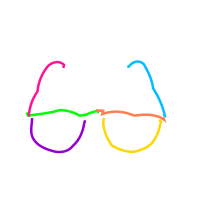

In [ ]:
glasses = dataset.get(505, model_args=['commands', 'args', 'label'])
encoded_glasses = encode(glasses, vae_model)
decode(encoded_glasses.unsqueeze(dim=0).unsqueeze(dim=0), vae_model)

In [ ]:
for x, y in train_dataloader:
  model_kwargs = dict(y=y)
  print(model_kwargs)

torch.Size([10])
{'y': tensor([1, 1, 1, 1, 1, 1, 1, 2, 2, 1])}
torch.Size([10])
{'y': tensor([2, 1, 0, 2, 1, 2, 1, 1, 1, 1])}
torch.Size([10])
{'y': tensor([1, 2, 2, 1, 0, 1, 2, 2, 1, 1])}
torch.Size([10])
{'y': tensor([2, 2, 1, 1, 1, 1, 1, 0, 2, 1])}
torch.Size([10])
{'y': tensor([1, 2, 1, 1, 1, 2, 1, 1, 2, 2])}
torch.Size([10])
{'y': tensor([1, 1, 2, 1, 2, 1, 1, 2, 1, 2])}
torch.Size([10])
{'y': tensor([2, 1, 2, 1, 1, 2, 1, 1, 1, 2])}
torch.Size([10])
{'y': tensor([2, 1, 1, 1, 2, 1, 1, 1, 1, 2])}


# The Denoiser (Backward Step, Transformer)

imports

In [8]:
import torch
import torch.nn as nn
import numpy as np
import math
from timm.models.vision_transformer import PatchEmbed, Attention, Mlp

constants

In [20]:
# input_size = 16
# patch_size = 2
in_channels = 1
hidden_size = 256
# image_size = 16
num_heads=16
learn_sigma=True # What is sigma? it was True by default

class_dropout_prob=0.4
# num_classes=4
# class_labels = 207,
# n = len(class_labels)

out_channels = in_channels * 2 if learn_sigma else in_channels

## Timestep and Label Embedding

In [10]:
#################################################################################
#               Embedding Layers for Timesteps and Class Labels                 #
#################################################################################

class TimestepEmbedder(nn.Module):
    """
    Embeds scalar timesteps into vector representations.
    """
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb


class LabelEmbedder(nn.Module):
    """
    Embeds class labels into vector representations. Also handles label dropout for classifier-free guidance.
    """
    def __init__(self, num_classes, hidden_size, dropout_prob):
        super().__init__()
        use_cfg_embedding = dropout_prob > 0
        self.embedding_table = nn.Embedding(num_classes + use_cfg_embedding, hidden_size)
        self.num_classes = num_classes
        self.dropout_prob = dropout_prob

    def token_drop(self, labels, force_drop_ids=None):
        """
        Drops labels to enable classifier-free guidance.
        """
        if force_drop_ids is None:
            drop_ids = torch.rand(labels.shape[0], device=labels.device) < self.dropout_prob
        else:
            drop_ids = force_drop_ids == 1
        labels = torch.where(drop_ids, self.num_classes, labels)
        return labels

    def forward(self, labels, train, force_drop_ids=None):
        use_dropout = self.dropout_prob > 0
        if (train and use_dropout) or (force_drop_ids is not None):
            labels = self.token_drop(labels, force_drop_ids)
        embeddings = self.embedding_table(labels)
        return embeddings

## Positional Embedding

In [11]:
#################################################################################
#                   Sine/Cosine Positional Embedding Functions                  #
#################################################################################
# https://github.com/facebookresearch/mae/blob/main/util/pos_embed.py

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False, extra_tokens=0):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token and extra_tokens > 0:
        pos_embed = np.concatenate([np.zeros([extra_tokens, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

## Final Layer

In [12]:
class FinalLayer(nn.Module):
    """
    The final layer of DiT.
    """
    def __init__(self,  out_channels, hidden_size=256,):
        super().__init__()
        self.norm_final = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.linear = nn.Linear(hidden_size, hidden_size * out_channels, bias=True)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 2 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        x = modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x

## DiT Block

In [13]:
def modulate(x, shift: torch.Tensor, scale: torch.Tensor):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

class DiTBlock(nn.Module):
    """
    A DiT block with adaptive layer norm zero (adaLN-Zero) conditioning.
    """
    def __init__(self, hidden_size=16, num_heads=16, mlp_ratio=4.0, **block_kwargs):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.attn = Attention(hidden_size, num_heads=num_heads, qkv_bias=True, **block_kwargs)
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        mlp_hidden_dim = int(hidden_size * mlp_ratio)
        approx_gelu = lambda: nn.GELU(approximate="tanh")
        self.mlp = Mlp(in_features=hidden_size, hidden_features=mlp_hidden_dim, act_layer=approx_gelu, drop=0)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 6 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(6, dim=1)
        x = x + gate_msa.unsqueeze(1) * self.attn(modulate(self.norm1(x), shift_msa, scale_msa))
        x = x + gate_mlp.unsqueeze(1) * self.mlp(modulate(self.norm2(x), shift_mlp, scale_mlp))
        return x

## DiT Model

In [14]:
class DiT(nn.Module):
    """
    Diffusion model with a Transformer backbone.
    """
    def __init__(
        self,
        in_channels=1,
        hidden_size=256,
        depth=28,
        num_heads=16,
        mlp_ratio=4.0,
        class_dropout_prob=0.1,
        num_classes=1, # 56
        learn_sigma=True,
    ):
        super().__init__()
        self.learn_sigma = learn_sigma
        self.in_channels = in_channels
        self.out_channels = in_channels * 2 if learn_sigma else in_channels
        self.num_heads = num_heads

        self.t_embedder = TimestepEmbedder(hidden_size)
        self.y_embedder = LabelEmbedder(num_classes, hidden_size, class_dropout_prob)
        self.num_patches = 1

        # Will use fixed sin-cos embedding:
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, hidden_size), requires_grad=False)

        self.blocks = nn.ModuleList([
            DiTBlock(hidden_size, num_heads, mlp_ratio=mlp_ratio) for _ in range(depth)
        ])

        self.final_layer = FinalLayer(hidden_size=hidden_size, out_channels=self.out_channels)
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize transformer layers:
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        self.apply(_basic_init)

        # Initialize (and freeze) pos_embed by sin-cos embedding:
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.num_patches ** 0.5))
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # Initialize label embedding table:
        nn.init.normal_(self.y_embedder.embedding_table.weight, std=0.02)

        # Initialize timestep embedding MLP:
        nn.init.normal_(self.t_embedder.mlp[0].weight, std=0.02)
        nn.init.normal_(self.t_embedder.mlp[2].weight, std=0.02)

        # Zero-out adaLN modulation layers in DiT blocks:
        for block in self.blocks:
            nn.init.constant_(block.adaLN_modulation[-1].weight, 0)
            nn.init.constant_(block.adaLN_modulation[-1].bias, 0)

        # Zero-out output layers:
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].weight, 0)
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].bias, 0)
        nn.init.constant_(self.final_layer.linear.weight, 0)
        nn.init.constant_(self.final_layer.linear.bias, 0)


    def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor):
        """
        Forward pass of DiT.
        x: (N, C, H, W) tensor of spatial inputs (images or latent representations of images)
        t: (N,) tensor of diffusion timesteps
        y: (N,) tensor of class labels
        """
        x = x + self.pos_embed      # (N, T, D), where T = H * W / patch_size ** 2
        t = self.t_embedder(t)                   # (N, D)
        y = self.y_embedder(y, self.training)    # (N, D)
        c = t + y                                # (N, D)

        for block in self.blocks:
            x = block(x, c)                      # (N, T, D)

        x = self.final_layer(x, c)
        return x.reshape(shape=(x.shape[0], self.out_channels, hidden_size))   # (N, out_channels, H, W)

    def forward_with_cfg(self, x, t, y, cfg_scale):
        """
        Forward pass of DiT, but also batches the unconditional forward pass for classifier-free guidance.
        """
        # https://github.com/openai/glide-text2im/blob/main/notebooks/text2im.ipynb
        half = x[: len(x) // 2]
        combined = torch.cat([half, half], dim=0)
        model_out = self.forward(combined, t, y)
        # For exact reproducibility reasons, we apply classifier-free guidance on only
        # three channels by default. The standard approach to cfg applies it to all channels.
        # This can be done by uncommenting the following line and commenting-out the line following that.
        # eps, rest = model_out[:, :self.in_channels], model_out[:, self.in_channels:]
        eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
        half_eps = uncond_eps + cfg_scale * (cond_eps - uncond_eps)
        eps = torch.cat([half_eps, half_eps], dim=0)
        return torch.cat([eps, rest], dim=1)

# Training

### Train Utils

In [15]:
from collections import OrderedDict

@torch.no_grad()
def update_ema(ema_model, model, decay=0.9999):
    """
    Step the EMA model towards the current model.
    """
    ema_params = OrderedDict(ema_model.named_parameters())
    model_params = OrderedDict(model.named_parameters())

    for name, param in model_params.items():
        # TODO: Consider applying only to params that require_grad to avoid small numerical changes of pos_embed
        ema_params[name].mul_(decay).add_(param.data, alpha=1 - decay)


def requires_grad(model, flag=True):
    """
    Set requires_grad flag for all parameters in a model.
    """
    for p in model.parameters():
        p.requires_grad = flag

In [16]:
from pathlib import Path
from datetime import datetime
from deepsvg.svglib.utils import to_gif

@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_show_svg(epoch: int):
    # Sample noise
    latent_size = 256
    svg = torch.randn((1, latent_size), device=device)
    num_images = 10
    stepsize = int(T/num_images)
    img_list = []

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        svg = sample_timestep(svg, t)

        # Edit: This is to maintain the natural range of the distribution
        svg = torch.clamp(svg, -1.0, 1.0)

        print(svg.shape)

        img = decode(svg.unsqueeze(dim=0), vae_model, return_png=True, do_display=False)
        img_list.append(img)

    to_gif(img_list, file_path=f'./artifacts/gifs/epoch-{epoch}.gif', do_display=False)


def log_training(epoch_number: int, loss: float, timestep: int = None):
    Path("./artifacts/").mkdir(parents=True, exist_ok=True)
    Path("./artifacts/gifs").mkdir(parents=True, exist_ok=True)

    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")

    f = open("artifacts/log.txt", "a")

    if timestep: f.write(f"{current_time} Epoch {epoch_number}: {loss} for timestep {timestep} \n\n")
    else: f.write(f"{current_time} Epoch {epoch_number}: {loss} \n\n")

    # sample_show_svg(epoch)

    f.close()


def sample_from_diffusion(diffusion, model, class_labels, x_t=None, normalization_factor=0.7, display_gif=False, cfg_scale=4):

    img_list = []

    # Create sampling noise:
    n = len(class_labels)
    z = torch.randn(n, 1, 256, device=device) if not x_t else x_t # z = torch.randn(1, 1, 256, device=device)
    y = torch.tensor(class_labels, device=device)

    # Setup classifier-free guidance:
    z = torch.cat([z, z], 0)
    y_null = torch.tensor([n] * n, device=device) # [1]
    y = torch.cat([y, y_null], 0)
    model_kwargs = dict(y=y, cfg_scale=cfg_scale)

    # Sample images:
    if display_gif:
      final_sample = None
      for sample in  diffusion.p_sample_loop_progressive(
          model.forward_with_cfg, z.shape, z, clip_denoised=False,
          model_kwargs=model_kwargs, progress=True, device=device
      ):
        samples, _ = sample["sample"].chunk(2, dim=0)  # Remove null class samples
        # samples = samples * normalization_factor
        sample_svg = decode((samples.unsqueeze(dim=0) / samples.std()) * normalization_factor,
                               vae_model, return_svg=True, do_display=False) #  * normalization_factor
        sample_png = draw(sample_svg, width=1200, height=1200, do_display=False, return_png=True)
        img_list.append(sample_png)
        final_sample = sample

      to_gif(img_list[::2])
      return final_sample

    else:
      samples = diffusion.p_sample_loop(
          model.forward_with_cfg, z.shape, z, clip_denoised=False,
          model_kwargs=model_kwargs, progress=True, device=device
      )

      samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
      # samples = samples * normalization_factor
      decode((samples.unsqueeze(dim=0) / samples.std()) * normalization_factor, vae_model,) # * normalization_factor

      return samples

In [17]:
from dit.diffusion.gaussian_diffusion import LossType, ModelVarType, ModelMeanType

def mean_flat(tensor):
    """
    Take the mean over all non-batch dimensions.
    """
    return tensor.mean(dim=list(range(1, len(tensor.shape))))

def training_losses(diffusion, model, x_start, t, model_kwargs=None, noise=None):
        """
        Compute training losses for a single timestep.
        :param model: the model to evaluate loss on.
        :param x_start: the [N x C x ...] tensor of inputs.
        :param t: a batch of timestep indices.
        :param model_kwargs: if not None, a dict of extra keyword arguments to
            pass to the model. This can be used for conditioning.
        :param noise: if specified, the specific Gaussian noise to try to remove.
        :return: a dict with the key "loss" containing a tensor of shape [N].
                 Some mean or variance settings may also have other keys.
        """
        if model_kwargs is None:
            model_kwargs = {}
        if noise is None:
            noise = torch.randn_like(x_start)
        x_t = diffusion.q_sample(x_start, t, noise=noise)

        terms = {}

        if diffusion.loss_type == LossType.KL or diffusion.loss_type == LossType.RESCALED_KL:
            terms["loss"] = diffusion._vb_terms_bpd(
                model=model,
                x_start=x_start,
                x_t=x_t,
                t=t,
                clip_denoised=False,
                model_kwargs=model_kwargs,
            )["output"]
            if diffusion.loss_type == LossType.RESCALED_KL:
                terms["loss"] *= diffusion.num_timesteps
        elif diffusion.loss_type == LossType.MSE or diffusion.loss_type == LossType.RESCALED_MSE:
            model_output = model(x_t, t, **model_kwargs)

            if diffusion.model_var_type in [
                ModelVarType.LEARNED,
                ModelVarType.LEARNED_RANGE,
            ]:
                B, C = x_t.shape[:2]
                assert model_output.shape == (B, C * 2, *x_t.shape[2:])
                model_output, model_var_values = torch.split(model_output, C, dim=1)
                # Learn the variance using the variational bound, but don't let
                # it affect our mean prediction.
                frozen_out = torch.cat([model_output.detach(), model_var_values], dim=1)
                terms["vb"] = diffusion._vb_terms_bpd(
                    model=lambda *args, r=frozen_out: r,
                    x_start=x_start,
                    x_t=x_t,
                    t=t,
                    clip_denoised=False,
                )["output"]
                if diffusion.loss_type == LossType.RESCALED_MSE:
                    # Divide by 1000 for equivalence with initial implementation.
                    # Without a factor of 1/1000, the VB term hurts the MSE term.
                    terms["vb"] *= diffusion.num_timesteps / 1000.0

            target = {
                ModelMeanType.PREVIOUS_X: diffusion.q_posterior_mean_variance(
                    x_start=x_start, x_t=x_t, t=t
                )[0],
                ModelMeanType.START_X: x_start,
                ModelMeanType.EPSILON: noise,
            }[diffusion.model_mean_type]
            assert model_output.shape == target.shape == x_start.shape
            terms["mse"] = mean_flat((target - model_output) ** 2)
            if "vb" in terms:
                terms["loss"] = terms["mse"] + terms["vb"]
            else:
                terms["loss"] = terms["mse"]
        else:
            raise NotImplementedError(diffusion.loss_type)

        return terms

### Loop

In [18]:
total_epochs = 0
seed = 0
torch.manual_seed(seed)
magical_number = 0.7128
# torch.cuda.set_device(device)

In [22]:
from torch.optim import AdamW
from copy import deepcopy
from dit.diffusion import create_diffusion

model = DiT(num_classes=num_classes(train_dataloader), class_dropout_prob=0.4, depth=73)
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)
ema = deepcopy(model).to(device)  # Create an EMA of the model for use after training
requires_grad(ema, False)

diffusion = create_diffusion(timestep_respacing="", predict_xstart=False)  # default: 1000 steps, linear noise schedule

In [23]:
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=0)

In [24]:
# Prepare models for training:
update_ema(ema, model, decay=0)  # Ensure EMA is initialized with synced weights
model.train()  # important! This enables embedding dropout for classifier-free guidance
ema.eval()  # EMA model should always be in eval mode

DiT(
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (y_embedder): LabelEmbedder(
    (embedding_table): Embedding(29, 256)
  )
  (blocks): ModuleList(
    (0): DiTBlock(
      (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=False)
      (attn): Attention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((256,), eps=1e-06, elementwise_affine=False)
      (mlp): Mlp(
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (act): GELU(approximate=tanh)
        (drop1): Dropout(p=0, inplace=False)
        (norm): Identi

In [25]:
epochs = 1

for epoch in range(epochs):
    steps = 0
    avg_loss = 0
    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)

        x = x.squeeze().unsqueeze(dim=1)
        x = x / magical_number # mean of std's of latents

        model_kwargs = dict(y=y)

        t = torch.randint(0, diffusion.num_timesteps, (x.shape[0],), device=device)

        loss_dict = diffusion.training_losses(model, x, t, model_kwargs)
        loss = loss_dict["loss"].mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        update_ema(ema, model)

        steps += 1
        
        avg_loss += loss.item()
#         print(f"loss: {loss.item()}")

    total_epochs += 1
    log_training(total_epochs, avg_loss / len(train_dataloader))

### Overfitting on one data point

In [ ]:
encoded_svg = encode(dataset.get(505), vae_model)
print(encoded_svg.std())
decode(encoded_svg.unsqueeze(dim=0).unsqueeze(dim=0), vae_model)
tmp = encoded_svg / encoded_svg.std()
print(tmp.std())
decode(tmp.unsqueeze(dim=0).unsqueeze(dim=0), vae_model)
tmp = tmp * 0.64
decode(tmp.unsqueeze(dim=0).unsqueeze(dim=0), vae_model)

In [ ]:
encoded_dataset_with_labels = []

In [ ]:
class1 = [18602, 7619]
class2 = [41994, 78636, ] # 3833
class3 = [41520, 4360]
class4 = [76293, 86718]

label = 0

for c in [class1, class2, class3, class4]:
    for i in c:
      x = dataset.get(id=i, model_args=['commands', 'args'])
      label_tensor = torch.tensor([label], device=device)
      encoded_dataset_with_labels.append([encode(x, vae_model), label_tensor])
    label += 1

In [ ]:
len(encoded_dataset_with_labels)

9

In [ ]:
for i in range(100):
    xy = dataset.get(300+i, model_args=['commands', 'args', 'label'])
    print(300+i)
    print(xy.pop('label').item())
    decode(encode(xy, vae_model).unsqueeze(dim=0).unsqueeze(dim=0), vae_model)
    print()

In [ ]:
for x, y in encoded_dataset_with_labels:
    # decode(x.unsqueeze(dim=0).unsqueeze(dim=0), vae_model)
    print(y)

tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([2])
tensor([2])
tensor([3])
tensor([3])


In [ ]:
epochs = 2500

for epoch in range(epochs):
    steps = 0

    for x, y in encoded_dataset_with_labels:
        x = x.unsqueeze(dim=0)
        x = x / magical_number

        model_kwargs = dict(y=y)

        t = torch.randint(0, diffusion.num_timesteps, (x.shape[0],), device=device)
        loss_dict = diffusion.training_losses(model, x, t, model_kwargs)
        loss = loss_dict["loss"].mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        update_ema(ema, model)

        if epoch % 5 == 0 and steps == 0:
            log_training(total_epochs, loss.item(), t.item())

        steps += 1

    total_epochs += 1

In [ ]:
epochs = 2500

for epoch in range(epochs):
    glasses = dataset.get(505, model_args=['commands', 'args'])
    encoded_glasses = encode(glasses, vae_model).unsqueeze(dim=0)
    encoded_glasses = encoded_glasses / encoded_glasses.std()
    y = torch.tensor(0).unsqueeze(dim=0)

    model_kwargs = dict(y=y)

    t = torch.randint(0, diffusion.num_timesteps, (encoded_glasses.shape[0],), device=device)

    loss_dict = diffusion.training_losses(model, encoded_glasses, t, model_kwargs)
    loss = loss_dict["loss"].mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    update_ema(ema, model)

    if epoch % 5 == 0:
      log_training(total_epochs, loss.item(), t.item())

    total_epochs += 1

In [ ]:
t = torch.tensor(250, device=device).unsqueeze(dim=0)

noise = torch.randn_like(encoded_glasses)
x_t = diffusion.q_sample(encoded_glasses, t, noise=noise)

In [ ]:
model_output = model(x_t, t, **model_kwargs)
B, C = x_t.shape[:2]
assert model_output.shape == (B, C * 2, *x_t.shape[2:])
model_output, model_var_values = torch.split(model_output, C, dim=1)

In [ ]:
print(mean_flat((encoded_glasses - model_output) ** 2))
decode(model_output.unsqueeze(dim=0), vae_model)

### sampling

In [28]:
model.eval()  # important!

DiT(
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (y_embedder): LabelEmbedder(
    (embedding_table): Embedding(29, 256)
  )
  (blocks): ModuleList(
    (0): DiTBlock(
      (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=False)
      (attn): Attention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((256,), eps=1e-06, elementwise_affine=False)
      (mlp): Mlp(
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (act): GELU(approximate=tanh)
        (drop1): Dropout(p=0, inplace=False)
        (norm): Identi

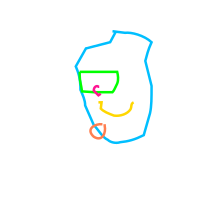

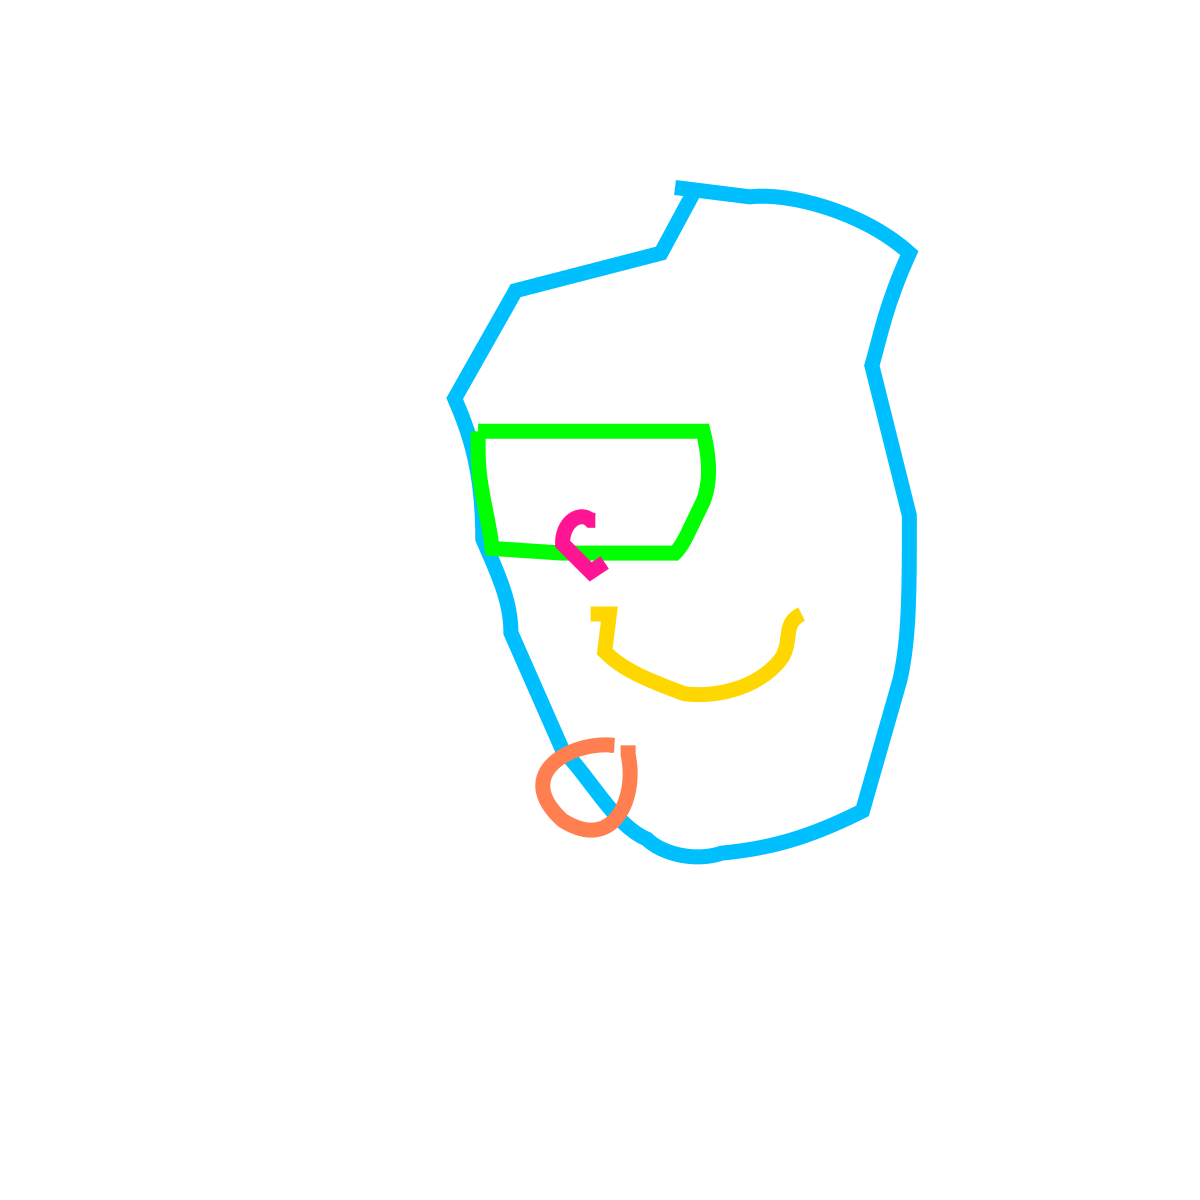

In [45]:
tmp_svg = decode((tmp.unsqueeze(dim=0) / tmp.std()) * 0.6, vae_model, return_svg=True, do_display=False)
draw(tmp_svg, width=1200, height=1200, return_png=True)
# for i in range(samples.shape[0]):
#   decode((samples[i].unsqueeze(dim=0).unsqueeze(dim=0) / samples.std()) * 0.7, vae_model, return_png=False, do_display=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

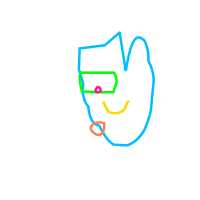

In [34]:
tmp = sample_from_diffusion(diffusion=diffusion, model=model, class_labels=[4], normalization_factor=magical_number, display_gif=False)
# for i in range(10): sample_from_diffusion(diffusion=diffusion, model=model, class_labels=[0])`

In [ ]:
# img_list = []
samples, _ = tmp["sample"].chunk(2, dim=0)  # Remove null class samples

test_svg = decode((samples.unsqueeze(dim=0) / samples.std()) * magical_number ,
                               vae_model, return_png=True, do_display=True)
# test_img1 = draw(test_svg, return_png=True)
# test_img2 = draw(test_svg, return_png=True)
# img_list.append(test_img1)
# img_list.append(test_img2)

In [ ]:
to_gif(img_list)

In [ ]:
import torch.nn.functional as F
print(F.l1_loss((samples / samples.std())  * 0.67, encoded_glasses))
print(mean_flat(((encoded_glasses * 0.625) - ((samples /samples.std()) *0.625)) ** 2))

tensor(0.3639)

In [ ]:
for i in range(10):
  tmp = 1 - (1/(i+1))
  for i in range(samples.shape[0]):
    decode((samples[i].unsqueeze(dim=0).unsqueeze(dim=0) / samples.std()) * tmp, vae_model, return_png=False, do_display=True)

# Saving/Loading the Model

In [ ]:
from torch.optim import AdamW
from copy import deepcopy

def save_model(model, ema, optimizer, diffusion, total_epochs, predict_noise=False):
    export_dir = './models'

    Path(export_dir).mkdir(parents=True, exist_ok=True)

    checkpoint = {
      "model": model.state_dict(),
      "ema": ema.state_dict(),
      "opt": optimizer.state_dict(),
      "diffusion": diffusion,
    }
    exported_model_path = f"{export_dir}/predict_{'noise' if predict_noise else 'x0'}_{total_epochs}.pt"
    torch.save(checkpoint, exported_model_path)


def load_model(model_path, num_classes, device, for_training=True, return_optimizer=False):
    model = DiT(num_classes=num_classes).to(device)
    ema = deepcopy(model).to(device)
    state = torch.load(model_path, map_location=device)

    ema.load_state_dict(state['ema'])
    model.load_state_dict(state['model'])

    optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0)
    optimizer.load_state_dict(state['opt'])

    if not for_training:
      model.eval()
      return model, state['diffusion'], ema
    else:
      return model, optimizer, state['diffusion'], ema

In [ ]:
save_model(model, ema, optimizer, diffusion, total_epochs)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model, diffusion, ema = load_model('./gdrive/MyDrive/Bachelor/Models/overfit-4-classes.pt', 4, device, for_training=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

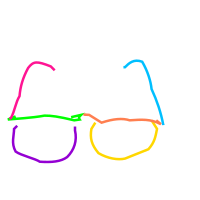

In [ ]:
tmp = sample_from_diffusion(diffusion=new_diffusion, model=new_model, class_labels=[1], normalization_factor=magical_number,)

# Smothening

In [ ]:
svg = decode(tmp.unsqueeze(dim=0), vae_model, return_svg=True)

In [ ]:
svg.to_points()

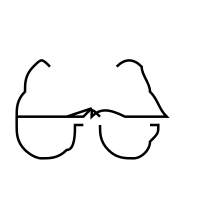

In [ ]:
SVG.from_tensor(torch.round(svg.to_tensor())).draw()

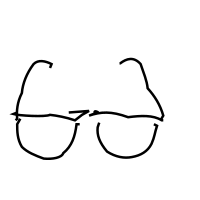

In [ ]:
SVG.from_tensor(svg.to_tensor()).draw()

# Drawing

In [31]:
import IPython.display as ipd
import cairosvg
import io
from PIL import Image

def draw(svg_obj, fill=False, file_path=None, do_display=True, return_png=False,
         with_points=False, with_handles=False, with_bboxes=False, with_markers=False, color_firstlast=False,
         with_moves=True, width=600, height=600):
    if file_path is not None:
        _, file_extension = os.path.splitext(file_path)
        if file_extension == ".svg":
            svg_obj.save_svg(file_path)
        elif file_extension == ".png":
            svg_obj.save_png(file_path)
        else:
            raise ValueError(f"Unsupported file_path extension {file_extension}")

    svg_str = svg_obj.to_str(fill=fill, with_points=with_points, with_handles=with_handles, with_bboxes=with_bboxes,
                              with_markers=with_markers, color_firstlast=color_firstlast, with_moves=with_moves)

    if do_display:
        ipd.display(ipd.SVG(svg_str))

    if return_png:
        if file_path is None:
            img_data = cairosvg.svg2png(bytestring=svg_str, output_width=width, output_height=height)
            return Image.open(io.BytesIO(img_data))
        else:
            _, file_extension = os.path.splitext(file_path)

            if file_extension == ".svg":
                img_data = cairosvg.svg2png(url=file_path)
                return Image.open(io.BytesIO(img_data))
            else:
                return Image.open(file_path)
